<h1>Biomass Extraction and Modeling for Askvoll Region</h1>

This Python code is developed for biomass extraction and modeling in the Askvoll region, utilizing LiDAR data for tree segmentation and extracting tree heights from Digital Surface Model (DSM) and Digital Terrain Model (DTM). The dataset includes precise tree coordinates, and a map of dominant tree species in the Area of Interest (AOI) is incorporated. The workflow involves preprocessing LiDAR data, segmenting trees, calculating heights, identifying species, and estimating biomass. Key libraries such as lidR, geopandas, and scikit-learn are used for LiDAR processing, spatial analysis, and machine learning. The results provide insights into biomass distribution, species composition, and support environmental monitoring in the Askvoll region.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing import image  # Add this import
import tifffile
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load tree data from CSV
#tree_data = pd.read_csv('AOI_tree_data.csv')
tree_data = pd.read_csv('newAOI_tree_data11.csv')
# Load and preprocess segmented images
optical_folder = 'Optical_patches_16x16'
sar_folder = 'SAR_patches_16x16'
#labels = tree_data['Biomass'].values
labels = tree_data['Biomass'].values
species_labels = tree_data['TreeSpecies'].values
height_labels = tree_data['Z'].values
DBH_labels = tree_data['DBH'].values

In [3]:
# Print the shape
print("Shape of tree_data:", tree_data.shape)


Shape of tree_data: (30686, 7)


In [4]:
#applied Asymptote 
#asymptote_decidious = 20.56964 - 6
#asymptote_pine = 28.67605 - 12
#asymptote_spruce = 36.68428 - 18
asymptote_decidious = 20.56964 
asymptote_pine = 28.67605 
asymptote_spruce = 36.68428 


# Define asymptote values
#asymptote_deciduous = 20.56964 - 4
#asymptote_pine = 28.67605 - 4
#asymptote_spruce = 36.68428 - 4

# Define conditions for filtering
deciduous_condition = (tree_data['TreeSpecies'] == 3) & (tree_data['Z'] > asymptote_decidious)
pine_condition = (tree_data['TreeSpecies'] == 2) & (tree_data['Z'] > asymptote_pine)
spruce_condition = (tree_data['TreeSpecies'] == 1) & (tree_data['Z'] > asymptote_spruce)

# Apply filtering
filtered_tree_data = tree_data[~(deciduous_condition | pine_condition | spruce_condition)]

# Print the filtered DataFrame
print(filtered_tree_data)
tree_data=filtered_tree_data
#labels = tree_data['Biomass'].values
labels = tree_data['Biomass'].values

labels = np.log1p(tree_data['Biomass'])

species_labels = tree_data['TreeSpecies'].values
height_labels = tree_data['Z'].values
DBH_labels = tree_data['DBH'].values

       treeID      Z  TreeSpecies   coords.x1    coords.x2        DBH  \
0           1   2.72            0  293752.125  6808799.875   0.000000   
1           2   6.01            3  293762.625  6808799.875   7.375844   
2           3   6.28            3  293764.875  6808799.875   7.756884   
3           4   6.36            3  293786.875  6808799.875   7.871765   
4           5   6.33            3  293819.875  6808799.875   7.828575   
...       ...    ...          ...         ...          ...        ...   
30681   30682   8.14            2  293966.625  6807600.125  11.715224   
30682   30683   7.28            2  293983.375  6807600.125  10.425126   
30683   30684  13.38            2  294726.125  6807600.125  21.961304   
30684   30685  16.09            2  295074.625  6807600.125  30.222160   
30685   30686  12.59            2  295125.125  6807600.125  20.046341   

          Biomass  
0        0.000000  
1        9.634474  
2       10.993850  
3       11.427600  
4       11.263212  
...

In [5]:
print(tree_data)

       treeID      Z  TreeSpecies   coords.x1    coords.x2        DBH  \
0           1   2.72            0  293752.125  6808799.875   0.000000   
1           2   6.01            3  293762.625  6808799.875   7.375844   
2           3   6.28            3  293764.875  6808799.875   7.756884   
3           4   6.36            3  293786.875  6808799.875   7.871765   
4           5   6.33            3  293819.875  6808799.875   7.828575   
...       ...    ...          ...         ...          ...        ...   
30681   30682   8.14            2  293966.625  6807600.125  11.715224   
30682   30683   7.28            2  293983.375  6807600.125  10.425126   
30683   30684  13.38            2  294726.125  6807600.125  21.961304   
30684   30685  16.09            2  295074.625  6807600.125  30.222160   
30685   30686  12.59            2  295125.125  6807600.125  20.046341   

          Biomass  
0        0.000000  
1        9.634474  
2       10.993850  
3       11.427600  
4       11.263212  
...

In [6]:
# Find the index of the row with the maximum 'Biomass'
max_biomass_index = tree_data['Biomass'].idxmax()

# Retrieve the row with the maximum 'Biomass'
max_biomass_row = tree_data.loc[max_biomass_index]

# Print the row with the maximum 'Biomass'
print(max_biomass_row)


treeID         2.674200e+04
Z              3.647000e+01
TreeSpecies    1.000000e+00
coords.x1      2.945561e+05
coords.x2      6.807863e+06
DBH            3.584866e+03
Biomass        1.620708e+04
Name: 26741, dtype: float64


In [7]:
# Convert the Series to a DataFrame
max_biomass_row_df = max_biomass_row.to_frame().transpose()

# Print the DataFrame containing only the row with the maximum biomass
print(max_biomass_row_df)


        treeID      Z  TreeSpecies   coords.x1    coords.x2          DBH  \
26741  26742.0  36.47          1.0  294556.125  6807863.375  3584.866088   

            Biomass  
26741  16207.076671  


In [8]:
asymptote_decidious

20.56964

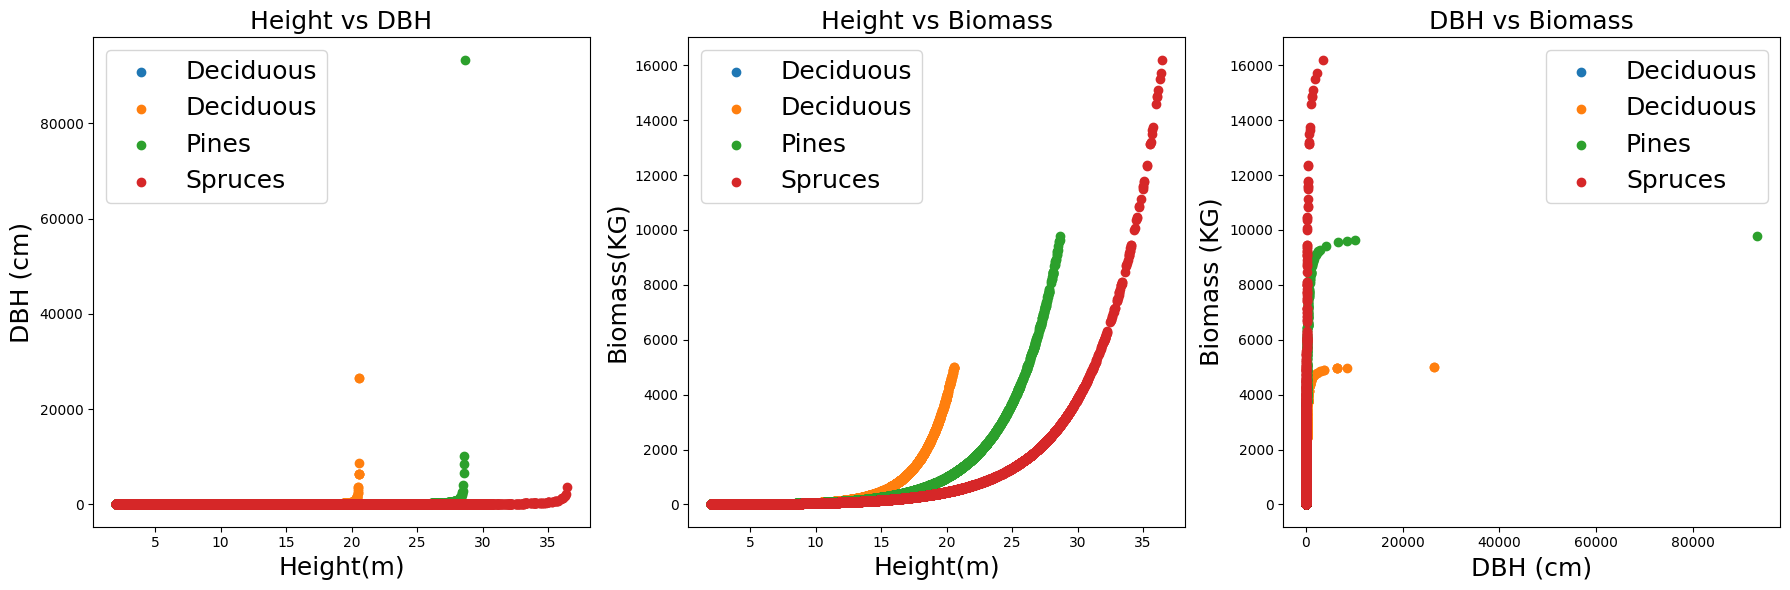

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already read the CSV file into 'tree_data'
#tree_data = pd.read_csv('AOI_tree_data.csv')

plt.figure(figsize=(18, 6))

# Scatter plot for Z and DBH
plt.subplot(1, 3, 1)
for species_id in tree_data['TreeSpecies'].unique():
    subset = tree_data[tree_data['TreeSpecies'] == species_id]
    species_name = 'Spruces' if species_id == 1 else ('Pines' if species_id == 2 else 'Deciduous')
    plt.scatter(subset['Z'], subset['DBH'], label=f'{species_name}')

plt.title('Height vs DBH', fontsize=18)
plt.xlabel('Height(m)', fontsize=18)
plt.ylabel('DBH (cm)', fontsize=18)
plt.legend( fontsize=18)

# Scatter plot for Z and Biomass
plt.subplot(1, 3, 2)
for species_id in tree_data['TreeSpecies'].unique():
    subset = tree_data[tree_data['TreeSpecies'] == species_id]
    species_name = 'Spruces' if species_id == 1 else ('Pines' if species_id == 2 else 'Deciduous')
    plt.scatter(subset['Z'], subset['Biomass'], label=f'{species_name}')

plt.title('Height vs Biomass', fontsize=18)
plt.xlabel('Height(m)', fontsize=18)
plt.ylabel('Biomass(KG)', fontsize=18)
plt.legend(fontsize=18)




#plt.figure(figsize=(12, 6))

# Scatter plot for Z and DBH
plt.subplot(1, 3, 3)
for species_id in tree_data['TreeSpecies'].unique():
    subset = tree_data[tree_data['TreeSpecies'] == species_id]
    species_name = 'Spruces' if species_id == 1 else ('Pines' if species_id == 2 else 'Deciduous')
    plt.scatter(subset['DBH'], subset['Biomass'], label=f'{species_name}')

plt.title('DBH vs Biomass', fontsize=18)
plt.xlabel('DBH (cm)', fontsize=18)
plt.ylabel('Biomass (KG)', fontsize=18)
plt.legend( fontsize=18)

plt.savefig('my_plots.png', format='png')
plt.tight_layout()
plt.show()


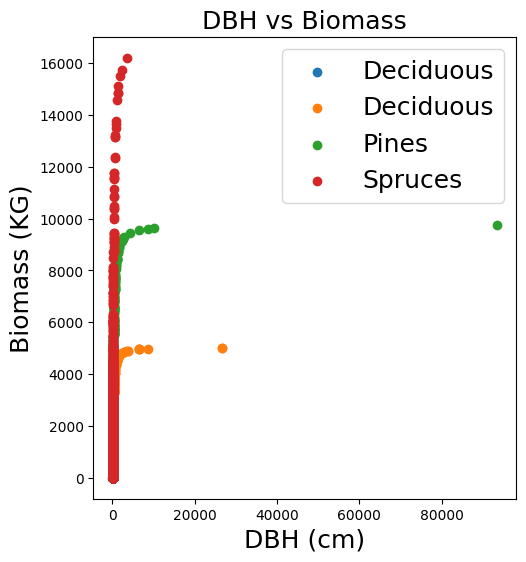

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already read the CSV file into 'tree_data'
#tree_data = pd.read_csv('AOI_tree_data.csv')

plt.figure(figsize=(12, 6))

# Scatter plot for Z and DBH
plt.subplot(1, 2, 1)
for species_id in tree_data['TreeSpecies'].unique():
    subset = tree_data[tree_data['TreeSpecies'] == species_id]
    species_name = 'Spruces' if species_id == 1 else ('Pines' if species_id == 2 else 'Deciduous')
    plt.scatter(subset['DBH'], subset['Biomass'], label=f'{species_name}')

plt.title('DBH vs Biomass', fontsize=18)
plt.xlabel('DBH (cm)', fontsize=18)
plt.ylabel('Biomass (KG)', fontsize=18)
plt.legend( fontsize=18)

plt.savefig('my_plots.svg', format='svg')


In [11]:
# Print the minimum and maximum values of 'Biomass'
min_biomass = tree_data['Biomass'].min()
max_biomass = tree_data['Biomass'].max()

print(f"Minimum Biomass: {min_biomass}")
print(f"Maximum Biomass: {max_biomass}")

# Print the minimum and maximum values of 'Biomass'
min_DBH = tree_data['DBH'].min()
max_DBH = tree_data['DBH'].max()

print(f"Minimum DBH: {min_DBH}")
print(f"Maximum DBH: {max_DBH}")

# Print the minimum and maximum values of 'Biomass'
min_Z = tree_data['Z'].min()
max_Z = tree_data['Z'].max()

print(f"Minimum Height: {min_Z}")
print(f"Maximum Height: {max_Z}")


num_rows = tree_data.shape[0]
print(f"Total number of rows: {num_rows}")


Minimum Biomass: 0.0
Maximum Biomass: 16207.0766707223
Minimum DBH: 0.0
Maximum DBH: 93384.1016420012
Minimum Height: 2.0
Maximum Height: 36.47
Total number of rows: 29860


In [12]:
print(f"Maximum Biomass: {tree_data['Biomass']} ")

Maximum Biomass: 0          0.000000
1          9.634474
2         10.993850
3         11.427600
4         11.263212
            ...    
30681     31.017450
30682     22.769565
30683    160.113326
30684    343.080187
30685    127.225109
Name: Biomass, Length: 29860, dtype: float64 


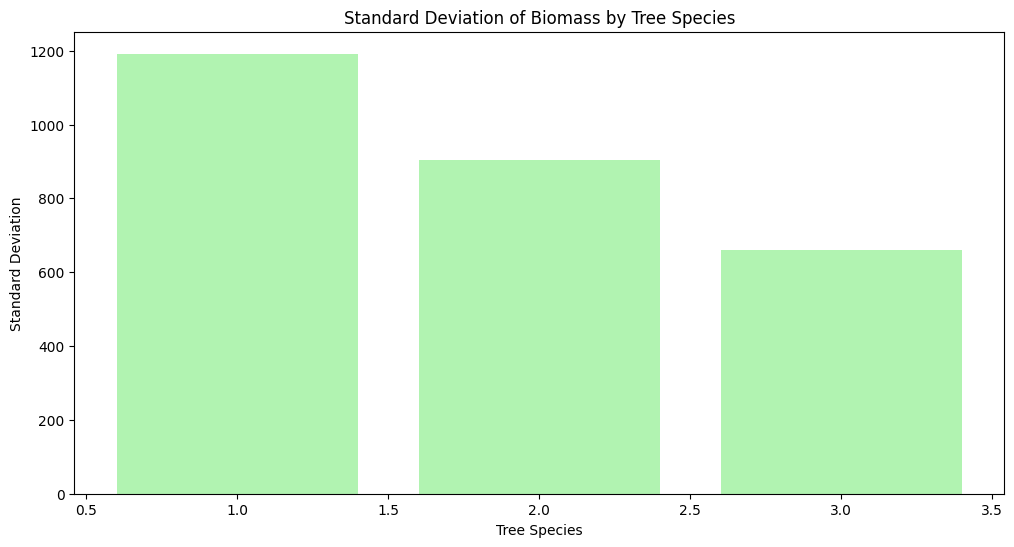

In [13]:
biomass_std = tree_data.groupby('TreeSpecies')['Biomass'].std().reset_index()

# Plotting the standard deviation of 'Biomass'
plt.figure(figsize=(12, 6))
plt.bar(biomass_std['TreeSpecies'], biomass_std['Biomass'], color='lightgreen', alpha=0.7)
plt.title('Standard Deviation of Biomass by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Standard Deviation')
plt.show()

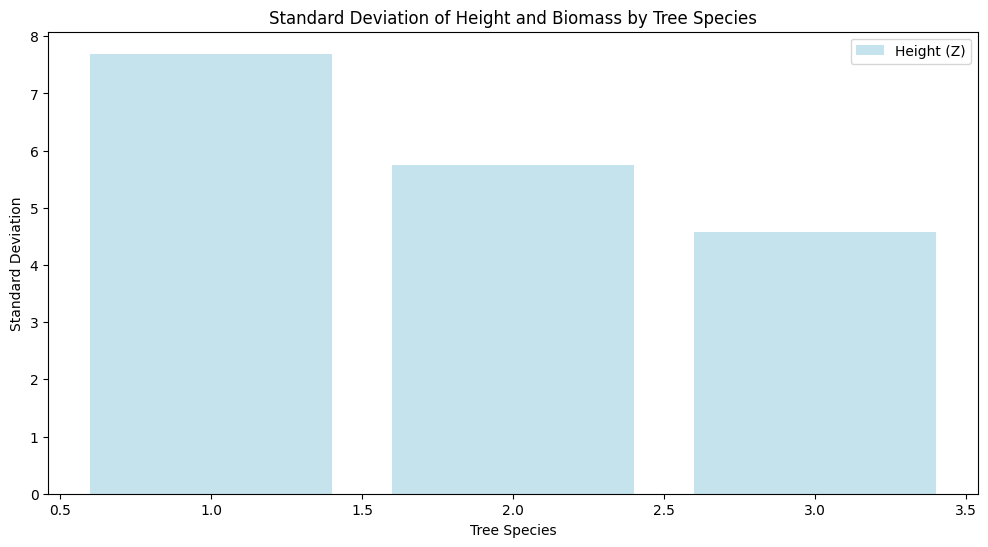

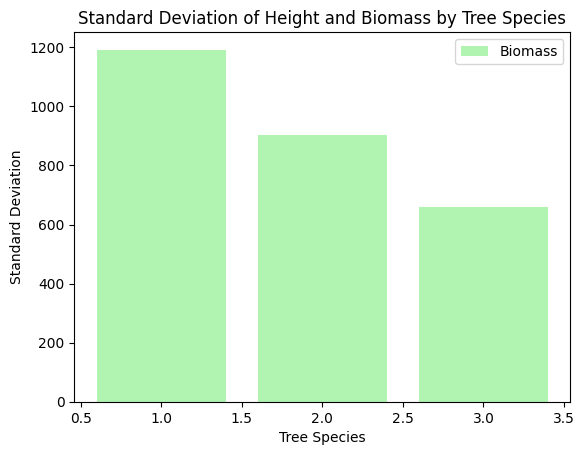

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'tree_data' is already loaded from the CSV

# Group by 'TreeSpecies' and calculate mean and standard deviation for 'Z' and 'Biomass'
grouped_data = tree_data.groupby('TreeSpecies').agg({'Z': ['mean', 'std'], 'Biomass': 'std'}).reset_index()

# Plotting the standard deviation of 'Z' and 'Biomass'
plt.figure(figsize=(12, 6))

# Standard deviation plot for 'Z'
plt.bar(grouped_data['TreeSpecies'], grouped_data[('Z', 'std')], color='lightblue', alpha=0.7, label='Height (Z)')
plt.title('Standard Deviation of Height and Biomass by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

# Standard deviation plot for 'Biomass'
plt.bar(grouped_data['TreeSpecies'], grouped_data[('Biomass', 'std')], color='lightgreen', alpha=0.7, label='Biomass')
plt.title('Standard Deviation of Height and Biomass by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()


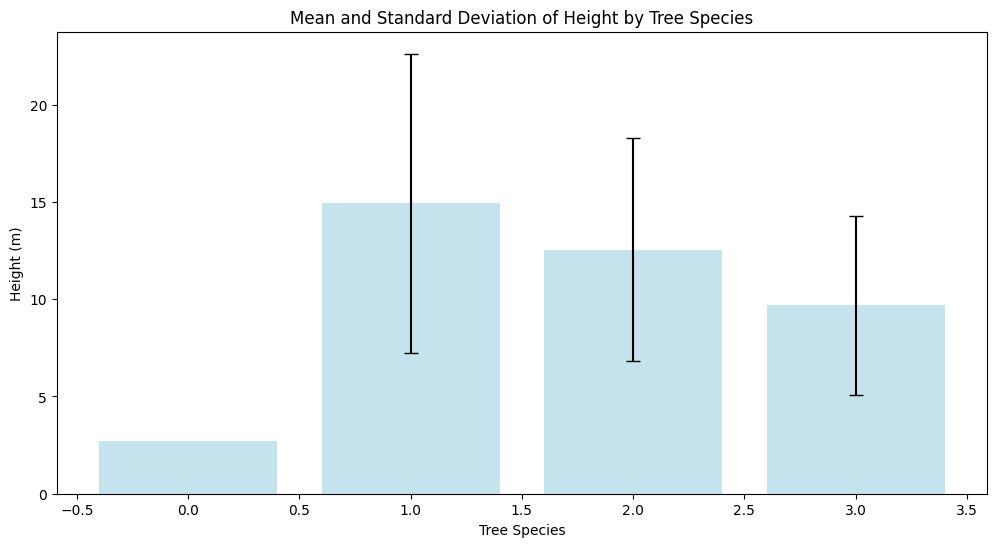

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'tree_data' is already loaded from the CSV

# Group by 'TreeSpecies' and calculate mean and standard deviation for 'Z'
grouped_data = tree_data.groupby('TreeSpecies')['Z'].agg(['mean', 'std']).reset_index()

# Plotting the mean and standard deviation of 'Z'
plt.figure(figsize=(12, 6))
plt.bar(grouped_data['TreeSpecies'], grouped_data['mean'], yerr=grouped_data['std'], capsize=5, color='lightblue', alpha=0.7)
plt.title('Mean and Standard Deviation of Height by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Height (m)')
plt.show()


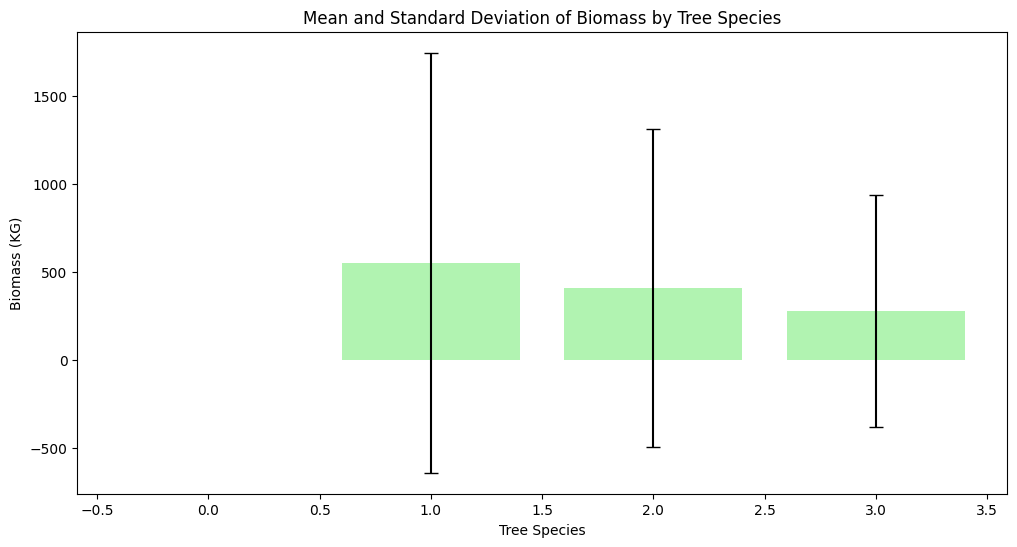

In [16]:
# Group by 'TreeSpecies' and calculate mean and standard deviation for 'Biomass'
grouped_biomass_data = tree_data.groupby('TreeSpecies')['Biomass'].agg(['mean', 'std']).reset_index()

# Plotting the mean and standard deviation of 'Biomass'
plt.figure(figsize=(12, 6))
plt.bar(grouped_biomass_data['TreeSpecies'], grouped_biomass_data['mean'], yerr=grouped_biomass_data['std'], capsize=5, color='lightgreen', alpha=0.7)
plt.title('Mean and Standard Deviation of Biomass by Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Biomass (KG)')
plt.show()


In [17]:
# Create lists for image paths, labels, and species labels
optical_image_paths = []
sar_image_paths = []
#labels = []
#species_labels = []

In [18]:
# Iterate through tree IDs
for tree_id in tree_data['treeID']:
    # Construct paths for optical and SAR images
    optical_path = os.path.join(optical_folder, f"tree_{tree_id}.0.tif")
    sar_path = os.path.join(sar_folder, f"tree_{tree_id}.0.tif")

    try:
        # Load optical image and extract specific channels (2, 3, and 5)
        optical_image = tifffile.imread(optical_path)[:, :, [2, 3, 5]]
        sar_image= tifffile.imread(sar_path)
        # Print information about the loaded optical image
        print(f"Tree ID: {tree_id}, Optical Image Shape: {optical_image.shape}")
        print(f"Tree ID: {tree_id}, Sar Image Shape: {sar_image.shape}")
        #Display the RGB image
        #plt.imshow(sar_image )
        #plt.title(f'SAR Image: {tree_id} RGB TIFF Image')
        #plt.show()
        
        #plt.imshow(optical_image )
        #plt.title(f'Optical Image: {tree_id} RGB TIFF Image')
        #plt.show()
        #optical_image_paths[tree_id]=optical_image
        #sar_image_paths[tree_id]=sar_image
        
        # Save SAR and optical images to lists
        sar_image_paths.append(sar_image)
        optical_image_paths.append(optical_image)
    except Exception as e:
        print(f"Error loading optical image {optical_path}: {e}")



Tree ID: 1, Optical Image Shape: (16, 16, 3)
Tree ID: 1, Sar Image Shape: (16, 16)
Tree ID: 2, Optical Image Shape: (16, 16, 3)
Tree ID: 2, Sar Image Shape: (16, 16)
Tree ID: 3, Optical Image Shape: (16, 16, 3)
Tree ID: 3, Sar Image Shape: (16, 16)
Tree ID: 4, Optical Image Shape: (16, 16, 3)
Tree ID: 4, Sar Image Shape: (16, 16)
Tree ID: 5, Optical Image Shape: (16, 16, 3)
Tree ID: 5, Sar Image Shape: (16, 16)
Tree ID: 6, Optical Image Shape: (16, 16, 3)
Tree ID: 6, Sar Image Shape: (16, 16)
Tree ID: 7, Optical Image Shape: (16, 16, 3)
Tree ID: 7, Sar Image Shape: (16, 16)
Tree ID: 8, Optical Image Shape: (16, 16, 3)
Tree ID: 8, Sar Image Shape: (16, 16)
Tree ID: 9, Optical Image Shape: (16, 16, 3)
Tree ID: 9, Sar Image Shape: (16, 16)
Tree ID: 10, Optical Image Shape: (16, 16, 3)
Tree ID: 10, Sar Image Shape: (16, 16)
Tree ID: 11, Optical Image Shape: (16, 16, 3)
Tree ID: 11, Sar Image Shape: (16, 16)
Tree ID: 12, Optical Image Shape: (16, 16, 3)
Tree ID: 12, Sar Image Shape: (16, 16

Tree ID: 146, Optical Image Shape: (16, 16, 3)
Tree ID: 146, Sar Image Shape: (16, 16)
Tree ID: 147, Optical Image Shape: (16, 16, 3)
Tree ID: 147, Sar Image Shape: (16, 16)
Tree ID: 148, Optical Image Shape: (16, 16, 3)
Tree ID: 148, Sar Image Shape: (16, 16)
Tree ID: 149, Optical Image Shape: (16, 16, 3)
Tree ID: 149, Sar Image Shape: (16, 16)
Tree ID: 150, Optical Image Shape: (16, 16, 3)
Tree ID: 150, Sar Image Shape: (16, 16)
Tree ID: 151, Optical Image Shape: (16, 16, 3)
Tree ID: 151, Sar Image Shape: (16, 16)
Tree ID: 152, Optical Image Shape: (16, 16, 3)
Tree ID: 152, Sar Image Shape: (16, 16)
Tree ID: 153, Optical Image Shape: (16, 16, 3)
Tree ID: 153, Sar Image Shape: (16, 16)
Tree ID: 154, Optical Image Shape: (16, 16, 3)
Tree ID: 154, Sar Image Shape: (16, 16)
Tree ID: 155, Optical Image Shape: (16, 16, 3)
Tree ID: 155, Sar Image Shape: (16, 16)
Tree ID: 156, Optical Image Shape: (16, 16, 3)
Tree ID: 156, Sar Image Shape: (16, 16)
Tree ID: 157, Optical Image Shape: (16, 16,

Tree ID: 307, Optical Image Shape: (16, 16, 3)
Tree ID: 307, Sar Image Shape: (16, 16)
Tree ID: 308, Optical Image Shape: (16, 16, 3)
Tree ID: 308, Sar Image Shape: (16, 16)
Tree ID: 309, Optical Image Shape: (16, 16, 3)
Tree ID: 309, Sar Image Shape: (16, 16)
Tree ID: 310, Optical Image Shape: (16, 16, 3)
Tree ID: 310, Sar Image Shape: (16, 16)
Tree ID: 311, Optical Image Shape: (16, 16, 3)
Tree ID: 311, Sar Image Shape: (16, 16)
Tree ID: 312, Optical Image Shape: (16, 16, 3)
Tree ID: 312, Sar Image Shape: (16, 16)
Tree ID: 313, Optical Image Shape: (16, 16, 3)
Tree ID: 313, Sar Image Shape: (16, 16)
Tree ID: 314, Optical Image Shape: (16, 16, 3)
Tree ID: 314, Sar Image Shape: (16, 16)
Tree ID: 315, Optical Image Shape: (16, 16, 3)
Tree ID: 315, Sar Image Shape: (16, 16)
Tree ID: 316, Optical Image Shape: (16, 16, 3)
Tree ID: 316, Sar Image Shape: (16, 16)
Tree ID: 317, Optical Image Shape: (16, 16, 3)
Tree ID: 317, Sar Image Shape: (16, 16)
Tree ID: 318, Optical Image Shape: (16, 16,

Tree ID: 453, Optical Image Shape: (16, 16, 3)
Tree ID: 453, Sar Image Shape: (16, 16)
Tree ID: 454, Optical Image Shape: (16, 16, 3)
Tree ID: 454, Sar Image Shape: (16, 16)
Tree ID: 455, Optical Image Shape: (16, 16, 3)
Tree ID: 455, Sar Image Shape: (16, 16)
Tree ID: 456, Optical Image Shape: (16, 16, 3)
Tree ID: 456, Sar Image Shape: (16, 16)
Tree ID: 457, Optical Image Shape: (16, 16, 3)
Tree ID: 457, Sar Image Shape: (16, 16)
Tree ID: 458, Optical Image Shape: (16, 16, 3)
Tree ID: 458, Sar Image Shape: (16, 16)
Tree ID: 459, Optical Image Shape: (16, 16, 3)
Tree ID: 459, Sar Image Shape: (16, 16)
Tree ID: 460, Optical Image Shape: (16, 16, 3)
Tree ID: 460, Sar Image Shape: (16, 16)
Tree ID: 461, Optical Image Shape: (16, 16, 3)
Tree ID: 461, Sar Image Shape: (16, 16)
Tree ID: 462, Optical Image Shape: (16, 16, 3)
Tree ID: 462, Sar Image Shape: (16, 16)
Tree ID: 463, Optical Image Shape: (16, 16, 3)
Tree ID: 463, Sar Image Shape: (16, 16)
Tree ID: 464, Optical Image Shape: (16, 16,

Tree ID: 669, Optical Image Shape: (16, 16, 3)
Tree ID: 669, Sar Image Shape: (16, 16)
Tree ID: 670, Optical Image Shape: (16, 16, 3)
Tree ID: 670, Sar Image Shape: (16, 16)
Tree ID: 671, Optical Image Shape: (16, 16, 3)
Tree ID: 671, Sar Image Shape: (16, 16)
Tree ID: 672, Optical Image Shape: (16, 16, 3)
Tree ID: 672, Sar Image Shape: (16, 16)
Tree ID: 673, Optical Image Shape: (16, 16, 3)
Tree ID: 673, Sar Image Shape: (16, 16)
Tree ID: 674, Optical Image Shape: (16, 16, 3)
Tree ID: 674, Sar Image Shape: (16, 16)
Tree ID: 675, Optical Image Shape: (16, 16, 3)
Tree ID: 675, Sar Image Shape: (16, 16)
Tree ID: 676, Optical Image Shape: (16, 16, 3)
Tree ID: 676, Sar Image Shape: (16, 16)
Tree ID: 677, Optical Image Shape: (16, 16, 3)
Tree ID: 677, Sar Image Shape: (16, 16)
Tree ID: 678, Optical Image Shape: (16, 16, 3)
Tree ID: 678, Sar Image Shape: (16, 16)
Tree ID: 679, Optical Image Shape: (16, 16, 3)
Tree ID: 679, Sar Image Shape: (16, 16)
Tree ID: 680, Optical Image Shape: (16, 16,

Tree ID: 833, Optical Image Shape: (16, 16, 3)
Tree ID: 833, Sar Image Shape: (16, 16)
Tree ID: 834, Optical Image Shape: (16, 16, 3)
Tree ID: 834, Sar Image Shape: (16, 16)
Tree ID: 835, Optical Image Shape: (16, 16, 3)
Tree ID: 835, Sar Image Shape: (16, 16)
Tree ID: 836, Optical Image Shape: (16, 16, 3)
Tree ID: 836, Sar Image Shape: (16, 16)
Tree ID: 837, Optical Image Shape: (16, 16, 3)
Tree ID: 837, Sar Image Shape: (16, 16)
Tree ID: 838, Optical Image Shape: (16, 16, 3)
Tree ID: 838, Sar Image Shape: (16, 16)
Tree ID: 839, Optical Image Shape: (16, 16, 3)
Tree ID: 839, Sar Image Shape: (16, 16)
Tree ID: 840, Optical Image Shape: (16, 16, 3)
Tree ID: 840, Sar Image Shape: (16, 16)
Tree ID: 841, Optical Image Shape: (16, 16, 3)
Tree ID: 841, Sar Image Shape: (16, 16)
Tree ID: 842, Optical Image Shape: (16, 16, 3)
Tree ID: 842, Sar Image Shape: (16, 16)
Tree ID: 843, Optical Image Shape: (16, 16, 3)
Tree ID: 843, Sar Image Shape: (16, 16)
Tree ID: 844, Optical Image Shape: (16, 16,

Tree ID: 978, Optical Image Shape: (16, 16, 3)
Tree ID: 978, Sar Image Shape: (16, 16)
Tree ID: 979, Optical Image Shape: (16, 16, 3)
Tree ID: 979, Sar Image Shape: (16, 16)
Tree ID: 980, Optical Image Shape: (16, 16, 3)
Tree ID: 980, Sar Image Shape: (16, 16)
Tree ID: 981, Optical Image Shape: (16, 16, 3)
Tree ID: 981, Sar Image Shape: (16, 16)
Tree ID: 982, Optical Image Shape: (16, 16, 3)
Tree ID: 982, Sar Image Shape: (16, 16)
Tree ID: 983, Optical Image Shape: (16, 16, 3)
Tree ID: 983, Sar Image Shape: (16, 16)
Tree ID: 984, Optical Image Shape: (16, 16, 3)
Tree ID: 984, Sar Image Shape: (16, 16)
Tree ID: 985, Optical Image Shape: (16, 16, 3)
Tree ID: 985, Sar Image Shape: (16, 16)
Tree ID: 986, Optical Image Shape: (16, 16, 3)
Tree ID: 986, Sar Image Shape: (16, 16)
Tree ID: 987, Optical Image Shape: (16, 16, 3)
Tree ID: 987, Sar Image Shape: (16, 16)
Tree ID: 988, Optical Image Shape: (16, 16, 3)
Tree ID: 988, Sar Image Shape: (16, 16)
Tree ID: 989, Optical Image Shape: (16, 16,

Tree ID: 1095, Optical Image Shape: (16, 16, 3)
Tree ID: 1095, Sar Image Shape: (16, 16)
Tree ID: 1096, Optical Image Shape: (16, 16, 3)
Tree ID: 1096, Sar Image Shape: (16, 16)
Tree ID: 1097, Optical Image Shape: (16, 16, 3)
Tree ID: 1097, Sar Image Shape: (16, 16)
Tree ID: 1098, Optical Image Shape: (16, 16, 3)
Tree ID: 1098, Sar Image Shape: (16, 16)
Tree ID: 1099, Optical Image Shape: (16, 16, 3)
Tree ID: 1099, Sar Image Shape: (16, 16)
Tree ID: 1100, Optical Image Shape: (16, 16, 3)
Tree ID: 1100, Sar Image Shape: (16, 16)
Tree ID: 1101, Optical Image Shape: (16, 16, 3)
Tree ID: 1101, Sar Image Shape: (16, 16)
Tree ID: 1102, Optical Image Shape: (16, 16, 3)
Tree ID: 1102, Sar Image Shape: (16, 16)
Tree ID: 1103, Optical Image Shape: (16, 16, 3)
Tree ID: 1103, Sar Image Shape: (16, 16)
Tree ID: 1104, Optical Image Shape: (16, 16, 3)
Tree ID: 1104, Sar Image Shape: (16, 16)
Tree ID: 1105, Optical Image Shape: (16, 16, 3)
Tree ID: 1105, Sar Image Shape: (16, 16)
Tree ID: 1106, Optica

Tree ID: 1217, Optical Image Shape: (16, 16, 3)
Tree ID: 1217, Sar Image Shape: (16, 16)
Tree ID: 1218, Optical Image Shape: (16, 16, 3)
Tree ID: 1218, Sar Image Shape: (16, 16)
Tree ID: 1219, Optical Image Shape: (16, 16, 3)
Tree ID: 1219, Sar Image Shape: (16, 16)
Tree ID: 1220, Optical Image Shape: (16, 16, 3)
Tree ID: 1220, Sar Image Shape: (16, 16)
Tree ID: 1222, Optical Image Shape: (16, 16, 3)
Tree ID: 1222, Sar Image Shape: (16, 16)
Tree ID: 1223, Optical Image Shape: (16, 16, 3)
Tree ID: 1223, Sar Image Shape: (16, 16)
Tree ID: 1224, Optical Image Shape: (16, 16, 3)
Tree ID: 1224, Sar Image Shape: (16, 16)
Tree ID: 1225, Optical Image Shape: (16, 16, 3)
Tree ID: 1225, Sar Image Shape: (16, 16)
Tree ID: 1226, Optical Image Shape: (16, 16, 3)
Tree ID: 1226, Sar Image Shape: (16, 16)
Tree ID: 1227, Optical Image Shape: (16, 16, 3)
Tree ID: 1227, Sar Image Shape: (16, 16)
Tree ID: 1228, Optical Image Shape: (16, 16, 3)
Tree ID: 1228, Sar Image Shape: (16, 16)
Tree ID: 1229, Optica

Tree ID: 1328, Optical Image Shape: (16, 16, 3)
Tree ID: 1328, Sar Image Shape: (16, 16)
Tree ID: 1329, Optical Image Shape: (16, 16, 3)
Tree ID: 1329, Sar Image Shape: (16, 16)
Tree ID: 1330, Optical Image Shape: (16, 16, 3)
Tree ID: 1330, Sar Image Shape: (16, 16)
Tree ID: 1331, Optical Image Shape: (16, 16, 3)
Tree ID: 1331, Sar Image Shape: (16, 16)
Tree ID: 1332, Optical Image Shape: (16, 16, 3)
Tree ID: 1332, Sar Image Shape: (16, 16)
Tree ID: 1333, Optical Image Shape: (16, 16, 3)
Tree ID: 1333, Sar Image Shape: (16, 16)
Tree ID: 1336, Optical Image Shape: (16, 16, 3)
Tree ID: 1336, Sar Image Shape: (16, 16)
Tree ID: 1337, Optical Image Shape: (16, 16, 3)
Tree ID: 1337, Sar Image Shape: (16, 16)
Tree ID: 1338, Optical Image Shape: (16, 16, 3)
Tree ID: 1338, Sar Image Shape: (16, 16)
Tree ID: 1339, Optical Image Shape: (16, 16, 3)
Tree ID: 1339, Sar Image Shape: (16, 16)
Tree ID: 1340, Optical Image Shape: (16, 16, 3)
Tree ID: 1340, Sar Image Shape: (16, 16)
Tree ID: 1341, Optica

Tree ID: 1440, Optical Image Shape: (16, 16, 3)
Tree ID: 1440, Sar Image Shape: (16, 16)
Tree ID: 1441, Optical Image Shape: (16, 16, 3)
Tree ID: 1441, Sar Image Shape: (16, 16)
Tree ID: 1442, Optical Image Shape: (16, 16, 3)
Tree ID: 1442, Sar Image Shape: (16, 16)
Tree ID: 1443, Optical Image Shape: (16, 16, 3)
Tree ID: 1443, Sar Image Shape: (16, 16)
Tree ID: 1444, Optical Image Shape: (16, 16, 3)
Tree ID: 1444, Sar Image Shape: (16, 16)
Tree ID: 1445, Optical Image Shape: (16, 16, 3)
Tree ID: 1445, Sar Image Shape: (16, 16)
Tree ID: 1446, Optical Image Shape: (16, 16, 3)
Tree ID: 1446, Sar Image Shape: (16, 16)
Tree ID: 1447, Optical Image Shape: (16, 16, 3)
Tree ID: 1447, Sar Image Shape: (16, 16)
Tree ID: 1448, Optical Image Shape: (16, 16, 3)
Tree ID: 1448, Sar Image Shape: (16, 16)
Tree ID: 1449, Optical Image Shape: (16, 16, 3)
Tree ID: 1449, Sar Image Shape: (16, 16)
Tree ID: 1450, Optical Image Shape: (16, 16, 3)
Tree ID: 1450, Sar Image Shape: (16, 16)
Tree ID: 1451, Optica

Tree ID: 1553, Optical Image Shape: (16, 16, 3)
Tree ID: 1553, Sar Image Shape: (16, 16)
Tree ID: 1554, Optical Image Shape: (16, 16, 3)
Tree ID: 1554, Sar Image Shape: (16, 16)
Tree ID: 1555, Optical Image Shape: (16, 16, 3)
Tree ID: 1555, Sar Image Shape: (16, 16)
Tree ID: 1556, Optical Image Shape: (16, 16, 3)
Tree ID: 1556, Sar Image Shape: (16, 16)
Tree ID: 1557, Optical Image Shape: (16, 16, 3)
Tree ID: 1557, Sar Image Shape: (16, 16)
Tree ID: 1558, Optical Image Shape: (16, 16, 3)
Tree ID: 1558, Sar Image Shape: (16, 16)
Tree ID: 1559, Optical Image Shape: (16, 16, 3)
Tree ID: 1559, Sar Image Shape: (16, 16)
Tree ID: 1560, Optical Image Shape: (16, 16, 3)
Tree ID: 1560, Sar Image Shape: (16, 16)
Tree ID: 1561, Optical Image Shape: (16, 16, 3)
Tree ID: 1561, Sar Image Shape: (16, 16)
Tree ID: 1562, Optical Image Shape: (16, 16, 3)
Tree ID: 1562, Sar Image Shape: (16, 16)
Tree ID: 1563, Optical Image Shape: (16, 16, 3)
Tree ID: 1563, Sar Image Shape: (16, 16)
Tree ID: 1564, Optica

Tree ID: 1656, Optical Image Shape: (16, 16, 3)
Tree ID: 1656, Sar Image Shape: (16, 16)
Tree ID: 1657, Optical Image Shape: (16, 16, 3)
Tree ID: 1657, Sar Image Shape: (16, 16)
Tree ID: 1658, Optical Image Shape: (16, 16, 3)
Tree ID: 1658, Sar Image Shape: (16, 16)
Tree ID: 1659, Optical Image Shape: (16, 16, 3)
Tree ID: 1659, Sar Image Shape: (16, 16)
Tree ID: 1660, Optical Image Shape: (16, 16, 3)
Tree ID: 1660, Sar Image Shape: (16, 16)
Tree ID: 1661, Optical Image Shape: (16, 16, 3)
Tree ID: 1661, Sar Image Shape: (16, 16)
Tree ID: 1662, Optical Image Shape: (16, 16, 3)
Tree ID: 1662, Sar Image Shape: (16, 16)
Tree ID: 1663, Optical Image Shape: (16, 16, 3)
Tree ID: 1663, Sar Image Shape: (16, 16)
Tree ID: 1664, Optical Image Shape: (16, 16, 3)
Tree ID: 1664, Sar Image Shape: (16, 16)
Tree ID: 1665, Optical Image Shape: (16, 16, 3)
Tree ID: 1665, Sar Image Shape: (16, 16)
Tree ID: 1666, Optical Image Shape: (16, 16, 3)
Tree ID: 1666, Sar Image Shape: (16, 16)
Tree ID: 1667, Optica

Tree ID: 1779, Optical Image Shape: (16, 16, 3)
Tree ID: 1779, Sar Image Shape: (16, 16)
Tree ID: 1780, Optical Image Shape: (16, 16, 3)
Tree ID: 1780, Sar Image Shape: (16, 16)
Tree ID: 1781, Optical Image Shape: (16, 16, 3)
Tree ID: 1781, Sar Image Shape: (16, 16)
Tree ID: 1782, Optical Image Shape: (16, 16, 3)
Tree ID: 1782, Sar Image Shape: (16, 16)
Tree ID: 1783, Optical Image Shape: (16, 16, 3)
Tree ID: 1783, Sar Image Shape: (16, 16)
Tree ID: 1784, Optical Image Shape: (16, 16, 3)
Tree ID: 1784, Sar Image Shape: (16, 16)
Tree ID: 1785, Optical Image Shape: (16, 16, 3)
Tree ID: 1785, Sar Image Shape: (16, 16)
Tree ID: 1786, Optical Image Shape: (16, 16, 3)
Tree ID: 1786, Sar Image Shape: (16, 16)
Tree ID: 1787, Optical Image Shape: (16, 16, 3)
Tree ID: 1787, Sar Image Shape: (16, 16)
Tree ID: 1788, Optical Image Shape: (16, 16, 3)
Tree ID: 1788, Sar Image Shape: (16, 16)
Tree ID: 1789, Optical Image Shape: (16, 16, 3)
Tree ID: 1789, Sar Image Shape: (16, 16)
Tree ID: 1790, Optica

Tree ID: 1897, Optical Image Shape: (16, 16, 3)
Tree ID: 1897, Sar Image Shape: (16, 16)
Tree ID: 1898, Optical Image Shape: (16, 16, 3)
Tree ID: 1898, Sar Image Shape: (16, 16)
Tree ID: 1899, Optical Image Shape: (16, 16, 3)
Tree ID: 1899, Sar Image Shape: (16, 16)
Tree ID: 1900, Optical Image Shape: (16, 16, 3)
Tree ID: 1900, Sar Image Shape: (16, 16)
Tree ID: 1901, Optical Image Shape: (16, 16, 3)
Tree ID: 1901, Sar Image Shape: (16, 16)
Tree ID: 1902, Optical Image Shape: (16, 16, 3)
Tree ID: 1902, Sar Image Shape: (16, 16)
Tree ID: 1903, Optical Image Shape: (16, 16, 3)
Tree ID: 1903, Sar Image Shape: (16, 16)
Tree ID: 1904, Optical Image Shape: (16, 16, 3)
Tree ID: 1904, Sar Image Shape: (16, 16)
Tree ID: 1905, Optical Image Shape: (16, 16, 3)
Tree ID: 1905, Sar Image Shape: (16, 16)
Tree ID: 1906, Optical Image Shape: (16, 16, 3)
Tree ID: 1906, Sar Image Shape: (16, 16)
Tree ID: 1907, Optical Image Shape: (16, 16, 3)
Tree ID: 1907, Sar Image Shape: (16, 16)
Tree ID: 1908, Optica

Tree ID: 2013, Optical Image Shape: (16, 16, 3)
Tree ID: 2013, Sar Image Shape: (16, 16)
Tree ID: 2014, Optical Image Shape: (16, 16, 3)
Tree ID: 2014, Sar Image Shape: (16, 16)
Tree ID: 2015, Optical Image Shape: (16, 16, 3)
Tree ID: 2015, Sar Image Shape: (16, 16)
Tree ID: 2016, Optical Image Shape: (16, 16, 3)
Tree ID: 2016, Sar Image Shape: (16, 16)
Tree ID: 2017, Optical Image Shape: (16, 16, 3)
Tree ID: 2017, Sar Image Shape: (16, 16)
Tree ID: 2018, Optical Image Shape: (16, 16, 3)
Tree ID: 2018, Sar Image Shape: (16, 16)
Tree ID: 2019, Optical Image Shape: (16, 16, 3)
Tree ID: 2019, Sar Image Shape: (16, 16)
Tree ID: 2020, Optical Image Shape: (16, 16, 3)
Tree ID: 2020, Sar Image Shape: (16, 16)
Tree ID: 2021, Optical Image Shape: (16, 16, 3)
Tree ID: 2021, Sar Image Shape: (16, 16)
Tree ID: 2022, Optical Image Shape: (16, 16, 3)
Tree ID: 2022, Sar Image Shape: (16, 16)
Tree ID: 2023, Optical Image Shape: (16, 16, 3)
Tree ID: 2023, Sar Image Shape: (16, 16)
Tree ID: 2024, Optica

Tree ID: 2107, Optical Image Shape: (16, 16, 3)
Tree ID: 2107, Sar Image Shape: (16, 16)
Tree ID: 2108, Optical Image Shape: (16, 16, 3)
Tree ID: 2108, Sar Image Shape: (16, 16)
Tree ID: 2109, Optical Image Shape: (16, 16, 3)
Tree ID: 2109, Sar Image Shape: (16, 16)
Tree ID: 2110, Optical Image Shape: (16, 16, 3)
Tree ID: 2110, Sar Image Shape: (16, 16)
Tree ID: 2111, Optical Image Shape: (16, 16, 3)
Tree ID: 2111, Sar Image Shape: (16, 16)
Tree ID: 2112, Optical Image Shape: (16, 16, 3)
Tree ID: 2112, Sar Image Shape: (16, 16)
Tree ID: 2113, Optical Image Shape: (16, 16, 3)
Tree ID: 2113, Sar Image Shape: (16, 16)
Tree ID: 2115, Optical Image Shape: (16, 16, 3)
Tree ID: 2115, Sar Image Shape: (16, 16)
Tree ID: 2116, Optical Image Shape: (16, 16, 3)
Tree ID: 2116, Sar Image Shape: (16, 16)
Tree ID: 2117, Optical Image Shape: (16, 16, 3)
Tree ID: 2117, Sar Image Shape: (16, 16)
Tree ID: 2118, Optical Image Shape: (16, 16, 3)
Tree ID: 2118, Sar Image Shape: (16, 16)
Tree ID: 2119, Optica

Tree ID: 2204, Optical Image Shape: (16, 16, 3)
Tree ID: 2204, Sar Image Shape: (16, 16)
Tree ID: 2205, Optical Image Shape: (16, 16, 3)
Tree ID: 2205, Sar Image Shape: (16, 16)
Tree ID: 2206, Optical Image Shape: (16, 16, 3)
Tree ID: 2206, Sar Image Shape: (16, 16)
Tree ID: 2207, Optical Image Shape: (16, 16, 3)
Tree ID: 2207, Sar Image Shape: (16, 16)
Tree ID: 2208, Optical Image Shape: (16, 16, 3)
Tree ID: 2208, Sar Image Shape: (16, 16)
Tree ID: 2209, Optical Image Shape: (16, 16, 3)
Tree ID: 2209, Sar Image Shape: (16, 16)
Tree ID: 2210, Optical Image Shape: (16, 16, 3)
Tree ID: 2210, Sar Image Shape: (16, 16)
Tree ID: 2211, Optical Image Shape: (16, 16, 3)
Tree ID: 2211, Sar Image Shape: (16, 16)
Tree ID: 2212, Optical Image Shape: (16, 16, 3)
Tree ID: 2212, Sar Image Shape: (16, 16)
Tree ID: 2213, Optical Image Shape: (16, 16, 3)
Tree ID: 2213, Sar Image Shape: (16, 16)
Tree ID: 2214, Optical Image Shape: (16, 16, 3)
Tree ID: 2214, Sar Image Shape: (16, 16)
Tree ID: 2215, Optica

Tree ID: 2327, Optical Image Shape: (16, 16, 3)
Tree ID: 2327, Sar Image Shape: (16, 16)
Tree ID: 2328, Optical Image Shape: (16, 16, 3)
Tree ID: 2328, Sar Image Shape: (16, 16)
Tree ID: 2329, Optical Image Shape: (16, 16, 3)
Tree ID: 2329, Sar Image Shape: (16, 16)
Tree ID: 2331, Optical Image Shape: (16, 16, 3)
Tree ID: 2331, Sar Image Shape: (16, 16)
Tree ID: 2332, Optical Image Shape: (16, 16, 3)
Tree ID: 2332, Sar Image Shape: (16, 16)
Tree ID: 2333, Optical Image Shape: (16, 16, 3)
Tree ID: 2333, Sar Image Shape: (16, 16)
Tree ID: 2334, Optical Image Shape: (16, 16, 3)
Tree ID: 2334, Sar Image Shape: (16, 16)
Tree ID: 2335, Optical Image Shape: (16, 16, 3)
Tree ID: 2335, Sar Image Shape: (16, 16)
Tree ID: 2336, Optical Image Shape: (16, 16, 3)
Tree ID: 2336, Sar Image Shape: (16, 16)
Tree ID: 2337, Optical Image Shape: (16, 16, 3)
Tree ID: 2337, Sar Image Shape: (16, 16)
Tree ID: 2338, Optical Image Shape: (16, 16, 3)
Tree ID: 2338, Sar Image Shape: (16, 16)
Tree ID: 2339, Optica

Tree ID: 2450, Optical Image Shape: (16, 16, 3)
Tree ID: 2450, Sar Image Shape: (16, 16)
Tree ID: 2451, Optical Image Shape: (16, 16, 3)
Tree ID: 2451, Sar Image Shape: (16, 16)
Tree ID: 2452, Optical Image Shape: (16, 16, 3)
Tree ID: 2452, Sar Image Shape: (16, 16)
Tree ID: 2453, Optical Image Shape: (16, 16, 3)
Tree ID: 2453, Sar Image Shape: (16, 16)
Tree ID: 2454, Optical Image Shape: (16, 16, 3)
Tree ID: 2454, Sar Image Shape: (16, 16)
Tree ID: 2455, Optical Image Shape: (16, 16, 3)
Tree ID: 2455, Sar Image Shape: (16, 16)
Tree ID: 2456, Optical Image Shape: (16, 16, 3)
Tree ID: 2456, Sar Image Shape: (16, 16)
Tree ID: 2457, Optical Image Shape: (16, 16, 3)
Tree ID: 2457, Sar Image Shape: (16, 16)
Tree ID: 2458, Optical Image Shape: (16, 16, 3)
Tree ID: 2458, Sar Image Shape: (16, 16)
Tree ID: 2459, Optical Image Shape: (16, 16, 3)
Tree ID: 2459, Sar Image Shape: (16, 16)
Tree ID: 2460, Optical Image Shape: (16, 16, 3)
Tree ID: 2460, Sar Image Shape: (16, 16)
Tree ID: 2461, Optica

Tree ID: 2562, Optical Image Shape: (16, 16, 3)
Tree ID: 2562, Sar Image Shape: (16, 16)
Tree ID: 2563, Optical Image Shape: (16, 16, 3)
Tree ID: 2563, Sar Image Shape: (16, 16)
Tree ID: 2564, Optical Image Shape: (16, 16, 3)
Tree ID: 2564, Sar Image Shape: (16, 16)
Tree ID: 2565, Optical Image Shape: (16, 16, 3)
Tree ID: 2565, Sar Image Shape: (16, 16)
Tree ID: 2566, Optical Image Shape: (16, 16, 3)
Tree ID: 2566, Sar Image Shape: (16, 16)
Tree ID: 2567, Optical Image Shape: (16, 16, 3)
Tree ID: 2567, Sar Image Shape: (16, 16)
Tree ID: 2569, Optical Image Shape: (16, 16, 3)
Tree ID: 2569, Sar Image Shape: (16, 16)
Tree ID: 2570, Optical Image Shape: (16, 16, 3)
Tree ID: 2570, Sar Image Shape: (16, 16)
Tree ID: 2571, Optical Image Shape: (16, 16, 3)
Tree ID: 2571, Sar Image Shape: (16, 16)
Tree ID: 2572, Optical Image Shape: (16, 16, 3)
Tree ID: 2572, Sar Image Shape: (16, 16)
Tree ID: 2573, Optical Image Shape: (16, 16, 3)
Tree ID: 2573, Sar Image Shape: (16, 16)
Tree ID: 2574, Optica

Tree ID: 2657, Optical Image Shape: (16, 16, 3)
Tree ID: 2657, Sar Image Shape: (16, 16)
Tree ID: 2658, Optical Image Shape: (16, 16, 3)
Tree ID: 2658, Sar Image Shape: (16, 16)
Tree ID: 2659, Optical Image Shape: (16, 16, 3)
Tree ID: 2659, Sar Image Shape: (16, 16)
Tree ID: 2660, Optical Image Shape: (16, 16, 3)
Tree ID: 2660, Sar Image Shape: (16, 16)
Tree ID: 2661, Optical Image Shape: (16, 16, 3)
Tree ID: 2661, Sar Image Shape: (16, 16)
Tree ID: 2662, Optical Image Shape: (16, 16, 3)
Tree ID: 2662, Sar Image Shape: (16, 16)
Tree ID: 2663, Optical Image Shape: (16, 16, 3)
Tree ID: 2663, Sar Image Shape: (16, 16)
Tree ID: 2664, Optical Image Shape: (16, 16, 3)
Tree ID: 2664, Sar Image Shape: (16, 16)
Tree ID: 2665, Optical Image Shape: (16, 16, 3)
Tree ID: 2665, Sar Image Shape: (16, 16)
Tree ID: 2666, Optical Image Shape: (16, 16, 3)
Tree ID: 2666, Sar Image Shape: (16, 16)
Tree ID: 2667, Optical Image Shape: (16, 16, 3)
Tree ID: 2667, Sar Image Shape: (16, 16)
Tree ID: 2668, Optica

Tree ID: 2776, Optical Image Shape: (16, 16, 3)
Tree ID: 2776, Sar Image Shape: (16, 16)
Tree ID: 2777, Optical Image Shape: (16, 16, 3)
Tree ID: 2777, Sar Image Shape: (16, 16)
Tree ID: 2778, Optical Image Shape: (16, 16, 3)
Tree ID: 2778, Sar Image Shape: (16, 16)
Tree ID: 2779, Optical Image Shape: (16, 16, 3)
Tree ID: 2779, Sar Image Shape: (16, 16)
Tree ID: 2780, Optical Image Shape: (16, 16, 3)
Tree ID: 2780, Sar Image Shape: (16, 16)
Tree ID: 2781, Optical Image Shape: (16, 16, 3)
Tree ID: 2781, Sar Image Shape: (16, 16)
Tree ID: 2782, Optical Image Shape: (16, 16, 3)
Tree ID: 2782, Sar Image Shape: (16, 16)
Tree ID: 2783, Optical Image Shape: (16, 16, 3)
Tree ID: 2783, Sar Image Shape: (16, 16)
Tree ID: 2784, Optical Image Shape: (16, 16, 3)
Tree ID: 2784, Sar Image Shape: (16, 16)
Tree ID: 2785, Optical Image Shape: (16, 16, 3)
Tree ID: 2785, Sar Image Shape: (16, 16)
Tree ID: 2786, Optical Image Shape: (16, 16, 3)
Tree ID: 2786, Sar Image Shape: (16, 16)
Tree ID: 2787, Optica

Tree ID: 2896, Optical Image Shape: (16, 16, 3)
Tree ID: 2896, Sar Image Shape: (16, 16)
Tree ID: 2897, Optical Image Shape: (16, 16, 3)
Tree ID: 2897, Sar Image Shape: (16, 16)
Tree ID: 2898, Optical Image Shape: (16, 16, 3)
Tree ID: 2898, Sar Image Shape: (16, 16)
Tree ID: 2899, Optical Image Shape: (16, 16, 3)
Tree ID: 2899, Sar Image Shape: (16, 16)
Tree ID: 2900, Optical Image Shape: (16, 16, 3)
Tree ID: 2900, Sar Image Shape: (16, 16)
Tree ID: 2901, Optical Image Shape: (16, 16, 3)
Tree ID: 2901, Sar Image Shape: (16, 16)
Tree ID: 2902, Optical Image Shape: (16, 16, 3)
Tree ID: 2902, Sar Image Shape: (16, 16)
Tree ID: 2903, Optical Image Shape: (16, 16, 3)
Tree ID: 2903, Sar Image Shape: (16, 16)
Tree ID: 2904, Optical Image Shape: (16, 16, 3)
Tree ID: 2904, Sar Image Shape: (16, 16)
Tree ID: 2905, Optical Image Shape: (16, 16, 3)
Tree ID: 2905, Sar Image Shape: (16, 16)
Tree ID: 2906, Optical Image Shape: (16, 16, 3)
Tree ID: 2906, Sar Image Shape: (16, 16)
Tree ID: 2907, Optica

Tree ID: 3009, Optical Image Shape: (16, 16, 3)
Tree ID: 3009, Sar Image Shape: (16, 16)
Tree ID: 3010, Optical Image Shape: (16, 16, 3)
Tree ID: 3010, Sar Image Shape: (16, 16)
Tree ID: 3011, Optical Image Shape: (16, 16, 3)
Tree ID: 3011, Sar Image Shape: (16, 16)
Tree ID: 3012, Optical Image Shape: (16, 16, 3)
Tree ID: 3012, Sar Image Shape: (16, 16)
Tree ID: 3013, Optical Image Shape: (16, 16, 3)
Tree ID: 3013, Sar Image Shape: (16, 16)
Tree ID: 3014, Optical Image Shape: (16, 16, 3)
Tree ID: 3014, Sar Image Shape: (16, 16)
Tree ID: 3015, Optical Image Shape: (16, 16, 3)
Tree ID: 3015, Sar Image Shape: (16, 16)
Tree ID: 3016, Optical Image Shape: (16, 16, 3)
Tree ID: 3016, Sar Image Shape: (16, 16)
Tree ID: 3017, Optical Image Shape: (16, 16, 3)
Tree ID: 3017, Sar Image Shape: (16, 16)
Tree ID: 3018, Optical Image Shape: (16, 16, 3)
Tree ID: 3018, Sar Image Shape: (16, 16)
Tree ID: 3020, Optical Image Shape: (16, 16, 3)
Tree ID: 3020, Sar Image Shape: (16, 16)
Tree ID: 3021, Optica

Tree ID: 3109, Optical Image Shape: (16, 16, 3)
Tree ID: 3109, Sar Image Shape: (16, 16)
Tree ID: 3110, Optical Image Shape: (16, 16, 3)
Tree ID: 3110, Sar Image Shape: (16, 16)
Tree ID: 3111, Optical Image Shape: (16, 16, 3)
Tree ID: 3111, Sar Image Shape: (16, 16)
Tree ID: 3112, Optical Image Shape: (16, 16, 3)
Tree ID: 3112, Sar Image Shape: (16, 16)
Tree ID: 3113, Optical Image Shape: (16, 16, 3)
Tree ID: 3113, Sar Image Shape: (16, 16)
Tree ID: 3114, Optical Image Shape: (16, 16, 3)
Tree ID: 3114, Sar Image Shape: (16, 16)
Tree ID: 3115, Optical Image Shape: (16, 16, 3)
Tree ID: 3115, Sar Image Shape: (16, 16)
Tree ID: 3116, Optical Image Shape: (16, 16, 3)
Tree ID: 3116, Sar Image Shape: (16, 16)
Tree ID: 3117, Optical Image Shape: (16, 16, 3)
Tree ID: 3117, Sar Image Shape: (16, 16)
Tree ID: 3118, Optical Image Shape: (16, 16, 3)
Tree ID: 3118, Sar Image Shape: (16, 16)
Tree ID: 3119, Optical Image Shape: (16, 16, 3)
Tree ID: 3119, Sar Image Shape: (16, 16)
Tree ID: 3120, Optica

Tree ID: 3233, Optical Image Shape: (16, 16, 3)
Tree ID: 3233, Sar Image Shape: (16, 16)
Tree ID: 3234, Optical Image Shape: (16, 16, 3)
Tree ID: 3234, Sar Image Shape: (16, 16)
Tree ID: 3235, Optical Image Shape: (16, 16, 3)
Tree ID: 3235, Sar Image Shape: (16, 16)
Tree ID: 3236, Optical Image Shape: (16, 16, 3)
Tree ID: 3236, Sar Image Shape: (16, 16)
Tree ID: 3237, Optical Image Shape: (16, 16, 3)
Tree ID: 3237, Sar Image Shape: (16, 16)
Tree ID: 3238, Optical Image Shape: (16, 16, 3)
Tree ID: 3238, Sar Image Shape: (16, 16)
Tree ID: 3239, Optical Image Shape: (16, 16, 3)
Tree ID: 3239, Sar Image Shape: (16, 16)
Tree ID: 3240, Optical Image Shape: (16, 16, 3)
Tree ID: 3240, Sar Image Shape: (16, 16)
Tree ID: 3241, Optical Image Shape: (16, 16, 3)
Tree ID: 3241, Sar Image Shape: (16, 16)
Tree ID: 3242, Optical Image Shape: (16, 16, 3)
Tree ID: 3242, Sar Image Shape: (16, 16)
Tree ID: 3243, Optical Image Shape: (16, 16, 3)
Tree ID: 3243, Sar Image Shape: (16, 16)
Tree ID: 3244, Optica

Tree ID: 3359, Optical Image Shape: (16, 16, 3)
Tree ID: 3359, Sar Image Shape: (16, 16)
Tree ID: 3360, Optical Image Shape: (16, 16, 3)
Tree ID: 3360, Sar Image Shape: (16, 16)
Tree ID: 3361, Optical Image Shape: (16, 16, 3)
Tree ID: 3361, Sar Image Shape: (16, 16)
Tree ID: 3362, Optical Image Shape: (16, 16, 3)
Tree ID: 3362, Sar Image Shape: (16, 16)
Tree ID: 3363, Optical Image Shape: (16, 16, 3)
Tree ID: 3363, Sar Image Shape: (16, 16)
Tree ID: 3364, Optical Image Shape: (16, 16, 3)
Tree ID: 3364, Sar Image Shape: (16, 16)
Tree ID: 3365, Optical Image Shape: (16, 16, 3)
Tree ID: 3365, Sar Image Shape: (16, 16)
Tree ID: 3366, Optical Image Shape: (16, 16, 3)
Tree ID: 3366, Sar Image Shape: (16, 16)
Tree ID: 3367, Optical Image Shape: (16, 16, 3)
Tree ID: 3367, Sar Image Shape: (16, 16)
Tree ID: 3368, Optical Image Shape: (16, 16, 3)
Tree ID: 3368, Sar Image Shape: (16, 16)
Tree ID: 3369, Optical Image Shape: (16, 16, 3)
Tree ID: 3369, Sar Image Shape: (16, 16)
Tree ID: 3370, Optica

Tree ID: 3484, Optical Image Shape: (16, 16, 3)
Tree ID: 3484, Sar Image Shape: (16, 16)
Tree ID: 3485, Optical Image Shape: (16, 16, 3)
Tree ID: 3485, Sar Image Shape: (16, 16)
Tree ID: 3486, Optical Image Shape: (16, 16, 3)
Tree ID: 3486, Sar Image Shape: (16, 16)
Tree ID: 3487, Optical Image Shape: (16, 16, 3)
Tree ID: 3487, Sar Image Shape: (16, 16)
Tree ID: 3488, Optical Image Shape: (16, 16, 3)
Tree ID: 3488, Sar Image Shape: (16, 16)
Tree ID: 3489, Optical Image Shape: (16, 16, 3)
Tree ID: 3489, Sar Image Shape: (16, 16)
Tree ID: 3490, Optical Image Shape: (16, 16, 3)
Tree ID: 3490, Sar Image Shape: (16, 16)
Tree ID: 3491, Optical Image Shape: (16, 16, 3)
Tree ID: 3491, Sar Image Shape: (16, 16)
Tree ID: 3492, Optical Image Shape: (16, 16, 3)
Tree ID: 3492, Sar Image Shape: (16, 16)
Tree ID: 3493, Optical Image Shape: (16, 16, 3)
Tree ID: 3493, Sar Image Shape: (16, 16)
Tree ID: 3494, Optical Image Shape: (16, 16, 3)
Tree ID: 3494, Sar Image Shape: (16, 16)
Tree ID: 3495, Optica

Tree ID: 3600, Optical Image Shape: (16, 16, 3)
Tree ID: 3600, Sar Image Shape: (16, 16)
Tree ID: 3601, Optical Image Shape: (16, 16, 3)
Tree ID: 3601, Sar Image Shape: (16, 16)
Tree ID: 3602, Optical Image Shape: (16, 16, 3)
Tree ID: 3602, Sar Image Shape: (16, 16)
Tree ID: 3603, Optical Image Shape: (16, 16, 3)
Tree ID: 3603, Sar Image Shape: (16, 16)
Tree ID: 3604, Optical Image Shape: (16, 16, 3)
Tree ID: 3604, Sar Image Shape: (16, 16)
Tree ID: 3605, Optical Image Shape: (16, 16, 3)
Tree ID: 3605, Sar Image Shape: (16, 16)
Tree ID: 3606, Optical Image Shape: (16, 16, 3)
Tree ID: 3606, Sar Image Shape: (16, 16)
Tree ID: 3607, Optical Image Shape: (16, 16, 3)
Tree ID: 3607, Sar Image Shape: (16, 16)
Tree ID: 3608, Optical Image Shape: (16, 16, 3)
Tree ID: 3608, Sar Image Shape: (16, 16)
Tree ID: 3609, Optical Image Shape: (16, 16, 3)
Tree ID: 3609, Sar Image Shape: (16, 16)
Tree ID: 3610, Optical Image Shape: (16, 16, 3)
Tree ID: 3610, Sar Image Shape: (16, 16)
Tree ID: 3611, Optica

Tree ID: 3721, Optical Image Shape: (16, 16, 3)
Tree ID: 3721, Sar Image Shape: (16, 16)
Tree ID: 3722, Optical Image Shape: (16, 16, 3)
Tree ID: 3722, Sar Image Shape: (16, 16)
Tree ID: 3723, Optical Image Shape: (16, 16, 3)
Tree ID: 3723, Sar Image Shape: (16, 16)
Tree ID: 3724, Optical Image Shape: (16, 16, 3)
Tree ID: 3724, Sar Image Shape: (16, 16)
Tree ID: 3725, Optical Image Shape: (16, 16, 3)
Tree ID: 3725, Sar Image Shape: (16, 16)
Tree ID: 3726, Optical Image Shape: (16, 16, 3)
Tree ID: 3726, Sar Image Shape: (16, 16)
Tree ID: 3727, Optical Image Shape: (16, 16, 3)
Tree ID: 3727, Sar Image Shape: (16, 16)
Tree ID: 3728, Optical Image Shape: (16, 16, 3)
Tree ID: 3728, Sar Image Shape: (16, 16)
Tree ID: 3729, Optical Image Shape: (16, 16, 3)
Tree ID: 3729, Sar Image Shape: (16, 16)
Tree ID: 3730, Optical Image Shape: (16, 16, 3)
Tree ID: 3730, Sar Image Shape: (16, 16)
Tree ID: 3731, Optical Image Shape: (16, 16, 3)
Tree ID: 3731, Sar Image Shape: (16, 16)
Tree ID: 3732, Optica

Tree ID: 3818, Optical Image Shape: (16, 16, 3)
Tree ID: 3818, Sar Image Shape: (16, 16)
Tree ID: 3819, Optical Image Shape: (16, 16, 3)
Tree ID: 3819, Sar Image Shape: (16, 16)
Tree ID: 3820, Optical Image Shape: (16, 16, 3)
Tree ID: 3820, Sar Image Shape: (16, 16)
Tree ID: 3821, Optical Image Shape: (16, 16, 3)
Tree ID: 3821, Sar Image Shape: (16, 16)
Tree ID: 3822, Optical Image Shape: (16, 16, 3)
Tree ID: 3822, Sar Image Shape: (16, 16)
Tree ID: 3823, Optical Image Shape: (16, 16, 3)
Tree ID: 3823, Sar Image Shape: (16, 16)
Tree ID: 3824, Optical Image Shape: (16, 16, 3)
Tree ID: 3824, Sar Image Shape: (16, 16)
Tree ID: 3825, Optical Image Shape: (16, 16, 3)
Tree ID: 3825, Sar Image Shape: (16, 16)
Tree ID: 3826, Optical Image Shape: (16, 16, 3)
Tree ID: 3826, Sar Image Shape: (16, 16)
Tree ID: 3827, Optical Image Shape: (16, 16, 3)
Tree ID: 3827, Sar Image Shape: (16, 16)
Tree ID: 3828, Optical Image Shape: (16, 16, 3)
Tree ID: 3828, Sar Image Shape: (16, 16)
Tree ID: 3829, Optica

Tree ID: 3911, Optical Image Shape: (16, 16, 3)
Tree ID: 3911, Sar Image Shape: (16, 16)
Tree ID: 3912, Optical Image Shape: (16, 16, 3)
Tree ID: 3912, Sar Image Shape: (16, 16)
Tree ID: 3913, Optical Image Shape: (16, 16, 3)
Tree ID: 3913, Sar Image Shape: (16, 16)
Tree ID: 3914, Optical Image Shape: (16, 16, 3)
Tree ID: 3914, Sar Image Shape: (16, 16)
Tree ID: 3915, Optical Image Shape: (16, 16, 3)
Tree ID: 3915, Sar Image Shape: (16, 16)
Tree ID: 3916, Optical Image Shape: (16, 16, 3)
Tree ID: 3916, Sar Image Shape: (16, 16)
Tree ID: 3917, Optical Image Shape: (16, 16, 3)
Tree ID: 3917, Sar Image Shape: (16, 16)
Tree ID: 3918, Optical Image Shape: (16, 16, 3)
Tree ID: 3918, Sar Image Shape: (16, 16)
Tree ID: 3919, Optical Image Shape: (16, 16, 3)
Tree ID: 3919, Sar Image Shape: (16, 16)
Tree ID: 3920, Optical Image Shape: (16, 16, 3)
Tree ID: 3920, Sar Image Shape: (16, 16)
Tree ID: 3921, Optical Image Shape: (16, 16, 3)
Tree ID: 3921, Sar Image Shape: (16, 16)
Tree ID: 3922, Optica

Tree ID: 4021, Optical Image Shape: (16, 16, 3)
Tree ID: 4021, Sar Image Shape: (16, 16)
Tree ID: 4022, Optical Image Shape: (16, 16, 3)
Tree ID: 4022, Sar Image Shape: (16, 16)
Tree ID: 4023, Optical Image Shape: (16, 16, 3)
Tree ID: 4023, Sar Image Shape: (16, 16)
Tree ID: 4024, Optical Image Shape: (16, 16, 3)
Tree ID: 4024, Sar Image Shape: (16, 16)
Tree ID: 4025, Optical Image Shape: (16, 16, 3)
Tree ID: 4025, Sar Image Shape: (16, 16)
Tree ID: 4026, Optical Image Shape: (16, 16, 3)
Tree ID: 4026, Sar Image Shape: (16, 16)
Tree ID: 4027, Optical Image Shape: (16, 16, 3)
Tree ID: 4027, Sar Image Shape: (16, 16)
Tree ID: 4028, Optical Image Shape: (16, 16, 3)
Tree ID: 4028, Sar Image Shape: (16, 16)
Tree ID: 4029, Optical Image Shape: (16, 16, 3)
Tree ID: 4029, Sar Image Shape: (16, 16)
Tree ID: 4030, Optical Image Shape: (16, 16, 3)
Tree ID: 4030, Sar Image Shape: (16, 16)
Tree ID: 4031, Optical Image Shape: (16, 16, 3)
Tree ID: 4031, Sar Image Shape: (16, 16)
Tree ID: 4032, Optica

Tree ID: 4130, Optical Image Shape: (16, 16, 3)
Tree ID: 4130, Sar Image Shape: (16, 16)
Tree ID: 4131, Optical Image Shape: (16, 16, 3)
Tree ID: 4131, Sar Image Shape: (16, 16)
Tree ID: 4132, Optical Image Shape: (16, 16, 3)
Tree ID: 4132, Sar Image Shape: (16, 16)
Tree ID: 4133, Optical Image Shape: (16, 16, 3)
Tree ID: 4133, Sar Image Shape: (16, 16)
Tree ID: 4134, Optical Image Shape: (16, 16, 3)
Tree ID: 4134, Sar Image Shape: (16, 16)
Tree ID: 4135, Optical Image Shape: (16, 16, 3)
Tree ID: 4135, Sar Image Shape: (16, 16)
Tree ID: 4137, Optical Image Shape: (16, 16, 3)
Tree ID: 4137, Sar Image Shape: (16, 16)
Tree ID: 4138, Optical Image Shape: (16, 16, 3)
Tree ID: 4138, Sar Image Shape: (16, 16)
Tree ID: 4139, Optical Image Shape: (16, 16, 3)
Tree ID: 4139, Sar Image Shape: (16, 16)
Tree ID: 4140, Optical Image Shape: (16, 16, 3)
Tree ID: 4140, Sar Image Shape: (16, 16)
Tree ID: 4141, Optical Image Shape: (16, 16, 3)
Tree ID: 4141, Sar Image Shape: (16, 16)
Tree ID: 4142, Optica

Tree ID: 4241, Optical Image Shape: (16, 16, 3)
Tree ID: 4241, Sar Image Shape: (16, 16)
Tree ID: 4242, Optical Image Shape: (16, 16, 3)
Tree ID: 4242, Sar Image Shape: (16, 16)
Tree ID: 4243, Optical Image Shape: (16, 16, 3)
Tree ID: 4243, Sar Image Shape: (16, 16)
Tree ID: 4244, Optical Image Shape: (16, 16, 3)
Tree ID: 4244, Sar Image Shape: (16, 16)
Tree ID: 4245, Optical Image Shape: (16, 16, 3)
Tree ID: 4245, Sar Image Shape: (16, 16)
Tree ID: 4246, Optical Image Shape: (16, 16, 3)
Tree ID: 4246, Sar Image Shape: (16, 16)
Tree ID: 4247, Optical Image Shape: (16, 16, 3)
Tree ID: 4247, Sar Image Shape: (16, 16)
Tree ID: 4248, Optical Image Shape: (16, 16, 3)
Tree ID: 4248, Sar Image Shape: (16, 16)
Tree ID: 4249, Optical Image Shape: (16, 16, 3)
Tree ID: 4249, Sar Image Shape: (16, 16)
Tree ID: 4250, Optical Image Shape: (16, 16, 3)
Tree ID: 4250, Sar Image Shape: (16, 16)
Tree ID: 4251, Optical Image Shape: (16, 16, 3)
Tree ID: 4251, Sar Image Shape: (16, 16)
Tree ID: 4252, Optica

Tree ID: 4357, Optical Image Shape: (16, 16, 3)
Tree ID: 4357, Sar Image Shape: (16, 16)
Tree ID: 4358, Optical Image Shape: (16, 16, 3)
Tree ID: 4358, Sar Image Shape: (16, 16)
Tree ID: 4360, Optical Image Shape: (16, 16, 3)
Tree ID: 4360, Sar Image Shape: (16, 16)
Tree ID: 4361, Optical Image Shape: (16, 16, 3)
Tree ID: 4361, Sar Image Shape: (16, 16)
Tree ID: 4362, Optical Image Shape: (16, 16, 3)
Tree ID: 4362, Sar Image Shape: (16, 16)
Tree ID: 4363, Optical Image Shape: (16, 16, 3)
Tree ID: 4363, Sar Image Shape: (16, 16)
Tree ID: 4364, Optical Image Shape: (16, 16, 3)
Tree ID: 4364, Sar Image Shape: (16, 16)
Tree ID: 4365, Optical Image Shape: (16, 16, 3)
Tree ID: 4365, Sar Image Shape: (16, 16)
Tree ID: 4366, Optical Image Shape: (16, 16, 3)
Tree ID: 4366, Sar Image Shape: (16, 16)
Tree ID: 4367, Optical Image Shape: (16, 16, 3)
Tree ID: 4367, Sar Image Shape: (16, 16)
Tree ID: 4368, Optical Image Shape: (16, 16, 3)
Tree ID: 4368, Sar Image Shape: (16, 16)
Tree ID: 4369, Optica

Tree ID: 4452, Optical Image Shape: (16, 16, 3)
Tree ID: 4452, Sar Image Shape: (16, 16)
Tree ID: 4453, Optical Image Shape: (16, 16, 3)
Tree ID: 4453, Sar Image Shape: (16, 16)
Tree ID: 4454, Optical Image Shape: (16, 16, 3)
Tree ID: 4454, Sar Image Shape: (16, 16)
Tree ID: 4455, Optical Image Shape: (16, 16, 3)
Tree ID: 4455, Sar Image Shape: (16, 16)
Tree ID: 4456, Optical Image Shape: (16, 16, 3)
Tree ID: 4456, Sar Image Shape: (16, 16)
Tree ID: 4457, Optical Image Shape: (16, 16, 3)
Tree ID: 4457, Sar Image Shape: (16, 16)
Tree ID: 4458, Optical Image Shape: (16, 16, 3)
Tree ID: 4458, Sar Image Shape: (16, 16)
Tree ID: 4459, Optical Image Shape: (16, 16, 3)
Tree ID: 4459, Sar Image Shape: (16, 16)
Tree ID: 4460, Optical Image Shape: (16, 16, 3)
Tree ID: 4460, Sar Image Shape: (16, 16)
Tree ID: 4461, Optical Image Shape: (16, 16, 3)
Tree ID: 4461, Sar Image Shape: (16, 16)
Tree ID: 4462, Optical Image Shape: (16, 16, 3)
Tree ID: 4462, Sar Image Shape: (16, 16)
Tree ID: 4463, Optica

Tree ID: 4550, Optical Image Shape: (16, 16, 3)
Tree ID: 4550, Sar Image Shape: (16, 16)
Tree ID: 4551, Optical Image Shape: (16, 16, 3)
Tree ID: 4551, Sar Image Shape: (16, 16)
Tree ID: 4552, Optical Image Shape: (16, 16, 3)
Tree ID: 4552, Sar Image Shape: (16, 16)
Tree ID: 4553, Optical Image Shape: (16, 16, 3)
Tree ID: 4553, Sar Image Shape: (16, 16)
Tree ID: 4554, Optical Image Shape: (16, 16, 3)
Tree ID: 4554, Sar Image Shape: (16, 16)
Tree ID: 4555, Optical Image Shape: (16, 16, 3)
Tree ID: 4555, Sar Image Shape: (16, 16)
Tree ID: 4556, Optical Image Shape: (16, 16, 3)
Tree ID: 4556, Sar Image Shape: (16, 16)
Tree ID: 4557, Optical Image Shape: (16, 16, 3)
Tree ID: 4557, Sar Image Shape: (16, 16)
Tree ID: 4558, Optical Image Shape: (16, 16, 3)
Tree ID: 4558, Sar Image Shape: (16, 16)
Tree ID: 4559, Optical Image Shape: (16, 16, 3)
Tree ID: 4559, Sar Image Shape: (16, 16)
Tree ID: 4560, Optical Image Shape: (16, 16, 3)
Tree ID: 4560, Sar Image Shape: (16, 16)
Tree ID: 4561, Optica

Tree ID: 4661, Optical Image Shape: (16, 16, 3)
Tree ID: 4661, Sar Image Shape: (16, 16)
Tree ID: 4662, Optical Image Shape: (16, 16, 3)
Tree ID: 4662, Sar Image Shape: (16, 16)
Tree ID: 4663, Optical Image Shape: (16, 16, 3)
Tree ID: 4663, Sar Image Shape: (16, 16)
Tree ID: 4664, Optical Image Shape: (16, 16, 3)
Tree ID: 4664, Sar Image Shape: (16, 16)
Tree ID: 4665, Optical Image Shape: (16, 16, 3)
Tree ID: 4665, Sar Image Shape: (16, 16)
Tree ID: 4666, Optical Image Shape: (16, 16, 3)
Tree ID: 4666, Sar Image Shape: (16, 16)
Tree ID: 4667, Optical Image Shape: (16, 16, 3)
Tree ID: 4667, Sar Image Shape: (16, 16)
Tree ID: 4668, Optical Image Shape: (16, 16, 3)
Tree ID: 4668, Sar Image Shape: (16, 16)
Tree ID: 4669, Optical Image Shape: (16, 16, 3)
Tree ID: 4669, Sar Image Shape: (16, 16)
Tree ID: 4670, Optical Image Shape: (16, 16, 3)
Tree ID: 4670, Sar Image Shape: (16, 16)
Tree ID: 4671, Optical Image Shape: (16, 16, 3)
Tree ID: 4671, Sar Image Shape: (16, 16)
Tree ID: 4672, Optica

Tree ID: 4757, Optical Image Shape: (16, 16, 3)
Tree ID: 4757, Sar Image Shape: (16, 16)
Tree ID: 4758, Optical Image Shape: (16, 16, 3)
Tree ID: 4758, Sar Image Shape: (16, 16)
Tree ID: 4759, Optical Image Shape: (16, 16, 3)
Tree ID: 4759, Sar Image Shape: (16, 16)
Tree ID: 4760, Optical Image Shape: (16, 16, 3)
Tree ID: 4760, Sar Image Shape: (16, 16)
Tree ID: 4761, Optical Image Shape: (16, 16, 3)
Tree ID: 4761, Sar Image Shape: (16, 16)
Tree ID: 4762, Optical Image Shape: (16, 16, 3)
Tree ID: 4762, Sar Image Shape: (16, 16)
Tree ID: 4763, Optical Image Shape: (16, 16, 3)
Tree ID: 4763, Sar Image Shape: (16, 16)
Tree ID: 4764, Optical Image Shape: (16, 16, 3)
Tree ID: 4764, Sar Image Shape: (16, 16)
Tree ID: 4765, Optical Image Shape: (16, 16, 3)
Tree ID: 4765, Sar Image Shape: (16, 16)
Tree ID: 4766, Optical Image Shape: (16, 16, 3)
Tree ID: 4766, Sar Image Shape: (16, 16)
Tree ID: 4767, Optical Image Shape: (16, 16, 3)
Tree ID: 4767, Sar Image Shape: (16, 16)
Tree ID: 4768, Optica

Tree ID: 4873, Optical Image Shape: (16, 16, 3)
Tree ID: 4873, Sar Image Shape: (16, 16)
Tree ID: 4874, Optical Image Shape: (16, 16, 3)
Tree ID: 4874, Sar Image Shape: (16, 16)
Tree ID: 4875, Optical Image Shape: (16, 16, 3)
Tree ID: 4875, Sar Image Shape: (16, 16)
Tree ID: 4876, Optical Image Shape: (16, 16, 3)
Tree ID: 4876, Sar Image Shape: (16, 16)
Tree ID: 4877, Optical Image Shape: (16, 16, 3)
Tree ID: 4877, Sar Image Shape: (16, 16)
Tree ID: 4878, Optical Image Shape: (16, 16, 3)
Tree ID: 4878, Sar Image Shape: (16, 16)
Tree ID: 4879, Optical Image Shape: (16, 16, 3)
Tree ID: 4879, Sar Image Shape: (16, 16)
Tree ID: 4880, Optical Image Shape: (16, 16, 3)
Tree ID: 4880, Sar Image Shape: (16, 16)
Tree ID: 4881, Optical Image Shape: (16, 16, 3)
Tree ID: 4881, Sar Image Shape: (16, 16)
Tree ID: 4882, Optical Image Shape: (16, 16, 3)
Tree ID: 4882, Sar Image Shape: (16, 16)
Tree ID: 4883, Optical Image Shape: (16, 16, 3)
Tree ID: 4883, Sar Image Shape: (16, 16)
Tree ID: 4884, Optica

Tree ID: 4987, Optical Image Shape: (16, 16, 3)
Tree ID: 4987, Sar Image Shape: (16, 16)
Tree ID: 4988, Optical Image Shape: (16, 16, 3)
Tree ID: 4988, Sar Image Shape: (16, 16)
Tree ID: 4989, Optical Image Shape: (16, 16, 3)
Tree ID: 4989, Sar Image Shape: (16, 16)
Tree ID: 4990, Optical Image Shape: (16, 16, 3)
Tree ID: 4990, Sar Image Shape: (16, 16)
Tree ID: 4991, Optical Image Shape: (16, 16, 3)
Tree ID: 4991, Sar Image Shape: (16, 16)
Tree ID: 4992, Optical Image Shape: (16, 16, 3)
Tree ID: 4992, Sar Image Shape: (16, 16)
Tree ID: 4993, Optical Image Shape: (16, 16, 3)
Tree ID: 4993, Sar Image Shape: (16, 16)
Tree ID: 4994, Optical Image Shape: (16, 16, 3)
Tree ID: 4994, Sar Image Shape: (16, 16)
Tree ID: 4995, Optical Image Shape: (16, 16, 3)
Tree ID: 4995, Sar Image Shape: (16, 16)
Tree ID: 4996, Optical Image Shape: (16, 16, 3)
Tree ID: 4996, Sar Image Shape: (16, 16)
Tree ID: 4997, Optical Image Shape: (16, 16, 3)
Tree ID: 4997, Sar Image Shape: (16, 16)
Tree ID: 4998, Optica

Tree ID: 5099, Optical Image Shape: (16, 16, 3)
Tree ID: 5099, Sar Image Shape: (16, 16)
Tree ID: 5100, Optical Image Shape: (16, 16, 3)
Tree ID: 5100, Sar Image Shape: (16, 16)
Tree ID: 5101, Optical Image Shape: (16, 16, 3)
Tree ID: 5101, Sar Image Shape: (16, 16)
Tree ID: 5102, Optical Image Shape: (16, 16, 3)
Tree ID: 5102, Sar Image Shape: (16, 16)
Tree ID: 5103, Optical Image Shape: (16, 16, 3)
Tree ID: 5103, Sar Image Shape: (16, 16)
Tree ID: 5104, Optical Image Shape: (16, 16, 3)
Tree ID: 5104, Sar Image Shape: (16, 16)
Tree ID: 5105, Optical Image Shape: (16, 16, 3)
Tree ID: 5105, Sar Image Shape: (16, 16)
Tree ID: 5106, Optical Image Shape: (16, 16, 3)
Tree ID: 5106, Sar Image Shape: (16, 16)
Tree ID: 5107, Optical Image Shape: (16, 16, 3)
Tree ID: 5107, Sar Image Shape: (16, 16)
Tree ID: 5108, Optical Image Shape: (16, 16, 3)
Tree ID: 5108, Sar Image Shape: (16, 16)
Tree ID: 5109, Optical Image Shape: (16, 16, 3)
Tree ID: 5109, Sar Image Shape: (16, 16)
Tree ID: 5110, Optica

Tree ID: 5195, Optical Image Shape: (16, 16, 3)
Tree ID: 5195, Sar Image Shape: (16, 16)
Tree ID: 5196, Optical Image Shape: (16, 16, 3)
Tree ID: 5196, Sar Image Shape: (16, 16)
Tree ID: 5197, Optical Image Shape: (16, 16, 3)
Tree ID: 5197, Sar Image Shape: (16, 16)
Tree ID: 5198, Optical Image Shape: (16, 16, 3)
Tree ID: 5198, Sar Image Shape: (16, 16)
Tree ID: 5199, Optical Image Shape: (16, 16, 3)
Tree ID: 5199, Sar Image Shape: (16, 16)
Tree ID: 5200, Optical Image Shape: (16, 16, 3)
Tree ID: 5200, Sar Image Shape: (16, 16)
Tree ID: 5201, Optical Image Shape: (16, 16, 3)
Tree ID: 5201, Sar Image Shape: (16, 16)
Tree ID: 5202, Optical Image Shape: (16, 16, 3)
Tree ID: 5202, Sar Image Shape: (16, 16)
Tree ID: 5203, Optical Image Shape: (16, 16, 3)
Tree ID: 5203, Sar Image Shape: (16, 16)
Tree ID: 5204, Optical Image Shape: (16, 16, 3)
Tree ID: 5204, Sar Image Shape: (16, 16)
Tree ID: 5205, Optical Image Shape: (16, 16, 3)
Tree ID: 5205, Sar Image Shape: (16, 16)
Tree ID: 5206, Optica

Tree ID: 5292, Optical Image Shape: (16, 16, 3)
Tree ID: 5292, Sar Image Shape: (16, 16)
Tree ID: 5293, Optical Image Shape: (16, 16, 3)
Tree ID: 5293, Sar Image Shape: (16, 16)
Tree ID: 5294, Optical Image Shape: (16, 16, 3)
Tree ID: 5294, Sar Image Shape: (16, 16)
Tree ID: 5295, Optical Image Shape: (16, 16, 3)
Tree ID: 5295, Sar Image Shape: (16, 16)
Tree ID: 5296, Optical Image Shape: (16, 16, 3)
Tree ID: 5296, Sar Image Shape: (16, 16)
Tree ID: 5297, Optical Image Shape: (16, 16, 3)
Tree ID: 5297, Sar Image Shape: (16, 16)
Tree ID: 5298, Optical Image Shape: (16, 16, 3)
Tree ID: 5298, Sar Image Shape: (16, 16)
Tree ID: 5299, Optical Image Shape: (16, 16, 3)
Tree ID: 5299, Sar Image Shape: (16, 16)
Tree ID: 5300, Optical Image Shape: (16, 16, 3)
Tree ID: 5300, Sar Image Shape: (16, 16)
Tree ID: 5301, Optical Image Shape: (16, 16, 3)
Tree ID: 5301, Sar Image Shape: (16, 16)
Tree ID: 5302, Optical Image Shape: (16, 16, 3)
Tree ID: 5302, Sar Image Shape: (16, 16)
Tree ID: 5303, Optica

Tree ID: 5387, Optical Image Shape: (16, 16, 3)
Tree ID: 5387, Sar Image Shape: (16, 16)
Tree ID: 5388, Optical Image Shape: (16, 16, 3)
Tree ID: 5388, Sar Image Shape: (16, 16)
Tree ID: 5389, Optical Image Shape: (16, 16, 3)
Tree ID: 5389, Sar Image Shape: (16, 16)
Tree ID: 5390, Optical Image Shape: (16, 16, 3)
Tree ID: 5390, Sar Image Shape: (16, 16)
Tree ID: 5391, Optical Image Shape: (16, 16, 3)
Tree ID: 5391, Sar Image Shape: (16, 16)
Tree ID: 5392, Optical Image Shape: (16, 16, 3)
Tree ID: 5392, Sar Image Shape: (16, 16)
Tree ID: 5393, Optical Image Shape: (16, 16, 3)
Tree ID: 5393, Sar Image Shape: (16, 16)
Tree ID: 5394, Optical Image Shape: (16, 16, 3)
Tree ID: 5394, Sar Image Shape: (16, 16)
Tree ID: 5395, Optical Image Shape: (16, 16, 3)
Tree ID: 5395, Sar Image Shape: (16, 16)
Tree ID: 5396, Optical Image Shape: (16, 16, 3)
Tree ID: 5396, Sar Image Shape: (16, 16)
Tree ID: 5397, Optical Image Shape: (16, 16, 3)
Tree ID: 5397, Sar Image Shape: (16, 16)
Tree ID: 5398, Optica

Tree ID: 5505, Optical Image Shape: (16, 16, 3)
Tree ID: 5505, Sar Image Shape: (16, 16)
Tree ID: 5506, Optical Image Shape: (16, 16, 3)
Tree ID: 5506, Sar Image Shape: (16, 16)
Tree ID: 5507, Optical Image Shape: (16, 16, 3)
Tree ID: 5507, Sar Image Shape: (16, 16)
Tree ID: 5508, Optical Image Shape: (16, 16, 3)
Tree ID: 5508, Sar Image Shape: (16, 16)
Tree ID: 5509, Optical Image Shape: (16, 16, 3)
Tree ID: 5509, Sar Image Shape: (16, 16)
Tree ID: 5510, Optical Image Shape: (16, 16, 3)
Tree ID: 5510, Sar Image Shape: (16, 16)
Tree ID: 5511, Optical Image Shape: (16, 16, 3)
Tree ID: 5511, Sar Image Shape: (16, 16)
Tree ID: 5512, Optical Image Shape: (16, 16, 3)
Tree ID: 5512, Sar Image Shape: (16, 16)
Tree ID: 5513, Optical Image Shape: (16, 16, 3)
Tree ID: 5513, Sar Image Shape: (16, 16)
Tree ID: 5514, Optical Image Shape: (16, 16, 3)
Tree ID: 5514, Sar Image Shape: (16, 16)
Tree ID: 5515, Optical Image Shape: (16, 16, 3)
Tree ID: 5515, Sar Image Shape: (16, 16)
Tree ID: 5516, Optica

Tree ID: 5627, Optical Image Shape: (16, 16, 3)
Tree ID: 5627, Sar Image Shape: (16, 16)
Tree ID: 5628, Optical Image Shape: (16, 16, 3)
Tree ID: 5628, Sar Image Shape: (16, 16)
Tree ID: 5629, Optical Image Shape: (16, 16, 3)
Tree ID: 5629, Sar Image Shape: (16, 16)
Tree ID: 5630, Optical Image Shape: (16, 16, 3)
Tree ID: 5630, Sar Image Shape: (16, 16)
Tree ID: 5631, Optical Image Shape: (16, 16, 3)
Tree ID: 5631, Sar Image Shape: (16, 16)
Tree ID: 5632, Optical Image Shape: (16, 16, 3)
Tree ID: 5632, Sar Image Shape: (16, 16)
Tree ID: 5633, Optical Image Shape: (16, 16, 3)
Tree ID: 5633, Sar Image Shape: (16, 16)
Tree ID: 5634, Optical Image Shape: (16, 16, 3)
Tree ID: 5634, Sar Image Shape: (16, 16)
Tree ID: 5635, Optical Image Shape: (16, 16, 3)
Tree ID: 5635, Sar Image Shape: (16, 16)
Tree ID: 5636, Optical Image Shape: (16, 16, 3)
Tree ID: 5636, Sar Image Shape: (16, 16)
Tree ID: 5637, Optical Image Shape: (16, 16, 3)
Tree ID: 5637, Sar Image Shape: (16, 16)
Tree ID: 5638, Optica

Tree ID: 5751, Optical Image Shape: (16, 16, 3)
Tree ID: 5751, Sar Image Shape: (16, 16)
Tree ID: 5752, Optical Image Shape: (16, 16, 3)
Tree ID: 5752, Sar Image Shape: (16, 16)
Tree ID: 5753, Optical Image Shape: (16, 16, 3)
Tree ID: 5753, Sar Image Shape: (16, 16)
Tree ID: 5754, Optical Image Shape: (16, 16, 3)
Tree ID: 5754, Sar Image Shape: (16, 16)
Tree ID: 5755, Optical Image Shape: (16, 16, 3)
Tree ID: 5755, Sar Image Shape: (16, 16)
Tree ID: 5756, Optical Image Shape: (16, 16, 3)
Tree ID: 5756, Sar Image Shape: (16, 16)
Tree ID: 5757, Optical Image Shape: (16, 16, 3)
Tree ID: 5757, Sar Image Shape: (16, 16)
Tree ID: 5758, Optical Image Shape: (16, 16, 3)
Tree ID: 5758, Sar Image Shape: (16, 16)
Tree ID: 5759, Optical Image Shape: (16, 16, 3)
Tree ID: 5759, Sar Image Shape: (16, 16)
Tree ID: 5760, Optical Image Shape: (16, 16, 3)
Tree ID: 5760, Sar Image Shape: (16, 16)
Tree ID: 5761, Optical Image Shape: (16, 16, 3)
Tree ID: 5761, Sar Image Shape: (16, 16)
Tree ID: 5762, Optica

Tree ID: 5852, Optical Image Shape: (16, 16, 3)
Tree ID: 5852, Sar Image Shape: (16, 16)
Tree ID: 5853, Optical Image Shape: (16, 16, 3)
Tree ID: 5853, Sar Image Shape: (16, 16)
Tree ID: 5854, Optical Image Shape: (16, 16, 3)
Tree ID: 5854, Sar Image Shape: (16, 16)
Tree ID: 5855, Optical Image Shape: (16, 16, 3)
Tree ID: 5855, Sar Image Shape: (16, 16)
Tree ID: 5856, Optical Image Shape: (16, 16, 3)
Tree ID: 5856, Sar Image Shape: (16, 16)
Tree ID: 5857, Optical Image Shape: (16, 16, 3)
Tree ID: 5857, Sar Image Shape: (16, 16)
Tree ID: 5858, Optical Image Shape: (16, 16, 3)
Tree ID: 5858, Sar Image Shape: (16, 16)
Tree ID: 5859, Optical Image Shape: (16, 16, 3)
Tree ID: 5859, Sar Image Shape: (16, 16)
Tree ID: 5860, Optical Image Shape: (16, 16, 3)
Tree ID: 5860, Sar Image Shape: (16, 16)
Tree ID: 5861, Optical Image Shape: (16, 16, 3)
Tree ID: 5861, Sar Image Shape: (16, 16)
Tree ID: 5862, Optical Image Shape: (16, 16, 3)
Tree ID: 5862, Sar Image Shape: (16, 16)
Tree ID: 5863, Optica

Tree ID: 5951, Optical Image Shape: (16, 16, 3)
Tree ID: 5951, Sar Image Shape: (16, 16)
Tree ID: 5952, Optical Image Shape: (16, 16, 3)
Tree ID: 5952, Sar Image Shape: (16, 16)
Tree ID: 5953, Optical Image Shape: (16, 16, 3)
Tree ID: 5953, Sar Image Shape: (16, 16)
Tree ID: 5954, Optical Image Shape: (16, 16, 3)
Tree ID: 5954, Sar Image Shape: (16, 16)
Tree ID: 5955, Optical Image Shape: (16, 16, 3)
Tree ID: 5955, Sar Image Shape: (16, 16)
Tree ID: 5956, Optical Image Shape: (16, 16, 3)
Tree ID: 5956, Sar Image Shape: (16, 16)
Tree ID: 5957, Optical Image Shape: (16, 16, 3)
Tree ID: 5957, Sar Image Shape: (16, 16)
Tree ID: 5958, Optical Image Shape: (16, 16, 3)
Tree ID: 5958, Sar Image Shape: (16, 16)
Tree ID: 5959, Optical Image Shape: (16, 16, 3)
Tree ID: 5959, Sar Image Shape: (16, 16)
Tree ID: 5960, Optical Image Shape: (16, 16, 3)
Tree ID: 5960, Sar Image Shape: (16, 16)
Tree ID: 5961, Optical Image Shape: (16, 16, 3)
Tree ID: 5961, Sar Image Shape: (16, 16)
Tree ID: 5962, Optica

Tree ID: 6054, Optical Image Shape: (16, 16, 3)
Tree ID: 6054, Sar Image Shape: (16, 16)
Tree ID: 6055, Optical Image Shape: (16, 16, 3)
Tree ID: 6055, Sar Image Shape: (16, 16)
Tree ID: 6056, Optical Image Shape: (16, 16, 3)
Tree ID: 6056, Sar Image Shape: (16, 16)
Tree ID: 6057, Optical Image Shape: (16, 16, 3)
Tree ID: 6057, Sar Image Shape: (16, 16)
Tree ID: 6058, Optical Image Shape: (16, 16, 3)
Tree ID: 6058, Sar Image Shape: (16, 16)
Tree ID: 6059, Optical Image Shape: (16, 16, 3)
Tree ID: 6059, Sar Image Shape: (16, 16)
Tree ID: 6060, Optical Image Shape: (16, 16, 3)
Tree ID: 6060, Sar Image Shape: (16, 16)
Tree ID: 6061, Optical Image Shape: (16, 16, 3)
Tree ID: 6061, Sar Image Shape: (16, 16)
Tree ID: 6062, Optical Image Shape: (16, 16, 3)
Tree ID: 6062, Sar Image Shape: (16, 16)
Tree ID: 6063, Optical Image Shape: (16, 16, 3)
Tree ID: 6063, Sar Image Shape: (16, 16)
Tree ID: 6064, Optical Image Shape: (16, 16, 3)
Tree ID: 6064, Sar Image Shape: (16, 16)
Tree ID: 6065, Optica

Tree ID: 6153, Optical Image Shape: (16, 16, 3)
Tree ID: 6153, Sar Image Shape: (16, 16)
Tree ID: 6154, Optical Image Shape: (16, 16, 3)
Tree ID: 6154, Sar Image Shape: (16, 16)
Tree ID: 6155, Optical Image Shape: (16, 16, 3)
Tree ID: 6155, Sar Image Shape: (16, 16)
Tree ID: 6156, Optical Image Shape: (16, 16, 3)
Tree ID: 6156, Sar Image Shape: (16, 16)
Tree ID: 6157, Optical Image Shape: (16, 16, 3)
Tree ID: 6157, Sar Image Shape: (16, 16)
Tree ID: 6158, Optical Image Shape: (16, 16, 3)
Tree ID: 6158, Sar Image Shape: (16, 16)
Tree ID: 6159, Optical Image Shape: (16, 16, 3)
Tree ID: 6159, Sar Image Shape: (16, 16)
Tree ID: 6160, Optical Image Shape: (16, 16, 3)
Tree ID: 6160, Sar Image Shape: (16, 16)
Tree ID: 6161, Optical Image Shape: (16, 16, 3)
Tree ID: 6161, Sar Image Shape: (16, 16)
Tree ID: 6162, Optical Image Shape: (16, 16, 3)
Tree ID: 6162, Sar Image Shape: (16, 16)
Tree ID: 6163, Optical Image Shape: (16, 16, 3)
Tree ID: 6163, Sar Image Shape: (16, 16)
Tree ID: 6164, Optica

Tree ID: 6270, Optical Image Shape: (16, 16, 3)
Tree ID: 6270, Sar Image Shape: (16, 16)
Tree ID: 6271, Optical Image Shape: (16, 16, 3)
Tree ID: 6271, Sar Image Shape: (16, 16)
Tree ID: 6272, Optical Image Shape: (16, 16, 3)
Tree ID: 6272, Sar Image Shape: (16, 16)
Tree ID: 6273, Optical Image Shape: (16, 16, 3)
Tree ID: 6273, Sar Image Shape: (16, 16)
Tree ID: 6274, Optical Image Shape: (16, 16, 3)
Tree ID: 6274, Sar Image Shape: (16, 16)
Tree ID: 6275, Optical Image Shape: (16, 16, 3)
Tree ID: 6275, Sar Image Shape: (16, 16)
Tree ID: 6276, Optical Image Shape: (16, 16, 3)
Tree ID: 6276, Sar Image Shape: (16, 16)
Tree ID: 6277, Optical Image Shape: (16, 16, 3)
Tree ID: 6277, Sar Image Shape: (16, 16)
Tree ID: 6278, Optical Image Shape: (16, 16, 3)
Tree ID: 6278, Sar Image Shape: (16, 16)
Tree ID: 6279, Optical Image Shape: (16, 16, 3)
Tree ID: 6279, Sar Image Shape: (16, 16)
Tree ID: 6280, Optical Image Shape: (16, 16, 3)
Tree ID: 6280, Sar Image Shape: (16, 16)
Tree ID: 6281, Optica

Tree ID: 6387, Optical Image Shape: (16, 16, 3)
Tree ID: 6387, Sar Image Shape: (16, 16)
Tree ID: 6388, Optical Image Shape: (16, 16, 3)
Tree ID: 6388, Sar Image Shape: (16, 16)
Tree ID: 6389, Optical Image Shape: (16, 16, 3)
Tree ID: 6389, Sar Image Shape: (16, 16)
Tree ID: 6390, Optical Image Shape: (16, 16, 3)
Tree ID: 6390, Sar Image Shape: (16, 16)
Tree ID: 6391, Optical Image Shape: (16, 16, 3)
Tree ID: 6391, Sar Image Shape: (16, 16)
Tree ID: 6392, Optical Image Shape: (16, 16, 3)
Tree ID: 6392, Sar Image Shape: (16, 16)
Tree ID: 6393, Optical Image Shape: (16, 16, 3)
Tree ID: 6393, Sar Image Shape: (16, 16)
Tree ID: 6394, Optical Image Shape: (16, 16, 3)
Tree ID: 6394, Sar Image Shape: (16, 16)
Tree ID: 6395, Optical Image Shape: (16, 16, 3)
Tree ID: 6395, Sar Image Shape: (16, 16)
Tree ID: 6396, Optical Image Shape: (16, 16, 3)
Tree ID: 6396, Sar Image Shape: (16, 16)
Tree ID: 6397, Optical Image Shape: (16, 16, 3)
Tree ID: 6397, Sar Image Shape: (16, 16)
Tree ID: 6398, Optica

Tree ID: 6504, Optical Image Shape: (16, 16, 3)
Tree ID: 6504, Sar Image Shape: (16, 16)
Tree ID: 6505, Optical Image Shape: (16, 16, 3)
Tree ID: 6505, Sar Image Shape: (16, 16)
Tree ID: 6506, Optical Image Shape: (16, 16, 3)
Tree ID: 6506, Sar Image Shape: (16, 16)
Tree ID: 6507, Optical Image Shape: (16, 16, 3)
Tree ID: 6507, Sar Image Shape: (16, 16)
Tree ID: 6508, Optical Image Shape: (16, 16, 3)
Tree ID: 6508, Sar Image Shape: (16, 16)
Tree ID: 6509, Optical Image Shape: (16, 16, 3)
Tree ID: 6509, Sar Image Shape: (16, 16)
Tree ID: 6510, Optical Image Shape: (16, 16, 3)
Tree ID: 6510, Sar Image Shape: (16, 16)
Tree ID: 6511, Optical Image Shape: (16, 16, 3)
Tree ID: 6511, Sar Image Shape: (16, 16)
Tree ID: 6512, Optical Image Shape: (16, 16, 3)
Tree ID: 6512, Sar Image Shape: (16, 16)
Tree ID: 6513, Optical Image Shape: (16, 16, 3)
Tree ID: 6513, Sar Image Shape: (16, 16)
Tree ID: 6514, Optical Image Shape: (16, 16, 3)
Tree ID: 6514, Sar Image Shape: (16, 16)
Tree ID: 6515, Optica

Tree ID: 6628, Optical Image Shape: (16, 16, 3)
Tree ID: 6628, Sar Image Shape: (16, 16)
Tree ID: 6629, Optical Image Shape: (16, 16, 3)
Tree ID: 6629, Sar Image Shape: (16, 16)
Tree ID: 6630, Optical Image Shape: (16, 16, 3)
Tree ID: 6630, Sar Image Shape: (16, 16)
Tree ID: 6631, Optical Image Shape: (16, 16, 3)
Tree ID: 6631, Sar Image Shape: (16, 16)
Tree ID: 6632, Optical Image Shape: (16, 16, 3)
Tree ID: 6632, Sar Image Shape: (16, 16)
Tree ID: 6633, Optical Image Shape: (16, 16, 3)
Tree ID: 6633, Sar Image Shape: (16, 16)
Tree ID: 6634, Optical Image Shape: (16, 16, 3)
Tree ID: 6634, Sar Image Shape: (16, 16)
Tree ID: 6635, Optical Image Shape: (16, 16, 3)
Tree ID: 6635, Sar Image Shape: (16, 16)
Tree ID: 6636, Optical Image Shape: (16, 16, 3)
Tree ID: 6636, Sar Image Shape: (16, 16)
Tree ID: 6637, Optical Image Shape: (16, 16, 3)
Tree ID: 6637, Sar Image Shape: (16, 16)
Tree ID: 6638, Optical Image Shape: (16, 16, 3)
Tree ID: 6638, Sar Image Shape: (16, 16)
Tree ID: 6639, Optica

Tree ID: 6723, Optical Image Shape: (16, 16, 3)
Tree ID: 6723, Sar Image Shape: (16, 16)
Tree ID: 6724, Optical Image Shape: (16, 16, 3)
Tree ID: 6724, Sar Image Shape: (16, 16)
Tree ID: 6725, Optical Image Shape: (16, 16, 3)
Tree ID: 6725, Sar Image Shape: (16, 16)
Tree ID: 6726, Optical Image Shape: (16, 16, 3)
Tree ID: 6726, Sar Image Shape: (16, 16)
Tree ID: 6727, Optical Image Shape: (16, 16, 3)
Tree ID: 6727, Sar Image Shape: (16, 16)
Tree ID: 6728, Optical Image Shape: (16, 16, 3)
Tree ID: 6728, Sar Image Shape: (16, 16)
Tree ID: 6729, Optical Image Shape: (16, 16, 3)
Tree ID: 6729, Sar Image Shape: (16, 16)
Tree ID: 6730, Optical Image Shape: (16, 16, 3)
Tree ID: 6730, Sar Image Shape: (16, 16)
Tree ID: 6731, Optical Image Shape: (16, 16, 3)
Tree ID: 6731, Sar Image Shape: (16, 16)
Tree ID: 6732, Optical Image Shape: (16, 16, 3)
Tree ID: 6732, Sar Image Shape: (16, 16)
Tree ID: 6733, Optical Image Shape: (16, 16, 3)
Tree ID: 6733, Sar Image Shape: (16, 16)
Tree ID: 6734, Optica

Tree ID: 6831, Optical Image Shape: (16, 16, 3)
Tree ID: 6831, Sar Image Shape: (16, 16)
Tree ID: 6832, Optical Image Shape: (16, 16, 3)
Tree ID: 6832, Sar Image Shape: (16, 16)
Tree ID: 6833, Optical Image Shape: (16, 16, 3)
Tree ID: 6833, Sar Image Shape: (16, 16)
Tree ID: 6834, Optical Image Shape: (16, 16, 3)
Tree ID: 6834, Sar Image Shape: (16, 16)
Tree ID: 6835, Optical Image Shape: (16, 16, 3)
Tree ID: 6835, Sar Image Shape: (16, 16)
Tree ID: 6836, Optical Image Shape: (16, 16, 3)
Tree ID: 6836, Sar Image Shape: (16, 16)
Tree ID: 6837, Optical Image Shape: (16, 16, 3)
Tree ID: 6837, Sar Image Shape: (16, 16)
Tree ID: 6838, Optical Image Shape: (16, 16, 3)
Tree ID: 6838, Sar Image Shape: (16, 16)
Tree ID: 6839, Optical Image Shape: (16, 16, 3)
Tree ID: 6839, Sar Image Shape: (16, 16)
Tree ID: 6840, Optical Image Shape: (16, 16, 3)
Tree ID: 6840, Sar Image Shape: (16, 16)
Tree ID: 6841, Optical Image Shape: (16, 16, 3)
Tree ID: 6841, Sar Image Shape: (16, 16)
Tree ID: 6842, Optica

Tree ID: 6949, Optical Image Shape: (16, 16, 3)
Tree ID: 6949, Sar Image Shape: (16, 16)
Tree ID: 6950, Optical Image Shape: (16, 16, 3)
Tree ID: 6950, Sar Image Shape: (16, 16)
Tree ID: 6951, Optical Image Shape: (16, 16, 3)
Tree ID: 6951, Sar Image Shape: (16, 16)
Tree ID: 6952, Optical Image Shape: (16, 16, 3)
Tree ID: 6952, Sar Image Shape: (16, 16)
Tree ID: 6953, Optical Image Shape: (16, 16, 3)
Tree ID: 6953, Sar Image Shape: (16, 16)
Tree ID: 6954, Optical Image Shape: (16, 16, 3)
Tree ID: 6954, Sar Image Shape: (16, 16)
Tree ID: 6955, Optical Image Shape: (16, 16, 3)
Tree ID: 6955, Sar Image Shape: (16, 16)
Tree ID: 6956, Optical Image Shape: (16, 16, 3)
Tree ID: 6956, Sar Image Shape: (16, 16)
Tree ID: 6957, Optical Image Shape: (16, 16, 3)
Tree ID: 6957, Sar Image Shape: (16, 16)
Tree ID: 6958, Optical Image Shape: (16, 16, 3)
Tree ID: 6958, Sar Image Shape: (16, 16)
Tree ID: 6959, Optical Image Shape: (16, 16, 3)
Tree ID: 6959, Sar Image Shape: (16, 16)
Tree ID: 6960, Optica

Tree ID: 7052, Optical Image Shape: (16, 16, 3)
Tree ID: 7052, Sar Image Shape: (16, 16)
Tree ID: 7053, Optical Image Shape: (16, 16, 3)
Tree ID: 7053, Sar Image Shape: (16, 16)
Tree ID: 7054, Optical Image Shape: (16, 16, 3)
Tree ID: 7054, Sar Image Shape: (16, 16)
Tree ID: 7055, Optical Image Shape: (16, 16, 3)
Tree ID: 7055, Sar Image Shape: (16, 16)
Tree ID: 7056, Optical Image Shape: (16, 16, 3)
Tree ID: 7056, Sar Image Shape: (16, 16)
Tree ID: 7057, Optical Image Shape: (16, 16, 3)
Tree ID: 7057, Sar Image Shape: (16, 16)
Tree ID: 7058, Optical Image Shape: (16, 16, 3)
Tree ID: 7058, Sar Image Shape: (16, 16)
Tree ID: 7059, Optical Image Shape: (16, 16, 3)
Tree ID: 7059, Sar Image Shape: (16, 16)
Tree ID: 7060, Optical Image Shape: (16, 16, 3)
Tree ID: 7060, Sar Image Shape: (16, 16)
Tree ID: 7061, Optical Image Shape: (16, 16, 3)
Tree ID: 7061, Sar Image Shape: (16, 16)
Tree ID: 7062, Optical Image Shape: (16, 16, 3)
Tree ID: 7062, Sar Image Shape: (16, 16)
Tree ID: 7063, Optica

Tree ID: 7159, Optical Image Shape: (16, 16, 3)
Tree ID: 7159, Sar Image Shape: (16, 16)
Tree ID: 7160, Optical Image Shape: (16, 16, 3)
Tree ID: 7160, Sar Image Shape: (16, 16)
Tree ID: 7161, Optical Image Shape: (16, 16, 3)
Tree ID: 7161, Sar Image Shape: (16, 16)
Tree ID: 7162, Optical Image Shape: (16, 16, 3)
Tree ID: 7162, Sar Image Shape: (16, 16)
Tree ID: 7163, Optical Image Shape: (16, 16, 3)
Tree ID: 7163, Sar Image Shape: (16, 16)
Tree ID: 7164, Optical Image Shape: (16, 16, 3)
Tree ID: 7164, Sar Image Shape: (16, 16)
Tree ID: 7165, Optical Image Shape: (16, 16, 3)
Tree ID: 7165, Sar Image Shape: (16, 16)
Tree ID: 7166, Optical Image Shape: (16, 16, 3)
Tree ID: 7166, Sar Image Shape: (16, 16)
Tree ID: 7167, Optical Image Shape: (16, 16, 3)
Tree ID: 7167, Sar Image Shape: (16, 16)
Tree ID: 7168, Optical Image Shape: (16, 16, 3)
Tree ID: 7168, Sar Image Shape: (16, 16)
Tree ID: 7169, Optical Image Shape: (16, 16, 3)
Tree ID: 7169, Sar Image Shape: (16, 16)
Tree ID: 7170, Optica

Tree ID: 7264, Optical Image Shape: (16, 16, 3)
Tree ID: 7264, Sar Image Shape: (16, 16)
Tree ID: 7265, Optical Image Shape: (16, 16, 3)
Tree ID: 7265, Sar Image Shape: (16, 16)
Tree ID: 7266, Optical Image Shape: (16, 16, 3)
Tree ID: 7266, Sar Image Shape: (16, 16)
Tree ID: 7267, Optical Image Shape: (16, 16, 3)
Tree ID: 7267, Sar Image Shape: (16, 16)
Tree ID: 7268, Optical Image Shape: (16, 16, 3)
Tree ID: 7268, Sar Image Shape: (16, 16)
Tree ID: 7269, Optical Image Shape: (16, 16, 3)
Tree ID: 7269, Sar Image Shape: (16, 16)
Tree ID: 7270, Optical Image Shape: (16, 16, 3)
Tree ID: 7270, Sar Image Shape: (16, 16)
Tree ID: 7271, Optical Image Shape: (16, 16, 3)
Tree ID: 7271, Sar Image Shape: (16, 16)
Tree ID: 7272, Optical Image Shape: (16, 16, 3)
Tree ID: 7272, Sar Image Shape: (16, 16)
Tree ID: 7273, Optical Image Shape: (16, 16, 3)
Tree ID: 7273, Sar Image Shape: (16, 16)
Tree ID: 7274, Optical Image Shape: (16, 16, 3)
Tree ID: 7274, Sar Image Shape: (16, 16)
Tree ID: 7275, Optica

Tree ID: 7367, Optical Image Shape: (16, 16, 3)
Tree ID: 7367, Sar Image Shape: (16, 16)
Tree ID: 7368, Optical Image Shape: (16, 16, 3)
Tree ID: 7368, Sar Image Shape: (16, 16)
Tree ID: 7369, Optical Image Shape: (16, 16, 3)
Tree ID: 7369, Sar Image Shape: (16, 16)
Tree ID: 7370, Optical Image Shape: (16, 16, 3)
Tree ID: 7370, Sar Image Shape: (16, 16)
Tree ID: 7371, Optical Image Shape: (16, 16, 3)
Tree ID: 7371, Sar Image Shape: (16, 16)
Tree ID: 7372, Optical Image Shape: (16, 16, 3)
Tree ID: 7372, Sar Image Shape: (16, 16)
Tree ID: 7373, Optical Image Shape: (16, 16, 3)
Tree ID: 7373, Sar Image Shape: (16, 16)
Tree ID: 7374, Optical Image Shape: (16, 16, 3)
Tree ID: 7374, Sar Image Shape: (16, 16)
Tree ID: 7375, Optical Image Shape: (16, 16, 3)
Tree ID: 7375, Sar Image Shape: (16, 16)
Tree ID: 7376, Optical Image Shape: (16, 16, 3)
Tree ID: 7376, Sar Image Shape: (16, 16)
Tree ID: 7377, Optical Image Shape: (16, 16, 3)
Tree ID: 7377, Sar Image Shape: (16, 16)
Tree ID: 7378, Optica

Tree ID: 7468, Optical Image Shape: (16, 16, 3)
Tree ID: 7468, Sar Image Shape: (16, 16)
Tree ID: 7469, Optical Image Shape: (16, 16, 3)
Tree ID: 7469, Sar Image Shape: (16, 16)
Tree ID: 7470, Optical Image Shape: (16, 16, 3)
Tree ID: 7470, Sar Image Shape: (16, 16)
Tree ID: 7471, Optical Image Shape: (16, 16, 3)
Tree ID: 7471, Sar Image Shape: (16, 16)
Tree ID: 7472, Optical Image Shape: (16, 16, 3)
Tree ID: 7472, Sar Image Shape: (16, 16)
Tree ID: 7473, Optical Image Shape: (16, 16, 3)
Tree ID: 7473, Sar Image Shape: (16, 16)
Tree ID: 7474, Optical Image Shape: (16, 16, 3)
Tree ID: 7474, Sar Image Shape: (16, 16)
Tree ID: 7475, Optical Image Shape: (16, 16, 3)
Tree ID: 7475, Sar Image Shape: (16, 16)
Tree ID: 7476, Optical Image Shape: (16, 16, 3)
Tree ID: 7476, Sar Image Shape: (16, 16)
Tree ID: 7477, Optical Image Shape: (16, 16, 3)
Tree ID: 7477, Sar Image Shape: (16, 16)
Tree ID: 7478, Optical Image Shape: (16, 16, 3)
Tree ID: 7478, Sar Image Shape: (16, 16)
Tree ID: 7479, Optica

Tree ID: 7580, Optical Image Shape: (16, 16, 3)
Tree ID: 7580, Sar Image Shape: (16, 16)
Tree ID: 7581, Optical Image Shape: (16, 16, 3)
Tree ID: 7581, Sar Image Shape: (16, 16)
Tree ID: 7582, Optical Image Shape: (16, 16, 3)
Tree ID: 7582, Sar Image Shape: (16, 16)
Tree ID: 7583, Optical Image Shape: (16, 16, 3)
Tree ID: 7583, Sar Image Shape: (16, 16)
Tree ID: 7584, Optical Image Shape: (16, 16, 3)
Tree ID: 7584, Sar Image Shape: (16, 16)
Tree ID: 7585, Optical Image Shape: (16, 16, 3)
Tree ID: 7585, Sar Image Shape: (16, 16)
Tree ID: 7586, Optical Image Shape: (16, 16, 3)
Tree ID: 7586, Sar Image Shape: (16, 16)
Tree ID: 7587, Optical Image Shape: (16, 16, 3)
Tree ID: 7587, Sar Image Shape: (16, 16)
Tree ID: 7588, Optical Image Shape: (16, 16, 3)
Tree ID: 7588, Sar Image Shape: (16, 16)
Tree ID: 7589, Optical Image Shape: (16, 16, 3)
Tree ID: 7589, Sar Image Shape: (16, 16)
Tree ID: 7590, Optical Image Shape: (16, 16, 3)
Tree ID: 7590, Sar Image Shape: (16, 16)
Tree ID: 7591, Optica

Tree ID: 7674, Optical Image Shape: (16, 16, 3)
Tree ID: 7674, Sar Image Shape: (16, 16)
Tree ID: 7675, Optical Image Shape: (16, 16, 3)
Tree ID: 7675, Sar Image Shape: (16, 16)
Tree ID: 7676, Optical Image Shape: (16, 16, 3)
Tree ID: 7676, Sar Image Shape: (16, 16)
Tree ID: 7677, Optical Image Shape: (16, 16, 3)
Tree ID: 7677, Sar Image Shape: (16, 16)
Tree ID: 7678, Optical Image Shape: (16, 16, 3)
Tree ID: 7678, Sar Image Shape: (16, 16)
Tree ID: 7679, Optical Image Shape: (16, 16, 3)
Tree ID: 7679, Sar Image Shape: (16, 16)
Tree ID: 7680, Optical Image Shape: (16, 16, 3)
Tree ID: 7680, Sar Image Shape: (16, 16)
Tree ID: 7681, Optical Image Shape: (16, 16, 3)
Tree ID: 7681, Sar Image Shape: (16, 16)
Tree ID: 7682, Optical Image Shape: (16, 16, 3)
Tree ID: 7682, Sar Image Shape: (16, 16)
Tree ID: 7683, Optical Image Shape: (16, 16, 3)
Tree ID: 7683, Sar Image Shape: (16, 16)
Tree ID: 7684, Optical Image Shape: (16, 16, 3)
Tree ID: 7684, Sar Image Shape: (16, 16)
Tree ID: 7685, Optica

Tree ID: 7791, Optical Image Shape: (16, 16, 3)
Tree ID: 7791, Sar Image Shape: (16, 16)
Tree ID: 7792, Optical Image Shape: (16, 16, 3)
Tree ID: 7792, Sar Image Shape: (16, 16)
Tree ID: 7793, Optical Image Shape: (16, 16, 3)
Tree ID: 7793, Sar Image Shape: (16, 16)
Tree ID: 7794, Optical Image Shape: (16, 16, 3)
Tree ID: 7794, Sar Image Shape: (16, 16)
Tree ID: 7795, Optical Image Shape: (16, 16, 3)
Tree ID: 7795, Sar Image Shape: (16, 16)
Tree ID: 7796, Optical Image Shape: (16, 16, 3)
Tree ID: 7796, Sar Image Shape: (16, 16)
Tree ID: 7797, Optical Image Shape: (16, 16, 3)
Tree ID: 7797, Sar Image Shape: (16, 16)
Tree ID: 7798, Optical Image Shape: (16, 16, 3)
Tree ID: 7798, Sar Image Shape: (16, 16)
Tree ID: 7799, Optical Image Shape: (16, 16, 3)
Tree ID: 7799, Sar Image Shape: (16, 16)
Tree ID: 7800, Optical Image Shape: (16, 16, 3)
Tree ID: 7800, Sar Image Shape: (16, 16)
Tree ID: 7801, Optical Image Shape: (16, 16, 3)
Tree ID: 7801, Sar Image Shape: (16, 16)
Tree ID: 7802, Optica

Tree ID: 7889, Optical Image Shape: (16, 16, 3)
Tree ID: 7889, Sar Image Shape: (16, 16)
Tree ID: 7890, Optical Image Shape: (16, 16, 3)
Tree ID: 7890, Sar Image Shape: (16, 16)
Tree ID: 7891, Optical Image Shape: (16, 16, 3)
Tree ID: 7891, Sar Image Shape: (16, 16)
Tree ID: 7892, Optical Image Shape: (16, 16, 3)
Tree ID: 7892, Sar Image Shape: (16, 16)
Tree ID: 7893, Optical Image Shape: (16, 16, 3)
Tree ID: 7893, Sar Image Shape: (16, 16)
Tree ID: 7894, Optical Image Shape: (16, 16, 3)
Tree ID: 7894, Sar Image Shape: (16, 16)
Tree ID: 7895, Optical Image Shape: (16, 16, 3)
Tree ID: 7895, Sar Image Shape: (16, 16)
Tree ID: 7896, Optical Image Shape: (16, 16, 3)
Tree ID: 7896, Sar Image Shape: (16, 16)
Tree ID: 7897, Optical Image Shape: (16, 16, 3)
Tree ID: 7897, Sar Image Shape: (16, 16)
Tree ID: 7898, Optical Image Shape: (16, 16, 3)
Tree ID: 7898, Sar Image Shape: (16, 16)
Tree ID: 7899, Optical Image Shape: (16, 16, 3)
Tree ID: 7899, Sar Image Shape: (16, 16)
Tree ID: 7900, Optica

Tree ID: 7988, Optical Image Shape: (16, 16, 3)
Tree ID: 7988, Sar Image Shape: (16, 16)
Tree ID: 7989, Optical Image Shape: (16, 16, 3)
Tree ID: 7989, Sar Image Shape: (16, 16)
Tree ID: 7990, Optical Image Shape: (16, 16, 3)
Tree ID: 7990, Sar Image Shape: (16, 16)
Tree ID: 7991, Optical Image Shape: (16, 16, 3)
Tree ID: 7991, Sar Image Shape: (16, 16)
Tree ID: 7992, Optical Image Shape: (16, 16, 3)
Tree ID: 7992, Sar Image Shape: (16, 16)
Tree ID: 7993, Optical Image Shape: (16, 16, 3)
Tree ID: 7993, Sar Image Shape: (16, 16)
Tree ID: 7994, Optical Image Shape: (16, 16, 3)
Tree ID: 7994, Sar Image Shape: (16, 16)
Tree ID: 7995, Optical Image Shape: (16, 16, 3)
Tree ID: 7995, Sar Image Shape: (16, 16)
Tree ID: 7996, Optical Image Shape: (16, 16, 3)
Tree ID: 7996, Sar Image Shape: (16, 16)
Tree ID: 7997, Optical Image Shape: (16, 16, 3)
Tree ID: 7997, Sar Image Shape: (16, 16)
Tree ID: 7998, Optical Image Shape: (16, 16, 3)
Tree ID: 7998, Sar Image Shape: (16, 16)
Tree ID: 7999, Optica

Tree ID: 8112, Optical Image Shape: (16, 16, 3)
Tree ID: 8112, Sar Image Shape: (16, 16)
Tree ID: 8113, Optical Image Shape: (16, 16, 3)
Tree ID: 8113, Sar Image Shape: (16, 16)
Tree ID: 8114, Optical Image Shape: (16, 16, 3)
Tree ID: 8114, Sar Image Shape: (16, 16)
Tree ID: 8115, Optical Image Shape: (16, 16, 3)
Tree ID: 8115, Sar Image Shape: (16, 16)
Tree ID: 8116, Optical Image Shape: (16, 16, 3)
Tree ID: 8116, Sar Image Shape: (16, 16)
Tree ID: 8117, Optical Image Shape: (16, 16, 3)
Tree ID: 8117, Sar Image Shape: (16, 16)
Tree ID: 8118, Optical Image Shape: (16, 16, 3)
Tree ID: 8118, Sar Image Shape: (16, 16)
Tree ID: 8119, Optical Image Shape: (16, 16, 3)
Tree ID: 8119, Sar Image Shape: (16, 16)
Tree ID: 8120, Optical Image Shape: (16, 16, 3)
Tree ID: 8120, Sar Image Shape: (16, 16)
Tree ID: 8121, Optical Image Shape: (16, 16, 3)
Tree ID: 8121, Sar Image Shape: (16, 16)
Tree ID: 8122, Optical Image Shape: (16, 16, 3)
Tree ID: 8122, Sar Image Shape: (16, 16)
Tree ID: 8123, Optica

Tree ID: 8207, Optical Image Shape: (16, 16, 3)
Tree ID: 8207, Sar Image Shape: (16, 16)
Tree ID: 8208, Optical Image Shape: (16, 16, 3)
Tree ID: 8208, Sar Image Shape: (16, 16)
Tree ID: 8209, Optical Image Shape: (16, 16, 3)
Tree ID: 8209, Sar Image Shape: (16, 16)
Tree ID: 8210, Optical Image Shape: (16, 16, 3)
Tree ID: 8210, Sar Image Shape: (16, 16)
Tree ID: 8211, Optical Image Shape: (16, 16, 3)
Tree ID: 8211, Sar Image Shape: (16, 16)
Tree ID: 8212, Optical Image Shape: (16, 16, 3)
Tree ID: 8212, Sar Image Shape: (16, 16)
Tree ID: 8213, Optical Image Shape: (16, 16, 3)
Tree ID: 8213, Sar Image Shape: (16, 16)
Tree ID: 8214, Optical Image Shape: (16, 16, 3)
Tree ID: 8214, Sar Image Shape: (16, 16)
Tree ID: 8215, Optical Image Shape: (16, 16, 3)
Tree ID: 8215, Sar Image Shape: (16, 16)
Tree ID: 8216, Optical Image Shape: (16, 16, 3)
Tree ID: 8216, Sar Image Shape: (16, 16)
Tree ID: 8217, Optical Image Shape: (16, 16, 3)
Tree ID: 8217, Sar Image Shape: (16, 16)
Tree ID: 8218, Optica

Tree ID: 8304, Optical Image Shape: (16, 16, 3)
Tree ID: 8304, Sar Image Shape: (16, 16)
Tree ID: 8305, Optical Image Shape: (16, 16, 3)
Tree ID: 8305, Sar Image Shape: (16, 16)
Tree ID: 8306, Optical Image Shape: (16, 16, 3)
Tree ID: 8306, Sar Image Shape: (16, 16)
Tree ID: 8307, Optical Image Shape: (16, 16, 3)
Tree ID: 8307, Sar Image Shape: (16, 16)
Tree ID: 8308, Optical Image Shape: (16, 16, 3)
Tree ID: 8308, Sar Image Shape: (16, 16)
Tree ID: 8309, Optical Image Shape: (16, 16, 3)
Tree ID: 8309, Sar Image Shape: (16, 16)
Tree ID: 8310, Optical Image Shape: (16, 16, 3)
Tree ID: 8310, Sar Image Shape: (16, 16)
Tree ID: 8311, Optical Image Shape: (16, 16, 3)
Tree ID: 8311, Sar Image Shape: (16, 16)
Tree ID: 8312, Optical Image Shape: (16, 16, 3)
Tree ID: 8312, Sar Image Shape: (16, 16)
Tree ID: 8313, Optical Image Shape: (16, 16, 3)
Tree ID: 8313, Sar Image Shape: (16, 16)
Tree ID: 8314, Optical Image Shape: (16, 16, 3)
Tree ID: 8314, Sar Image Shape: (16, 16)
Tree ID: 8315, Optica

Tree ID: 8400, Optical Image Shape: (16, 16, 3)
Tree ID: 8400, Sar Image Shape: (16, 16)
Tree ID: 8401, Optical Image Shape: (16, 16, 3)
Tree ID: 8401, Sar Image Shape: (16, 16)
Tree ID: 8402, Optical Image Shape: (16, 16, 3)
Tree ID: 8402, Sar Image Shape: (16, 16)
Tree ID: 8403, Optical Image Shape: (16, 16, 3)
Tree ID: 8403, Sar Image Shape: (16, 16)
Tree ID: 8404, Optical Image Shape: (16, 16, 3)
Tree ID: 8404, Sar Image Shape: (16, 16)
Tree ID: 8405, Optical Image Shape: (16, 16, 3)
Tree ID: 8405, Sar Image Shape: (16, 16)
Tree ID: 8406, Optical Image Shape: (16, 16, 3)
Tree ID: 8406, Sar Image Shape: (16, 16)
Tree ID: 8407, Optical Image Shape: (16, 16, 3)
Tree ID: 8407, Sar Image Shape: (16, 16)
Tree ID: 8408, Optical Image Shape: (16, 16, 3)
Tree ID: 8408, Sar Image Shape: (16, 16)
Tree ID: 8409, Optical Image Shape: (16, 16, 3)
Tree ID: 8409, Sar Image Shape: (16, 16)
Tree ID: 8410, Optical Image Shape: (16, 16, 3)
Tree ID: 8410, Sar Image Shape: (16, 16)
Tree ID: 8411, Optica

Tree ID: 8498, Optical Image Shape: (16, 16, 3)
Tree ID: 8498, Sar Image Shape: (16, 16)
Tree ID: 8499, Optical Image Shape: (16, 16, 3)
Tree ID: 8499, Sar Image Shape: (16, 16)
Tree ID: 8500, Optical Image Shape: (16, 16, 3)
Tree ID: 8500, Sar Image Shape: (16, 16)
Tree ID: 8501, Optical Image Shape: (16, 16, 3)
Tree ID: 8501, Sar Image Shape: (16, 16)
Tree ID: 8502, Optical Image Shape: (16, 16, 3)
Tree ID: 8502, Sar Image Shape: (16, 16)
Tree ID: 8503, Optical Image Shape: (16, 16, 3)
Tree ID: 8503, Sar Image Shape: (16, 16)
Tree ID: 8504, Optical Image Shape: (16, 16, 3)
Tree ID: 8504, Sar Image Shape: (16, 16)
Tree ID: 8505, Optical Image Shape: (16, 16, 3)
Tree ID: 8505, Sar Image Shape: (16, 16)
Tree ID: 8506, Optical Image Shape: (16, 16, 3)
Tree ID: 8506, Sar Image Shape: (16, 16)
Tree ID: 8507, Optical Image Shape: (16, 16, 3)
Tree ID: 8507, Sar Image Shape: (16, 16)
Tree ID: 8508, Optical Image Shape: (16, 16, 3)
Tree ID: 8508, Sar Image Shape: (16, 16)
Tree ID: 8509, Optica

Tree ID: 8619, Optical Image Shape: (16, 16, 3)
Tree ID: 8619, Sar Image Shape: (16, 16)
Tree ID: 8620, Optical Image Shape: (16, 16, 3)
Tree ID: 8620, Sar Image Shape: (16, 16)
Tree ID: 8621, Optical Image Shape: (16, 16, 3)
Tree ID: 8621, Sar Image Shape: (16, 16)
Tree ID: 8622, Optical Image Shape: (16, 16, 3)
Tree ID: 8622, Sar Image Shape: (16, 16)
Tree ID: 8623, Optical Image Shape: (16, 16, 3)
Tree ID: 8623, Sar Image Shape: (16, 16)
Tree ID: 8624, Optical Image Shape: (16, 16, 3)
Tree ID: 8624, Sar Image Shape: (16, 16)
Tree ID: 8625, Optical Image Shape: (16, 16, 3)
Tree ID: 8625, Sar Image Shape: (16, 16)
Tree ID: 8626, Optical Image Shape: (16, 16, 3)
Tree ID: 8626, Sar Image Shape: (16, 16)
Tree ID: 8627, Optical Image Shape: (16, 16, 3)
Tree ID: 8627, Sar Image Shape: (16, 16)
Tree ID: 8628, Optical Image Shape: (16, 16, 3)
Tree ID: 8628, Sar Image Shape: (16, 16)
Tree ID: 8629, Optical Image Shape: (16, 16, 3)
Tree ID: 8629, Sar Image Shape: (16, 16)
Tree ID: 8630, Optica

Tree ID: 8713, Optical Image Shape: (16, 16, 3)
Tree ID: 8713, Sar Image Shape: (16, 16)
Tree ID: 8714, Optical Image Shape: (16, 16, 3)
Tree ID: 8714, Sar Image Shape: (16, 16)
Tree ID: 8715, Optical Image Shape: (16, 16, 3)
Tree ID: 8715, Sar Image Shape: (16, 16)
Tree ID: 8716, Optical Image Shape: (16, 16, 3)
Tree ID: 8716, Sar Image Shape: (16, 16)
Tree ID: 8717, Optical Image Shape: (16, 16, 3)
Tree ID: 8717, Sar Image Shape: (16, 16)
Tree ID: 8718, Optical Image Shape: (16, 16, 3)
Tree ID: 8718, Sar Image Shape: (16, 16)
Tree ID: 8719, Optical Image Shape: (16, 16, 3)
Tree ID: 8719, Sar Image Shape: (16, 16)
Tree ID: 8720, Optical Image Shape: (16, 16, 3)
Tree ID: 8720, Sar Image Shape: (16, 16)
Tree ID: 8721, Optical Image Shape: (16, 16, 3)
Tree ID: 8721, Sar Image Shape: (16, 16)
Tree ID: 8722, Optical Image Shape: (16, 16, 3)
Tree ID: 8722, Sar Image Shape: (16, 16)
Tree ID: 8723, Optical Image Shape: (16, 16, 3)
Tree ID: 8723, Sar Image Shape: (16, 16)
Tree ID: 8724, Optica

Tree ID: 8811, Optical Image Shape: (16, 16, 3)
Tree ID: 8811, Sar Image Shape: (16, 16)
Tree ID: 8812, Optical Image Shape: (16, 16, 3)
Tree ID: 8812, Sar Image Shape: (16, 16)
Tree ID: 8813, Optical Image Shape: (16, 16, 3)
Tree ID: 8813, Sar Image Shape: (16, 16)
Tree ID: 8814, Optical Image Shape: (16, 16, 3)
Tree ID: 8814, Sar Image Shape: (16, 16)
Tree ID: 8815, Optical Image Shape: (16, 16, 3)
Tree ID: 8815, Sar Image Shape: (16, 16)
Tree ID: 8816, Optical Image Shape: (16, 16, 3)
Tree ID: 8816, Sar Image Shape: (16, 16)
Tree ID: 8817, Optical Image Shape: (16, 16, 3)
Tree ID: 8817, Sar Image Shape: (16, 16)
Tree ID: 8818, Optical Image Shape: (16, 16, 3)
Tree ID: 8818, Sar Image Shape: (16, 16)
Tree ID: 8819, Optical Image Shape: (16, 16, 3)
Tree ID: 8819, Sar Image Shape: (16, 16)
Tree ID: 8820, Optical Image Shape: (16, 16, 3)
Tree ID: 8820, Sar Image Shape: (16, 16)
Tree ID: 8821, Optical Image Shape: (16, 16, 3)
Tree ID: 8821, Sar Image Shape: (16, 16)
Tree ID: 8822, Optica

Tree ID: 8908, Optical Image Shape: (16, 16, 3)
Tree ID: 8908, Sar Image Shape: (16, 16)
Tree ID: 8909, Optical Image Shape: (16, 16, 3)
Tree ID: 8909, Sar Image Shape: (16, 16)
Tree ID: 8910, Optical Image Shape: (16, 16, 3)
Tree ID: 8910, Sar Image Shape: (16, 16)
Tree ID: 8911, Optical Image Shape: (16, 16, 3)
Tree ID: 8911, Sar Image Shape: (16, 16)
Tree ID: 8912, Optical Image Shape: (16, 16, 3)
Tree ID: 8912, Sar Image Shape: (16, 16)
Tree ID: 8913, Optical Image Shape: (16, 16, 3)
Tree ID: 8913, Sar Image Shape: (16, 16)
Tree ID: 8914, Optical Image Shape: (16, 16, 3)
Tree ID: 8914, Sar Image Shape: (16, 16)
Tree ID: 8915, Optical Image Shape: (16, 16, 3)
Tree ID: 8915, Sar Image Shape: (16, 16)
Tree ID: 8916, Optical Image Shape: (16, 16, 3)
Tree ID: 8916, Sar Image Shape: (16, 16)
Tree ID: 8917, Optical Image Shape: (16, 16, 3)
Tree ID: 8917, Sar Image Shape: (16, 16)
Tree ID: 8918, Optical Image Shape: (16, 16, 3)
Tree ID: 8918, Sar Image Shape: (16, 16)
Tree ID: 8919, Optica

Tree ID: 9021, Optical Image Shape: (16, 16, 3)
Tree ID: 9021, Sar Image Shape: (16, 16)
Tree ID: 9022, Optical Image Shape: (16, 16, 3)
Tree ID: 9022, Sar Image Shape: (16, 16)
Tree ID: 9023, Optical Image Shape: (16, 16, 3)
Tree ID: 9023, Sar Image Shape: (16, 16)
Tree ID: 9024, Optical Image Shape: (16, 16, 3)
Tree ID: 9024, Sar Image Shape: (16, 16)
Tree ID: 9025, Optical Image Shape: (16, 16, 3)
Tree ID: 9025, Sar Image Shape: (16, 16)
Tree ID: 9026, Optical Image Shape: (16, 16, 3)
Tree ID: 9026, Sar Image Shape: (16, 16)
Tree ID: 9027, Optical Image Shape: (16, 16, 3)
Tree ID: 9027, Sar Image Shape: (16, 16)
Tree ID: 9028, Optical Image Shape: (16, 16, 3)
Tree ID: 9028, Sar Image Shape: (16, 16)
Tree ID: 9029, Optical Image Shape: (16, 16, 3)
Tree ID: 9029, Sar Image Shape: (16, 16)
Tree ID: 9030, Optical Image Shape: (16, 16, 3)
Tree ID: 9030, Sar Image Shape: (16, 16)
Tree ID: 9031, Optical Image Shape: (16, 16, 3)
Tree ID: 9031, Sar Image Shape: (16, 16)
Tree ID: 9032, Optica

Tree ID: 9134, Optical Image Shape: (16, 16, 3)
Tree ID: 9134, Sar Image Shape: (16, 16)
Tree ID: 9135, Optical Image Shape: (16, 16, 3)
Tree ID: 9135, Sar Image Shape: (16, 16)
Tree ID: 9136, Optical Image Shape: (16, 16, 3)
Tree ID: 9136, Sar Image Shape: (16, 16)
Tree ID: 9137, Optical Image Shape: (16, 16, 3)
Tree ID: 9137, Sar Image Shape: (16, 16)
Tree ID: 9138, Optical Image Shape: (16, 16, 3)
Tree ID: 9138, Sar Image Shape: (16, 16)
Tree ID: 9139, Optical Image Shape: (16, 16, 3)
Tree ID: 9139, Sar Image Shape: (16, 16)
Tree ID: 9140, Optical Image Shape: (16, 16, 3)
Tree ID: 9140, Sar Image Shape: (16, 16)
Tree ID: 9141, Optical Image Shape: (16, 16, 3)
Tree ID: 9141, Sar Image Shape: (16, 16)
Tree ID: 9143, Optical Image Shape: (16, 16, 3)
Tree ID: 9143, Sar Image Shape: (16, 16)
Tree ID: 9144, Optical Image Shape: (16, 16, 3)
Tree ID: 9144, Sar Image Shape: (16, 16)
Tree ID: 9145, Optical Image Shape: (16, 16, 3)
Tree ID: 9145, Sar Image Shape: (16, 16)
Tree ID: 9146, Optica

Tree ID: 9229, Optical Image Shape: (16, 16, 3)
Tree ID: 9229, Sar Image Shape: (16, 16)
Tree ID: 9230, Optical Image Shape: (16, 16, 3)
Tree ID: 9230, Sar Image Shape: (16, 16)
Tree ID: 9231, Optical Image Shape: (16, 16, 3)
Tree ID: 9231, Sar Image Shape: (16, 16)
Tree ID: 9232, Optical Image Shape: (16, 16, 3)
Tree ID: 9232, Sar Image Shape: (16, 16)
Tree ID: 9233, Optical Image Shape: (16, 16, 3)
Tree ID: 9233, Sar Image Shape: (16, 16)
Tree ID: 9234, Optical Image Shape: (16, 16, 3)
Tree ID: 9234, Sar Image Shape: (16, 16)
Tree ID: 9235, Optical Image Shape: (16, 16, 3)
Tree ID: 9235, Sar Image Shape: (16, 16)
Tree ID: 9236, Optical Image Shape: (16, 16, 3)
Tree ID: 9236, Sar Image Shape: (16, 16)
Tree ID: 9237, Optical Image Shape: (16, 16, 3)
Tree ID: 9237, Sar Image Shape: (16, 16)
Tree ID: 9238, Optical Image Shape: (16, 16, 3)
Tree ID: 9238, Sar Image Shape: (16, 16)
Tree ID: 9239, Optical Image Shape: (16, 16, 3)
Tree ID: 9239, Sar Image Shape: (16, 16)
Tree ID: 9240, Optica

Tree ID: 9328, Optical Image Shape: (16, 16, 3)
Tree ID: 9328, Sar Image Shape: (16, 16)
Tree ID: 9329, Optical Image Shape: (16, 16, 3)
Tree ID: 9329, Sar Image Shape: (16, 16)
Tree ID: 9330, Optical Image Shape: (16, 16, 3)
Tree ID: 9330, Sar Image Shape: (16, 16)
Tree ID: 9331, Optical Image Shape: (16, 16, 3)
Tree ID: 9331, Sar Image Shape: (16, 16)
Tree ID: 9332, Optical Image Shape: (16, 16, 3)
Tree ID: 9332, Sar Image Shape: (16, 16)
Tree ID: 9333, Optical Image Shape: (16, 16, 3)
Tree ID: 9333, Sar Image Shape: (16, 16)
Tree ID: 9334, Optical Image Shape: (16, 16, 3)
Tree ID: 9334, Sar Image Shape: (16, 16)
Tree ID: 9335, Optical Image Shape: (16, 16, 3)
Tree ID: 9335, Sar Image Shape: (16, 16)
Tree ID: 9336, Optical Image Shape: (16, 16, 3)
Tree ID: 9336, Sar Image Shape: (16, 16)
Tree ID: 9337, Optical Image Shape: (16, 16, 3)
Tree ID: 9337, Sar Image Shape: (16, 16)
Tree ID: 9338, Optical Image Shape: (16, 16, 3)
Tree ID: 9338, Sar Image Shape: (16, 16)
Tree ID: 9339, Optica

Tree ID: 9424, Optical Image Shape: (16, 16, 3)
Tree ID: 9424, Sar Image Shape: (16, 16)
Tree ID: 9425, Optical Image Shape: (16, 16, 3)
Tree ID: 9425, Sar Image Shape: (16, 16)
Tree ID: 9426, Optical Image Shape: (16, 16, 3)
Tree ID: 9426, Sar Image Shape: (16, 16)
Tree ID: 9427, Optical Image Shape: (16, 16, 3)
Tree ID: 9427, Sar Image Shape: (16, 16)
Tree ID: 9428, Optical Image Shape: (16, 16, 3)
Tree ID: 9428, Sar Image Shape: (16, 16)
Tree ID: 9429, Optical Image Shape: (16, 16, 3)
Tree ID: 9429, Sar Image Shape: (16, 16)
Tree ID: 9430, Optical Image Shape: (16, 16, 3)
Tree ID: 9430, Sar Image Shape: (16, 16)
Tree ID: 9431, Optical Image Shape: (16, 16, 3)
Tree ID: 9431, Sar Image Shape: (16, 16)
Tree ID: 9432, Optical Image Shape: (16, 16, 3)
Tree ID: 9432, Sar Image Shape: (16, 16)
Tree ID: 9433, Optical Image Shape: (16, 16, 3)
Tree ID: 9433, Sar Image Shape: (16, 16)
Tree ID: 9434, Optical Image Shape: (16, 16, 3)
Tree ID: 9434, Sar Image Shape: (16, 16)
Tree ID: 9435, Optica

Tree ID: 9519, Optical Image Shape: (16, 16, 3)
Tree ID: 9519, Sar Image Shape: (16, 16)
Tree ID: 9520, Optical Image Shape: (16, 16, 3)
Tree ID: 9520, Sar Image Shape: (16, 16)
Tree ID: 9521, Optical Image Shape: (16, 16, 3)
Tree ID: 9521, Sar Image Shape: (16, 16)
Tree ID: 9522, Optical Image Shape: (16, 16, 3)
Tree ID: 9522, Sar Image Shape: (16, 16)
Tree ID: 9523, Optical Image Shape: (16, 16, 3)
Tree ID: 9523, Sar Image Shape: (16, 16)
Tree ID: 9524, Optical Image Shape: (16, 16, 3)
Tree ID: 9524, Sar Image Shape: (16, 16)
Tree ID: 9525, Optical Image Shape: (16, 16, 3)
Tree ID: 9525, Sar Image Shape: (16, 16)
Tree ID: 9526, Optical Image Shape: (16, 16, 3)
Tree ID: 9526, Sar Image Shape: (16, 16)
Tree ID: 9527, Optical Image Shape: (16, 16, 3)
Tree ID: 9527, Sar Image Shape: (16, 16)
Tree ID: 9528, Optical Image Shape: (16, 16, 3)
Tree ID: 9528, Sar Image Shape: (16, 16)
Tree ID: 9529, Optical Image Shape: (16, 16, 3)
Tree ID: 9529, Sar Image Shape: (16, 16)
Tree ID: 9530, Optica

Tree ID: 9615, Optical Image Shape: (16, 16, 3)
Tree ID: 9615, Sar Image Shape: (16, 16)
Tree ID: 9616, Optical Image Shape: (16, 16, 3)
Tree ID: 9616, Sar Image Shape: (16, 16)
Tree ID: 9617, Optical Image Shape: (16, 16, 3)
Tree ID: 9617, Sar Image Shape: (16, 16)
Tree ID: 9618, Optical Image Shape: (16, 16, 3)
Tree ID: 9618, Sar Image Shape: (16, 16)
Tree ID: 9619, Optical Image Shape: (16, 16, 3)
Tree ID: 9619, Sar Image Shape: (16, 16)
Tree ID: 9620, Optical Image Shape: (16, 16, 3)
Tree ID: 9620, Sar Image Shape: (16, 16)
Tree ID: 9621, Optical Image Shape: (16, 16, 3)
Tree ID: 9621, Sar Image Shape: (16, 16)
Tree ID: 9622, Optical Image Shape: (16, 16, 3)
Tree ID: 9622, Sar Image Shape: (16, 16)
Tree ID: 9623, Optical Image Shape: (16, 16, 3)
Tree ID: 9623, Sar Image Shape: (16, 16)
Tree ID: 9624, Optical Image Shape: (16, 16, 3)
Tree ID: 9624, Sar Image Shape: (16, 16)
Tree ID: 9625, Optical Image Shape: (16, 16, 3)
Tree ID: 9625, Sar Image Shape: (16, 16)
Tree ID: 9626, Optica

Tree ID: 9713, Optical Image Shape: (16, 16, 3)
Tree ID: 9713, Sar Image Shape: (16, 16)
Tree ID: 9714, Optical Image Shape: (16, 16, 3)
Tree ID: 9714, Sar Image Shape: (16, 16)
Tree ID: 9715, Optical Image Shape: (16, 16, 3)
Tree ID: 9715, Sar Image Shape: (16, 16)
Tree ID: 9716, Optical Image Shape: (16, 16, 3)
Tree ID: 9716, Sar Image Shape: (16, 16)
Tree ID: 9717, Optical Image Shape: (16, 16, 3)
Tree ID: 9717, Sar Image Shape: (16, 16)
Tree ID: 9718, Optical Image Shape: (16, 16, 3)
Tree ID: 9718, Sar Image Shape: (16, 16)
Tree ID: 9719, Optical Image Shape: (16, 16, 3)
Tree ID: 9719, Sar Image Shape: (16, 16)
Tree ID: 9720, Optical Image Shape: (16, 16, 3)
Tree ID: 9720, Sar Image Shape: (16, 16)
Tree ID: 9721, Optical Image Shape: (16, 16, 3)
Tree ID: 9721, Sar Image Shape: (16, 16)
Tree ID: 9722, Optical Image Shape: (16, 16, 3)
Tree ID: 9722, Sar Image Shape: (16, 16)
Tree ID: 9723, Optical Image Shape: (16, 16, 3)
Tree ID: 9723, Sar Image Shape: (16, 16)
Tree ID: 9724, Optica

Tree ID: 9808, Optical Image Shape: (16, 16, 3)
Tree ID: 9808, Sar Image Shape: (16, 16)
Tree ID: 9809, Optical Image Shape: (16, 16, 3)
Tree ID: 9809, Sar Image Shape: (16, 16)
Tree ID: 9810, Optical Image Shape: (16, 16, 3)
Tree ID: 9810, Sar Image Shape: (16, 16)
Tree ID: 9811, Optical Image Shape: (16, 16, 3)
Tree ID: 9811, Sar Image Shape: (16, 16)
Tree ID: 9812, Optical Image Shape: (16, 16, 3)
Tree ID: 9812, Sar Image Shape: (16, 16)
Tree ID: 9813, Optical Image Shape: (16, 16, 3)
Tree ID: 9813, Sar Image Shape: (16, 16)
Tree ID: 9814, Optical Image Shape: (16, 16, 3)
Tree ID: 9814, Sar Image Shape: (16, 16)
Tree ID: 9815, Optical Image Shape: (16, 16, 3)
Tree ID: 9815, Sar Image Shape: (16, 16)
Tree ID: 9816, Optical Image Shape: (16, 16, 3)
Tree ID: 9816, Sar Image Shape: (16, 16)
Tree ID: 9817, Optical Image Shape: (16, 16, 3)
Tree ID: 9817, Sar Image Shape: (16, 16)
Tree ID: 9818, Optical Image Shape: (16, 16, 3)
Tree ID: 9818, Sar Image Shape: (16, 16)
Tree ID: 9820, Optica

Tree ID: 9905, Optical Image Shape: (16, 16, 3)
Tree ID: 9905, Sar Image Shape: (16, 16)
Tree ID: 9906, Optical Image Shape: (16, 16, 3)
Tree ID: 9906, Sar Image Shape: (16, 16)
Tree ID: 9907, Optical Image Shape: (16, 16, 3)
Tree ID: 9907, Sar Image Shape: (16, 16)
Tree ID: 9908, Optical Image Shape: (16, 16, 3)
Tree ID: 9908, Sar Image Shape: (16, 16)
Tree ID: 9909, Optical Image Shape: (16, 16, 3)
Tree ID: 9909, Sar Image Shape: (16, 16)
Tree ID: 9910, Optical Image Shape: (16, 16, 3)
Tree ID: 9910, Sar Image Shape: (16, 16)
Tree ID: 9911, Optical Image Shape: (16, 16, 3)
Tree ID: 9911, Sar Image Shape: (16, 16)
Tree ID: 9912, Optical Image Shape: (16, 16, 3)
Tree ID: 9912, Sar Image Shape: (16, 16)
Tree ID: 9913, Optical Image Shape: (16, 16, 3)
Tree ID: 9913, Sar Image Shape: (16, 16)
Tree ID: 9914, Optical Image Shape: (16, 16, 3)
Tree ID: 9914, Sar Image Shape: (16, 16)
Tree ID: 9915, Optical Image Shape: (16, 16, 3)
Tree ID: 9915, Sar Image Shape: (16, 16)
Tree ID: 9916, Optica

Tree ID: 10001, Optical Image Shape: (16, 16, 3)
Tree ID: 10001, Sar Image Shape: (16, 16)
Tree ID: 10002, Optical Image Shape: (16, 16, 3)
Tree ID: 10002, Sar Image Shape: (16, 16)
Tree ID: 10003, Optical Image Shape: (16, 16, 3)
Tree ID: 10003, Sar Image Shape: (16, 16)
Tree ID: 10004, Optical Image Shape: (16, 16, 3)
Tree ID: 10004, Sar Image Shape: (16, 16)
Tree ID: 10005, Optical Image Shape: (16, 16, 3)
Tree ID: 10005, Sar Image Shape: (16, 16)
Tree ID: 10006, Optical Image Shape: (16, 16, 3)
Tree ID: 10006, Sar Image Shape: (16, 16)
Tree ID: 10007, Optical Image Shape: (16, 16, 3)
Tree ID: 10007, Sar Image Shape: (16, 16)
Tree ID: 10008, Optical Image Shape: (16, 16, 3)
Tree ID: 10008, Sar Image Shape: (16, 16)
Tree ID: 10009, Optical Image Shape: (16, 16, 3)
Tree ID: 10009, Sar Image Shape: (16, 16)
Tree ID: 10011, Optical Image Shape: (16, 16, 3)
Tree ID: 10011, Sar Image Shape: (16, 16)
Tree ID: 10012, Optical Image Shape: (16, 16, 3)
Tree ID: 10012, Sar Image Shape: (16, 16)

Tree ID: 10094, Optical Image Shape: (16, 16, 3)
Tree ID: 10094, Sar Image Shape: (16, 16)
Tree ID: 10095, Optical Image Shape: (16, 16, 3)
Tree ID: 10095, Sar Image Shape: (16, 16)
Tree ID: 10096, Optical Image Shape: (16, 16, 3)
Tree ID: 10096, Sar Image Shape: (16, 16)
Tree ID: 10097, Optical Image Shape: (16, 16, 3)
Tree ID: 10097, Sar Image Shape: (16, 16)
Tree ID: 10098, Optical Image Shape: (16, 16, 3)
Tree ID: 10098, Sar Image Shape: (16, 16)
Tree ID: 10099, Optical Image Shape: (16, 16, 3)
Tree ID: 10099, Sar Image Shape: (16, 16)
Tree ID: 10100, Optical Image Shape: (16, 16, 3)
Tree ID: 10100, Sar Image Shape: (16, 16)
Tree ID: 10101, Optical Image Shape: (16, 16, 3)
Tree ID: 10101, Sar Image Shape: (16, 16)
Tree ID: 10102, Optical Image Shape: (16, 16, 3)
Tree ID: 10102, Sar Image Shape: (16, 16)
Tree ID: 10103, Optical Image Shape: (16, 16, 3)
Tree ID: 10103, Sar Image Shape: (16, 16)
Tree ID: 10104, Optical Image Shape: (16, 16, 3)
Tree ID: 10104, Sar Image Shape: (16, 16)

Tree ID: 10191, Optical Image Shape: (16, 16, 3)
Tree ID: 10191, Sar Image Shape: (16, 16)
Tree ID: 10192, Optical Image Shape: (16, 16, 3)
Tree ID: 10192, Sar Image Shape: (16, 16)
Tree ID: 10193, Optical Image Shape: (16, 16, 3)
Tree ID: 10193, Sar Image Shape: (16, 16)
Tree ID: 10194, Optical Image Shape: (16, 16, 3)
Tree ID: 10194, Sar Image Shape: (16, 16)
Tree ID: 10195, Optical Image Shape: (16, 16, 3)
Tree ID: 10195, Sar Image Shape: (16, 16)
Tree ID: 10196, Optical Image Shape: (16, 16, 3)
Tree ID: 10196, Sar Image Shape: (16, 16)
Tree ID: 10197, Optical Image Shape: (16, 16, 3)
Tree ID: 10197, Sar Image Shape: (16, 16)
Tree ID: 10198, Optical Image Shape: (16, 16, 3)
Tree ID: 10198, Sar Image Shape: (16, 16)
Tree ID: 10199, Optical Image Shape: (16, 16, 3)
Tree ID: 10199, Sar Image Shape: (16, 16)
Tree ID: 10200, Optical Image Shape: (16, 16, 3)
Tree ID: 10200, Sar Image Shape: (16, 16)
Tree ID: 10201, Optical Image Shape: (16, 16, 3)
Tree ID: 10201, Sar Image Shape: (16, 16)

Tree ID: 10287, Optical Image Shape: (16, 16, 3)
Tree ID: 10287, Sar Image Shape: (16, 16)
Tree ID: 10288, Optical Image Shape: (16, 16, 3)
Tree ID: 10288, Sar Image Shape: (16, 16)
Tree ID: 10289, Optical Image Shape: (16, 16, 3)
Tree ID: 10289, Sar Image Shape: (16, 16)
Tree ID: 10290, Optical Image Shape: (16, 16, 3)
Tree ID: 10290, Sar Image Shape: (16, 16)
Tree ID: 10291, Optical Image Shape: (16, 16, 3)
Tree ID: 10291, Sar Image Shape: (16, 16)
Tree ID: 10292, Optical Image Shape: (16, 16, 3)
Tree ID: 10292, Sar Image Shape: (16, 16)
Tree ID: 10293, Optical Image Shape: (16, 16, 3)
Tree ID: 10293, Sar Image Shape: (16, 16)
Tree ID: 10294, Optical Image Shape: (16, 16, 3)
Tree ID: 10294, Sar Image Shape: (16, 16)
Tree ID: 10295, Optical Image Shape: (16, 16, 3)
Tree ID: 10295, Sar Image Shape: (16, 16)
Tree ID: 10296, Optical Image Shape: (16, 16, 3)
Tree ID: 10296, Sar Image Shape: (16, 16)
Tree ID: 10297, Optical Image Shape: (16, 16, 3)
Tree ID: 10297, Sar Image Shape: (16, 16)

Tree ID: 10381, Optical Image Shape: (16, 16, 3)
Tree ID: 10381, Sar Image Shape: (16, 16)
Tree ID: 10382, Optical Image Shape: (16, 16, 3)
Tree ID: 10382, Sar Image Shape: (16, 16)
Tree ID: 10383, Optical Image Shape: (16, 16, 3)
Tree ID: 10383, Sar Image Shape: (16, 16)
Tree ID: 10384, Optical Image Shape: (16, 16, 3)
Tree ID: 10384, Sar Image Shape: (16, 16)
Tree ID: 10385, Optical Image Shape: (16, 16, 3)
Tree ID: 10385, Sar Image Shape: (16, 16)
Tree ID: 10386, Optical Image Shape: (16, 16, 3)
Tree ID: 10386, Sar Image Shape: (16, 16)
Tree ID: 10387, Optical Image Shape: (16, 16, 3)
Tree ID: 10387, Sar Image Shape: (16, 16)
Tree ID: 10388, Optical Image Shape: (16, 16, 3)
Tree ID: 10388, Sar Image Shape: (16, 16)
Tree ID: 10389, Optical Image Shape: (16, 16, 3)
Tree ID: 10389, Sar Image Shape: (16, 16)
Tree ID: 10390, Optical Image Shape: (16, 16, 3)
Tree ID: 10390, Sar Image Shape: (16, 16)
Tree ID: 10391, Optical Image Shape: (16, 16, 3)
Tree ID: 10391, Sar Image Shape: (16, 16)

Tree ID: 10473, Optical Image Shape: (16, 16, 3)
Tree ID: 10473, Sar Image Shape: (16, 16)
Tree ID: 10474, Optical Image Shape: (16, 16, 3)
Tree ID: 10474, Sar Image Shape: (16, 16)
Tree ID: 10475, Optical Image Shape: (16, 16, 3)
Tree ID: 10475, Sar Image Shape: (16, 16)
Tree ID: 10476, Optical Image Shape: (16, 16, 3)
Tree ID: 10476, Sar Image Shape: (16, 16)
Tree ID: 10477, Optical Image Shape: (16, 16, 3)
Tree ID: 10477, Sar Image Shape: (16, 16)
Tree ID: 10478, Optical Image Shape: (16, 16, 3)
Tree ID: 10478, Sar Image Shape: (16, 16)
Tree ID: 10479, Optical Image Shape: (16, 16, 3)
Tree ID: 10479, Sar Image Shape: (16, 16)
Tree ID: 10480, Optical Image Shape: (16, 16, 3)
Tree ID: 10480, Sar Image Shape: (16, 16)
Tree ID: 10481, Optical Image Shape: (16, 16, 3)
Tree ID: 10481, Sar Image Shape: (16, 16)
Tree ID: 10482, Optical Image Shape: (16, 16, 3)
Tree ID: 10482, Sar Image Shape: (16, 16)
Tree ID: 10483, Optical Image Shape: (16, 16, 3)
Tree ID: 10483, Sar Image Shape: (16, 16)

Tree ID: 10567, Optical Image Shape: (16, 16, 3)
Tree ID: 10567, Sar Image Shape: (16, 16)
Tree ID: 10568, Optical Image Shape: (16, 16, 3)
Tree ID: 10568, Sar Image Shape: (16, 16)
Tree ID: 10569, Optical Image Shape: (16, 16, 3)
Tree ID: 10569, Sar Image Shape: (16, 16)
Tree ID: 10570, Optical Image Shape: (16, 16, 3)
Tree ID: 10570, Sar Image Shape: (16, 16)
Tree ID: 10571, Optical Image Shape: (16, 16, 3)
Tree ID: 10571, Sar Image Shape: (16, 16)
Tree ID: 10572, Optical Image Shape: (16, 16, 3)
Tree ID: 10572, Sar Image Shape: (16, 16)
Tree ID: 10573, Optical Image Shape: (16, 16, 3)
Tree ID: 10573, Sar Image Shape: (16, 16)
Tree ID: 10574, Optical Image Shape: (16, 16, 3)
Tree ID: 10574, Sar Image Shape: (16, 16)
Tree ID: 10575, Optical Image Shape: (16, 16, 3)
Tree ID: 10575, Sar Image Shape: (16, 16)
Tree ID: 10576, Optical Image Shape: (16, 16, 3)
Tree ID: 10576, Sar Image Shape: (16, 16)
Tree ID: 10577, Optical Image Shape: (16, 16, 3)
Tree ID: 10577, Sar Image Shape: (16, 16)

Tree ID: 10664, Optical Image Shape: (16, 16, 3)
Tree ID: 10664, Sar Image Shape: (16, 16)
Tree ID: 10665, Optical Image Shape: (16, 16, 3)
Tree ID: 10665, Sar Image Shape: (16, 16)
Tree ID: 10666, Optical Image Shape: (16, 16, 3)
Tree ID: 10666, Sar Image Shape: (16, 16)
Tree ID: 10667, Optical Image Shape: (16, 16, 3)
Tree ID: 10667, Sar Image Shape: (16, 16)
Tree ID: 10668, Optical Image Shape: (16, 16, 3)
Tree ID: 10668, Sar Image Shape: (16, 16)
Tree ID: 10669, Optical Image Shape: (16, 16, 3)
Tree ID: 10669, Sar Image Shape: (16, 16)
Tree ID: 10670, Optical Image Shape: (16, 16, 3)
Tree ID: 10670, Sar Image Shape: (16, 16)
Tree ID: 10671, Optical Image Shape: (16, 16, 3)
Tree ID: 10671, Sar Image Shape: (16, 16)
Tree ID: 10672, Optical Image Shape: (16, 16, 3)
Tree ID: 10672, Sar Image Shape: (16, 16)
Tree ID: 10673, Optical Image Shape: (16, 16, 3)
Tree ID: 10673, Sar Image Shape: (16, 16)
Tree ID: 10674, Optical Image Shape: (16, 16, 3)
Tree ID: 10674, Sar Image Shape: (16, 16)

Tree ID: 10759, Optical Image Shape: (16, 16, 3)
Tree ID: 10759, Sar Image Shape: (16, 16)
Tree ID: 10760, Optical Image Shape: (16, 16, 3)
Tree ID: 10760, Sar Image Shape: (16, 16)
Tree ID: 10761, Optical Image Shape: (16, 16, 3)
Tree ID: 10761, Sar Image Shape: (16, 16)
Tree ID: 10762, Optical Image Shape: (16, 16, 3)
Tree ID: 10762, Sar Image Shape: (16, 16)
Tree ID: 10763, Optical Image Shape: (16, 16, 3)
Tree ID: 10763, Sar Image Shape: (16, 16)
Tree ID: 10764, Optical Image Shape: (16, 16, 3)
Tree ID: 10764, Sar Image Shape: (16, 16)
Tree ID: 10765, Optical Image Shape: (16, 16, 3)
Tree ID: 10765, Sar Image Shape: (16, 16)
Tree ID: 10766, Optical Image Shape: (16, 16, 3)
Tree ID: 10766, Sar Image Shape: (16, 16)
Tree ID: 10767, Optical Image Shape: (16, 16, 3)
Tree ID: 10767, Sar Image Shape: (16, 16)
Tree ID: 10768, Optical Image Shape: (16, 16, 3)
Tree ID: 10768, Sar Image Shape: (16, 16)
Tree ID: 10769, Optical Image Shape: (16, 16, 3)
Tree ID: 10769, Sar Image Shape: (16, 16)

Tree ID: 10853, Optical Image Shape: (16, 16, 3)
Tree ID: 10853, Sar Image Shape: (16, 16)
Tree ID: 10854, Optical Image Shape: (16, 16, 3)
Tree ID: 10854, Sar Image Shape: (16, 16)
Tree ID: 10855, Optical Image Shape: (16, 16, 3)
Tree ID: 10855, Sar Image Shape: (16, 16)
Tree ID: 10856, Optical Image Shape: (16, 16, 3)
Tree ID: 10856, Sar Image Shape: (16, 16)
Tree ID: 10857, Optical Image Shape: (16, 16, 3)
Tree ID: 10857, Sar Image Shape: (16, 16)
Tree ID: 10858, Optical Image Shape: (16, 16, 3)
Tree ID: 10858, Sar Image Shape: (16, 16)
Tree ID: 10859, Optical Image Shape: (16, 16, 3)
Tree ID: 10859, Sar Image Shape: (16, 16)
Tree ID: 10860, Optical Image Shape: (16, 16, 3)
Tree ID: 10860, Sar Image Shape: (16, 16)
Tree ID: 10861, Optical Image Shape: (16, 16, 3)
Tree ID: 10861, Sar Image Shape: (16, 16)
Tree ID: 10862, Optical Image Shape: (16, 16, 3)
Tree ID: 10862, Sar Image Shape: (16, 16)
Tree ID: 10863, Optical Image Shape: (16, 16, 3)
Tree ID: 10863, Sar Image Shape: (16, 16)

Tree ID: 10948, Optical Image Shape: (16, 16, 3)
Tree ID: 10948, Sar Image Shape: (16, 16)
Tree ID: 10949, Optical Image Shape: (16, 16, 3)
Tree ID: 10949, Sar Image Shape: (16, 16)
Tree ID: 10950, Optical Image Shape: (16, 16, 3)
Tree ID: 10950, Sar Image Shape: (16, 16)
Tree ID: 10951, Optical Image Shape: (16, 16, 3)
Tree ID: 10951, Sar Image Shape: (16, 16)
Tree ID: 10952, Optical Image Shape: (16, 16, 3)
Tree ID: 10952, Sar Image Shape: (16, 16)
Tree ID: 10953, Optical Image Shape: (16, 16, 3)
Tree ID: 10953, Sar Image Shape: (16, 16)
Tree ID: 10954, Optical Image Shape: (16, 16, 3)
Tree ID: 10954, Sar Image Shape: (16, 16)
Tree ID: 10955, Optical Image Shape: (16, 16, 3)
Tree ID: 10955, Sar Image Shape: (16, 16)
Tree ID: 10956, Optical Image Shape: (16, 16, 3)
Tree ID: 10956, Sar Image Shape: (16, 16)
Tree ID: 10957, Optical Image Shape: (16, 16, 3)
Tree ID: 10957, Sar Image Shape: (16, 16)
Tree ID: 10958, Optical Image Shape: (16, 16, 3)
Tree ID: 10958, Sar Image Shape: (16, 16)

Tree ID: 11041, Optical Image Shape: (16, 16, 3)
Tree ID: 11041, Sar Image Shape: (16, 16)
Tree ID: 11042, Optical Image Shape: (16, 16, 3)
Tree ID: 11042, Sar Image Shape: (16, 16)
Tree ID: 11043, Optical Image Shape: (16, 16, 3)
Tree ID: 11043, Sar Image Shape: (16, 16)
Tree ID: 11044, Optical Image Shape: (16, 16, 3)
Tree ID: 11044, Sar Image Shape: (16, 16)
Tree ID: 11045, Optical Image Shape: (16, 16, 3)
Tree ID: 11045, Sar Image Shape: (16, 16)
Tree ID: 11046, Optical Image Shape: (16, 16, 3)
Tree ID: 11046, Sar Image Shape: (16, 16)
Tree ID: 11047, Optical Image Shape: (16, 16, 3)
Tree ID: 11047, Sar Image Shape: (16, 16)
Tree ID: 11048, Optical Image Shape: (16, 16, 3)
Tree ID: 11048, Sar Image Shape: (16, 16)
Tree ID: 11049, Optical Image Shape: (16, 16, 3)
Tree ID: 11049, Sar Image Shape: (16, 16)
Tree ID: 11050, Optical Image Shape: (16, 16, 3)
Tree ID: 11050, Sar Image Shape: (16, 16)
Tree ID: 11051, Optical Image Shape: (16, 16, 3)
Tree ID: 11051, Sar Image Shape: (16, 16)

Tree ID: 11137, Optical Image Shape: (16, 16, 3)
Tree ID: 11137, Sar Image Shape: (16, 16)
Tree ID: 11138, Optical Image Shape: (16, 16, 3)
Tree ID: 11138, Sar Image Shape: (16, 16)
Tree ID: 11139, Optical Image Shape: (16, 16, 3)
Tree ID: 11139, Sar Image Shape: (16, 16)
Tree ID: 11140, Optical Image Shape: (16, 16, 3)
Tree ID: 11140, Sar Image Shape: (16, 16)
Tree ID: 11141, Optical Image Shape: (16, 16, 3)
Tree ID: 11141, Sar Image Shape: (16, 16)
Tree ID: 11142, Optical Image Shape: (16, 16, 3)
Tree ID: 11142, Sar Image Shape: (16, 16)
Tree ID: 11143, Optical Image Shape: (16, 16, 3)
Tree ID: 11143, Sar Image Shape: (16, 16)
Tree ID: 11144, Optical Image Shape: (16, 16, 3)
Tree ID: 11144, Sar Image Shape: (16, 16)
Tree ID: 11145, Optical Image Shape: (16, 16, 3)
Tree ID: 11145, Sar Image Shape: (16, 16)
Tree ID: 11146, Optical Image Shape: (16, 16, 3)
Tree ID: 11146, Sar Image Shape: (16, 16)
Tree ID: 11147, Optical Image Shape: (16, 16, 3)
Tree ID: 11147, Sar Image Shape: (16, 16)

Tree ID: 11230, Optical Image Shape: (16, 16, 3)
Tree ID: 11230, Sar Image Shape: (16, 16)
Tree ID: 11231, Optical Image Shape: (16, 16, 3)
Tree ID: 11231, Sar Image Shape: (16, 16)
Tree ID: 11232, Optical Image Shape: (16, 16, 3)
Tree ID: 11232, Sar Image Shape: (16, 16)
Tree ID: 11233, Optical Image Shape: (16, 16, 3)
Tree ID: 11233, Sar Image Shape: (16, 16)
Tree ID: 11234, Optical Image Shape: (16, 16, 3)
Tree ID: 11234, Sar Image Shape: (16, 16)
Tree ID: 11235, Optical Image Shape: (16, 16, 3)
Tree ID: 11235, Sar Image Shape: (16, 16)
Tree ID: 11236, Optical Image Shape: (16, 16, 3)
Tree ID: 11236, Sar Image Shape: (16, 16)
Tree ID: 11237, Optical Image Shape: (16, 16, 3)
Tree ID: 11237, Sar Image Shape: (16, 16)
Tree ID: 11238, Optical Image Shape: (16, 16, 3)
Tree ID: 11238, Sar Image Shape: (16, 16)
Tree ID: 11239, Optical Image Shape: (16, 16, 3)
Tree ID: 11239, Sar Image Shape: (16, 16)
Tree ID: 11240, Optical Image Shape: (16, 16, 3)
Tree ID: 11240, Sar Image Shape: (16, 16)

Tree ID: 11321, Optical Image Shape: (16, 16, 3)
Tree ID: 11321, Sar Image Shape: (16, 16)
Tree ID: 11322, Optical Image Shape: (16, 16, 3)
Tree ID: 11322, Sar Image Shape: (16, 16)
Tree ID: 11323, Optical Image Shape: (16, 16, 3)
Tree ID: 11323, Sar Image Shape: (16, 16)
Tree ID: 11324, Optical Image Shape: (16, 16, 3)
Tree ID: 11324, Sar Image Shape: (16, 16)
Tree ID: 11325, Optical Image Shape: (16, 16, 3)
Tree ID: 11325, Sar Image Shape: (16, 16)
Tree ID: 11326, Optical Image Shape: (16, 16, 3)
Tree ID: 11326, Sar Image Shape: (16, 16)
Tree ID: 11327, Optical Image Shape: (16, 16, 3)
Tree ID: 11327, Sar Image Shape: (16, 16)
Tree ID: 11328, Optical Image Shape: (16, 16, 3)
Tree ID: 11328, Sar Image Shape: (16, 16)
Tree ID: 11329, Optical Image Shape: (16, 16, 3)
Tree ID: 11329, Sar Image Shape: (16, 16)
Tree ID: 11330, Optical Image Shape: (16, 16, 3)
Tree ID: 11330, Sar Image Shape: (16, 16)
Tree ID: 11331, Optical Image Shape: (16, 16, 3)
Tree ID: 11331, Sar Image Shape: (16, 16)

Tree ID: 11415, Optical Image Shape: (16, 16, 3)
Tree ID: 11415, Sar Image Shape: (16, 16)
Tree ID: 11416, Optical Image Shape: (16, 16, 3)
Tree ID: 11416, Sar Image Shape: (16, 16)
Tree ID: 11417, Optical Image Shape: (16, 16, 3)
Tree ID: 11417, Sar Image Shape: (16, 16)
Tree ID: 11418, Optical Image Shape: (16, 16, 3)
Tree ID: 11418, Sar Image Shape: (16, 16)
Tree ID: 11419, Optical Image Shape: (16, 16, 3)
Tree ID: 11419, Sar Image Shape: (16, 16)
Tree ID: 11420, Optical Image Shape: (16, 16, 3)
Tree ID: 11420, Sar Image Shape: (16, 16)
Tree ID: 11421, Optical Image Shape: (16, 16, 3)
Tree ID: 11421, Sar Image Shape: (16, 16)
Tree ID: 11422, Optical Image Shape: (16, 16, 3)
Tree ID: 11422, Sar Image Shape: (16, 16)
Tree ID: 11423, Optical Image Shape: (16, 16, 3)
Tree ID: 11423, Sar Image Shape: (16, 16)
Tree ID: 11424, Optical Image Shape: (16, 16, 3)
Tree ID: 11424, Sar Image Shape: (16, 16)
Tree ID: 11425, Optical Image Shape: (16, 16, 3)
Tree ID: 11425, Sar Image Shape: (16, 16)

Tree ID: 11508, Optical Image Shape: (16, 16, 3)
Tree ID: 11508, Sar Image Shape: (16, 16)
Tree ID: 11509, Optical Image Shape: (16, 16, 3)
Tree ID: 11509, Sar Image Shape: (16, 16)
Tree ID: 11510, Optical Image Shape: (16, 16, 3)
Tree ID: 11510, Sar Image Shape: (16, 16)
Tree ID: 11511, Optical Image Shape: (16, 16, 3)
Tree ID: 11511, Sar Image Shape: (16, 16)
Tree ID: 11512, Optical Image Shape: (16, 16, 3)
Tree ID: 11512, Sar Image Shape: (16, 16)
Tree ID: 11513, Optical Image Shape: (16, 16, 3)
Tree ID: 11513, Sar Image Shape: (16, 16)
Tree ID: 11514, Optical Image Shape: (16, 16, 3)
Tree ID: 11514, Sar Image Shape: (16, 16)
Tree ID: 11515, Optical Image Shape: (16, 16, 3)
Tree ID: 11515, Sar Image Shape: (16, 16)
Tree ID: 11516, Optical Image Shape: (16, 16, 3)
Tree ID: 11516, Sar Image Shape: (16, 16)
Tree ID: 11517, Optical Image Shape: (16, 16, 3)
Tree ID: 11517, Sar Image Shape: (16, 16)
Tree ID: 11518, Optical Image Shape: (16, 16, 3)
Tree ID: 11518, Sar Image Shape: (16, 16)

Tree ID: 11604, Optical Image Shape: (16, 16, 3)
Tree ID: 11604, Sar Image Shape: (16, 16)
Tree ID: 11605, Optical Image Shape: (16, 16, 3)
Tree ID: 11605, Sar Image Shape: (16, 16)
Tree ID: 11606, Optical Image Shape: (16, 16, 3)
Tree ID: 11606, Sar Image Shape: (16, 16)
Tree ID: 11607, Optical Image Shape: (16, 16, 3)
Tree ID: 11607, Sar Image Shape: (16, 16)
Tree ID: 11608, Optical Image Shape: (16, 16, 3)
Tree ID: 11608, Sar Image Shape: (16, 16)
Tree ID: 11609, Optical Image Shape: (16, 16, 3)
Tree ID: 11609, Sar Image Shape: (16, 16)
Tree ID: 11610, Optical Image Shape: (16, 16, 3)
Tree ID: 11610, Sar Image Shape: (16, 16)
Tree ID: 11611, Optical Image Shape: (16, 16, 3)
Tree ID: 11611, Sar Image Shape: (16, 16)
Tree ID: 11612, Optical Image Shape: (16, 16, 3)
Tree ID: 11612, Sar Image Shape: (16, 16)
Tree ID: 11613, Optical Image Shape: (16, 16, 3)
Tree ID: 11613, Sar Image Shape: (16, 16)
Tree ID: 11614, Optical Image Shape: (16, 16, 3)
Tree ID: 11614, Sar Image Shape: (16, 16)

Tree ID: 11701, Optical Image Shape: (16, 16, 3)
Tree ID: 11701, Sar Image Shape: (16, 16)
Tree ID: 11702, Optical Image Shape: (16, 16, 3)
Tree ID: 11702, Sar Image Shape: (16, 16)
Tree ID: 11703, Optical Image Shape: (16, 16, 3)
Tree ID: 11703, Sar Image Shape: (16, 16)
Tree ID: 11704, Optical Image Shape: (16, 16, 3)
Tree ID: 11704, Sar Image Shape: (16, 16)
Tree ID: 11705, Optical Image Shape: (16, 16, 3)
Tree ID: 11705, Sar Image Shape: (16, 16)
Tree ID: 11706, Optical Image Shape: (16, 16, 3)
Tree ID: 11706, Sar Image Shape: (16, 16)
Tree ID: 11707, Optical Image Shape: (16, 16, 3)
Tree ID: 11707, Sar Image Shape: (16, 16)
Tree ID: 11708, Optical Image Shape: (16, 16, 3)
Tree ID: 11708, Sar Image Shape: (16, 16)
Tree ID: 11709, Optical Image Shape: (16, 16, 3)
Tree ID: 11709, Sar Image Shape: (16, 16)
Tree ID: 11710, Optical Image Shape: (16, 16, 3)
Tree ID: 11710, Sar Image Shape: (16, 16)
Tree ID: 11711, Optical Image Shape: (16, 16, 3)
Tree ID: 11711, Sar Image Shape: (16, 16)

Tree ID: 11792, Optical Image Shape: (16, 16, 3)
Tree ID: 11792, Sar Image Shape: (16, 16)
Tree ID: 11793, Optical Image Shape: (16, 16, 3)
Tree ID: 11793, Sar Image Shape: (16, 16)
Tree ID: 11794, Optical Image Shape: (16, 16, 3)
Tree ID: 11794, Sar Image Shape: (16, 16)
Tree ID: 11795, Optical Image Shape: (16, 16, 3)
Tree ID: 11795, Sar Image Shape: (16, 16)
Tree ID: 11796, Optical Image Shape: (16, 16, 3)
Tree ID: 11796, Sar Image Shape: (16, 16)
Tree ID: 11797, Optical Image Shape: (16, 16, 3)
Tree ID: 11797, Sar Image Shape: (16, 16)
Tree ID: 11798, Optical Image Shape: (16, 16, 3)
Tree ID: 11798, Sar Image Shape: (16, 16)
Tree ID: 11799, Optical Image Shape: (16, 16, 3)
Tree ID: 11799, Sar Image Shape: (16, 16)
Tree ID: 11800, Optical Image Shape: (16, 16, 3)
Tree ID: 11800, Sar Image Shape: (16, 16)
Tree ID: 11801, Optical Image Shape: (16, 16, 3)
Tree ID: 11801, Sar Image Shape: (16, 16)
Tree ID: 11802, Optical Image Shape: (16, 16, 3)
Tree ID: 11802, Sar Image Shape: (16, 16)

Tree ID: 11888, Optical Image Shape: (16, 16, 3)
Tree ID: 11888, Sar Image Shape: (16, 16)
Tree ID: 11889, Optical Image Shape: (16, 16, 3)
Tree ID: 11889, Sar Image Shape: (16, 16)
Tree ID: 11890, Optical Image Shape: (16, 16, 3)
Tree ID: 11890, Sar Image Shape: (16, 16)
Tree ID: 11891, Optical Image Shape: (16, 16, 3)
Tree ID: 11891, Sar Image Shape: (16, 16)
Tree ID: 11892, Optical Image Shape: (16, 16, 3)
Tree ID: 11892, Sar Image Shape: (16, 16)
Tree ID: 11893, Optical Image Shape: (16, 16, 3)
Tree ID: 11893, Sar Image Shape: (16, 16)
Tree ID: 11894, Optical Image Shape: (16, 16, 3)
Tree ID: 11894, Sar Image Shape: (16, 16)
Tree ID: 11895, Optical Image Shape: (16, 16, 3)
Tree ID: 11895, Sar Image Shape: (16, 16)
Tree ID: 11896, Optical Image Shape: (16, 16, 3)
Tree ID: 11896, Sar Image Shape: (16, 16)
Tree ID: 11897, Optical Image Shape: (16, 16, 3)
Tree ID: 11897, Sar Image Shape: (16, 16)
Tree ID: 11898, Optical Image Shape: (16, 16, 3)
Tree ID: 11898, Sar Image Shape: (16, 16)

Tree ID: 11983, Optical Image Shape: (16, 16, 3)
Tree ID: 11983, Sar Image Shape: (16, 16)
Tree ID: 11984, Optical Image Shape: (16, 16, 3)
Tree ID: 11984, Sar Image Shape: (16, 16)
Tree ID: 11985, Optical Image Shape: (16, 16, 3)
Tree ID: 11985, Sar Image Shape: (16, 16)
Tree ID: 11986, Optical Image Shape: (16, 16, 3)
Tree ID: 11986, Sar Image Shape: (16, 16)
Tree ID: 11987, Optical Image Shape: (16, 16, 3)
Tree ID: 11987, Sar Image Shape: (16, 16)
Tree ID: 11988, Optical Image Shape: (16, 16, 3)
Tree ID: 11988, Sar Image Shape: (16, 16)
Tree ID: 11989, Optical Image Shape: (16, 16, 3)
Tree ID: 11989, Sar Image Shape: (16, 16)
Tree ID: 11990, Optical Image Shape: (16, 16, 3)
Tree ID: 11990, Sar Image Shape: (16, 16)
Tree ID: 11991, Optical Image Shape: (16, 16, 3)
Tree ID: 11991, Sar Image Shape: (16, 16)
Tree ID: 11992, Optical Image Shape: (16, 16, 3)
Tree ID: 11992, Sar Image Shape: (16, 16)
Tree ID: 11993, Optical Image Shape: (16, 16, 3)
Tree ID: 11993, Sar Image Shape: (16, 16)

Tree ID: 12078, Optical Image Shape: (16, 16, 3)
Tree ID: 12078, Sar Image Shape: (16, 16)
Tree ID: 12079, Optical Image Shape: (16, 16, 3)
Tree ID: 12079, Sar Image Shape: (16, 16)
Tree ID: 12080, Optical Image Shape: (16, 16, 3)
Tree ID: 12080, Sar Image Shape: (16, 16)
Tree ID: 12081, Optical Image Shape: (16, 16, 3)
Tree ID: 12081, Sar Image Shape: (16, 16)
Tree ID: 12082, Optical Image Shape: (16, 16, 3)
Tree ID: 12082, Sar Image Shape: (16, 16)
Tree ID: 12083, Optical Image Shape: (16, 16, 3)
Tree ID: 12083, Sar Image Shape: (16, 16)
Tree ID: 12084, Optical Image Shape: (16, 16, 3)
Tree ID: 12084, Sar Image Shape: (16, 16)
Tree ID: 12085, Optical Image Shape: (16, 16, 3)
Tree ID: 12085, Sar Image Shape: (16, 16)
Tree ID: 12086, Optical Image Shape: (16, 16, 3)
Tree ID: 12086, Sar Image Shape: (16, 16)
Tree ID: 12087, Optical Image Shape: (16, 16, 3)
Tree ID: 12087, Sar Image Shape: (16, 16)
Tree ID: 12088, Optical Image Shape: (16, 16, 3)
Tree ID: 12088, Sar Image Shape: (16, 16)

Tree ID: 12175, Optical Image Shape: (16, 16, 3)
Tree ID: 12175, Sar Image Shape: (16, 16)
Tree ID: 12176, Optical Image Shape: (16, 16, 3)
Tree ID: 12176, Sar Image Shape: (16, 16)
Tree ID: 12177, Optical Image Shape: (16, 16, 3)
Tree ID: 12177, Sar Image Shape: (16, 16)
Tree ID: 12178, Optical Image Shape: (16, 16, 3)
Tree ID: 12178, Sar Image Shape: (16, 16)
Tree ID: 12179, Optical Image Shape: (16, 16, 3)
Tree ID: 12179, Sar Image Shape: (16, 16)
Tree ID: 12180, Optical Image Shape: (16, 16, 3)
Tree ID: 12180, Sar Image Shape: (16, 16)
Tree ID: 12181, Optical Image Shape: (16, 16, 3)
Tree ID: 12181, Sar Image Shape: (16, 16)
Tree ID: 12182, Optical Image Shape: (16, 16, 3)
Tree ID: 12182, Sar Image Shape: (16, 16)
Tree ID: 12183, Optical Image Shape: (16, 16, 3)
Tree ID: 12183, Sar Image Shape: (16, 16)
Tree ID: 12184, Optical Image Shape: (16, 16, 3)
Tree ID: 12184, Sar Image Shape: (16, 16)
Tree ID: 12185, Optical Image Shape: (16, 16, 3)
Tree ID: 12185, Sar Image Shape: (16, 16)

Tree ID: 12270, Optical Image Shape: (16, 16, 3)
Tree ID: 12270, Sar Image Shape: (16, 16)
Tree ID: 12271, Optical Image Shape: (16, 16, 3)
Tree ID: 12271, Sar Image Shape: (16, 16)
Tree ID: 12272, Optical Image Shape: (16, 16, 3)
Tree ID: 12272, Sar Image Shape: (16, 16)
Tree ID: 12273, Optical Image Shape: (16, 16, 3)
Tree ID: 12273, Sar Image Shape: (16, 16)
Tree ID: 12274, Optical Image Shape: (16, 16, 3)
Tree ID: 12274, Sar Image Shape: (16, 16)
Tree ID: 12275, Optical Image Shape: (16, 16, 3)
Tree ID: 12275, Sar Image Shape: (16, 16)
Tree ID: 12276, Optical Image Shape: (16, 16, 3)
Tree ID: 12276, Sar Image Shape: (16, 16)
Tree ID: 12277, Optical Image Shape: (16, 16, 3)
Tree ID: 12277, Sar Image Shape: (16, 16)
Tree ID: 12278, Optical Image Shape: (16, 16, 3)
Tree ID: 12278, Sar Image Shape: (16, 16)
Tree ID: 12279, Optical Image Shape: (16, 16, 3)
Tree ID: 12279, Sar Image Shape: (16, 16)
Tree ID: 12280, Optical Image Shape: (16, 16, 3)
Tree ID: 12280, Sar Image Shape: (16, 16)

Tree ID: 12368, Optical Image Shape: (16, 16, 3)
Tree ID: 12368, Sar Image Shape: (16, 16)
Tree ID: 12369, Optical Image Shape: (16, 16, 3)
Tree ID: 12369, Sar Image Shape: (16, 16)
Tree ID: 12370, Optical Image Shape: (16, 16, 3)
Tree ID: 12370, Sar Image Shape: (16, 16)
Tree ID: 12371, Optical Image Shape: (16, 16, 3)
Tree ID: 12371, Sar Image Shape: (16, 16)
Tree ID: 12372, Optical Image Shape: (16, 16, 3)
Tree ID: 12372, Sar Image Shape: (16, 16)
Tree ID: 12373, Optical Image Shape: (16, 16, 3)
Tree ID: 12373, Sar Image Shape: (16, 16)
Tree ID: 12374, Optical Image Shape: (16, 16, 3)
Tree ID: 12374, Sar Image Shape: (16, 16)
Tree ID: 12375, Optical Image Shape: (16, 16, 3)
Tree ID: 12375, Sar Image Shape: (16, 16)
Tree ID: 12376, Optical Image Shape: (16, 16, 3)
Tree ID: 12376, Sar Image Shape: (16, 16)
Tree ID: 12377, Optical Image Shape: (16, 16, 3)
Tree ID: 12377, Sar Image Shape: (16, 16)
Tree ID: 12378, Optical Image Shape: (16, 16, 3)
Tree ID: 12378, Sar Image Shape: (16, 16)

Tree ID: 12464, Optical Image Shape: (16, 16, 3)
Tree ID: 12464, Sar Image Shape: (16, 16)
Tree ID: 12465, Optical Image Shape: (16, 16, 3)
Tree ID: 12465, Sar Image Shape: (16, 16)
Tree ID: 12466, Optical Image Shape: (16, 16, 3)
Tree ID: 12466, Sar Image Shape: (16, 16)
Tree ID: 12467, Optical Image Shape: (16, 16, 3)
Tree ID: 12467, Sar Image Shape: (16, 16)
Tree ID: 12468, Optical Image Shape: (16, 16, 3)
Tree ID: 12468, Sar Image Shape: (16, 16)
Tree ID: 12469, Optical Image Shape: (16, 16, 3)
Tree ID: 12469, Sar Image Shape: (16, 16)
Tree ID: 12470, Optical Image Shape: (16, 16, 3)
Tree ID: 12470, Sar Image Shape: (16, 16)
Tree ID: 12471, Optical Image Shape: (16, 16, 3)
Tree ID: 12471, Sar Image Shape: (16, 16)
Tree ID: 12472, Optical Image Shape: (16, 16, 3)
Tree ID: 12472, Sar Image Shape: (16, 16)
Tree ID: 12473, Optical Image Shape: (16, 16, 3)
Tree ID: 12473, Sar Image Shape: (16, 16)
Tree ID: 12474, Optical Image Shape: (16, 16, 3)
Tree ID: 12474, Sar Image Shape: (16, 16)

Tree ID: 12560, Optical Image Shape: (16, 16, 3)
Tree ID: 12560, Sar Image Shape: (16, 16)
Tree ID: 12561, Optical Image Shape: (16, 16, 3)
Tree ID: 12561, Sar Image Shape: (16, 16)
Tree ID: 12562, Optical Image Shape: (16, 16, 3)
Tree ID: 12562, Sar Image Shape: (16, 16)
Tree ID: 12563, Optical Image Shape: (16, 16, 3)
Tree ID: 12563, Sar Image Shape: (16, 16)
Tree ID: 12564, Optical Image Shape: (16, 16, 3)
Tree ID: 12564, Sar Image Shape: (16, 16)
Tree ID: 12565, Optical Image Shape: (16, 16, 3)
Tree ID: 12565, Sar Image Shape: (16, 16)
Tree ID: 12566, Optical Image Shape: (16, 16, 3)
Tree ID: 12566, Sar Image Shape: (16, 16)
Tree ID: 12567, Optical Image Shape: (16, 16, 3)
Tree ID: 12567, Sar Image Shape: (16, 16)
Tree ID: 12568, Optical Image Shape: (16, 16, 3)
Tree ID: 12568, Sar Image Shape: (16, 16)
Tree ID: 12569, Optical Image Shape: (16, 16, 3)
Tree ID: 12569, Sar Image Shape: (16, 16)
Tree ID: 12570, Optical Image Shape: (16, 16, 3)
Tree ID: 12570, Sar Image Shape: (16, 16)

Tree ID: 12657, Optical Image Shape: (16, 16, 3)
Tree ID: 12657, Sar Image Shape: (16, 16)
Tree ID: 12658, Optical Image Shape: (16, 16, 3)
Tree ID: 12658, Sar Image Shape: (16, 16)
Tree ID: 12659, Optical Image Shape: (16, 16, 3)
Tree ID: 12659, Sar Image Shape: (16, 16)
Tree ID: 12660, Optical Image Shape: (16, 16, 3)
Tree ID: 12660, Sar Image Shape: (16, 16)
Tree ID: 12661, Optical Image Shape: (16, 16, 3)
Tree ID: 12661, Sar Image Shape: (16, 16)
Tree ID: 12662, Optical Image Shape: (16, 16, 3)
Tree ID: 12662, Sar Image Shape: (16, 16)
Tree ID: 12663, Optical Image Shape: (16, 16, 3)
Tree ID: 12663, Sar Image Shape: (16, 16)
Tree ID: 12664, Optical Image Shape: (16, 16, 3)
Tree ID: 12664, Sar Image Shape: (16, 16)
Tree ID: 12665, Optical Image Shape: (16, 16, 3)
Tree ID: 12665, Sar Image Shape: (16, 16)
Tree ID: 12666, Optical Image Shape: (16, 16, 3)
Tree ID: 12666, Sar Image Shape: (16, 16)
Tree ID: 12667, Optical Image Shape: (16, 16, 3)
Tree ID: 12667, Sar Image Shape: (16, 16)

Tree ID: 12751, Optical Image Shape: (16, 16, 3)
Tree ID: 12751, Sar Image Shape: (16, 16)
Tree ID: 12752, Optical Image Shape: (16, 16, 3)
Tree ID: 12752, Sar Image Shape: (16, 16)
Tree ID: 12753, Optical Image Shape: (16, 16, 3)
Tree ID: 12753, Sar Image Shape: (16, 16)
Tree ID: 12754, Optical Image Shape: (16, 16, 3)
Tree ID: 12754, Sar Image Shape: (16, 16)
Tree ID: 12755, Optical Image Shape: (16, 16, 3)
Tree ID: 12755, Sar Image Shape: (16, 16)
Tree ID: 12756, Optical Image Shape: (16, 16, 3)
Tree ID: 12756, Sar Image Shape: (16, 16)
Tree ID: 12757, Optical Image Shape: (16, 16, 3)
Tree ID: 12757, Sar Image Shape: (16, 16)
Tree ID: 12758, Optical Image Shape: (16, 16, 3)
Tree ID: 12758, Sar Image Shape: (16, 16)
Tree ID: 12759, Optical Image Shape: (16, 16, 3)
Tree ID: 12759, Sar Image Shape: (16, 16)
Tree ID: 12760, Optical Image Shape: (16, 16, 3)
Tree ID: 12760, Sar Image Shape: (16, 16)
Tree ID: 12761, Optical Image Shape: (16, 16, 3)
Tree ID: 12761, Sar Image Shape: (16, 16)

Tree ID: 12846, Optical Image Shape: (16, 16, 3)
Tree ID: 12846, Sar Image Shape: (16, 16)
Tree ID: 12847, Optical Image Shape: (16, 16, 3)
Tree ID: 12847, Sar Image Shape: (16, 16)
Tree ID: 12848, Optical Image Shape: (16, 16, 3)
Tree ID: 12848, Sar Image Shape: (16, 16)
Tree ID: 12849, Optical Image Shape: (16, 16, 3)
Tree ID: 12849, Sar Image Shape: (16, 16)
Tree ID: 12850, Optical Image Shape: (16, 16, 3)
Tree ID: 12850, Sar Image Shape: (16, 16)
Tree ID: 12851, Optical Image Shape: (16, 16, 3)
Tree ID: 12851, Sar Image Shape: (16, 16)
Tree ID: 12852, Optical Image Shape: (16, 16, 3)
Tree ID: 12852, Sar Image Shape: (16, 16)
Tree ID: 12853, Optical Image Shape: (16, 16, 3)
Tree ID: 12853, Sar Image Shape: (16, 16)
Tree ID: 12854, Optical Image Shape: (16, 16, 3)
Tree ID: 12854, Sar Image Shape: (16, 16)
Tree ID: 12855, Optical Image Shape: (16, 16, 3)
Tree ID: 12855, Sar Image Shape: (16, 16)
Tree ID: 12856, Optical Image Shape: (16, 16, 3)
Tree ID: 12856, Sar Image Shape: (16, 16)

Tree ID: 12942, Optical Image Shape: (16, 16, 3)
Tree ID: 12942, Sar Image Shape: (16, 16)
Tree ID: 12943, Optical Image Shape: (16, 16, 3)
Tree ID: 12943, Sar Image Shape: (16, 16)
Tree ID: 12944, Optical Image Shape: (16, 16, 3)
Tree ID: 12944, Sar Image Shape: (16, 16)
Tree ID: 12945, Optical Image Shape: (16, 16, 3)
Tree ID: 12945, Sar Image Shape: (16, 16)
Tree ID: 12946, Optical Image Shape: (16, 16, 3)
Tree ID: 12946, Sar Image Shape: (16, 16)
Tree ID: 12947, Optical Image Shape: (16, 16, 3)
Tree ID: 12947, Sar Image Shape: (16, 16)
Tree ID: 12948, Optical Image Shape: (16, 16, 3)
Tree ID: 12948, Sar Image Shape: (16, 16)
Tree ID: 12949, Optical Image Shape: (16, 16, 3)
Tree ID: 12949, Sar Image Shape: (16, 16)
Tree ID: 12950, Optical Image Shape: (16, 16, 3)
Tree ID: 12950, Sar Image Shape: (16, 16)
Tree ID: 12951, Optical Image Shape: (16, 16, 3)
Tree ID: 12951, Sar Image Shape: (16, 16)
Tree ID: 12952, Optical Image Shape: (16, 16, 3)
Tree ID: 12952, Sar Image Shape: (16, 16)

Tree ID: 13037, Optical Image Shape: (16, 16, 3)
Tree ID: 13037, Sar Image Shape: (16, 16)
Tree ID: 13038, Optical Image Shape: (16, 16, 3)
Tree ID: 13038, Sar Image Shape: (16, 16)
Tree ID: 13039, Optical Image Shape: (16, 16, 3)
Tree ID: 13039, Sar Image Shape: (16, 16)
Tree ID: 13040, Optical Image Shape: (16, 16, 3)
Tree ID: 13040, Sar Image Shape: (16, 16)
Tree ID: 13041, Optical Image Shape: (16, 16, 3)
Tree ID: 13041, Sar Image Shape: (16, 16)
Tree ID: 13042, Optical Image Shape: (16, 16, 3)
Tree ID: 13042, Sar Image Shape: (16, 16)
Tree ID: 13043, Optical Image Shape: (16, 16, 3)
Tree ID: 13043, Sar Image Shape: (16, 16)
Tree ID: 13044, Optical Image Shape: (16, 16, 3)
Tree ID: 13044, Sar Image Shape: (16, 16)
Tree ID: 13045, Optical Image Shape: (16, 16, 3)
Tree ID: 13045, Sar Image Shape: (16, 16)
Tree ID: 13046, Optical Image Shape: (16, 16, 3)
Tree ID: 13046, Sar Image Shape: (16, 16)
Tree ID: 13047, Optical Image Shape: (16, 16, 3)
Tree ID: 13047, Sar Image Shape: (16, 16)

Tree ID: 13135, Optical Image Shape: (16, 16, 3)
Tree ID: 13135, Sar Image Shape: (16, 16)
Tree ID: 13136, Optical Image Shape: (16, 16, 3)
Tree ID: 13136, Sar Image Shape: (16, 16)
Tree ID: 13137, Optical Image Shape: (16, 16, 3)
Tree ID: 13137, Sar Image Shape: (16, 16)
Tree ID: 13138, Optical Image Shape: (16, 16, 3)
Tree ID: 13138, Sar Image Shape: (16, 16)
Tree ID: 13139, Optical Image Shape: (16, 16, 3)
Tree ID: 13139, Sar Image Shape: (16, 16)
Tree ID: 13140, Optical Image Shape: (16, 16, 3)
Tree ID: 13140, Sar Image Shape: (16, 16)
Tree ID: 13141, Optical Image Shape: (16, 16, 3)
Tree ID: 13141, Sar Image Shape: (16, 16)
Tree ID: 13142, Optical Image Shape: (16, 16, 3)
Tree ID: 13142, Sar Image Shape: (16, 16)
Tree ID: 13143, Optical Image Shape: (16, 16, 3)
Tree ID: 13143, Sar Image Shape: (16, 16)
Tree ID: 13144, Optical Image Shape: (16, 16, 3)
Tree ID: 13144, Sar Image Shape: (16, 16)
Tree ID: 13145, Optical Image Shape: (16, 16, 3)
Tree ID: 13145, Sar Image Shape: (16, 16)

Tree ID: 13232, Optical Image Shape: (16, 16, 3)
Tree ID: 13232, Sar Image Shape: (16, 16)
Tree ID: 13233, Optical Image Shape: (16, 16, 3)
Tree ID: 13233, Sar Image Shape: (16, 16)
Tree ID: 13234, Optical Image Shape: (16, 16, 3)
Tree ID: 13234, Sar Image Shape: (16, 16)
Tree ID: 13235, Optical Image Shape: (16, 16, 3)
Tree ID: 13235, Sar Image Shape: (16, 16)
Tree ID: 13236, Optical Image Shape: (16, 16, 3)
Tree ID: 13236, Sar Image Shape: (16, 16)
Tree ID: 13237, Optical Image Shape: (16, 16, 3)
Tree ID: 13237, Sar Image Shape: (16, 16)
Tree ID: 13238, Optical Image Shape: (16, 16, 3)
Tree ID: 13238, Sar Image Shape: (16, 16)
Tree ID: 13239, Optical Image Shape: (16, 16, 3)
Tree ID: 13239, Sar Image Shape: (16, 16)
Tree ID: 13240, Optical Image Shape: (16, 16, 3)
Tree ID: 13240, Sar Image Shape: (16, 16)
Tree ID: 13241, Optical Image Shape: (16, 16, 3)
Tree ID: 13241, Sar Image Shape: (16, 16)
Tree ID: 13242, Optical Image Shape: (16, 16, 3)
Tree ID: 13242, Sar Image Shape: (16, 16)

Tree ID: 13352, Optical Image Shape: (16, 16, 3)
Tree ID: 13352, Sar Image Shape: (16, 16)
Tree ID: 13353, Optical Image Shape: (16, 16, 3)
Tree ID: 13353, Sar Image Shape: (16, 16)
Tree ID: 13354, Optical Image Shape: (16, 16, 3)
Tree ID: 13354, Sar Image Shape: (16, 16)
Tree ID: 13355, Optical Image Shape: (16, 16, 3)
Tree ID: 13355, Sar Image Shape: (16, 16)
Tree ID: 13356, Optical Image Shape: (16, 16, 3)
Tree ID: 13356, Sar Image Shape: (16, 16)
Tree ID: 13357, Optical Image Shape: (16, 16, 3)
Tree ID: 13357, Sar Image Shape: (16, 16)
Tree ID: 13358, Optical Image Shape: (16, 16, 3)
Tree ID: 13358, Sar Image Shape: (16, 16)
Tree ID: 13359, Optical Image Shape: (16, 16, 3)
Tree ID: 13359, Sar Image Shape: (16, 16)
Tree ID: 13360, Optical Image Shape: (16, 16, 3)
Tree ID: 13360, Sar Image Shape: (16, 16)
Tree ID: 13361, Optical Image Shape: (16, 16, 3)
Tree ID: 13361, Sar Image Shape: (16, 16)
Tree ID: 13362, Optical Image Shape: (16, 16, 3)
Tree ID: 13362, Sar Image Shape: (16, 16)

Tree ID: 13448, Optical Image Shape: (16, 16, 3)
Tree ID: 13448, Sar Image Shape: (16, 16)
Tree ID: 13449, Optical Image Shape: (16, 16, 3)
Tree ID: 13449, Sar Image Shape: (16, 16)
Tree ID: 13450, Optical Image Shape: (16, 16, 3)
Tree ID: 13450, Sar Image Shape: (16, 16)
Tree ID: 13451, Optical Image Shape: (16, 16, 3)
Tree ID: 13451, Sar Image Shape: (16, 16)
Tree ID: 13452, Optical Image Shape: (16, 16, 3)
Tree ID: 13452, Sar Image Shape: (16, 16)
Tree ID: 13453, Optical Image Shape: (16, 16, 3)
Tree ID: 13453, Sar Image Shape: (16, 16)
Tree ID: 13454, Optical Image Shape: (16, 16, 3)
Tree ID: 13454, Sar Image Shape: (16, 16)
Tree ID: 13455, Optical Image Shape: (16, 16, 3)
Tree ID: 13455, Sar Image Shape: (16, 16)
Tree ID: 13456, Optical Image Shape: (16, 16, 3)
Tree ID: 13456, Sar Image Shape: (16, 16)
Tree ID: 13457, Optical Image Shape: (16, 16, 3)
Tree ID: 13457, Sar Image Shape: (16, 16)
Tree ID: 13458, Optical Image Shape: (16, 16, 3)
Tree ID: 13458, Sar Image Shape: (16, 16)

Tree ID: 13544, Optical Image Shape: (16, 16, 3)
Tree ID: 13544, Sar Image Shape: (16, 16)
Tree ID: 13545, Optical Image Shape: (16, 16, 3)
Tree ID: 13545, Sar Image Shape: (16, 16)
Tree ID: 13546, Optical Image Shape: (16, 16, 3)
Tree ID: 13546, Sar Image Shape: (16, 16)
Tree ID: 13547, Optical Image Shape: (16, 16, 3)
Tree ID: 13547, Sar Image Shape: (16, 16)
Tree ID: 13548, Optical Image Shape: (16, 16, 3)
Tree ID: 13548, Sar Image Shape: (16, 16)
Tree ID: 13549, Optical Image Shape: (16, 16, 3)
Tree ID: 13549, Sar Image Shape: (16, 16)
Tree ID: 13550, Optical Image Shape: (16, 16, 3)
Tree ID: 13550, Sar Image Shape: (16, 16)
Tree ID: 13551, Optical Image Shape: (16, 16, 3)
Tree ID: 13551, Sar Image Shape: (16, 16)
Tree ID: 13552, Optical Image Shape: (16, 16, 3)
Tree ID: 13552, Sar Image Shape: (16, 16)
Tree ID: 13553, Optical Image Shape: (16, 16, 3)
Tree ID: 13553, Sar Image Shape: (16, 16)
Tree ID: 13554, Optical Image Shape: (16, 16, 3)
Tree ID: 13554, Sar Image Shape: (16, 16)

Tree ID: 13662, Optical Image Shape: (16, 16, 3)
Tree ID: 13662, Sar Image Shape: (16, 16)
Tree ID: 13663, Optical Image Shape: (16, 16, 3)
Tree ID: 13663, Sar Image Shape: (16, 16)
Tree ID: 13664, Optical Image Shape: (16, 16, 3)
Tree ID: 13664, Sar Image Shape: (16, 16)
Tree ID: 13665, Optical Image Shape: (16, 16, 3)
Tree ID: 13665, Sar Image Shape: (16, 16)
Tree ID: 13666, Optical Image Shape: (16, 16, 3)
Tree ID: 13666, Sar Image Shape: (16, 16)
Tree ID: 13667, Optical Image Shape: (16, 16, 3)
Tree ID: 13667, Sar Image Shape: (16, 16)
Tree ID: 13668, Optical Image Shape: (16, 16, 3)
Tree ID: 13668, Sar Image Shape: (16, 16)
Tree ID: 13669, Optical Image Shape: (16, 16, 3)
Tree ID: 13669, Sar Image Shape: (16, 16)
Tree ID: 13670, Optical Image Shape: (16, 16, 3)
Tree ID: 13670, Sar Image Shape: (16, 16)
Tree ID: 13671, Optical Image Shape: (16, 16, 3)
Tree ID: 13671, Sar Image Shape: (16, 16)
Tree ID: 13672, Optical Image Shape: (16, 16, 3)
Tree ID: 13672, Sar Image Shape: (16, 16)

Tree ID: 13760, Optical Image Shape: (16, 16, 3)
Tree ID: 13760, Sar Image Shape: (16, 16)
Tree ID: 13761, Optical Image Shape: (16, 16, 3)
Tree ID: 13761, Sar Image Shape: (16, 16)
Tree ID: 13762, Optical Image Shape: (16, 16, 3)
Tree ID: 13762, Sar Image Shape: (16, 16)
Tree ID: 13763, Optical Image Shape: (16, 16, 3)
Tree ID: 13763, Sar Image Shape: (16, 16)
Tree ID: 13764, Optical Image Shape: (16, 16, 3)
Tree ID: 13764, Sar Image Shape: (16, 16)
Tree ID: 13765, Optical Image Shape: (16, 16, 3)
Tree ID: 13765, Sar Image Shape: (16, 16)
Tree ID: 13766, Optical Image Shape: (16, 16, 3)
Tree ID: 13766, Sar Image Shape: (16, 16)
Tree ID: 13767, Optical Image Shape: (16, 16, 3)
Tree ID: 13767, Sar Image Shape: (16, 16)
Tree ID: 13768, Optical Image Shape: (16, 16, 3)
Tree ID: 13768, Sar Image Shape: (16, 16)
Tree ID: 13769, Optical Image Shape: (16, 16, 3)
Tree ID: 13769, Sar Image Shape: (16, 16)
Tree ID: 13770, Optical Image Shape: (16, 16, 3)
Tree ID: 13770, Sar Image Shape: (16, 16)

Tree ID: 13854, Optical Image Shape: (16, 16, 3)
Tree ID: 13854, Sar Image Shape: (16, 16)
Tree ID: 13855, Optical Image Shape: (16, 16, 3)
Tree ID: 13855, Sar Image Shape: (16, 16)
Tree ID: 13856, Optical Image Shape: (16, 16, 3)
Tree ID: 13856, Sar Image Shape: (16, 16)
Tree ID: 13857, Optical Image Shape: (16, 16, 3)
Tree ID: 13857, Sar Image Shape: (16, 16)
Tree ID: 13858, Optical Image Shape: (16, 16, 3)
Tree ID: 13858, Sar Image Shape: (16, 16)
Tree ID: 13859, Optical Image Shape: (16, 16, 3)
Tree ID: 13859, Sar Image Shape: (16, 16)
Tree ID: 13860, Optical Image Shape: (16, 16, 3)
Tree ID: 13860, Sar Image Shape: (16, 16)
Tree ID: 13861, Optical Image Shape: (16, 16, 3)
Tree ID: 13861, Sar Image Shape: (16, 16)
Tree ID: 13862, Optical Image Shape: (16, 16, 3)
Tree ID: 13862, Sar Image Shape: (16, 16)
Tree ID: 13863, Optical Image Shape: (16, 16, 3)
Tree ID: 13863, Sar Image Shape: (16, 16)
Tree ID: 13864, Optical Image Shape: (16, 16, 3)
Tree ID: 13864, Sar Image Shape: (16, 16)

Tree ID: 13949, Optical Image Shape: (16, 16, 3)
Tree ID: 13949, Sar Image Shape: (16, 16)
Tree ID: 13950, Optical Image Shape: (16, 16, 3)
Tree ID: 13950, Sar Image Shape: (16, 16)
Tree ID: 13951, Optical Image Shape: (16, 16, 3)
Tree ID: 13951, Sar Image Shape: (16, 16)
Tree ID: 13952, Optical Image Shape: (16, 16, 3)
Tree ID: 13952, Sar Image Shape: (16, 16)
Tree ID: 13953, Optical Image Shape: (16, 16, 3)
Tree ID: 13953, Sar Image Shape: (16, 16)
Tree ID: 13954, Optical Image Shape: (16, 16, 3)
Tree ID: 13954, Sar Image Shape: (16, 16)
Tree ID: 13955, Optical Image Shape: (16, 16, 3)
Tree ID: 13955, Sar Image Shape: (16, 16)
Tree ID: 13956, Optical Image Shape: (16, 16, 3)
Tree ID: 13956, Sar Image Shape: (16, 16)
Tree ID: 13957, Optical Image Shape: (16, 16, 3)
Tree ID: 13957, Sar Image Shape: (16, 16)
Tree ID: 13958, Optical Image Shape: (16, 16, 3)
Tree ID: 13958, Sar Image Shape: (16, 16)
Tree ID: 13959, Optical Image Shape: (16, 16, 3)
Tree ID: 13959, Sar Image Shape: (16, 16)

Tree ID: 14046, Optical Image Shape: (16, 16, 3)
Tree ID: 14046, Sar Image Shape: (16, 16)
Tree ID: 14047, Optical Image Shape: (16, 16, 3)
Tree ID: 14047, Sar Image Shape: (16, 16)
Tree ID: 14048, Optical Image Shape: (16, 16, 3)
Tree ID: 14048, Sar Image Shape: (16, 16)
Tree ID: 14049, Optical Image Shape: (16, 16, 3)
Tree ID: 14049, Sar Image Shape: (16, 16)
Tree ID: 14050, Optical Image Shape: (16, 16, 3)
Tree ID: 14050, Sar Image Shape: (16, 16)
Tree ID: 14051, Optical Image Shape: (16, 16, 3)
Tree ID: 14051, Sar Image Shape: (16, 16)
Tree ID: 14052, Optical Image Shape: (16, 16, 3)
Tree ID: 14052, Sar Image Shape: (16, 16)
Tree ID: 14053, Optical Image Shape: (16, 16, 3)
Tree ID: 14053, Sar Image Shape: (16, 16)
Tree ID: 14054, Optical Image Shape: (16, 16, 3)
Tree ID: 14054, Sar Image Shape: (16, 16)
Tree ID: 14055, Optical Image Shape: (16, 16, 3)
Tree ID: 14055, Sar Image Shape: (16, 16)
Tree ID: 14056, Optical Image Shape: (16, 16, 3)
Tree ID: 14056, Sar Image Shape: (16, 16)

Tree ID: 14142, Optical Image Shape: (16, 16, 3)
Tree ID: 14142, Sar Image Shape: (16, 16)
Tree ID: 14143, Optical Image Shape: (16, 16, 3)
Tree ID: 14143, Sar Image Shape: (16, 16)
Tree ID: 14144, Optical Image Shape: (16, 16, 3)
Tree ID: 14144, Sar Image Shape: (16, 16)
Tree ID: 14145, Optical Image Shape: (16, 16, 3)
Tree ID: 14145, Sar Image Shape: (16, 16)
Tree ID: 14146, Optical Image Shape: (16, 16, 3)
Tree ID: 14146, Sar Image Shape: (16, 16)
Tree ID: 14147, Optical Image Shape: (16, 16, 3)
Tree ID: 14147, Sar Image Shape: (16, 16)
Tree ID: 14148, Optical Image Shape: (16, 16, 3)
Tree ID: 14148, Sar Image Shape: (16, 16)
Tree ID: 14149, Optical Image Shape: (16, 16, 3)
Tree ID: 14149, Sar Image Shape: (16, 16)
Tree ID: 14150, Optical Image Shape: (16, 16, 3)
Tree ID: 14150, Sar Image Shape: (16, 16)
Tree ID: 14151, Optical Image Shape: (16, 16, 3)
Tree ID: 14151, Sar Image Shape: (16, 16)
Tree ID: 14152, Optical Image Shape: (16, 16, 3)
Tree ID: 14152, Sar Image Shape: (16, 16)

Tree ID: 14259, Optical Image Shape: (16, 16, 3)
Tree ID: 14259, Sar Image Shape: (16, 16)
Tree ID: 14260, Optical Image Shape: (16, 16, 3)
Tree ID: 14260, Sar Image Shape: (16, 16)
Tree ID: 14261, Optical Image Shape: (16, 16, 3)
Tree ID: 14261, Sar Image Shape: (16, 16)
Tree ID: 14262, Optical Image Shape: (16, 16, 3)
Tree ID: 14262, Sar Image Shape: (16, 16)
Tree ID: 14263, Optical Image Shape: (16, 16, 3)
Tree ID: 14263, Sar Image Shape: (16, 16)
Tree ID: 14264, Optical Image Shape: (16, 16, 3)
Tree ID: 14264, Sar Image Shape: (16, 16)
Tree ID: 14265, Optical Image Shape: (16, 16, 3)
Tree ID: 14265, Sar Image Shape: (16, 16)
Tree ID: 14266, Optical Image Shape: (16, 16, 3)
Tree ID: 14266, Sar Image Shape: (16, 16)
Tree ID: 14267, Optical Image Shape: (16, 16, 3)
Tree ID: 14267, Sar Image Shape: (16, 16)
Tree ID: 14268, Optical Image Shape: (16, 16, 3)
Tree ID: 14268, Sar Image Shape: (16, 16)
Tree ID: 14269, Optical Image Shape: (16, 16, 3)
Tree ID: 14269, Sar Image Shape: (16, 16)

Tree ID: 14355, Optical Image Shape: (16, 16, 3)
Tree ID: 14355, Sar Image Shape: (16, 16)
Tree ID: 14356, Optical Image Shape: (16, 16, 3)
Tree ID: 14356, Sar Image Shape: (16, 16)
Tree ID: 14357, Optical Image Shape: (16, 16, 3)
Tree ID: 14357, Sar Image Shape: (16, 16)
Tree ID: 14358, Optical Image Shape: (16, 16, 3)
Tree ID: 14358, Sar Image Shape: (16, 16)
Tree ID: 14359, Optical Image Shape: (16, 16, 3)
Tree ID: 14359, Sar Image Shape: (16, 16)
Tree ID: 14360, Optical Image Shape: (16, 16, 3)
Tree ID: 14360, Sar Image Shape: (16, 16)
Tree ID: 14361, Optical Image Shape: (16, 16, 3)
Tree ID: 14361, Sar Image Shape: (16, 16)
Tree ID: 14362, Optical Image Shape: (16, 16, 3)
Tree ID: 14362, Sar Image Shape: (16, 16)
Tree ID: 14363, Optical Image Shape: (16, 16, 3)
Tree ID: 14363, Sar Image Shape: (16, 16)
Tree ID: 14364, Optical Image Shape: (16, 16, 3)
Tree ID: 14364, Sar Image Shape: (16, 16)
Tree ID: 14365, Optical Image Shape: (16, 16, 3)
Tree ID: 14365, Sar Image Shape: (16, 16)

Tree ID: 14451, Optical Image Shape: (16, 16, 3)
Tree ID: 14451, Sar Image Shape: (16, 16)
Tree ID: 14452, Optical Image Shape: (16, 16, 3)
Tree ID: 14452, Sar Image Shape: (16, 16)
Tree ID: 14453, Optical Image Shape: (16, 16, 3)
Tree ID: 14453, Sar Image Shape: (16, 16)
Tree ID: 14454, Optical Image Shape: (16, 16, 3)
Tree ID: 14454, Sar Image Shape: (16, 16)
Tree ID: 14455, Optical Image Shape: (16, 16, 3)
Tree ID: 14455, Sar Image Shape: (16, 16)
Tree ID: 14456, Optical Image Shape: (16, 16, 3)
Tree ID: 14456, Sar Image Shape: (16, 16)
Tree ID: 14457, Optical Image Shape: (16, 16, 3)
Tree ID: 14457, Sar Image Shape: (16, 16)
Tree ID: 14458, Optical Image Shape: (16, 16, 3)
Tree ID: 14458, Sar Image Shape: (16, 16)
Tree ID: 14459, Optical Image Shape: (16, 16, 3)
Tree ID: 14459, Sar Image Shape: (16, 16)
Tree ID: 14460, Optical Image Shape: (16, 16, 3)
Tree ID: 14460, Sar Image Shape: (16, 16)
Tree ID: 14461, Optical Image Shape: (16, 16, 3)
Tree ID: 14461, Sar Image Shape: (16, 16)

Tree ID: 14543, Optical Image Shape: (16, 16, 3)
Tree ID: 14543, Sar Image Shape: (16, 16)
Tree ID: 14544, Optical Image Shape: (16, 16, 3)
Tree ID: 14544, Sar Image Shape: (16, 16)
Tree ID: 14545, Optical Image Shape: (16, 16, 3)
Tree ID: 14545, Sar Image Shape: (16, 16)
Tree ID: 14546, Optical Image Shape: (16, 16, 3)
Tree ID: 14546, Sar Image Shape: (16, 16)
Tree ID: 14547, Optical Image Shape: (16, 16, 3)
Tree ID: 14547, Sar Image Shape: (16, 16)
Tree ID: 14548, Optical Image Shape: (16, 16, 3)
Tree ID: 14548, Sar Image Shape: (16, 16)
Tree ID: 14549, Optical Image Shape: (16, 16, 3)
Tree ID: 14549, Sar Image Shape: (16, 16)
Tree ID: 14550, Optical Image Shape: (16, 16, 3)
Tree ID: 14550, Sar Image Shape: (16, 16)
Tree ID: 14551, Optical Image Shape: (16, 16, 3)
Tree ID: 14551, Sar Image Shape: (16, 16)
Tree ID: 14552, Optical Image Shape: (16, 16, 3)
Tree ID: 14552, Sar Image Shape: (16, 16)
Tree ID: 14553, Optical Image Shape: (16, 16, 3)
Tree ID: 14553, Sar Image Shape: (16, 16)

Tree ID: 14642, Optical Image Shape: (16, 16, 3)
Tree ID: 14642, Sar Image Shape: (16, 16)
Tree ID: 14643, Optical Image Shape: (16, 16, 3)
Tree ID: 14643, Sar Image Shape: (16, 16)
Tree ID: 14644, Optical Image Shape: (16, 16, 3)
Tree ID: 14644, Sar Image Shape: (16, 16)
Tree ID: 14645, Optical Image Shape: (16, 16, 3)
Tree ID: 14645, Sar Image Shape: (16, 16)
Tree ID: 14646, Optical Image Shape: (16, 16, 3)
Tree ID: 14646, Sar Image Shape: (16, 16)
Tree ID: 14647, Optical Image Shape: (16, 16, 3)
Tree ID: 14647, Sar Image Shape: (16, 16)
Tree ID: 14648, Optical Image Shape: (16, 16, 3)
Tree ID: 14648, Sar Image Shape: (16, 16)
Tree ID: 14649, Optical Image Shape: (16, 16, 3)
Tree ID: 14649, Sar Image Shape: (16, 16)
Tree ID: 14650, Optical Image Shape: (16, 16, 3)
Tree ID: 14650, Sar Image Shape: (16, 16)
Tree ID: 14651, Optical Image Shape: (16, 16, 3)
Tree ID: 14651, Sar Image Shape: (16, 16)
Tree ID: 14652, Optical Image Shape: (16, 16, 3)
Tree ID: 14652, Sar Image Shape: (16, 16)

Tree ID: 14733, Optical Image Shape: (16, 16, 3)
Tree ID: 14733, Sar Image Shape: (16, 16)
Tree ID: 14734, Optical Image Shape: (16, 16, 3)
Tree ID: 14734, Sar Image Shape: (16, 16)
Tree ID: 14735, Optical Image Shape: (16, 16, 3)
Tree ID: 14735, Sar Image Shape: (16, 16)
Tree ID: 14736, Optical Image Shape: (16, 16, 3)
Tree ID: 14736, Sar Image Shape: (16, 16)
Tree ID: 14737, Optical Image Shape: (16, 16, 3)
Tree ID: 14737, Sar Image Shape: (16, 16)
Tree ID: 14738, Optical Image Shape: (16, 16, 3)
Tree ID: 14738, Sar Image Shape: (16, 16)
Tree ID: 14739, Optical Image Shape: (16, 16, 3)
Tree ID: 14739, Sar Image Shape: (16, 16)
Tree ID: 14740, Optical Image Shape: (16, 16, 3)
Tree ID: 14740, Sar Image Shape: (16, 16)
Tree ID: 14741, Optical Image Shape: (16, 16, 3)
Tree ID: 14741, Sar Image Shape: (16, 16)
Tree ID: 14742, Optical Image Shape: (16, 16, 3)
Tree ID: 14742, Sar Image Shape: (16, 16)
Tree ID: 14743, Optical Image Shape: (16, 16, 3)
Tree ID: 14743, Sar Image Shape: (16, 16)

Tree ID: 14829, Optical Image Shape: (16, 16, 3)
Tree ID: 14829, Sar Image Shape: (16, 16)
Tree ID: 14830, Optical Image Shape: (16, 16, 3)
Tree ID: 14830, Sar Image Shape: (16, 16)
Tree ID: 14831, Optical Image Shape: (16, 16, 3)
Tree ID: 14831, Sar Image Shape: (16, 16)
Tree ID: 14832, Optical Image Shape: (16, 16, 3)
Tree ID: 14832, Sar Image Shape: (16, 16)
Tree ID: 14833, Optical Image Shape: (16, 16, 3)
Tree ID: 14833, Sar Image Shape: (16, 16)
Tree ID: 14834, Optical Image Shape: (16, 16, 3)
Tree ID: 14834, Sar Image Shape: (16, 16)
Tree ID: 14835, Optical Image Shape: (16, 16, 3)
Tree ID: 14835, Sar Image Shape: (16, 16)
Tree ID: 14836, Optical Image Shape: (16, 16, 3)
Tree ID: 14836, Sar Image Shape: (16, 16)
Tree ID: 14837, Optical Image Shape: (16, 16, 3)
Tree ID: 14837, Sar Image Shape: (16, 16)
Tree ID: 14838, Optical Image Shape: (16, 16, 3)
Tree ID: 14838, Sar Image Shape: (16, 16)
Tree ID: 14839, Optical Image Shape: (16, 16, 3)
Tree ID: 14839, Sar Image Shape: (16, 16)

Tree ID: 14921, Optical Image Shape: (16, 16, 3)
Tree ID: 14921, Sar Image Shape: (16, 16)
Tree ID: 14922, Optical Image Shape: (16, 16, 3)
Tree ID: 14922, Sar Image Shape: (16, 16)
Tree ID: 14923, Optical Image Shape: (16, 16, 3)
Tree ID: 14923, Sar Image Shape: (16, 16)
Tree ID: 14924, Optical Image Shape: (16, 16, 3)
Tree ID: 14924, Sar Image Shape: (16, 16)
Tree ID: 14925, Optical Image Shape: (16, 16, 3)
Tree ID: 14925, Sar Image Shape: (16, 16)
Tree ID: 14926, Optical Image Shape: (16, 16, 3)
Tree ID: 14926, Sar Image Shape: (16, 16)
Tree ID: 14927, Optical Image Shape: (16, 16, 3)
Tree ID: 14927, Sar Image Shape: (16, 16)
Tree ID: 14928, Optical Image Shape: (16, 16, 3)
Tree ID: 14928, Sar Image Shape: (16, 16)
Tree ID: 14929, Optical Image Shape: (16, 16, 3)
Tree ID: 14929, Sar Image Shape: (16, 16)
Tree ID: 14930, Optical Image Shape: (16, 16, 3)
Tree ID: 14930, Sar Image Shape: (16, 16)
Tree ID: 14931, Optical Image Shape: (16, 16, 3)
Tree ID: 14931, Sar Image Shape: (16, 16)

Tree ID: 15012, Optical Image Shape: (16, 16, 3)
Tree ID: 15012, Sar Image Shape: (16, 16)
Tree ID: 15013, Optical Image Shape: (16, 16, 3)
Tree ID: 15013, Sar Image Shape: (16, 16)
Tree ID: 15014, Optical Image Shape: (16, 16, 3)
Tree ID: 15014, Sar Image Shape: (16, 16)
Tree ID: 15015, Optical Image Shape: (16, 16, 3)
Tree ID: 15015, Sar Image Shape: (16, 16)
Tree ID: 15016, Optical Image Shape: (16, 16, 3)
Tree ID: 15016, Sar Image Shape: (16, 16)
Tree ID: 15017, Optical Image Shape: (16, 16, 3)
Tree ID: 15017, Sar Image Shape: (16, 16)
Tree ID: 15018, Optical Image Shape: (16, 16, 3)
Tree ID: 15018, Sar Image Shape: (16, 16)
Tree ID: 15019, Optical Image Shape: (16, 16, 3)
Tree ID: 15019, Sar Image Shape: (16, 16)
Tree ID: 15020, Optical Image Shape: (16, 16, 3)
Tree ID: 15020, Sar Image Shape: (16, 16)
Tree ID: 15021, Optical Image Shape: (16, 16, 3)
Tree ID: 15021, Sar Image Shape: (16, 16)
Tree ID: 15022, Optical Image Shape: (16, 16, 3)
Tree ID: 15022, Sar Image Shape: (16, 16)

Tree ID: 15108, Optical Image Shape: (16, 16, 3)
Tree ID: 15108, Sar Image Shape: (16, 16)
Tree ID: 15109, Optical Image Shape: (16, 16, 3)
Tree ID: 15109, Sar Image Shape: (16, 16)
Tree ID: 15110, Optical Image Shape: (16, 16, 3)
Tree ID: 15110, Sar Image Shape: (16, 16)
Tree ID: 15111, Optical Image Shape: (16, 16, 3)
Tree ID: 15111, Sar Image Shape: (16, 16)
Tree ID: 15112, Optical Image Shape: (16, 16, 3)
Tree ID: 15112, Sar Image Shape: (16, 16)
Tree ID: 15113, Optical Image Shape: (16, 16, 3)
Tree ID: 15113, Sar Image Shape: (16, 16)
Tree ID: 15114, Optical Image Shape: (16, 16, 3)
Tree ID: 15114, Sar Image Shape: (16, 16)
Tree ID: 15115, Optical Image Shape: (16, 16, 3)
Tree ID: 15115, Sar Image Shape: (16, 16)
Tree ID: 15116, Optical Image Shape: (16, 16, 3)
Tree ID: 15116, Sar Image Shape: (16, 16)
Tree ID: 15117, Optical Image Shape: (16, 16, 3)
Tree ID: 15117, Sar Image Shape: (16, 16)
Tree ID: 15118, Optical Image Shape: (16, 16, 3)
Tree ID: 15118, Sar Image Shape: (16, 16)

Tree ID: 15199, Optical Image Shape: (16, 16, 3)
Tree ID: 15199, Sar Image Shape: (16, 16)
Tree ID: 15200, Optical Image Shape: (16, 16, 3)
Tree ID: 15200, Sar Image Shape: (16, 16)
Tree ID: 15201, Optical Image Shape: (16, 16, 3)
Tree ID: 15201, Sar Image Shape: (16, 16)
Tree ID: 15202, Optical Image Shape: (16, 16, 3)
Tree ID: 15202, Sar Image Shape: (16, 16)
Tree ID: 15203, Optical Image Shape: (16, 16, 3)
Tree ID: 15203, Sar Image Shape: (16, 16)
Tree ID: 15204, Optical Image Shape: (16, 16, 3)
Tree ID: 15204, Sar Image Shape: (16, 16)
Tree ID: 15205, Optical Image Shape: (16, 16, 3)
Tree ID: 15205, Sar Image Shape: (16, 16)
Tree ID: 15206, Optical Image Shape: (16, 16, 3)
Tree ID: 15206, Sar Image Shape: (16, 16)
Tree ID: 15207, Optical Image Shape: (16, 16, 3)
Tree ID: 15207, Sar Image Shape: (16, 16)
Tree ID: 15208, Optical Image Shape: (16, 16, 3)
Tree ID: 15208, Sar Image Shape: (16, 16)
Tree ID: 15209, Optical Image Shape: (16, 16, 3)
Tree ID: 15209, Sar Image Shape: (16, 16)

Tree ID: 15295, Optical Image Shape: (16, 16, 3)
Tree ID: 15295, Sar Image Shape: (16, 16)
Tree ID: 15296, Optical Image Shape: (16, 16, 3)
Tree ID: 15296, Sar Image Shape: (16, 16)
Tree ID: 15297, Optical Image Shape: (16, 16, 3)
Tree ID: 15297, Sar Image Shape: (16, 16)
Tree ID: 15298, Optical Image Shape: (16, 16, 3)
Tree ID: 15298, Sar Image Shape: (16, 16)
Tree ID: 15299, Optical Image Shape: (16, 16, 3)
Tree ID: 15299, Sar Image Shape: (16, 16)
Tree ID: 15300, Optical Image Shape: (16, 16, 3)
Tree ID: 15300, Sar Image Shape: (16, 16)
Tree ID: 15301, Optical Image Shape: (16, 16, 3)
Tree ID: 15301, Sar Image Shape: (16, 16)
Tree ID: 15302, Optical Image Shape: (16, 16, 3)
Tree ID: 15302, Sar Image Shape: (16, 16)
Tree ID: 15303, Optical Image Shape: (16, 16, 3)
Tree ID: 15303, Sar Image Shape: (16, 16)
Tree ID: 15304, Optical Image Shape: (16, 16, 3)
Tree ID: 15304, Sar Image Shape: (16, 16)
Tree ID: 15305, Optical Image Shape: (16, 16, 3)
Tree ID: 15305, Sar Image Shape: (16, 16)

Tree ID: 15388, Optical Image Shape: (16, 16, 3)
Tree ID: 15388, Sar Image Shape: (16, 16)
Tree ID: 15389, Optical Image Shape: (16, 16, 3)
Tree ID: 15389, Sar Image Shape: (16, 16)
Tree ID: 15390, Optical Image Shape: (16, 16, 3)
Tree ID: 15390, Sar Image Shape: (16, 16)
Tree ID: 15391, Optical Image Shape: (16, 16, 3)
Tree ID: 15391, Sar Image Shape: (16, 16)
Tree ID: 15392, Optical Image Shape: (16, 16, 3)
Tree ID: 15392, Sar Image Shape: (16, 16)
Tree ID: 15393, Optical Image Shape: (16, 16, 3)
Tree ID: 15393, Sar Image Shape: (16, 16)
Tree ID: 15394, Optical Image Shape: (16, 16, 3)
Tree ID: 15394, Sar Image Shape: (16, 16)
Tree ID: 15395, Optical Image Shape: (16, 16, 3)
Tree ID: 15395, Sar Image Shape: (16, 16)
Tree ID: 15396, Optical Image Shape: (16, 16, 3)
Tree ID: 15396, Sar Image Shape: (16, 16)
Tree ID: 15397, Optical Image Shape: (16, 16, 3)
Tree ID: 15397, Sar Image Shape: (16, 16)
Tree ID: 15398, Optical Image Shape: (16, 16, 3)
Tree ID: 15398, Sar Image Shape: (16, 16)

Tree ID: 15490, Optical Image Shape: (16, 16, 3)
Tree ID: 15490, Sar Image Shape: (16, 16)
Tree ID: 15491, Optical Image Shape: (16, 16, 3)
Tree ID: 15491, Sar Image Shape: (16, 16)
Tree ID: 15492, Optical Image Shape: (16, 16, 3)
Tree ID: 15492, Sar Image Shape: (16, 16)
Tree ID: 15493, Optical Image Shape: (16, 16, 3)
Tree ID: 15493, Sar Image Shape: (16, 16)
Tree ID: 15494, Optical Image Shape: (16, 16, 3)
Tree ID: 15494, Sar Image Shape: (16, 16)
Tree ID: 15495, Optical Image Shape: (16, 16, 3)
Tree ID: 15495, Sar Image Shape: (16, 16)
Tree ID: 15496, Optical Image Shape: (16, 16, 3)
Tree ID: 15496, Sar Image Shape: (16, 16)
Tree ID: 15497, Optical Image Shape: (16, 16, 3)
Tree ID: 15497, Sar Image Shape: (16, 16)
Tree ID: 15498, Optical Image Shape: (16, 16, 3)
Tree ID: 15498, Sar Image Shape: (16, 16)
Tree ID: 15499, Optical Image Shape: (16, 16, 3)
Tree ID: 15499, Sar Image Shape: (16, 16)
Tree ID: 15500, Optical Image Shape: (16, 16, 3)
Tree ID: 15500, Sar Image Shape: (16, 16)

Tree ID: 15592, Optical Image Shape: (16, 16, 3)
Tree ID: 15592, Sar Image Shape: (16, 16)
Tree ID: 15593, Optical Image Shape: (16, 16, 3)
Tree ID: 15593, Sar Image Shape: (16, 16)
Tree ID: 15594, Optical Image Shape: (16, 16, 3)
Tree ID: 15594, Sar Image Shape: (16, 16)
Tree ID: 15595, Optical Image Shape: (16, 16, 3)
Tree ID: 15595, Sar Image Shape: (16, 16)
Tree ID: 15596, Optical Image Shape: (16, 16, 3)
Tree ID: 15596, Sar Image Shape: (16, 16)
Tree ID: 15597, Optical Image Shape: (16, 16, 3)
Tree ID: 15597, Sar Image Shape: (16, 16)
Tree ID: 15598, Optical Image Shape: (16, 16, 3)
Tree ID: 15598, Sar Image Shape: (16, 16)
Tree ID: 15599, Optical Image Shape: (16, 16, 3)
Tree ID: 15599, Sar Image Shape: (16, 16)
Tree ID: 15600, Optical Image Shape: (16, 16, 3)
Tree ID: 15600, Sar Image Shape: (16, 16)
Tree ID: 15601, Optical Image Shape: (16, 16, 3)
Tree ID: 15601, Sar Image Shape: (16, 16)
Tree ID: 15602, Optical Image Shape: (16, 16, 3)
Tree ID: 15602, Sar Image Shape: (16, 16)

Tree ID: 15695, Optical Image Shape: (16, 16, 3)
Tree ID: 15695, Sar Image Shape: (16, 16)
Tree ID: 15696, Optical Image Shape: (16, 16, 3)
Tree ID: 15696, Sar Image Shape: (16, 16)
Tree ID: 15697, Optical Image Shape: (16, 16, 3)
Tree ID: 15697, Sar Image Shape: (16, 16)
Tree ID: 15698, Optical Image Shape: (16, 16, 3)
Tree ID: 15698, Sar Image Shape: (16, 16)
Tree ID: 15699, Optical Image Shape: (16, 16, 3)
Tree ID: 15699, Sar Image Shape: (16, 16)
Tree ID: 15700, Optical Image Shape: (16, 16, 3)
Tree ID: 15700, Sar Image Shape: (16, 16)
Tree ID: 15701, Optical Image Shape: (16, 16, 3)
Tree ID: 15701, Sar Image Shape: (16, 16)
Tree ID: 15702, Optical Image Shape: (16, 16, 3)
Tree ID: 15702, Sar Image Shape: (16, 16)
Tree ID: 15703, Optical Image Shape: (16, 16, 3)
Tree ID: 15703, Sar Image Shape: (16, 16)
Tree ID: 15704, Optical Image Shape: (16, 16, 3)
Tree ID: 15704, Sar Image Shape: (16, 16)
Tree ID: 15705, Optical Image Shape: (16, 16, 3)
Tree ID: 15705, Sar Image Shape: (16, 16)

Tree ID: 15797, Optical Image Shape: (16, 16, 3)
Tree ID: 15797, Sar Image Shape: (16, 16)
Tree ID: 15798, Optical Image Shape: (16, 16, 3)
Tree ID: 15798, Sar Image Shape: (16, 16)
Tree ID: 15799, Optical Image Shape: (16, 16, 3)
Tree ID: 15799, Sar Image Shape: (16, 16)
Tree ID: 15800, Optical Image Shape: (16, 16, 3)
Tree ID: 15800, Sar Image Shape: (16, 16)
Tree ID: 15801, Optical Image Shape: (16, 16, 3)
Tree ID: 15801, Sar Image Shape: (16, 16)
Tree ID: 15802, Optical Image Shape: (16, 16, 3)
Tree ID: 15802, Sar Image Shape: (16, 16)
Tree ID: 15803, Optical Image Shape: (16, 16, 3)
Tree ID: 15803, Sar Image Shape: (16, 16)
Tree ID: 15804, Optical Image Shape: (16, 16, 3)
Tree ID: 15804, Sar Image Shape: (16, 16)
Tree ID: 15805, Optical Image Shape: (16, 16, 3)
Tree ID: 15805, Sar Image Shape: (16, 16)
Tree ID: 15806, Optical Image Shape: (16, 16, 3)
Tree ID: 15806, Sar Image Shape: (16, 16)
Tree ID: 15807, Optical Image Shape: (16, 16, 3)
Tree ID: 15807, Sar Image Shape: (16, 16)

Tree ID: 15895, Optical Image Shape: (16, 16, 3)
Tree ID: 15895, Sar Image Shape: (16, 16)
Tree ID: 15896, Optical Image Shape: (16, 16, 3)
Tree ID: 15896, Sar Image Shape: (16, 16)
Tree ID: 15897, Optical Image Shape: (16, 16, 3)
Tree ID: 15897, Sar Image Shape: (16, 16)
Tree ID: 15898, Optical Image Shape: (16, 16, 3)
Tree ID: 15898, Sar Image Shape: (16, 16)
Tree ID: 15899, Optical Image Shape: (16, 16, 3)
Tree ID: 15899, Sar Image Shape: (16, 16)
Tree ID: 15900, Optical Image Shape: (16, 16, 3)
Tree ID: 15900, Sar Image Shape: (16, 16)
Tree ID: 15901, Optical Image Shape: (16, 16, 3)
Tree ID: 15901, Sar Image Shape: (16, 16)
Tree ID: 15902, Optical Image Shape: (16, 16, 3)
Tree ID: 15902, Sar Image Shape: (16, 16)
Tree ID: 15903, Optical Image Shape: (16, 16, 3)
Tree ID: 15903, Sar Image Shape: (16, 16)
Tree ID: 15904, Optical Image Shape: (16, 16, 3)
Tree ID: 15904, Sar Image Shape: (16, 16)
Tree ID: 15905, Optical Image Shape: (16, 16, 3)
Tree ID: 15905, Sar Image Shape: (16, 16)

Tree ID: 15991, Optical Image Shape: (16, 16, 3)
Tree ID: 15991, Sar Image Shape: (16, 16)
Tree ID: 15992, Optical Image Shape: (16, 16, 3)
Tree ID: 15992, Sar Image Shape: (16, 16)
Tree ID: 15993, Optical Image Shape: (16, 16, 3)
Tree ID: 15993, Sar Image Shape: (16, 16)
Tree ID: 15994, Optical Image Shape: (16, 16, 3)
Tree ID: 15994, Sar Image Shape: (16, 16)
Tree ID: 15996, Optical Image Shape: (16, 16, 3)
Tree ID: 15996, Sar Image Shape: (16, 16)
Tree ID: 15997, Optical Image Shape: (16, 16, 3)
Tree ID: 15997, Sar Image Shape: (16, 16)
Tree ID: 15998, Optical Image Shape: (16, 16, 3)
Tree ID: 15998, Sar Image Shape: (16, 16)
Tree ID: 15999, Optical Image Shape: (16, 16, 3)
Tree ID: 15999, Sar Image Shape: (16, 16)
Tree ID: 16000, Optical Image Shape: (16, 16, 3)
Tree ID: 16000, Sar Image Shape: (16, 16)
Tree ID: 16001, Optical Image Shape: (16, 16, 3)
Tree ID: 16001, Sar Image Shape: (16, 16)
Tree ID: 16002, Optical Image Shape: (16, 16, 3)
Tree ID: 16002, Sar Image Shape: (16, 16)

Tree ID: 16090, Optical Image Shape: (16, 16, 3)
Tree ID: 16090, Sar Image Shape: (16, 16)
Tree ID: 16091, Optical Image Shape: (16, 16, 3)
Tree ID: 16091, Sar Image Shape: (16, 16)
Tree ID: 16092, Optical Image Shape: (16, 16, 3)
Tree ID: 16092, Sar Image Shape: (16, 16)
Tree ID: 16093, Optical Image Shape: (16, 16, 3)
Tree ID: 16093, Sar Image Shape: (16, 16)
Tree ID: 16094, Optical Image Shape: (16, 16, 3)
Tree ID: 16094, Sar Image Shape: (16, 16)
Tree ID: 16095, Optical Image Shape: (16, 16, 3)
Tree ID: 16095, Sar Image Shape: (16, 16)
Tree ID: 16096, Optical Image Shape: (16, 16, 3)
Tree ID: 16096, Sar Image Shape: (16, 16)
Tree ID: 16097, Optical Image Shape: (16, 16, 3)
Tree ID: 16097, Sar Image Shape: (16, 16)
Tree ID: 16098, Optical Image Shape: (16, 16, 3)
Tree ID: 16098, Sar Image Shape: (16, 16)
Tree ID: 16099, Optical Image Shape: (16, 16, 3)
Tree ID: 16099, Sar Image Shape: (16, 16)
Tree ID: 16100, Optical Image Shape: (16, 16, 3)
Tree ID: 16100, Sar Image Shape: (16, 16)

Tree ID: 16185, Optical Image Shape: (16, 16, 3)
Tree ID: 16185, Sar Image Shape: (16, 16)
Tree ID: 16186, Optical Image Shape: (16, 16, 3)
Tree ID: 16186, Sar Image Shape: (16, 16)
Tree ID: 16187, Optical Image Shape: (16, 16, 3)
Tree ID: 16187, Sar Image Shape: (16, 16)
Tree ID: 16188, Optical Image Shape: (16, 16, 3)
Tree ID: 16188, Sar Image Shape: (16, 16)
Tree ID: 16189, Optical Image Shape: (16, 16, 3)
Tree ID: 16189, Sar Image Shape: (16, 16)
Tree ID: 16190, Optical Image Shape: (16, 16, 3)
Tree ID: 16190, Sar Image Shape: (16, 16)
Tree ID: 16191, Optical Image Shape: (16, 16, 3)
Tree ID: 16191, Sar Image Shape: (16, 16)
Tree ID: 16192, Optical Image Shape: (16, 16, 3)
Tree ID: 16192, Sar Image Shape: (16, 16)
Tree ID: 16193, Optical Image Shape: (16, 16, 3)
Tree ID: 16193, Sar Image Shape: (16, 16)
Tree ID: 16194, Optical Image Shape: (16, 16, 3)
Tree ID: 16194, Sar Image Shape: (16, 16)
Tree ID: 16195, Optical Image Shape: (16, 16, 3)
Tree ID: 16195, Sar Image Shape: (16, 16)

Tree ID: 16282, Optical Image Shape: (16, 16, 3)
Tree ID: 16282, Sar Image Shape: (16, 16)
Tree ID: 16283, Optical Image Shape: (16, 16, 3)
Tree ID: 16283, Sar Image Shape: (16, 16)
Tree ID: 16284, Optical Image Shape: (16, 16, 3)
Tree ID: 16284, Sar Image Shape: (16, 16)
Tree ID: 16285, Optical Image Shape: (16, 16, 3)
Tree ID: 16285, Sar Image Shape: (16, 16)
Tree ID: 16286, Optical Image Shape: (16, 16, 3)
Tree ID: 16286, Sar Image Shape: (16, 16)
Tree ID: 16287, Optical Image Shape: (16, 16, 3)
Tree ID: 16287, Sar Image Shape: (16, 16)
Tree ID: 16288, Optical Image Shape: (16, 16, 3)
Tree ID: 16288, Sar Image Shape: (16, 16)
Tree ID: 16289, Optical Image Shape: (16, 16, 3)
Tree ID: 16289, Sar Image Shape: (16, 16)
Tree ID: 16290, Optical Image Shape: (16, 16, 3)
Tree ID: 16290, Sar Image Shape: (16, 16)
Tree ID: 16291, Optical Image Shape: (16, 16, 3)
Tree ID: 16291, Sar Image Shape: (16, 16)
Tree ID: 16292, Optical Image Shape: (16, 16, 3)
Tree ID: 16292, Sar Image Shape: (16, 16)

Tree ID: 16380, Optical Image Shape: (16, 16, 3)
Tree ID: 16380, Sar Image Shape: (16, 16)
Tree ID: 16381, Optical Image Shape: (16, 16, 3)
Tree ID: 16381, Sar Image Shape: (16, 16)
Tree ID: 16382, Optical Image Shape: (16, 16, 3)
Tree ID: 16382, Sar Image Shape: (16, 16)
Tree ID: 16383, Optical Image Shape: (16, 16, 3)
Tree ID: 16383, Sar Image Shape: (16, 16)
Tree ID: 16384, Optical Image Shape: (16, 16, 3)
Tree ID: 16384, Sar Image Shape: (16, 16)
Tree ID: 16385, Optical Image Shape: (16, 16, 3)
Tree ID: 16385, Sar Image Shape: (16, 16)
Tree ID: 16386, Optical Image Shape: (16, 16, 3)
Tree ID: 16386, Sar Image Shape: (16, 16)
Tree ID: 16387, Optical Image Shape: (16, 16, 3)
Tree ID: 16387, Sar Image Shape: (16, 16)
Tree ID: 16388, Optical Image Shape: (16, 16, 3)
Tree ID: 16388, Sar Image Shape: (16, 16)
Tree ID: 16389, Optical Image Shape: (16, 16, 3)
Tree ID: 16389, Sar Image Shape: (16, 16)
Tree ID: 16390, Optical Image Shape: (16, 16, 3)
Tree ID: 16390, Sar Image Shape: (16, 16)

Tree ID: 16471, Optical Image Shape: (16, 16, 3)
Tree ID: 16471, Sar Image Shape: (16, 16)
Tree ID: 16472, Optical Image Shape: (16, 16, 3)
Tree ID: 16472, Sar Image Shape: (16, 16)
Tree ID: 16473, Optical Image Shape: (16, 16, 3)
Tree ID: 16473, Sar Image Shape: (16, 16)
Tree ID: 16474, Optical Image Shape: (16, 16, 3)
Tree ID: 16474, Sar Image Shape: (16, 16)
Tree ID: 16475, Optical Image Shape: (16, 16, 3)
Tree ID: 16475, Sar Image Shape: (16, 16)
Tree ID: 16476, Optical Image Shape: (16, 16, 3)
Tree ID: 16476, Sar Image Shape: (16, 16)
Tree ID: 16477, Optical Image Shape: (16, 16, 3)
Tree ID: 16477, Sar Image Shape: (16, 16)
Tree ID: 16478, Optical Image Shape: (16, 16, 3)
Tree ID: 16478, Sar Image Shape: (16, 16)
Tree ID: 16479, Optical Image Shape: (16, 16, 3)
Tree ID: 16479, Sar Image Shape: (16, 16)
Tree ID: 16480, Optical Image Shape: (16, 16, 3)
Tree ID: 16480, Sar Image Shape: (16, 16)
Tree ID: 16481, Optical Image Shape: (16, 16, 3)
Tree ID: 16481, Sar Image Shape: (16, 16)

Tree ID: 16569, Optical Image Shape: (16, 16, 3)
Tree ID: 16569, Sar Image Shape: (16, 16)
Tree ID: 16570, Optical Image Shape: (16, 16, 3)
Tree ID: 16570, Sar Image Shape: (16, 16)
Tree ID: 16571, Optical Image Shape: (16, 16, 3)
Tree ID: 16571, Sar Image Shape: (16, 16)
Tree ID: 16572, Optical Image Shape: (16, 16, 3)
Tree ID: 16572, Sar Image Shape: (16, 16)
Tree ID: 16573, Optical Image Shape: (16, 16, 3)
Tree ID: 16573, Sar Image Shape: (16, 16)
Tree ID: 16574, Optical Image Shape: (16, 16, 3)
Tree ID: 16574, Sar Image Shape: (16, 16)
Tree ID: 16575, Optical Image Shape: (16, 16, 3)
Tree ID: 16575, Sar Image Shape: (16, 16)
Tree ID: 16576, Optical Image Shape: (16, 16, 3)
Tree ID: 16576, Sar Image Shape: (16, 16)
Tree ID: 16577, Optical Image Shape: (16, 16, 3)
Tree ID: 16577, Sar Image Shape: (16, 16)
Tree ID: 16578, Optical Image Shape: (16, 16, 3)
Tree ID: 16578, Sar Image Shape: (16, 16)
Tree ID: 16579, Optical Image Shape: (16, 16, 3)
Tree ID: 16579, Sar Image Shape: (16, 16)

Tree ID: 16667, Optical Image Shape: (16, 16, 3)
Tree ID: 16667, Sar Image Shape: (16, 16)
Tree ID: 16668, Optical Image Shape: (16, 16, 3)
Tree ID: 16668, Sar Image Shape: (16, 16)
Tree ID: 16669, Optical Image Shape: (16, 16, 3)
Tree ID: 16669, Sar Image Shape: (16, 16)
Tree ID: 16670, Optical Image Shape: (16, 16, 3)
Tree ID: 16670, Sar Image Shape: (16, 16)
Tree ID: 16671, Optical Image Shape: (16, 16, 3)
Tree ID: 16671, Sar Image Shape: (16, 16)
Tree ID: 16672, Optical Image Shape: (16, 16, 3)
Tree ID: 16672, Sar Image Shape: (16, 16)
Tree ID: 16673, Optical Image Shape: (16, 16, 3)
Tree ID: 16673, Sar Image Shape: (16, 16)
Tree ID: 16674, Optical Image Shape: (16, 16, 3)
Tree ID: 16674, Sar Image Shape: (16, 16)
Tree ID: 16675, Optical Image Shape: (16, 16, 3)
Tree ID: 16675, Sar Image Shape: (16, 16)
Tree ID: 16676, Optical Image Shape: (16, 16, 3)
Tree ID: 16676, Sar Image Shape: (16, 16)
Tree ID: 16677, Optical Image Shape: (16, 16, 3)
Tree ID: 16677, Sar Image Shape: (16, 16)

Tree ID: 16763, Optical Image Shape: (16, 16, 3)
Tree ID: 16763, Sar Image Shape: (16, 16)
Tree ID: 16764, Optical Image Shape: (16, 16, 3)
Tree ID: 16764, Sar Image Shape: (16, 16)
Tree ID: 16765, Optical Image Shape: (16, 16, 3)
Tree ID: 16765, Sar Image Shape: (16, 16)
Tree ID: 16766, Optical Image Shape: (16, 16, 3)
Tree ID: 16766, Sar Image Shape: (16, 16)
Tree ID: 16767, Optical Image Shape: (16, 16, 3)
Tree ID: 16767, Sar Image Shape: (16, 16)
Tree ID: 16768, Optical Image Shape: (16, 16, 3)
Tree ID: 16768, Sar Image Shape: (16, 16)
Tree ID: 16769, Optical Image Shape: (16, 16, 3)
Tree ID: 16769, Sar Image Shape: (16, 16)
Tree ID: 16770, Optical Image Shape: (16, 16, 3)
Tree ID: 16770, Sar Image Shape: (16, 16)
Tree ID: 16771, Optical Image Shape: (16, 16, 3)
Tree ID: 16771, Sar Image Shape: (16, 16)
Tree ID: 16772, Optical Image Shape: (16, 16, 3)
Tree ID: 16772, Sar Image Shape: (16, 16)
Tree ID: 16773, Optical Image Shape: (16, 16, 3)
Tree ID: 16773, Sar Image Shape: (16, 16)

Tree ID: 16860, Optical Image Shape: (16, 16, 3)
Tree ID: 16860, Sar Image Shape: (16, 16)
Tree ID: 16861, Optical Image Shape: (16, 16, 3)
Tree ID: 16861, Sar Image Shape: (16, 16)
Tree ID: 16862, Optical Image Shape: (16, 16, 3)
Tree ID: 16862, Sar Image Shape: (16, 16)
Tree ID: 16863, Optical Image Shape: (16, 16, 3)
Tree ID: 16863, Sar Image Shape: (16, 16)
Tree ID: 16864, Optical Image Shape: (16, 16, 3)
Tree ID: 16864, Sar Image Shape: (16, 16)
Tree ID: 16865, Optical Image Shape: (16, 16, 3)
Tree ID: 16865, Sar Image Shape: (16, 16)
Tree ID: 16866, Optical Image Shape: (16, 16, 3)
Tree ID: 16866, Sar Image Shape: (16, 16)
Tree ID: 16867, Optical Image Shape: (16, 16, 3)
Tree ID: 16867, Sar Image Shape: (16, 16)
Tree ID: 16868, Optical Image Shape: (16, 16, 3)
Tree ID: 16868, Sar Image Shape: (16, 16)
Tree ID: 16869, Optical Image Shape: (16, 16, 3)
Tree ID: 16869, Sar Image Shape: (16, 16)
Tree ID: 16870, Optical Image Shape: (16, 16, 3)
Tree ID: 16870, Sar Image Shape: (16, 16)

Tree ID: 16955, Optical Image Shape: (16, 16, 3)
Tree ID: 16955, Sar Image Shape: (16, 16)
Tree ID: 16956, Optical Image Shape: (16, 16, 3)
Tree ID: 16956, Sar Image Shape: (16, 16)
Tree ID: 16957, Optical Image Shape: (16, 16, 3)
Tree ID: 16957, Sar Image Shape: (16, 16)
Tree ID: 16958, Optical Image Shape: (16, 16, 3)
Tree ID: 16958, Sar Image Shape: (16, 16)
Tree ID: 16959, Optical Image Shape: (16, 16, 3)
Tree ID: 16959, Sar Image Shape: (16, 16)
Tree ID: 16960, Optical Image Shape: (16, 16, 3)
Tree ID: 16960, Sar Image Shape: (16, 16)
Tree ID: 16961, Optical Image Shape: (16, 16, 3)
Tree ID: 16961, Sar Image Shape: (16, 16)
Tree ID: 16962, Optical Image Shape: (16, 16, 3)
Tree ID: 16962, Sar Image Shape: (16, 16)
Tree ID: 16963, Optical Image Shape: (16, 16, 3)
Tree ID: 16963, Sar Image Shape: (16, 16)
Tree ID: 16964, Optical Image Shape: (16, 16, 3)
Tree ID: 16964, Sar Image Shape: (16, 16)
Tree ID: 16965, Optical Image Shape: (16, 16, 3)
Tree ID: 16965, Sar Image Shape: (16, 16)

Tree ID: 17052, Optical Image Shape: (16, 16, 3)
Tree ID: 17052, Sar Image Shape: (16, 16)
Tree ID: 17053, Optical Image Shape: (16, 16, 3)
Tree ID: 17053, Sar Image Shape: (16, 16)
Tree ID: 17054, Optical Image Shape: (16, 16, 3)
Tree ID: 17054, Sar Image Shape: (16, 16)
Tree ID: 17055, Optical Image Shape: (16, 16, 3)
Tree ID: 17055, Sar Image Shape: (16, 16)
Tree ID: 17056, Optical Image Shape: (16, 16, 3)
Tree ID: 17056, Sar Image Shape: (16, 16)
Tree ID: 17057, Optical Image Shape: (16, 16, 3)
Tree ID: 17057, Sar Image Shape: (16, 16)
Tree ID: 17058, Optical Image Shape: (16, 16, 3)
Tree ID: 17058, Sar Image Shape: (16, 16)
Tree ID: 17059, Optical Image Shape: (16, 16, 3)
Tree ID: 17059, Sar Image Shape: (16, 16)
Tree ID: 17060, Optical Image Shape: (16, 16, 3)
Tree ID: 17060, Sar Image Shape: (16, 16)
Tree ID: 17061, Optical Image Shape: (16, 16, 3)
Tree ID: 17061, Sar Image Shape: (16, 16)
Tree ID: 17062, Optical Image Shape: (16, 16, 3)
Tree ID: 17062, Sar Image Shape: (16, 16)

Tree ID: 17147, Optical Image Shape: (16, 16, 3)
Tree ID: 17147, Sar Image Shape: (16, 16)
Tree ID: 17148, Optical Image Shape: (16, 16, 3)
Tree ID: 17148, Sar Image Shape: (16, 16)
Tree ID: 17149, Optical Image Shape: (16, 16, 3)
Tree ID: 17149, Sar Image Shape: (16, 16)
Tree ID: 17150, Optical Image Shape: (16, 16, 3)
Tree ID: 17150, Sar Image Shape: (16, 16)
Tree ID: 17151, Optical Image Shape: (16, 16, 3)
Tree ID: 17151, Sar Image Shape: (16, 16)
Tree ID: 17152, Optical Image Shape: (16, 16, 3)
Tree ID: 17152, Sar Image Shape: (16, 16)
Tree ID: 17153, Optical Image Shape: (16, 16, 3)
Tree ID: 17153, Sar Image Shape: (16, 16)
Tree ID: 17154, Optical Image Shape: (16, 16, 3)
Tree ID: 17154, Sar Image Shape: (16, 16)
Tree ID: 17155, Optical Image Shape: (16, 16, 3)
Tree ID: 17155, Sar Image Shape: (16, 16)
Tree ID: 17156, Optical Image Shape: (16, 16, 3)
Tree ID: 17156, Sar Image Shape: (16, 16)
Tree ID: 17157, Optical Image Shape: (16, 16, 3)
Tree ID: 17157, Sar Image Shape: (16, 16)

Tree ID: 17244, Optical Image Shape: (16, 16, 3)
Tree ID: 17244, Sar Image Shape: (16, 16)
Tree ID: 17245, Optical Image Shape: (16, 16, 3)
Tree ID: 17245, Sar Image Shape: (16, 16)
Tree ID: 17246, Optical Image Shape: (16, 16, 3)
Tree ID: 17246, Sar Image Shape: (16, 16)
Tree ID: 17247, Optical Image Shape: (16, 16, 3)
Tree ID: 17247, Sar Image Shape: (16, 16)
Tree ID: 17248, Optical Image Shape: (16, 16, 3)
Tree ID: 17248, Sar Image Shape: (16, 16)
Tree ID: 17249, Optical Image Shape: (16, 16, 3)
Tree ID: 17249, Sar Image Shape: (16, 16)
Tree ID: 17250, Optical Image Shape: (16, 16, 3)
Tree ID: 17250, Sar Image Shape: (16, 16)
Tree ID: 17251, Optical Image Shape: (16, 16, 3)
Tree ID: 17251, Sar Image Shape: (16, 16)
Tree ID: 17252, Optical Image Shape: (16, 16, 3)
Tree ID: 17252, Sar Image Shape: (16, 16)
Tree ID: 17253, Optical Image Shape: (16, 16, 3)
Tree ID: 17253, Sar Image Shape: (16, 16)
Tree ID: 17254, Optical Image Shape: (16, 16, 3)
Tree ID: 17254, Sar Image Shape: (16, 16)

Tree ID: 17342, Optical Image Shape: (16, 16, 3)
Tree ID: 17342, Sar Image Shape: (16, 16)
Tree ID: 17343, Optical Image Shape: (16, 16, 3)
Tree ID: 17343, Sar Image Shape: (16, 16)
Tree ID: 17344, Optical Image Shape: (16, 16, 3)
Tree ID: 17344, Sar Image Shape: (16, 16)
Tree ID: 17345, Optical Image Shape: (16, 16, 3)
Tree ID: 17345, Sar Image Shape: (16, 16)
Tree ID: 17346, Optical Image Shape: (16, 16, 3)
Tree ID: 17346, Sar Image Shape: (16, 16)
Tree ID: 17347, Optical Image Shape: (16, 16, 3)
Tree ID: 17347, Sar Image Shape: (16, 16)
Tree ID: 17348, Optical Image Shape: (16, 16, 3)
Tree ID: 17348, Sar Image Shape: (16, 16)
Tree ID: 17349, Optical Image Shape: (16, 16, 3)
Tree ID: 17349, Sar Image Shape: (16, 16)
Tree ID: 17350, Optical Image Shape: (16, 16, 3)
Tree ID: 17350, Sar Image Shape: (16, 16)
Tree ID: 17351, Optical Image Shape: (16, 16, 3)
Tree ID: 17351, Sar Image Shape: (16, 16)
Tree ID: 17352, Optical Image Shape: (16, 16, 3)
Tree ID: 17352, Sar Image Shape: (16, 16)

Tree ID: 17441, Optical Image Shape: (16, 16, 3)
Tree ID: 17441, Sar Image Shape: (16, 16)
Tree ID: 17442, Optical Image Shape: (16, 16, 3)
Tree ID: 17442, Sar Image Shape: (16, 16)
Tree ID: 17443, Optical Image Shape: (16, 16, 3)
Tree ID: 17443, Sar Image Shape: (16, 16)
Tree ID: 17444, Optical Image Shape: (16, 16, 3)
Tree ID: 17444, Sar Image Shape: (16, 16)
Tree ID: 17445, Optical Image Shape: (16, 16, 3)
Tree ID: 17445, Sar Image Shape: (16, 16)
Tree ID: 17446, Optical Image Shape: (16, 16, 3)
Tree ID: 17446, Sar Image Shape: (16, 16)
Tree ID: 17447, Optical Image Shape: (16, 16, 3)
Tree ID: 17447, Sar Image Shape: (16, 16)
Tree ID: 17448, Optical Image Shape: (16, 16, 3)
Tree ID: 17448, Sar Image Shape: (16, 16)
Tree ID: 17449, Optical Image Shape: (16, 16, 3)
Tree ID: 17449, Sar Image Shape: (16, 16)
Tree ID: 17450, Optical Image Shape: (16, 16, 3)
Tree ID: 17450, Sar Image Shape: (16, 16)
Tree ID: 17451, Optical Image Shape: (16, 16, 3)
Tree ID: 17451, Sar Image Shape: (16, 16)

Tree ID: 17537, Optical Image Shape: (16, 16, 3)
Tree ID: 17537, Sar Image Shape: (16, 16)
Tree ID: 17538, Optical Image Shape: (16, 16, 3)
Tree ID: 17538, Sar Image Shape: (16, 16)
Tree ID: 17539, Optical Image Shape: (16, 16, 3)
Tree ID: 17539, Sar Image Shape: (16, 16)
Tree ID: 17540, Optical Image Shape: (16, 16, 3)
Tree ID: 17540, Sar Image Shape: (16, 16)
Tree ID: 17541, Optical Image Shape: (16, 16, 3)
Tree ID: 17541, Sar Image Shape: (16, 16)
Tree ID: 17542, Optical Image Shape: (16, 16, 3)
Tree ID: 17542, Sar Image Shape: (16, 16)
Tree ID: 17543, Optical Image Shape: (16, 16, 3)
Tree ID: 17543, Sar Image Shape: (16, 16)
Tree ID: 17544, Optical Image Shape: (16, 16, 3)
Tree ID: 17544, Sar Image Shape: (16, 16)
Tree ID: 17545, Optical Image Shape: (16, 16, 3)
Tree ID: 17545, Sar Image Shape: (16, 16)
Tree ID: 17546, Optical Image Shape: (16, 16, 3)
Tree ID: 17546, Sar Image Shape: (16, 16)
Tree ID: 17547, Optical Image Shape: (16, 16, 3)
Tree ID: 17547, Sar Image Shape: (16, 16)

Tree ID: 17636, Optical Image Shape: (16, 16, 3)
Tree ID: 17636, Sar Image Shape: (16, 16)
Tree ID: 17637, Optical Image Shape: (16, 16, 3)
Tree ID: 17637, Sar Image Shape: (16, 16)
Tree ID: 17638, Optical Image Shape: (16, 16, 3)
Tree ID: 17638, Sar Image Shape: (16, 16)
Tree ID: 17639, Optical Image Shape: (16, 16, 3)
Tree ID: 17639, Sar Image Shape: (16, 16)
Tree ID: 17640, Optical Image Shape: (16, 16, 3)
Tree ID: 17640, Sar Image Shape: (16, 16)
Tree ID: 17641, Optical Image Shape: (16, 16, 3)
Tree ID: 17641, Sar Image Shape: (16, 16)
Tree ID: 17642, Optical Image Shape: (16, 16, 3)
Tree ID: 17642, Sar Image Shape: (16, 16)
Tree ID: 17643, Optical Image Shape: (16, 16, 3)
Tree ID: 17643, Sar Image Shape: (16, 16)
Tree ID: 17644, Optical Image Shape: (16, 16, 3)
Tree ID: 17644, Sar Image Shape: (16, 16)
Tree ID: 17645, Optical Image Shape: (16, 16, 3)
Tree ID: 17645, Sar Image Shape: (16, 16)
Tree ID: 17646, Optical Image Shape: (16, 16, 3)
Tree ID: 17646, Sar Image Shape: (16, 16)

Tree ID: 17760, Optical Image Shape: (16, 16, 3)
Tree ID: 17760, Sar Image Shape: (16, 16)
Tree ID: 17761, Optical Image Shape: (16, 16, 3)
Tree ID: 17761, Sar Image Shape: (16, 16)
Tree ID: 17762, Optical Image Shape: (16, 16, 3)
Tree ID: 17762, Sar Image Shape: (16, 16)
Tree ID: 17763, Optical Image Shape: (16, 16, 3)
Tree ID: 17763, Sar Image Shape: (16, 16)
Tree ID: 17764, Optical Image Shape: (16, 16, 3)
Tree ID: 17764, Sar Image Shape: (16, 16)
Tree ID: 17765, Optical Image Shape: (16, 16, 3)
Tree ID: 17765, Sar Image Shape: (16, 16)
Tree ID: 17766, Optical Image Shape: (16, 16, 3)
Tree ID: 17766, Sar Image Shape: (16, 16)
Tree ID: 17767, Optical Image Shape: (16, 16, 3)
Tree ID: 17767, Sar Image Shape: (16, 16)
Tree ID: 17768, Optical Image Shape: (16, 16, 3)
Tree ID: 17768, Sar Image Shape: (16, 16)
Tree ID: 17769, Optical Image Shape: (16, 16, 3)
Tree ID: 17769, Sar Image Shape: (16, 16)
Tree ID: 17770, Optical Image Shape: (16, 16, 3)
Tree ID: 17770, Sar Image Shape: (16, 16)

Tree ID: 17860, Optical Image Shape: (16, 16, 3)
Tree ID: 17860, Sar Image Shape: (16, 16)
Tree ID: 17861, Optical Image Shape: (16, 16, 3)
Tree ID: 17861, Sar Image Shape: (16, 16)
Tree ID: 17862, Optical Image Shape: (16, 16, 3)
Tree ID: 17862, Sar Image Shape: (16, 16)
Tree ID: 17863, Optical Image Shape: (16, 16, 3)
Tree ID: 17863, Sar Image Shape: (16, 16)
Tree ID: 17864, Optical Image Shape: (16, 16, 3)
Tree ID: 17864, Sar Image Shape: (16, 16)
Tree ID: 17865, Optical Image Shape: (16, 16, 3)
Tree ID: 17865, Sar Image Shape: (16, 16)
Tree ID: 17866, Optical Image Shape: (16, 16, 3)
Tree ID: 17866, Sar Image Shape: (16, 16)
Tree ID: 17867, Optical Image Shape: (16, 16, 3)
Tree ID: 17867, Sar Image Shape: (16, 16)
Tree ID: 17868, Optical Image Shape: (16, 16, 3)
Tree ID: 17868, Sar Image Shape: (16, 16)
Tree ID: 17869, Optical Image Shape: (16, 16, 3)
Tree ID: 17869, Sar Image Shape: (16, 16)
Tree ID: 17870, Optical Image Shape: (16, 16, 3)
Tree ID: 17870, Sar Image Shape: (16, 16)

Tree ID: 17959, Optical Image Shape: (16, 16, 3)
Tree ID: 17959, Sar Image Shape: (16, 16)
Tree ID: 17960, Optical Image Shape: (16, 16, 3)
Tree ID: 17960, Sar Image Shape: (16, 16)
Tree ID: 17961, Optical Image Shape: (16, 16, 3)
Tree ID: 17961, Sar Image Shape: (16, 16)
Tree ID: 17962, Optical Image Shape: (16, 16, 3)
Tree ID: 17962, Sar Image Shape: (16, 16)
Tree ID: 17963, Optical Image Shape: (16, 16, 3)
Tree ID: 17963, Sar Image Shape: (16, 16)
Tree ID: 17964, Optical Image Shape: (16, 16, 3)
Tree ID: 17964, Sar Image Shape: (16, 16)
Tree ID: 17965, Optical Image Shape: (16, 16, 3)
Tree ID: 17965, Sar Image Shape: (16, 16)
Tree ID: 17966, Optical Image Shape: (16, 16, 3)
Tree ID: 17966, Sar Image Shape: (16, 16)
Tree ID: 17967, Optical Image Shape: (16, 16, 3)
Tree ID: 17967, Sar Image Shape: (16, 16)
Tree ID: 17968, Optical Image Shape: (16, 16, 3)
Tree ID: 17968, Sar Image Shape: (16, 16)
Tree ID: 17969, Optical Image Shape: (16, 16, 3)
Tree ID: 17969, Sar Image Shape: (16, 16)

Tree ID: 18053, Optical Image Shape: (16, 16, 3)
Tree ID: 18053, Sar Image Shape: (16, 16)
Tree ID: 18054, Optical Image Shape: (16, 16, 3)
Tree ID: 18054, Sar Image Shape: (16, 16)
Tree ID: 18055, Optical Image Shape: (16, 16, 3)
Tree ID: 18055, Sar Image Shape: (16, 16)
Tree ID: 18056, Optical Image Shape: (16, 16, 3)
Tree ID: 18056, Sar Image Shape: (16, 16)
Tree ID: 18057, Optical Image Shape: (16, 16, 3)
Tree ID: 18057, Sar Image Shape: (16, 16)
Tree ID: 18058, Optical Image Shape: (16, 16, 3)
Tree ID: 18058, Sar Image Shape: (16, 16)
Tree ID: 18059, Optical Image Shape: (16, 16, 3)
Tree ID: 18059, Sar Image Shape: (16, 16)
Tree ID: 18060, Optical Image Shape: (16, 16, 3)
Tree ID: 18060, Sar Image Shape: (16, 16)
Tree ID: 18061, Optical Image Shape: (16, 16, 3)
Tree ID: 18061, Sar Image Shape: (16, 16)
Tree ID: 18062, Optical Image Shape: (16, 16, 3)
Tree ID: 18062, Sar Image Shape: (16, 16)
Tree ID: 18063, Optical Image Shape: (16, 16, 3)
Tree ID: 18063, Sar Image Shape: (16, 16)

Tree ID: 18148, Optical Image Shape: (16, 16, 3)
Tree ID: 18148, Sar Image Shape: (16, 16)
Tree ID: 18149, Optical Image Shape: (16, 16, 3)
Tree ID: 18149, Sar Image Shape: (16, 16)
Tree ID: 18150, Optical Image Shape: (16, 16, 3)
Tree ID: 18150, Sar Image Shape: (16, 16)
Tree ID: 18151, Optical Image Shape: (16, 16, 3)
Tree ID: 18151, Sar Image Shape: (16, 16)
Tree ID: 18152, Optical Image Shape: (16, 16, 3)
Tree ID: 18152, Sar Image Shape: (16, 16)
Tree ID: 18153, Optical Image Shape: (16, 16, 3)
Tree ID: 18153, Sar Image Shape: (16, 16)
Tree ID: 18154, Optical Image Shape: (16, 16, 3)
Tree ID: 18154, Sar Image Shape: (16, 16)
Tree ID: 18155, Optical Image Shape: (16, 16, 3)
Tree ID: 18155, Sar Image Shape: (16, 16)
Tree ID: 18156, Optical Image Shape: (16, 16, 3)
Tree ID: 18156, Sar Image Shape: (16, 16)
Tree ID: 18157, Optical Image Shape: (16, 16, 3)
Tree ID: 18157, Sar Image Shape: (16, 16)
Tree ID: 18158, Optical Image Shape: (16, 16, 3)
Tree ID: 18158, Sar Image Shape: (16, 16)

Tree ID: 18248, Optical Image Shape: (16, 16, 3)
Tree ID: 18248, Sar Image Shape: (16, 16)
Tree ID: 18249, Optical Image Shape: (16, 16, 3)
Tree ID: 18249, Sar Image Shape: (16, 16)
Tree ID: 18250, Optical Image Shape: (16, 16, 3)
Tree ID: 18250, Sar Image Shape: (16, 16)
Tree ID: 18251, Optical Image Shape: (16, 16, 3)
Tree ID: 18251, Sar Image Shape: (16, 16)
Tree ID: 18252, Optical Image Shape: (16, 16, 3)
Tree ID: 18252, Sar Image Shape: (16, 16)
Tree ID: 18253, Optical Image Shape: (16, 16, 3)
Tree ID: 18253, Sar Image Shape: (16, 16)
Tree ID: 18254, Optical Image Shape: (16, 16, 3)
Tree ID: 18254, Sar Image Shape: (16, 16)
Tree ID: 18255, Optical Image Shape: (16, 16, 3)
Tree ID: 18255, Sar Image Shape: (16, 16)
Tree ID: 18256, Optical Image Shape: (16, 16, 3)
Tree ID: 18256, Sar Image Shape: (16, 16)
Tree ID: 18257, Optical Image Shape: (16, 16, 3)
Tree ID: 18257, Sar Image Shape: (16, 16)
Tree ID: 18258, Optical Image Shape: (16, 16, 3)
Tree ID: 18258, Sar Image Shape: (16, 16)

Tree ID: 18360, Optical Image Shape: (16, 16, 3)
Tree ID: 18360, Sar Image Shape: (16, 16)
Tree ID: 18361, Optical Image Shape: (16, 16, 3)
Tree ID: 18361, Sar Image Shape: (16, 16)
Tree ID: 18362, Optical Image Shape: (16, 16, 3)
Tree ID: 18362, Sar Image Shape: (16, 16)
Tree ID: 18363, Optical Image Shape: (16, 16, 3)
Tree ID: 18363, Sar Image Shape: (16, 16)
Tree ID: 18364, Optical Image Shape: (16, 16, 3)
Tree ID: 18364, Sar Image Shape: (16, 16)
Tree ID: 18365, Optical Image Shape: (16, 16, 3)
Tree ID: 18365, Sar Image Shape: (16, 16)
Tree ID: 18366, Optical Image Shape: (16, 16, 3)
Tree ID: 18366, Sar Image Shape: (16, 16)
Tree ID: 18367, Optical Image Shape: (16, 16, 3)
Tree ID: 18367, Sar Image Shape: (16, 16)
Tree ID: 18368, Optical Image Shape: (16, 16, 3)
Tree ID: 18368, Sar Image Shape: (16, 16)
Tree ID: 18369, Optical Image Shape: (16, 16, 3)
Tree ID: 18369, Sar Image Shape: (16, 16)
Tree ID: 18370, Optical Image Shape: (16, 16, 3)
Tree ID: 18370, Sar Image Shape: (16, 16)

Tree ID: 18458, Optical Image Shape: (16, 16, 3)
Tree ID: 18458, Sar Image Shape: (16, 16)
Tree ID: 18459, Optical Image Shape: (16, 16, 3)
Tree ID: 18459, Sar Image Shape: (16, 16)
Tree ID: 18460, Optical Image Shape: (16, 16, 3)
Tree ID: 18460, Sar Image Shape: (16, 16)
Tree ID: 18461, Optical Image Shape: (16, 16, 3)
Tree ID: 18461, Sar Image Shape: (16, 16)
Tree ID: 18462, Optical Image Shape: (16, 16, 3)
Tree ID: 18462, Sar Image Shape: (16, 16)
Tree ID: 18463, Optical Image Shape: (16, 16, 3)
Tree ID: 18463, Sar Image Shape: (16, 16)
Tree ID: 18464, Optical Image Shape: (16, 16, 3)
Tree ID: 18464, Sar Image Shape: (16, 16)
Tree ID: 18465, Optical Image Shape: (16, 16, 3)
Tree ID: 18465, Sar Image Shape: (16, 16)
Tree ID: 18466, Optical Image Shape: (16, 16, 3)
Tree ID: 18466, Sar Image Shape: (16, 16)
Tree ID: 18467, Optical Image Shape: (16, 16, 3)
Tree ID: 18467, Sar Image Shape: (16, 16)
Tree ID: 18468, Optical Image Shape: (16, 16, 3)
Tree ID: 18468, Sar Image Shape: (16, 16)

Tree ID: 18555, Optical Image Shape: (16, 16, 3)
Tree ID: 18555, Sar Image Shape: (16, 16)
Tree ID: 18556, Optical Image Shape: (16, 16, 3)
Tree ID: 18556, Sar Image Shape: (16, 16)
Tree ID: 18557, Optical Image Shape: (16, 16, 3)
Tree ID: 18557, Sar Image Shape: (16, 16)
Tree ID: 18558, Optical Image Shape: (16, 16, 3)
Tree ID: 18558, Sar Image Shape: (16, 16)
Tree ID: 18559, Optical Image Shape: (16, 16, 3)
Tree ID: 18559, Sar Image Shape: (16, 16)
Tree ID: 18560, Optical Image Shape: (16, 16, 3)
Tree ID: 18560, Sar Image Shape: (16, 16)
Tree ID: 18561, Optical Image Shape: (16, 16, 3)
Tree ID: 18561, Sar Image Shape: (16, 16)
Tree ID: 18562, Optical Image Shape: (16, 16, 3)
Tree ID: 18562, Sar Image Shape: (16, 16)
Tree ID: 18563, Optical Image Shape: (16, 16, 3)
Tree ID: 18563, Sar Image Shape: (16, 16)
Tree ID: 18564, Optical Image Shape: (16, 16, 3)
Tree ID: 18564, Sar Image Shape: (16, 16)
Tree ID: 18565, Optical Image Shape: (16, 16, 3)
Tree ID: 18565, Sar Image Shape: (16, 16)

Tree ID: 18655, Optical Image Shape: (16, 16, 3)
Tree ID: 18655, Sar Image Shape: (16, 16)
Tree ID: 18656, Optical Image Shape: (16, 16, 3)
Tree ID: 18656, Sar Image Shape: (16, 16)
Tree ID: 18657, Optical Image Shape: (16, 16, 3)
Tree ID: 18657, Sar Image Shape: (16, 16)
Tree ID: 18658, Optical Image Shape: (16, 16, 3)
Tree ID: 18658, Sar Image Shape: (16, 16)
Tree ID: 18659, Optical Image Shape: (16, 16, 3)
Tree ID: 18659, Sar Image Shape: (16, 16)
Tree ID: 18660, Optical Image Shape: (16, 16, 3)
Tree ID: 18660, Sar Image Shape: (16, 16)
Tree ID: 18661, Optical Image Shape: (16, 16, 3)
Tree ID: 18661, Sar Image Shape: (16, 16)
Tree ID: 18662, Optical Image Shape: (16, 16, 3)
Tree ID: 18662, Sar Image Shape: (16, 16)
Tree ID: 18663, Optical Image Shape: (16, 16, 3)
Tree ID: 18663, Sar Image Shape: (16, 16)
Tree ID: 18664, Optical Image Shape: (16, 16, 3)
Tree ID: 18664, Sar Image Shape: (16, 16)
Tree ID: 18665, Optical Image Shape: (16, 16, 3)
Tree ID: 18665, Sar Image Shape: (16, 16)

Tree ID: 18752, Optical Image Shape: (16, 16, 3)
Tree ID: 18752, Sar Image Shape: (16, 16)
Tree ID: 18753, Optical Image Shape: (16, 16, 3)
Tree ID: 18753, Sar Image Shape: (16, 16)
Tree ID: 18754, Optical Image Shape: (16, 16, 3)
Tree ID: 18754, Sar Image Shape: (16, 16)
Tree ID: 18755, Optical Image Shape: (16, 16, 3)
Tree ID: 18755, Sar Image Shape: (16, 16)
Tree ID: 18756, Optical Image Shape: (16, 16, 3)
Tree ID: 18756, Sar Image Shape: (16, 16)
Tree ID: 18757, Optical Image Shape: (16, 16, 3)
Tree ID: 18757, Sar Image Shape: (16, 16)
Tree ID: 18758, Optical Image Shape: (16, 16, 3)
Tree ID: 18758, Sar Image Shape: (16, 16)
Tree ID: 18759, Optical Image Shape: (16, 16, 3)
Tree ID: 18759, Sar Image Shape: (16, 16)
Tree ID: 18760, Optical Image Shape: (16, 16, 3)
Tree ID: 18760, Sar Image Shape: (16, 16)
Tree ID: 18761, Optical Image Shape: (16, 16, 3)
Tree ID: 18761, Sar Image Shape: (16, 16)
Tree ID: 18762, Optical Image Shape: (16, 16, 3)
Tree ID: 18762, Sar Image Shape: (16, 16)

Tree ID: 18849, Optical Image Shape: (16, 16, 3)
Tree ID: 18849, Sar Image Shape: (16, 16)
Tree ID: 18850, Optical Image Shape: (16, 16, 3)
Tree ID: 18850, Sar Image Shape: (16, 16)
Tree ID: 18851, Optical Image Shape: (16, 16, 3)
Tree ID: 18851, Sar Image Shape: (16, 16)
Tree ID: 18852, Optical Image Shape: (16, 16, 3)
Tree ID: 18852, Sar Image Shape: (16, 16)
Tree ID: 18853, Optical Image Shape: (16, 16, 3)
Tree ID: 18853, Sar Image Shape: (16, 16)
Tree ID: 18854, Optical Image Shape: (16, 16, 3)
Tree ID: 18854, Sar Image Shape: (16, 16)
Tree ID: 18855, Optical Image Shape: (16, 16, 3)
Tree ID: 18855, Sar Image Shape: (16, 16)
Tree ID: 18856, Optical Image Shape: (16, 16, 3)
Tree ID: 18856, Sar Image Shape: (16, 16)
Tree ID: 18857, Optical Image Shape: (16, 16, 3)
Tree ID: 18857, Sar Image Shape: (16, 16)
Tree ID: 18858, Optical Image Shape: (16, 16, 3)
Tree ID: 18858, Sar Image Shape: (16, 16)
Tree ID: 18859, Optical Image Shape: (16, 16, 3)
Tree ID: 18859, Sar Image Shape: (16, 16)

Tree ID: 18948, Optical Image Shape: (16, 16, 3)
Tree ID: 18948, Sar Image Shape: (16, 16)
Tree ID: 18949, Optical Image Shape: (16, 16, 3)
Tree ID: 18949, Sar Image Shape: (16, 16)
Tree ID: 18950, Optical Image Shape: (16, 16, 3)
Tree ID: 18950, Sar Image Shape: (16, 16)
Tree ID: 18951, Optical Image Shape: (16, 16, 3)
Tree ID: 18951, Sar Image Shape: (16, 16)
Tree ID: 18952, Optical Image Shape: (16, 16, 3)
Tree ID: 18952, Sar Image Shape: (16, 16)
Tree ID: 18953, Optical Image Shape: (16, 16, 3)
Tree ID: 18953, Sar Image Shape: (16, 16)
Tree ID: 18955, Optical Image Shape: (16, 16, 3)
Tree ID: 18955, Sar Image Shape: (16, 16)
Tree ID: 18956, Optical Image Shape: (16, 16, 3)
Tree ID: 18956, Sar Image Shape: (16, 16)
Tree ID: 18957, Optical Image Shape: (16, 16, 3)
Tree ID: 18957, Sar Image Shape: (16, 16)
Tree ID: 18958, Optical Image Shape: (16, 16, 3)
Tree ID: 18958, Sar Image Shape: (16, 16)
Tree ID: 18959, Optical Image Shape: (16, 16, 3)
Tree ID: 18959, Sar Image Shape: (16, 16)

Tree ID: 19045, Optical Image Shape: (16, 16, 3)
Tree ID: 19045, Sar Image Shape: (16, 16)
Tree ID: 19046, Optical Image Shape: (16, 16, 3)
Tree ID: 19046, Sar Image Shape: (16, 16)
Tree ID: 19047, Optical Image Shape: (16, 16, 3)
Tree ID: 19047, Sar Image Shape: (16, 16)
Tree ID: 19048, Optical Image Shape: (16, 16, 3)
Tree ID: 19048, Sar Image Shape: (16, 16)
Tree ID: 19049, Optical Image Shape: (16, 16, 3)
Tree ID: 19049, Sar Image Shape: (16, 16)
Tree ID: 19050, Optical Image Shape: (16, 16, 3)
Tree ID: 19050, Sar Image Shape: (16, 16)
Tree ID: 19051, Optical Image Shape: (16, 16, 3)
Tree ID: 19051, Sar Image Shape: (16, 16)
Tree ID: 19052, Optical Image Shape: (16, 16, 3)
Tree ID: 19052, Sar Image Shape: (16, 16)
Tree ID: 19053, Optical Image Shape: (16, 16, 3)
Tree ID: 19053, Sar Image Shape: (16, 16)
Tree ID: 19054, Optical Image Shape: (16, 16, 3)
Tree ID: 19054, Sar Image Shape: (16, 16)
Tree ID: 19055, Optical Image Shape: (16, 16, 3)
Tree ID: 19055, Sar Image Shape: (16, 16)

Tree ID: 19139, Optical Image Shape: (16, 16, 3)
Tree ID: 19139, Sar Image Shape: (16, 16)
Tree ID: 19140, Optical Image Shape: (16, 16, 3)
Tree ID: 19140, Sar Image Shape: (16, 16)
Tree ID: 19141, Optical Image Shape: (16, 16, 3)
Tree ID: 19141, Sar Image Shape: (16, 16)
Tree ID: 19142, Optical Image Shape: (16, 16, 3)
Tree ID: 19142, Sar Image Shape: (16, 16)
Tree ID: 19143, Optical Image Shape: (16, 16, 3)
Tree ID: 19143, Sar Image Shape: (16, 16)
Tree ID: 19144, Optical Image Shape: (16, 16, 3)
Tree ID: 19144, Sar Image Shape: (16, 16)
Tree ID: 19145, Optical Image Shape: (16, 16, 3)
Tree ID: 19145, Sar Image Shape: (16, 16)
Tree ID: 19146, Optical Image Shape: (16, 16, 3)
Tree ID: 19146, Sar Image Shape: (16, 16)
Tree ID: 19147, Optical Image Shape: (16, 16, 3)
Tree ID: 19147, Sar Image Shape: (16, 16)
Tree ID: 19148, Optical Image Shape: (16, 16, 3)
Tree ID: 19148, Sar Image Shape: (16, 16)
Tree ID: 19149, Optical Image Shape: (16, 16, 3)
Tree ID: 19149, Sar Image Shape: (16, 16)

Tree ID: 19235, Optical Image Shape: (16, 16, 3)
Tree ID: 19235, Sar Image Shape: (16, 16)
Tree ID: 19236, Optical Image Shape: (16, 16, 3)
Tree ID: 19236, Sar Image Shape: (16, 16)
Tree ID: 19237, Optical Image Shape: (16, 16, 3)
Tree ID: 19237, Sar Image Shape: (16, 16)
Tree ID: 19238, Optical Image Shape: (16, 16, 3)
Tree ID: 19238, Sar Image Shape: (16, 16)
Tree ID: 19239, Optical Image Shape: (16, 16, 3)
Tree ID: 19239, Sar Image Shape: (16, 16)
Tree ID: 19240, Optical Image Shape: (16, 16, 3)
Tree ID: 19240, Sar Image Shape: (16, 16)
Tree ID: 19241, Optical Image Shape: (16, 16, 3)
Tree ID: 19241, Sar Image Shape: (16, 16)
Tree ID: 19242, Optical Image Shape: (16, 16, 3)
Tree ID: 19242, Sar Image Shape: (16, 16)
Tree ID: 19243, Optical Image Shape: (16, 16, 3)
Tree ID: 19243, Sar Image Shape: (16, 16)
Tree ID: 19244, Optical Image Shape: (16, 16, 3)
Tree ID: 19244, Sar Image Shape: (16, 16)
Tree ID: 19245, Optical Image Shape: (16, 16, 3)
Tree ID: 19245, Sar Image Shape: (16, 16)

Tree ID: 19329, Optical Image Shape: (16, 16, 3)
Tree ID: 19329, Sar Image Shape: (16, 16)
Tree ID: 19330, Optical Image Shape: (16, 16, 3)
Tree ID: 19330, Sar Image Shape: (16, 16)
Tree ID: 19331, Optical Image Shape: (16, 16, 3)
Tree ID: 19331, Sar Image Shape: (16, 16)
Tree ID: 19332, Optical Image Shape: (16, 16, 3)
Tree ID: 19332, Sar Image Shape: (16, 16)
Tree ID: 19333, Optical Image Shape: (16, 16, 3)
Tree ID: 19333, Sar Image Shape: (16, 16)
Tree ID: 19334, Optical Image Shape: (16, 16, 3)
Tree ID: 19334, Sar Image Shape: (16, 16)
Tree ID: 19335, Optical Image Shape: (16, 16, 3)
Tree ID: 19335, Sar Image Shape: (16, 16)
Tree ID: 19336, Optical Image Shape: (16, 16, 3)
Tree ID: 19336, Sar Image Shape: (16, 16)
Tree ID: 19337, Optical Image Shape: (16, 16, 3)
Tree ID: 19337, Sar Image Shape: (16, 16)
Tree ID: 19338, Optical Image Shape: (16, 16, 3)
Tree ID: 19338, Sar Image Shape: (16, 16)
Tree ID: 19339, Optical Image Shape: (16, 16, 3)
Tree ID: 19339, Sar Image Shape: (16, 16)

Tree ID: 19423, Optical Image Shape: (16, 16, 3)
Tree ID: 19423, Sar Image Shape: (16, 16)
Tree ID: 19424, Optical Image Shape: (16, 16, 3)
Tree ID: 19424, Sar Image Shape: (16, 16)
Tree ID: 19425, Optical Image Shape: (16, 16, 3)
Tree ID: 19425, Sar Image Shape: (16, 16)
Tree ID: 19426, Optical Image Shape: (16, 16, 3)
Tree ID: 19426, Sar Image Shape: (16, 16)
Tree ID: 19427, Optical Image Shape: (16, 16, 3)
Tree ID: 19427, Sar Image Shape: (16, 16)
Tree ID: 19428, Optical Image Shape: (16, 16, 3)
Tree ID: 19428, Sar Image Shape: (16, 16)
Tree ID: 19429, Optical Image Shape: (16, 16, 3)
Tree ID: 19429, Sar Image Shape: (16, 16)
Tree ID: 19430, Optical Image Shape: (16, 16, 3)
Tree ID: 19430, Sar Image Shape: (16, 16)
Tree ID: 19431, Optical Image Shape: (16, 16, 3)
Tree ID: 19431, Sar Image Shape: (16, 16)
Tree ID: 19432, Optical Image Shape: (16, 16, 3)
Tree ID: 19432, Sar Image Shape: (16, 16)
Tree ID: 19433, Optical Image Shape: (16, 16, 3)
Tree ID: 19433, Sar Image Shape: (16, 16)

Tree ID: 19522, Optical Image Shape: (16, 16, 3)
Tree ID: 19522, Sar Image Shape: (16, 16)
Tree ID: 19523, Optical Image Shape: (16, 16, 3)
Tree ID: 19523, Sar Image Shape: (16, 16)
Tree ID: 19524, Optical Image Shape: (16, 16, 3)
Tree ID: 19524, Sar Image Shape: (16, 16)
Tree ID: 19525, Optical Image Shape: (16, 16, 3)
Tree ID: 19525, Sar Image Shape: (16, 16)
Tree ID: 19526, Optical Image Shape: (16, 16, 3)
Tree ID: 19526, Sar Image Shape: (16, 16)
Tree ID: 19527, Optical Image Shape: (16, 16, 3)
Tree ID: 19527, Sar Image Shape: (16, 16)
Tree ID: 19528, Optical Image Shape: (16, 16, 3)
Tree ID: 19528, Sar Image Shape: (16, 16)
Tree ID: 19529, Optical Image Shape: (16, 16, 3)
Tree ID: 19529, Sar Image Shape: (16, 16)
Tree ID: 19530, Optical Image Shape: (16, 16, 3)
Tree ID: 19530, Sar Image Shape: (16, 16)
Tree ID: 19531, Optical Image Shape: (16, 16, 3)
Tree ID: 19531, Sar Image Shape: (16, 16)
Tree ID: 19532, Optical Image Shape: (16, 16, 3)
Tree ID: 19532, Sar Image Shape: (16, 16)

Tree ID: 19617, Optical Image Shape: (16, 16, 3)
Tree ID: 19617, Sar Image Shape: (16, 16)
Tree ID: 19618, Optical Image Shape: (16, 16, 3)
Tree ID: 19618, Sar Image Shape: (16, 16)
Tree ID: 19619, Optical Image Shape: (16, 16, 3)
Tree ID: 19619, Sar Image Shape: (16, 16)
Tree ID: 19620, Optical Image Shape: (16, 16, 3)
Tree ID: 19620, Sar Image Shape: (16, 16)
Tree ID: 19621, Optical Image Shape: (16, 16, 3)
Tree ID: 19621, Sar Image Shape: (16, 16)
Tree ID: 19622, Optical Image Shape: (16, 16, 3)
Tree ID: 19622, Sar Image Shape: (16, 16)
Tree ID: 19623, Optical Image Shape: (16, 16, 3)
Tree ID: 19623, Sar Image Shape: (16, 16)
Tree ID: 19624, Optical Image Shape: (16, 16, 3)
Tree ID: 19624, Sar Image Shape: (16, 16)
Tree ID: 19625, Optical Image Shape: (16, 16, 3)
Tree ID: 19625, Sar Image Shape: (16, 16)
Tree ID: 19626, Optical Image Shape: (16, 16, 3)
Tree ID: 19626, Sar Image Shape: (16, 16)
Tree ID: 19627, Optical Image Shape: (16, 16, 3)
Tree ID: 19627, Sar Image Shape: (16, 16)

Tree ID: 19712, Optical Image Shape: (16, 16, 3)
Tree ID: 19712, Sar Image Shape: (16, 16)
Tree ID: 19713, Optical Image Shape: (16, 16, 3)
Tree ID: 19713, Sar Image Shape: (16, 16)
Tree ID: 19714, Optical Image Shape: (16, 16, 3)
Tree ID: 19714, Sar Image Shape: (16, 16)
Tree ID: 19715, Optical Image Shape: (16, 16, 3)
Tree ID: 19715, Sar Image Shape: (16, 16)
Tree ID: 19716, Optical Image Shape: (16, 16, 3)
Tree ID: 19716, Sar Image Shape: (16, 16)
Tree ID: 19717, Optical Image Shape: (16, 16, 3)
Tree ID: 19717, Sar Image Shape: (16, 16)
Tree ID: 19718, Optical Image Shape: (16, 16, 3)
Tree ID: 19718, Sar Image Shape: (16, 16)
Tree ID: 19719, Optical Image Shape: (16, 16, 3)
Tree ID: 19719, Sar Image Shape: (16, 16)
Tree ID: 19720, Optical Image Shape: (16, 16, 3)
Tree ID: 19720, Sar Image Shape: (16, 16)
Tree ID: 19721, Optical Image Shape: (16, 16, 3)
Tree ID: 19721, Sar Image Shape: (16, 16)
Tree ID: 19722, Optical Image Shape: (16, 16, 3)
Tree ID: 19722, Sar Image Shape: (16, 16)

Tree ID: 19811, Optical Image Shape: (16, 16, 3)
Tree ID: 19811, Sar Image Shape: (16, 16)
Tree ID: 19812, Optical Image Shape: (16, 16, 3)
Tree ID: 19812, Sar Image Shape: (16, 16)
Tree ID: 19813, Optical Image Shape: (16, 16, 3)
Tree ID: 19813, Sar Image Shape: (16, 16)
Tree ID: 19814, Optical Image Shape: (16, 16, 3)
Tree ID: 19814, Sar Image Shape: (16, 16)
Tree ID: 19815, Optical Image Shape: (16, 16, 3)
Tree ID: 19815, Sar Image Shape: (16, 16)
Tree ID: 19816, Optical Image Shape: (16, 16, 3)
Tree ID: 19816, Sar Image Shape: (16, 16)
Tree ID: 19817, Optical Image Shape: (16, 16, 3)
Tree ID: 19817, Sar Image Shape: (16, 16)
Tree ID: 19818, Optical Image Shape: (16, 16, 3)
Tree ID: 19818, Sar Image Shape: (16, 16)
Tree ID: 19819, Optical Image Shape: (16, 16, 3)
Tree ID: 19819, Sar Image Shape: (16, 16)
Tree ID: 19820, Optical Image Shape: (16, 16, 3)
Tree ID: 19820, Sar Image Shape: (16, 16)
Tree ID: 19821, Optical Image Shape: (16, 16, 3)
Tree ID: 19821, Sar Image Shape: (16, 16)

Tree ID: 19907, Optical Image Shape: (16, 16, 3)
Tree ID: 19907, Sar Image Shape: (16, 16)
Tree ID: 19908, Optical Image Shape: (16, 16, 3)
Tree ID: 19908, Sar Image Shape: (16, 16)
Tree ID: 19909, Optical Image Shape: (16, 16, 3)
Tree ID: 19909, Sar Image Shape: (16, 16)
Tree ID: 19910, Optical Image Shape: (16, 16, 3)
Tree ID: 19910, Sar Image Shape: (16, 16)
Tree ID: 19911, Optical Image Shape: (16, 16, 3)
Tree ID: 19911, Sar Image Shape: (16, 16)
Tree ID: 19912, Optical Image Shape: (16, 16, 3)
Tree ID: 19912, Sar Image Shape: (16, 16)
Tree ID: 19913, Optical Image Shape: (16, 16, 3)
Tree ID: 19913, Sar Image Shape: (16, 16)
Tree ID: 19914, Optical Image Shape: (16, 16, 3)
Tree ID: 19914, Sar Image Shape: (16, 16)
Tree ID: 19915, Optical Image Shape: (16, 16, 3)
Tree ID: 19915, Sar Image Shape: (16, 16)
Tree ID: 19916, Optical Image Shape: (16, 16, 3)
Tree ID: 19916, Sar Image Shape: (16, 16)
Tree ID: 19917, Optical Image Shape: (16, 16, 3)
Tree ID: 19917, Sar Image Shape: (16, 16)

Tree ID: 20005, Optical Image Shape: (16, 16, 3)
Tree ID: 20005, Sar Image Shape: (16, 16)
Tree ID: 20006, Optical Image Shape: (16, 16, 3)
Tree ID: 20006, Sar Image Shape: (16, 16)
Tree ID: 20007, Optical Image Shape: (16, 16, 3)
Tree ID: 20007, Sar Image Shape: (16, 16)
Tree ID: 20008, Optical Image Shape: (16, 16, 3)
Tree ID: 20008, Sar Image Shape: (16, 16)
Tree ID: 20009, Optical Image Shape: (16, 16, 3)
Tree ID: 20009, Sar Image Shape: (16, 16)
Tree ID: 20010, Optical Image Shape: (16, 16, 3)
Tree ID: 20010, Sar Image Shape: (16, 16)
Tree ID: 20011, Optical Image Shape: (16, 16, 3)
Tree ID: 20011, Sar Image Shape: (16, 16)
Tree ID: 20012, Optical Image Shape: (16, 16, 3)
Tree ID: 20012, Sar Image Shape: (16, 16)
Tree ID: 20013, Optical Image Shape: (16, 16, 3)
Tree ID: 20013, Sar Image Shape: (16, 16)
Tree ID: 20014, Optical Image Shape: (16, 16, 3)
Tree ID: 20014, Sar Image Shape: (16, 16)
Tree ID: 20015, Optical Image Shape: (16, 16, 3)
Tree ID: 20015, Sar Image Shape: (16, 16)

Tree ID: 20101, Optical Image Shape: (16, 16, 3)
Tree ID: 20101, Sar Image Shape: (16, 16)
Tree ID: 20102, Optical Image Shape: (16, 16, 3)
Tree ID: 20102, Sar Image Shape: (16, 16)
Tree ID: 20103, Optical Image Shape: (16, 16, 3)
Tree ID: 20103, Sar Image Shape: (16, 16)
Tree ID: 20104, Optical Image Shape: (16, 16, 3)
Tree ID: 20104, Sar Image Shape: (16, 16)
Tree ID: 20105, Optical Image Shape: (16, 16, 3)
Tree ID: 20105, Sar Image Shape: (16, 16)
Tree ID: 20106, Optical Image Shape: (16, 16, 3)
Tree ID: 20106, Sar Image Shape: (16, 16)
Tree ID: 20107, Optical Image Shape: (16, 16, 3)
Tree ID: 20107, Sar Image Shape: (16, 16)
Tree ID: 20108, Optical Image Shape: (16, 16, 3)
Tree ID: 20108, Sar Image Shape: (16, 16)
Tree ID: 20109, Optical Image Shape: (16, 16, 3)
Tree ID: 20109, Sar Image Shape: (16, 16)
Tree ID: 20110, Optical Image Shape: (16, 16, 3)
Tree ID: 20110, Sar Image Shape: (16, 16)
Tree ID: 20111, Optical Image Shape: (16, 16, 3)
Tree ID: 20111, Sar Image Shape: (16, 16)

Tree ID: 20199, Optical Image Shape: (16, 16, 3)
Tree ID: 20199, Sar Image Shape: (16, 16)
Tree ID: 20200, Optical Image Shape: (16, 16, 3)
Tree ID: 20200, Sar Image Shape: (16, 16)
Tree ID: 20201, Optical Image Shape: (16, 16, 3)
Tree ID: 20201, Sar Image Shape: (16, 16)
Tree ID: 20202, Optical Image Shape: (16, 16, 3)
Tree ID: 20202, Sar Image Shape: (16, 16)
Tree ID: 20203, Optical Image Shape: (16, 16, 3)
Tree ID: 20203, Sar Image Shape: (16, 16)
Tree ID: 20204, Optical Image Shape: (16, 16, 3)
Tree ID: 20204, Sar Image Shape: (16, 16)
Tree ID: 20205, Optical Image Shape: (16, 16, 3)
Tree ID: 20205, Sar Image Shape: (16, 16)
Tree ID: 20206, Optical Image Shape: (16, 16, 3)
Tree ID: 20206, Sar Image Shape: (16, 16)
Tree ID: 20207, Optical Image Shape: (16, 16, 3)
Tree ID: 20207, Sar Image Shape: (16, 16)
Tree ID: 20208, Optical Image Shape: (16, 16, 3)
Tree ID: 20208, Sar Image Shape: (16, 16)
Tree ID: 20209, Optical Image Shape: (16, 16, 3)
Tree ID: 20209, Sar Image Shape: (16, 16)

Tree ID: 20297, Optical Image Shape: (16, 16, 3)
Tree ID: 20297, Sar Image Shape: (16, 16)
Tree ID: 20298, Optical Image Shape: (16, 16, 3)
Tree ID: 20298, Sar Image Shape: (16, 16)
Tree ID: 20299, Optical Image Shape: (16, 16, 3)
Tree ID: 20299, Sar Image Shape: (16, 16)
Tree ID: 20300, Optical Image Shape: (16, 16, 3)
Tree ID: 20300, Sar Image Shape: (16, 16)
Tree ID: 20301, Optical Image Shape: (16, 16, 3)
Tree ID: 20301, Sar Image Shape: (16, 16)
Tree ID: 20302, Optical Image Shape: (16, 16, 3)
Tree ID: 20302, Sar Image Shape: (16, 16)
Tree ID: 20303, Optical Image Shape: (16, 16, 3)
Tree ID: 20303, Sar Image Shape: (16, 16)
Tree ID: 20304, Optical Image Shape: (16, 16, 3)
Tree ID: 20304, Sar Image Shape: (16, 16)
Tree ID: 20305, Optical Image Shape: (16, 16, 3)
Tree ID: 20305, Sar Image Shape: (16, 16)
Tree ID: 20306, Optical Image Shape: (16, 16, 3)
Tree ID: 20306, Sar Image Shape: (16, 16)
Tree ID: 20307, Optical Image Shape: (16, 16, 3)
Tree ID: 20307, Sar Image Shape: (16, 16)

Tree ID: 20394, Optical Image Shape: (16, 16, 3)
Tree ID: 20394, Sar Image Shape: (16, 16)
Tree ID: 20395, Optical Image Shape: (16, 16, 3)
Tree ID: 20395, Sar Image Shape: (16, 16)
Tree ID: 20396, Optical Image Shape: (16, 16, 3)
Tree ID: 20396, Sar Image Shape: (16, 16)
Tree ID: 20397, Optical Image Shape: (16, 16, 3)
Tree ID: 20397, Sar Image Shape: (16, 16)
Tree ID: 20398, Optical Image Shape: (16, 16, 3)
Tree ID: 20398, Sar Image Shape: (16, 16)
Tree ID: 20399, Optical Image Shape: (16, 16, 3)
Tree ID: 20399, Sar Image Shape: (16, 16)
Tree ID: 20400, Optical Image Shape: (16, 16, 3)
Tree ID: 20400, Sar Image Shape: (16, 16)
Tree ID: 20401, Optical Image Shape: (16, 16, 3)
Tree ID: 20401, Sar Image Shape: (16, 16)
Tree ID: 20402, Optical Image Shape: (16, 16, 3)
Tree ID: 20402, Sar Image Shape: (16, 16)
Tree ID: 20403, Optical Image Shape: (16, 16, 3)
Tree ID: 20403, Sar Image Shape: (16, 16)
Tree ID: 20404, Optical Image Shape: (16, 16, 3)
Tree ID: 20404, Sar Image Shape: (16, 16)

Tree ID: 20490, Optical Image Shape: (16, 16, 3)
Tree ID: 20490, Sar Image Shape: (16, 16)
Tree ID: 20491, Optical Image Shape: (16, 16, 3)
Tree ID: 20491, Sar Image Shape: (16, 16)
Tree ID: 20492, Optical Image Shape: (16, 16, 3)
Tree ID: 20492, Sar Image Shape: (16, 16)
Tree ID: 20493, Optical Image Shape: (16, 16, 3)
Tree ID: 20493, Sar Image Shape: (16, 16)
Tree ID: 20494, Optical Image Shape: (16, 16, 3)
Tree ID: 20494, Sar Image Shape: (16, 16)
Tree ID: 20495, Optical Image Shape: (16, 16, 3)
Tree ID: 20495, Sar Image Shape: (16, 16)
Tree ID: 20496, Optical Image Shape: (16, 16, 3)
Tree ID: 20496, Sar Image Shape: (16, 16)
Tree ID: 20497, Optical Image Shape: (16, 16, 3)
Tree ID: 20497, Sar Image Shape: (16, 16)
Tree ID: 20498, Optical Image Shape: (16, 16, 3)
Tree ID: 20498, Sar Image Shape: (16, 16)
Tree ID: 20499, Optical Image Shape: (16, 16, 3)
Tree ID: 20499, Sar Image Shape: (16, 16)
Tree ID: 20500, Optical Image Shape: (16, 16, 3)
Tree ID: 20500, Sar Image Shape: (16, 16)

Tree ID: 20586, Optical Image Shape: (16, 16, 3)
Tree ID: 20586, Sar Image Shape: (16, 16)
Tree ID: 20587, Optical Image Shape: (16, 16, 3)
Tree ID: 20587, Sar Image Shape: (16, 16)
Tree ID: 20588, Optical Image Shape: (16, 16, 3)
Tree ID: 20588, Sar Image Shape: (16, 16)
Tree ID: 20589, Optical Image Shape: (16, 16, 3)
Tree ID: 20589, Sar Image Shape: (16, 16)
Tree ID: 20590, Optical Image Shape: (16, 16, 3)
Tree ID: 20590, Sar Image Shape: (16, 16)
Tree ID: 20591, Optical Image Shape: (16, 16, 3)
Tree ID: 20591, Sar Image Shape: (16, 16)
Tree ID: 20592, Optical Image Shape: (16, 16, 3)
Tree ID: 20592, Sar Image Shape: (16, 16)
Tree ID: 20593, Optical Image Shape: (16, 16, 3)
Tree ID: 20593, Sar Image Shape: (16, 16)
Tree ID: 20594, Optical Image Shape: (16, 16, 3)
Tree ID: 20594, Sar Image Shape: (16, 16)
Tree ID: 20595, Optical Image Shape: (16, 16, 3)
Tree ID: 20595, Sar Image Shape: (16, 16)
Tree ID: 20596, Optical Image Shape: (16, 16, 3)
Tree ID: 20596, Sar Image Shape: (16, 16)

Tree ID: 20681, Optical Image Shape: (16, 16, 3)
Tree ID: 20681, Sar Image Shape: (16, 16)
Tree ID: 20682, Optical Image Shape: (16, 16, 3)
Tree ID: 20682, Sar Image Shape: (16, 16)
Tree ID: 20683, Optical Image Shape: (16, 16, 3)
Tree ID: 20683, Sar Image Shape: (16, 16)
Tree ID: 20684, Optical Image Shape: (16, 16, 3)
Tree ID: 20684, Sar Image Shape: (16, 16)
Tree ID: 20685, Optical Image Shape: (16, 16, 3)
Tree ID: 20685, Sar Image Shape: (16, 16)
Tree ID: 20686, Optical Image Shape: (16, 16, 3)
Tree ID: 20686, Sar Image Shape: (16, 16)
Tree ID: 20687, Optical Image Shape: (16, 16, 3)
Tree ID: 20687, Sar Image Shape: (16, 16)
Tree ID: 20688, Optical Image Shape: (16, 16, 3)
Tree ID: 20688, Sar Image Shape: (16, 16)
Tree ID: 20689, Optical Image Shape: (16, 16, 3)
Tree ID: 20689, Sar Image Shape: (16, 16)
Tree ID: 20690, Optical Image Shape: (16, 16, 3)
Tree ID: 20690, Sar Image Shape: (16, 16)
Tree ID: 20691, Optical Image Shape: (16, 16, 3)
Tree ID: 20691, Sar Image Shape: (16, 16)

Tree ID: 20778, Optical Image Shape: (16, 16, 3)
Tree ID: 20778, Sar Image Shape: (16, 16)
Tree ID: 20779, Optical Image Shape: (16, 16, 3)
Tree ID: 20779, Sar Image Shape: (16, 16)
Tree ID: 20780, Optical Image Shape: (16, 16, 3)
Tree ID: 20780, Sar Image Shape: (16, 16)
Tree ID: 20781, Optical Image Shape: (16, 16, 3)
Tree ID: 20781, Sar Image Shape: (16, 16)
Tree ID: 20782, Optical Image Shape: (16, 16, 3)
Tree ID: 20782, Sar Image Shape: (16, 16)
Tree ID: 20783, Optical Image Shape: (16, 16, 3)
Tree ID: 20783, Sar Image Shape: (16, 16)
Tree ID: 20784, Optical Image Shape: (16, 16, 3)
Tree ID: 20784, Sar Image Shape: (16, 16)
Tree ID: 20785, Optical Image Shape: (16, 16, 3)
Tree ID: 20785, Sar Image Shape: (16, 16)
Tree ID: 20786, Optical Image Shape: (16, 16, 3)
Tree ID: 20786, Sar Image Shape: (16, 16)
Tree ID: 20787, Optical Image Shape: (16, 16, 3)
Tree ID: 20787, Sar Image Shape: (16, 16)
Tree ID: 20788, Optical Image Shape: (16, 16, 3)
Tree ID: 20788, Sar Image Shape: (16, 16)

Tree ID: 20875, Optical Image Shape: (16, 16, 3)
Tree ID: 20875, Sar Image Shape: (16, 16)
Tree ID: 20876, Optical Image Shape: (16, 16, 3)
Tree ID: 20876, Sar Image Shape: (16, 16)
Tree ID: 20877, Optical Image Shape: (16, 16, 3)
Tree ID: 20877, Sar Image Shape: (16, 16)
Tree ID: 20878, Optical Image Shape: (16, 16, 3)
Tree ID: 20878, Sar Image Shape: (16, 16)
Tree ID: 20879, Optical Image Shape: (16, 16, 3)
Tree ID: 20879, Sar Image Shape: (16, 16)
Tree ID: 20880, Optical Image Shape: (16, 16, 3)
Tree ID: 20880, Sar Image Shape: (16, 16)
Tree ID: 20882, Optical Image Shape: (16, 16, 3)
Tree ID: 20882, Sar Image Shape: (16, 16)
Tree ID: 20883, Optical Image Shape: (16, 16, 3)
Tree ID: 20883, Sar Image Shape: (16, 16)
Tree ID: 20884, Optical Image Shape: (16, 16, 3)
Tree ID: 20884, Sar Image Shape: (16, 16)
Tree ID: 20885, Optical Image Shape: (16, 16, 3)
Tree ID: 20885, Sar Image Shape: (16, 16)
Tree ID: 20886, Optical Image Shape: (16, 16, 3)
Tree ID: 20886, Sar Image Shape: (16, 16)

Tree ID: 20972, Optical Image Shape: (16, 16, 3)
Tree ID: 20972, Sar Image Shape: (16, 16)
Tree ID: 20974, Optical Image Shape: (16, 16, 3)
Tree ID: 20974, Sar Image Shape: (16, 16)
Tree ID: 20975, Optical Image Shape: (16, 16, 3)
Tree ID: 20975, Sar Image Shape: (16, 16)
Tree ID: 20976, Optical Image Shape: (16, 16, 3)
Tree ID: 20976, Sar Image Shape: (16, 16)
Tree ID: 20977, Optical Image Shape: (16, 16, 3)
Tree ID: 20977, Sar Image Shape: (16, 16)
Tree ID: 20978, Optical Image Shape: (16, 16, 3)
Tree ID: 20978, Sar Image Shape: (16, 16)
Tree ID: 20979, Optical Image Shape: (16, 16, 3)
Tree ID: 20979, Sar Image Shape: (16, 16)
Tree ID: 20980, Optical Image Shape: (16, 16, 3)
Tree ID: 20980, Sar Image Shape: (16, 16)
Tree ID: 20981, Optical Image Shape: (16, 16, 3)
Tree ID: 20981, Sar Image Shape: (16, 16)
Tree ID: 20982, Optical Image Shape: (16, 16, 3)
Tree ID: 20982, Sar Image Shape: (16, 16)
Tree ID: 20983, Optical Image Shape: (16, 16, 3)
Tree ID: 20983, Sar Image Shape: (16, 16)

Tree ID: 21068, Optical Image Shape: (16, 16, 3)
Tree ID: 21068, Sar Image Shape: (16, 16)
Tree ID: 21069, Optical Image Shape: (16, 16, 3)
Tree ID: 21069, Sar Image Shape: (16, 16)
Tree ID: 21070, Optical Image Shape: (16, 16, 3)
Tree ID: 21070, Sar Image Shape: (16, 16)
Tree ID: 21071, Optical Image Shape: (16, 16, 3)
Tree ID: 21071, Sar Image Shape: (16, 16)
Tree ID: 21072, Optical Image Shape: (16, 16, 3)
Tree ID: 21072, Sar Image Shape: (16, 16)
Tree ID: 21073, Optical Image Shape: (16, 16, 3)
Tree ID: 21073, Sar Image Shape: (16, 16)
Tree ID: 21074, Optical Image Shape: (16, 16, 3)
Tree ID: 21074, Sar Image Shape: (16, 16)
Tree ID: 21075, Optical Image Shape: (16, 16, 3)
Tree ID: 21075, Sar Image Shape: (16, 16)
Tree ID: 21076, Optical Image Shape: (16, 16, 3)
Tree ID: 21076, Sar Image Shape: (16, 16)
Tree ID: 21077, Optical Image Shape: (16, 16, 3)
Tree ID: 21077, Sar Image Shape: (16, 16)
Tree ID: 21078, Optical Image Shape: (16, 16, 3)
Tree ID: 21078, Sar Image Shape: (16, 16)

Tree ID: 21167, Optical Image Shape: (16, 16, 3)
Tree ID: 21167, Sar Image Shape: (16, 16)
Tree ID: 21168, Optical Image Shape: (16, 16, 3)
Tree ID: 21168, Sar Image Shape: (16, 16)
Tree ID: 21169, Optical Image Shape: (16, 16, 3)
Tree ID: 21169, Sar Image Shape: (16, 16)
Tree ID: 21170, Optical Image Shape: (16, 16, 3)
Tree ID: 21170, Sar Image Shape: (16, 16)
Tree ID: 21171, Optical Image Shape: (16, 16, 3)
Tree ID: 21171, Sar Image Shape: (16, 16)
Tree ID: 21172, Optical Image Shape: (16, 16, 3)
Tree ID: 21172, Sar Image Shape: (16, 16)
Tree ID: 21173, Optical Image Shape: (16, 16, 3)
Tree ID: 21173, Sar Image Shape: (16, 16)
Tree ID: 21174, Optical Image Shape: (16, 16, 3)
Tree ID: 21174, Sar Image Shape: (16, 16)
Tree ID: 21175, Optical Image Shape: (16, 16, 3)
Tree ID: 21175, Sar Image Shape: (16, 16)
Tree ID: 21176, Optical Image Shape: (16, 16, 3)
Tree ID: 21176, Sar Image Shape: (16, 16)
Tree ID: 21177, Optical Image Shape: (16, 16, 3)
Tree ID: 21177, Sar Image Shape: (16, 16)

Tree ID: 21267, Optical Image Shape: (16, 16, 3)
Tree ID: 21267, Sar Image Shape: (16, 16)
Tree ID: 21268, Optical Image Shape: (16, 16, 3)
Tree ID: 21268, Sar Image Shape: (16, 16)
Tree ID: 21269, Optical Image Shape: (16, 16, 3)
Tree ID: 21269, Sar Image Shape: (16, 16)
Tree ID: 21270, Optical Image Shape: (16, 16, 3)
Tree ID: 21270, Sar Image Shape: (16, 16)
Tree ID: 21271, Optical Image Shape: (16, 16, 3)
Tree ID: 21271, Sar Image Shape: (16, 16)
Tree ID: 21272, Optical Image Shape: (16, 16, 3)
Tree ID: 21272, Sar Image Shape: (16, 16)
Tree ID: 21273, Optical Image Shape: (16, 16, 3)
Tree ID: 21273, Sar Image Shape: (16, 16)
Tree ID: 21274, Optical Image Shape: (16, 16, 3)
Tree ID: 21274, Sar Image Shape: (16, 16)
Tree ID: 21275, Optical Image Shape: (16, 16, 3)
Tree ID: 21275, Sar Image Shape: (16, 16)
Tree ID: 21276, Optical Image Shape: (16, 16, 3)
Tree ID: 21276, Sar Image Shape: (16, 16)
Tree ID: 21277, Optical Image Shape: (16, 16, 3)
Tree ID: 21277, Sar Image Shape: (16, 16)

Tree ID: 21368, Optical Image Shape: (16, 16, 3)
Tree ID: 21368, Sar Image Shape: (16, 16)
Tree ID: 21369, Optical Image Shape: (16, 16, 3)
Tree ID: 21369, Sar Image Shape: (16, 16)
Tree ID: 21370, Optical Image Shape: (16, 16, 3)
Tree ID: 21370, Sar Image Shape: (16, 16)
Tree ID: 21371, Optical Image Shape: (16, 16, 3)
Tree ID: 21371, Sar Image Shape: (16, 16)
Tree ID: 21372, Optical Image Shape: (16, 16, 3)
Tree ID: 21372, Sar Image Shape: (16, 16)
Tree ID: 21373, Optical Image Shape: (16, 16, 3)
Tree ID: 21373, Sar Image Shape: (16, 16)
Tree ID: 21374, Optical Image Shape: (16, 16, 3)
Tree ID: 21374, Sar Image Shape: (16, 16)
Tree ID: 21375, Optical Image Shape: (16, 16, 3)
Tree ID: 21375, Sar Image Shape: (16, 16)
Tree ID: 21376, Optical Image Shape: (16, 16, 3)
Tree ID: 21376, Sar Image Shape: (16, 16)
Tree ID: 21377, Optical Image Shape: (16, 16, 3)
Tree ID: 21377, Sar Image Shape: (16, 16)
Tree ID: 21378, Optical Image Shape: (16, 16, 3)
Tree ID: 21378, Sar Image Shape: (16, 16)

Tree ID: 21466, Optical Image Shape: (16, 16, 3)
Tree ID: 21466, Sar Image Shape: (16, 16)
Tree ID: 21467, Optical Image Shape: (16, 16, 3)
Tree ID: 21467, Sar Image Shape: (16, 16)
Tree ID: 21468, Optical Image Shape: (16, 16, 3)
Tree ID: 21468, Sar Image Shape: (16, 16)
Tree ID: 21469, Optical Image Shape: (16, 16, 3)
Tree ID: 21469, Sar Image Shape: (16, 16)
Tree ID: 21470, Optical Image Shape: (16, 16, 3)
Tree ID: 21470, Sar Image Shape: (16, 16)
Tree ID: 21471, Optical Image Shape: (16, 16, 3)
Tree ID: 21471, Sar Image Shape: (16, 16)
Tree ID: 21472, Optical Image Shape: (16, 16, 3)
Tree ID: 21472, Sar Image Shape: (16, 16)
Tree ID: 21473, Optical Image Shape: (16, 16, 3)
Tree ID: 21473, Sar Image Shape: (16, 16)
Tree ID: 21474, Optical Image Shape: (16, 16, 3)
Tree ID: 21474, Sar Image Shape: (16, 16)
Tree ID: 21475, Optical Image Shape: (16, 16, 3)
Tree ID: 21475, Sar Image Shape: (16, 16)
Tree ID: 21476, Optical Image Shape: (16, 16, 3)
Tree ID: 21476, Sar Image Shape: (16, 16)

Tree ID: 21569, Optical Image Shape: (16, 16, 3)
Tree ID: 21569, Sar Image Shape: (16, 16)
Tree ID: 21570, Optical Image Shape: (16, 16, 3)
Tree ID: 21570, Sar Image Shape: (16, 16)
Tree ID: 21571, Optical Image Shape: (16, 16, 3)
Tree ID: 21571, Sar Image Shape: (16, 16)
Tree ID: 21572, Optical Image Shape: (16, 16, 3)
Tree ID: 21572, Sar Image Shape: (16, 16)
Tree ID: 21573, Optical Image Shape: (16, 16, 3)
Tree ID: 21573, Sar Image Shape: (16, 16)
Tree ID: 21574, Optical Image Shape: (16, 16, 3)
Tree ID: 21574, Sar Image Shape: (16, 16)
Tree ID: 21575, Optical Image Shape: (16, 16, 3)
Tree ID: 21575, Sar Image Shape: (16, 16)
Tree ID: 21576, Optical Image Shape: (16, 16, 3)
Tree ID: 21576, Sar Image Shape: (16, 16)
Tree ID: 21577, Optical Image Shape: (16, 16, 3)
Tree ID: 21577, Sar Image Shape: (16, 16)
Tree ID: 21578, Optical Image Shape: (16, 16, 3)
Tree ID: 21578, Sar Image Shape: (16, 16)
Tree ID: 21579, Optical Image Shape: (16, 16, 3)
Tree ID: 21579, Sar Image Shape: (16, 16)

Tree ID: 21669, Optical Image Shape: (16, 16, 3)
Tree ID: 21669, Sar Image Shape: (16, 16)
Tree ID: 21670, Optical Image Shape: (16, 16, 3)
Tree ID: 21670, Sar Image Shape: (16, 16)
Tree ID: 21671, Optical Image Shape: (16, 16, 3)
Tree ID: 21671, Sar Image Shape: (16, 16)
Tree ID: 21672, Optical Image Shape: (16, 16, 3)
Tree ID: 21672, Sar Image Shape: (16, 16)
Tree ID: 21673, Optical Image Shape: (16, 16, 3)
Tree ID: 21673, Sar Image Shape: (16, 16)
Tree ID: 21674, Optical Image Shape: (16, 16, 3)
Tree ID: 21674, Sar Image Shape: (16, 16)
Tree ID: 21675, Optical Image Shape: (16, 16, 3)
Tree ID: 21675, Sar Image Shape: (16, 16)
Tree ID: 21676, Optical Image Shape: (16, 16, 3)
Tree ID: 21676, Sar Image Shape: (16, 16)
Tree ID: 21678, Optical Image Shape: (16, 16, 3)
Tree ID: 21678, Sar Image Shape: (16, 16)
Tree ID: 21679, Optical Image Shape: (16, 16, 3)
Tree ID: 21679, Sar Image Shape: (16, 16)
Tree ID: 21680, Optical Image Shape: (16, 16, 3)
Tree ID: 21680, Sar Image Shape: (16, 16)

Tree ID: 21773, Optical Image Shape: (16, 16, 3)
Tree ID: 21773, Sar Image Shape: (16, 16)
Tree ID: 21774, Optical Image Shape: (16, 16, 3)
Tree ID: 21774, Sar Image Shape: (16, 16)
Tree ID: 21775, Optical Image Shape: (16, 16, 3)
Tree ID: 21775, Sar Image Shape: (16, 16)
Tree ID: 21776, Optical Image Shape: (16, 16, 3)
Tree ID: 21776, Sar Image Shape: (16, 16)
Tree ID: 21777, Optical Image Shape: (16, 16, 3)
Tree ID: 21777, Sar Image Shape: (16, 16)
Tree ID: 21778, Optical Image Shape: (16, 16, 3)
Tree ID: 21778, Sar Image Shape: (16, 16)
Tree ID: 21779, Optical Image Shape: (16, 16, 3)
Tree ID: 21779, Sar Image Shape: (16, 16)
Tree ID: 21780, Optical Image Shape: (16, 16, 3)
Tree ID: 21780, Sar Image Shape: (16, 16)
Tree ID: 21781, Optical Image Shape: (16, 16, 3)
Tree ID: 21781, Sar Image Shape: (16, 16)
Tree ID: 21782, Optical Image Shape: (16, 16, 3)
Tree ID: 21782, Sar Image Shape: (16, 16)
Tree ID: 21783, Optical Image Shape: (16, 16, 3)
Tree ID: 21783, Sar Image Shape: (16, 16)

Tree ID: 21878, Optical Image Shape: (16, 16, 3)
Tree ID: 21878, Sar Image Shape: (16, 16)
Tree ID: 21879, Optical Image Shape: (16, 16, 3)
Tree ID: 21879, Sar Image Shape: (16, 16)
Tree ID: 21880, Optical Image Shape: (16, 16, 3)
Tree ID: 21880, Sar Image Shape: (16, 16)
Tree ID: 21881, Optical Image Shape: (16, 16, 3)
Tree ID: 21881, Sar Image Shape: (16, 16)
Tree ID: 21882, Optical Image Shape: (16, 16, 3)
Tree ID: 21882, Sar Image Shape: (16, 16)
Tree ID: 21883, Optical Image Shape: (16, 16, 3)
Tree ID: 21883, Sar Image Shape: (16, 16)
Tree ID: 21884, Optical Image Shape: (16, 16, 3)
Tree ID: 21884, Sar Image Shape: (16, 16)
Tree ID: 21885, Optical Image Shape: (16, 16, 3)
Tree ID: 21885, Sar Image Shape: (16, 16)
Tree ID: 21888, Optical Image Shape: (16, 16, 3)
Tree ID: 21888, Sar Image Shape: (16, 16)
Tree ID: 21889, Optical Image Shape: (16, 16, 3)
Tree ID: 21889, Sar Image Shape: (16, 16)
Tree ID: 21890, Optical Image Shape: (16, 16, 3)
Tree ID: 21890, Sar Image Shape: (16, 16)

Tree ID: 21981, Optical Image Shape: (16, 16, 3)
Tree ID: 21981, Sar Image Shape: (16, 16)
Tree ID: 21982, Optical Image Shape: (16, 16, 3)
Tree ID: 21982, Sar Image Shape: (16, 16)
Tree ID: 21983, Optical Image Shape: (16, 16, 3)
Tree ID: 21983, Sar Image Shape: (16, 16)
Tree ID: 21984, Optical Image Shape: (16, 16, 3)
Tree ID: 21984, Sar Image Shape: (16, 16)
Tree ID: 21985, Optical Image Shape: (16, 16, 3)
Tree ID: 21985, Sar Image Shape: (16, 16)
Tree ID: 21986, Optical Image Shape: (16, 16, 3)
Tree ID: 21986, Sar Image Shape: (16, 16)
Tree ID: 21987, Optical Image Shape: (16, 16, 3)
Tree ID: 21987, Sar Image Shape: (16, 16)
Tree ID: 21988, Optical Image Shape: (16, 16, 3)
Tree ID: 21988, Sar Image Shape: (16, 16)
Tree ID: 21989, Optical Image Shape: (16, 16, 3)
Tree ID: 21989, Sar Image Shape: (16, 16)
Tree ID: 21990, Optical Image Shape: (16, 16, 3)
Tree ID: 21990, Sar Image Shape: (16, 16)
Tree ID: 21991, Optical Image Shape: (16, 16, 3)
Tree ID: 21991, Sar Image Shape: (16, 16)

Tree ID: 22088, Optical Image Shape: (16, 16, 3)
Tree ID: 22088, Sar Image Shape: (16, 16)
Tree ID: 22089, Optical Image Shape: (16, 16, 3)
Tree ID: 22089, Sar Image Shape: (16, 16)
Tree ID: 22090, Optical Image Shape: (16, 16, 3)
Tree ID: 22090, Sar Image Shape: (16, 16)
Tree ID: 22091, Optical Image Shape: (16, 16, 3)
Tree ID: 22091, Sar Image Shape: (16, 16)
Tree ID: 22092, Optical Image Shape: (16, 16, 3)
Tree ID: 22092, Sar Image Shape: (16, 16)
Tree ID: 22093, Optical Image Shape: (16, 16, 3)
Tree ID: 22093, Sar Image Shape: (16, 16)
Tree ID: 22094, Optical Image Shape: (16, 16, 3)
Tree ID: 22094, Sar Image Shape: (16, 16)
Tree ID: 22095, Optical Image Shape: (16, 16, 3)
Tree ID: 22095, Sar Image Shape: (16, 16)
Tree ID: 22096, Optical Image Shape: (16, 16, 3)
Tree ID: 22096, Sar Image Shape: (16, 16)
Tree ID: 22097, Optical Image Shape: (16, 16, 3)
Tree ID: 22097, Sar Image Shape: (16, 16)
Tree ID: 22098, Optical Image Shape: (16, 16, 3)
Tree ID: 22098, Sar Image Shape: (16, 16)

Tree ID: 22193, Optical Image Shape: (16, 16, 3)
Tree ID: 22193, Sar Image Shape: (16, 16)
Tree ID: 22194, Optical Image Shape: (16, 16, 3)
Tree ID: 22194, Sar Image Shape: (16, 16)
Tree ID: 22195, Optical Image Shape: (16, 16, 3)
Tree ID: 22195, Sar Image Shape: (16, 16)
Tree ID: 22196, Optical Image Shape: (16, 16, 3)
Tree ID: 22196, Sar Image Shape: (16, 16)
Tree ID: 22197, Optical Image Shape: (16, 16, 3)
Tree ID: 22197, Sar Image Shape: (16, 16)
Tree ID: 22198, Optical Image Shape: (16, 16, 3)
Tree ID: 22198, Sar Image Shape: (16, 16)
Tree ID: 22199, Optical Image Shape: (16, 16, 3)
Tree ID: 22199, Sar Image Shape: (16, 16)
Tree ID: 22200, Optical Image Shape: (16, 16, 3)
Tree ID: 22200, Sar Image Shape: (16, 16)
Tree ID: 22201, Optical Image Shape: (16, 16, 3)
Tree ID: 22201, Sar Image Shape: (16, 16)
Tree ID: 22203, Optical Image Shape: (16, 16, 3)
Tree ID: 22203, Sar Image Shape: (16, 16)
Tree ID: 22204, Optical Image Shape: (16, 16, 3)
Tree ID: 22204, Sar Image Shape: (16, 16)

Tree ID: 22300, Optical Image Shape: (16, 16, 3)
Tree ID: 22300, Sar Image Shape: (16, 16)
Tree ID: 22301, Optical Image Shape: (16, 16, 3)
Tree ID: 22301, Sar Image Shape: (16, 16)
Tree ID: 22302, Optical Image Shape: (16, 16, 3)
Tree ID: 22302, Sar Image Shape: (16, 16)
Tree ID: 22303, Optical Image Shape: (16, 16, 3)
Tree ID: 22303, Sar Image Shape: (16, 16)
Tree ID: 22304, Optical Image Shape: (16, 16, 3)
Tree ID: 22304, Sar Image Shape: (16, 16)
Tree ID: 22305, Optical Image Shape: (16, 16, 3)
Tree ID: 22305, Sar Image Shape: (16, 16)
Tree ID: 22306, Optical Image Shape: (16, 16, 3)
Tree ID: 22306, Sar Image Shape: (16, 16)
Tree ID: 22307, Optical Image Shape: (16, 16, 3)
Tree ID: 22307, Sar Image Shape: (16, 16)
Tree ID: 22308, Optical Image Shape: (16, 16, 3)
Tree ID: 22308, Sar Image Shape: (16, 16)
Tree ID: 22309, Optical Image Shape: (16, 16, 3)
Tree ID: 22309, Sar Image Shape: (16, 16)
Tree ID: 22310, Optical Image Shape: (16, 16, 3)
Tree ID: 22310, Sar Image Shape: (16, 16)

Tree ID: 22403, Optical Image Shape: (16, 16, 3)
Tree ID: 22403, Sar Image Shape: (16, 16)
Tree ID: 22404, Optical Image Shape: (16, 16, 3)
Tree ID: 22404, Sar Image Shape: (16, 16)
Tree ID: 22405, Optical Image Shape: (16, 16, 3)
Tree ID: 22405, Sar Image Shape: (16, 16)
Tree ID: 22409, Optical Image Shape: (16, 16, 3)
Tree ID: 22409, Sar Image Shape: (16, 16)
Tree ID: 22410, Optical Image Shape: (16, 16, 3)
Tree ID: 22410, Sar Image Shape: (16, 16)
Tree ID: 22411, Optical Image Shape: (16, 16, 3)
Tree ID: 22411, Sar Image Shape: (16, 16)
Tree ID: 22412, Optical Image Shape: (16, 16, 3)
Tree ID: 22412, Sar Image Shape: (16, 16)
Tree ID: 22413, Optical Image Shape: (16, 16, 3)
Tree ID: 22413, Sar Image Shape: (16, 16)
Tree ID: 22414, Optical Image Shape: (16, 16, 3)
Tree ID: 22414, Sar Image Shape: (16, 16)
Tree ID: 22415, Optical Image Shape: (16, 16, 3)
Tree ID: 22415, Sar Image Shape: (16, 16)
Tree ID: 22418, Optical Image Shape: (16, 16, 3)
Tree ID: 22418, Sar Image Shape: (16, 16)

Tree ID: 22509, Optical Image Shape: (16, 16, 3)
Tree ID: 22509, Sar Image Shape: (16, 16)
Tree ID: 22511, Optical Image Shape: (16, 16, 3)
Tree ID: 22511, Sar Image Shape: (16, 16)
Tree ID: 22512, Optical Image Shape: (16, 16, 3)
Tree ID: 22512, Sar Image Shape: (16, 16)
Tree ID: 22513, Optical Image Shape: (16, 16, 3)
Tree ID: 22513, Sar Image Shape: (16, 16)
Tree ID: 22514, Optical Image Shape: (16, 16, 3)
Tree ID: 22514, Sar Image Shape: (16, 16)
Tree ID: 22515, Optical Image Shape: (16, 16, 3)
Tree ID: 22515, Sar Image Shape: (16, 16)
Tree ID: 22516, Optical Image Shape: (16, 16, 3)
Tree ID: 22516, Sar Image Shape: (16, 16)
Tree ID: 22518, Optical Image Shape: (16, 16, 3)
Tree ID: 22518, Sar Image Shape: (16, 16)
Tree ID: 22519, Optical Image Shape: (16, 16, 3)
Tree ID: 22519, Sar Image Shape: (16, 16)
Tree ID: 22520, Optical Image Shape: (16, 16, 3)
Tree ID: 22520, Sar Image Shape: (16, 16)
Tree ID: 22521, Optical Image Shape: (16, 16, 3)
Tree ID: 22521, Sar Image Shape: (16, 16)

Tree ID: 22610, Optical Image Shape: (16, 16, 3)
Tree ID: 22610, Sar Image Shape: (16, 16)
Tree ID: 22611, Optical Image Shape: (16, 16, 3)
Tree ID: 22611, Sar Image Shape: (16, 16)
Tree ID: 22613, Optical Image Shape: (16, 16, 3)
Tree ID: 22613, Sar Image Shape: (16, 16)
Tree ID: 22614, Optical Image Shape: (16, 16, 3)
Tree ID: 22614, Sar Image Shape: (16, 16)
Tree ID: 22615, Optical Image Shape: (16, 16, 3)
Tree ID: 22615, Sar Image Shape: (16, 16)
Tree ID: 22616, Optical Image Shape: (16, 16, 3)
Tree ID: 22616, Sar Image Shape: (16, 16)
Tree ID: 22617, Optical Image Shape: (16, 16, 3)
Tree ID: 22617, Sar Image Shape: (16, 16)
Tree ID: 22618, Optical Image Shape: (16, 16, 3)
Tree ID: 22618, Sar Image Shape: (16, 16)
Tree ID: 22619, Optical Image Shape: (16, 16, 3)
Tree ID: 22619, Sar Image Shape: (16, 16)
Tree ID: 22620, Optical Image Shape: (16, 16, 3)
Tree ID: 22620, Sar Image Shape: (16, 16)
Tree ID: 22621, Optical Image Shape: (16, 16, 3)
Tree ID: 22621, Sar Image Shape: (16, 16)

Tree ID: 22744, Optical Image Shape: (16, 16, 3)
Tree ID: 22744, Sar Image Shape: (16, 16)
Tree ID: 22745, Optical Image Shape: (16, 16, 3)
Tree ID: 22745, Sar Image Shape: (16, 16)
Tree ID: 22746, Optical Image Shape: (16, 16, 3)
Tree ID: 22746, Sar Image Shape: (16, 16)
Tree ID: 22747, Optical Image Shape: (16, 16, 3)
Tree ID: 22747, Sar Image Shape: (16, 16)
Tree ID: 22748, Optical Image Shape: (16, 16, 3)
Tree ID: 22748, Sar Image Shape: (16, 16)
Tree ID: 22749, Optical Image Shape: (16, 16, 3)
Tree ID: 22749, Sar Image Shape: (16, 16)
Tree ID: 22750, Optical Image Shape: (16, 16, 3)
Tree ID: 22750, Sar Image Shape: (16, 16)
Tree ID: 22751, Optical Image Shape: (16, 16, 3)
Tree ID: 22751, Sar Image Shape: (16, 16)
Tree ID: 22752, Optical Image Shape: (16, 16, 3)
Tree ID: 22752, Sar Image Shape: (16, 16)
Tree ID: 22753, Optical Image Shape: (16, 16, 3)
Tree ID: 22753, Sar Image Shape: (16, 16)
Tree ID: 22754, Optical Image Shape: (16, 16, 3)
Tree ID: 22754, Sar Image Shape: (16, 16)

Tree ID: 22869, Optical Image Shape: (16, 16, 3)
Tree ID: 22869, Sar Image Shape: (16, 16)
Tree ID: 22870, Optical Image Shape: (16, 16, 3)
Tree ID: 22870, Sar Image Shape: (16, 16)
Tree ID: 22871, Optical Image Shape: (16, 16, 3)
Tree ID: 22871, Sar Image Shape: (16, 16)
Tree ID: 22872, Optical Image Shape: (16, 16, 3)
Tree ID: 22872, Sar Image Shape: (16, 16)
Tree ID: 22873, Optical Image Shape: (16, 16, 3)
Tree ID: 22873, Sar Image Shape: (16, 16)
Tree ID: 22874, Optical Image Shape: (16, 16, 3)
Tree ID: 22874, Sar Image Shape: (16, 16)
Tree ID: 22875, Optical Image Shape: (16, 16, 3)
Tree ID: 22875, Sar Image Shape: (16, 16)
Tree ID: 22876, Optical Image Shape: (16, 16, 3)
Tree ID: 22876, Sar Image Shape: (16, 16)
Tree ID: 22877, Optical Image Shape: (16, 16, 3)
Tree ID: 22877, Sar Image Shape: (16, 16)
Tree ID: 22878, Optical Image Shape: (16, 16, 3)
Tree ID: 22878, Sar Image Shape: (16, 16)
Tree ID: 22880, Optical Image Shape: (16, 16, 3)
Tree ID: 22880, Sar Image Shape: (16, 16)

Tree ID: 22977, Optical Image Shape: (16, 16, 3)
Tree ID: 22977, Sar Image Shape: (16, 16)
Tree ID: 22978, Optical Image Shape: (16, 16, 3)
Tree ID: 22978, Sar Image Shape: (16, 16)
Tree ID: 22979, Optical Image Shape: (16, 16, 3)
Tree ID: 22979, Sar Image Shape: (16, 16)
Tree ID: 22980, Optical Image Shape: (16, 16, 3)
Tree ID: 22980, Sar Image Shape: (16, 16)
Tree ID: 22982, Optical Image Shape: (16, 16, 3)
Tree ID: 22982, Sar Image Shape: (16, 16)
Tree ID: 22983, Optical Image Shape: (16, 16, 3)
Tree ID: 22983, Sar Image Shape: (16, 16)
Tree ID: 22984, Optical Image Shape: (16, 16, 3)
Tree ID: 22984, Sar Image Shape: (16, 16)
Tree ID: 22985, Optical Image Shape: (16, 16, 3)
Tree ID: 22985, Sar Image Shape: (16, 16)
Tree ID: 22986, Optical Image Shape: (16, 16, 3)
Tree ID: 22986, Sar Image Shape: (16, 16)
Tree ID: 22987, Optical Image Shape: (16, 16, 3)
Tree ID: 22987, Sar Image Shape: (16, 16)
Tree ID: 22988, Optical Image Shape: (16, 16, 3)
Tree ID: 22988, Sar Image Shape: (16, 16)

Tree ID: 23113, Optical Image Shape: (16, 16, 3)
Tree ID: 23113, Sar Image Shape: (16, 16)
Tree ID: 23114, Optical Image Shape: (16, 16, 3)
Tree ID: 23114, Sar Image Shape: (16, 16)
Tree ID: 23115, Optical Image Shape: (16, 16, 3)
Tree ID: 23115, Sar Image Shape: (16, 16)
Tree ID: 23116, Optical Image Shape: (16, 16, 3)
Tree ID: 23116, Sar Image Shape: (16, 16)
Tree ID: 23117, Optical Image Shape: (16, 16, 3)
Tree ID: 23117, Sar Image Shape: (16, 16)
Tree ID: 23118, Optical Image Shape: (16, 16, 3)
Tree ID: 23118, Sar Image Shape: (16, 16)
Tree ID: 23119, Optical Image Shape: (16, 16, 3)
Tree ID: 23119, Sar Image Shape: (16, 16)
Tree ID: 23120, Optical Image Shape: (16, 16, 3)
Tree ID: 23120, Sar Image Shape: (16, 16)
Tree ID: 23121, Optical Image Shape: (16, 16, 3)
Tree ID: 23121, Sar Image Shape: (16, 16)
Tree ID: 23122, Optical Image Shape: (16, 16, 3)
Tree ID: 23122, Sar Image Shape: (16, 16)
Tree ID: 23123, Optical Image Shape: (16, 16, 3)
Tree ID: 23123, Sar Image Shape: (16, 16)

Tree ID: 23226, Optical Image Shape: (16, 16, 3)
Tree ID: 23226, Sar Image Shape: (16, 16)
Tree ID: 23227, Optical Image Shape: (16, 16, 3)
Tree ID: 23227, Sar Image Shape: (16, 16)
Tree ID: 23228, Optical Image Shape: (16, 16, 3)
Tree ID: 23228, Sar Image Shape: (16, 16)
Tree ID: 23229, Optical Image Shape: (16, 16, 3)
Tree ID: 23229, Sar Image Shape: (16, 16)
Tree ID: 23230, Optical Image Shape: (16, 16, 3)
Tree ID: 23230, Sar Image Shape: (16, 16)
Tree ID: 23231, Optical Image Shape: (16, 16, 3)
Tree ID: 23231, Sar Image Shape: (16, 16)
Tree ID: 23232, Optical Image Shape: (16, 16, 3)
Tree ID: 23232, Sar Image Shape: (16, 16)
Tree ID: 23233, Optical Image Shape: (16, 16, 3)
Tree ID: 23233, Sar Image Shape: (16, 16)
Tree ID: 23235, Optical Image Shape: (16, 16, 3)
Tree ID: 23235, Sar Image Shape: (16, 16)
Tree ID: 23236, Optical Image Shape: (16, 16, 3)
Tree ID: 23236, Sar Image Shape: (16, 16)
Tree ID: 23237, Optical Image Shape: (16, 16, 3)
Tree ID: 23237, Sar Image Shape: (16, 16)

Tree ID: 23334, Optical Image Shape: (16, 16, 3)
Tree ID: 23334, Sar Image Shape: (16, 16)
Tree ID: 23335, Optical Image Shape: (16, 16, 3)
Tree ID: 23335, Sar Image Shape: (16, 16)
Tree ID: 23336, Optical Image Shape: (16, 16, 3)
Tree ID: 23336, Sar Image Shape: (16, 16)
Tree ID: 23337, Optical Image Shape: (16, 16, 3)
Tree ID: 23337, Sar Image Shape: (16, 16)
Tree ID: 23339, Optical Image Shape: (16, 16, 3)
Tree ID: 23339, Sar Image Shape: (16, 16)
Tree ID: 23340, Optical Image Shape: (16, 16, 3)
Tree ID: 23340, Sar Image Shape: (16, 16)
Tree ID: 23341, Optical Image Shape: (16, 16, 3)
Tree ID: 23341, Sar Image Shape: (16, 16)
Tree ID: 23342, Optical Image Shape: (16, 16, 3)
Tree ID: 23342, Sar Image Shape: (16, 16)
Tree ID: 23343, Optical Image Shape: (16, 16, 3)
Tree ID: 23343, Sar Image Shape: (16, 16)
Tree ID: 23345, Optical Image Shape: (16, 16, 3)
Tree ID: 23345, Sar Image Shape: (16, 16)
Tree ID: 23346, Optical Image Shape: (16, 16, 3)
Tree ID: 23346, Sar Image Shape: (16, 16)

Tree ID: 23445, Optical Image Shape: (16, 16, 3)
Tree ID: 23445, Sar Image Shape: (16, 16)
Tree ID: 23446, Optical Image Shape: (16, 16, 3)
Tree ID: 23446, Sar Image Shape: (16, 16)
Tree ID: 23447, Optical Image Shape: (16, 16, 3)
Tree ID: 23447, Sar Image Shape: (16, 16)
Tree ID: 23450, Optical Image Shape: (16, 16, 3)
Tree ID: 23450, Sar Image Shape: (16, 16)
Tree ID: 23451, Optical Image Shape: (16, 16, 3)
Tree ID: 23451, Sar Image Shape: (16, 16)
Tree ID: 23452, Optical Image Shape: (16, 16, 3)
Tree ID: 23452, Sar Image Shape: (16, 16)
Tree ID: 23453, Optical Image Shape: (16, 16, 3)
Tree ID: 23453, Sar Image Shape: (16, 16)
Tree ID: 23454, Optical Image Shape: (16, 16, 3)
Tree ID: 23454, Sar Image Shape: (16, 16)
Tree ID: 23455, Optical Image Shape: (16, 16, 3)
Tree ID: 23455, Sar Image Shape: (16, 16)
Tree ID: 23457, Optical Image Shape: (16, 16, 3)
Tree ID: 23457, Sar Image Shape: (16, 16)
Tree ID: 23458, Optical Image Shape: (16, 16, 3)
Tree ID: 23458, Sar Image Shape: (16, 16)

Tree ID: 23555, Optical Image Shape: (16, 16, 3)
Tree ID: 23555, Sar Image Shape: (16, 16)
Tree ID: 23556, Optical Image Shape: (16, 16, 3)
Tree ID: 23556, Sar Image Shape: (16, 16)
Tree ID: 23557, Optical Image Shape: (16, 16, 3)
Tree ID: 23557, Sar Image Shape: (16, 16)
Tree ID: 23558, Optical Image Shape: (16, 16, 3)
Tree ID: 23558, Sar Image Shape: (16, 16)
Tree ID: 23559, Optical Image Shape: (16, 16, 3)
Tree ID: 23559, Sar Image Shape: (16, 16)
Tree ID: 23562, Optical Image Shape: (16, 16, 3)
Tree ID: 23562, Sar Image Shape: (16, 16)
Tree ID: 23563, Optical Image Shape: (16, 16, 3)
Tree ID: 23563, Sar Image Shape: (16, 16)
Tree ID: 23564, Optical Image Shape: (16, 16, 3)
Tree ID: 23564, Sar Image Shape: (16, 16)
Tree ID: 23565, Optical Image Shape: (16, 16, 3)
Tree ID: 23565, Sar Image Shape: (16, 16)
Tree ID: 23566, Optical Image Shape: (16, 16, 3)
Tree ID: 23566, Sar Image Shape: (16, 16)
Tree ID: 23567, Optical Image Shape: (16, 16, 3)
Tree ID: 23567, Sar Image Shape: (16, 16)

Tree ID: 23662, Optical Image Shape: (16, 16, 3)
Tree ID: 23662, Sar Image Shape: (16, 16)
Tree ID: 23663, Optical Image Shape: (16, 16, 3)
Tree ID: 23663, Sar Image Shape: (16, 16)
Tree ID: 23664, Optical Image Shape: (16, 16, 3)
Tree ID: 23664, Sar Image Shape: (16, 16)
Tree ID: 23666, Optical Image Shape: (16, 16, 3)
Tree ID: 23666, Sar Image Shape: (16, 16)
Tree ID: 23667, Optical Image Shape: (16, 16, 3)
Tree ID: 23667, Sar Image Shape: (16, 16)
Tree ID: 23668, Optical Image Shape: (16, 16, 3)
Tree ID: 23668, Sar Image Shape: (16, 16)
Tree ID: 23669, Optical Image Shape: (16, 16, 3)
Tree ID: 23669, Sar Image Shape: (16, 16)
Tree ID: 23670, Optical Image Shape: (16, 16, 3)
Tree ID: 23670, Sar Image Shape: (16, 16)
Tree ID: 23671, Optical Image Shape: (16, 16, 3)
Tree ID: 23671, Sar Image Shape: (16, 16)
Tree ID: 23673, Optical Image Shape: (16, 16, 3)
Tree ID: 23673, Sar Image Shape: (16, 16)
Tree ID: 23674, Optical Image Shape: (16, 16, 3)
Tree ID: 23674, Sar Image Shape: (16, 16)

Tree ID: 23776, Optical Image Shape: (16, 16, 3)
Tree ID: 23776, Sar Image Shape: (16, 16)
Tree ID: 23777, Optical Image Shape: (16, 16, 3)
Tree ID: 23777, Sar Image Shape: (16, 16)
Tree ID: 23778, Optical Image Shape: (16, 16, 3)
Tree ID: 23778, Sar Image Shape: (16, 16)
Tree ID: 23779, Optical Image Shape: (16, 16, 3)
Tree ID: 23779, Sar Image Shape: (16, 16)
Tree ID: 23780, Optical Image Shape: (16, 16, 3)
Tree ID: 23780, Sar Image Shape: (16, 16)
Tree ID: 23781, Optical Image Shape: (16, 16, 3)
Tree ID: 23781, Sar Image Shape: (16, 16)
Tree ID: 23782, Optical Image Shape: (16, 16, 3)
Tree ID: 23782, Sar Image Shape: (16, 16)
Tree ID: 23783, Optical Image Shape: (16, 16, 3)
Tree ID: 23783, Sar Image Shape: (16, 16)
Tree ID: 23784, Optical Image Shape: (16, 16, 3)
Tree ID: 23784, Sar Image Shape: (16, 16)
Tree ID: 23785, Optical Image Shape: (16, 16, 3)
Tree ID: 23785, Sar Image Shape: (16, 16)
Tree ID: 23786, Optical Image Shape: (16, 16, 3)
Tree ID: 23786, Sar Image Shape: (16, 16)

Tree ID: 23914, Optical Image Shape: (16, 16, 3)
Tree ID: 23914, Sar Image Shape: (16, 16)
Tree ID: 23915, Optical Image Shape: (16, 16, 3)
Tree ID: 23915, Sar Image Shape: (16, 16)
Tree ID: 23916, Optical Image Shape: (16, 16, 3)
Tree ID: 23916, Sar Image Shape: (16, 16)
Tree ID: 23917, Optical Image Shape: (16, 16, 3)
Tree ID: 23917, Sar Image Shape: (16, 16)
Tree ID: 23918, Optical Image Shape: (16, 16, 3)
Tree ID: 23918, Sar Image Shape: (16, 16)
Tree ID: 23919, Optical Image Shape: (16, 16, 3)
Tree ID: 23919, Sar Image Shape: (16, 16)
Tree ID: 23920, Optical Image Shape: (16, 16, 3)
Tree ID: 23920, Sar Image Shape: (16, 16)
Tree ID: 23921, Optical Image Shape: (16, 16, 3)
Tree ID: 23921, Sar Image Shape: (16, 16)
Tree ID: 23922, Optical Image Shape: (16, 16, 3)
Tree ID: 23922, Sar Image Shape: (16, 16)
Tree ID: 23923, Optical Image Shape: (16, 16, 3)
Tree ID: 23923, Sar Image Shape: (16, 16)
Tree ID: 23924, Optical Image Shape: (16, 16, 3)
Tree ID: 23924, Sar Image Shape: (16, 16)

Tree ID: 24024, Optical Image Shape: (16, 16, 3)
Tree ID: 24024, Sar Image Shape: (16, 16)
Tree ID: 24025, Optical Image Shape: (16, 16, 3)
Tree ID: 24025, Sar Image Shape: (16, 16)
Tree ID: 24026, Optical Image Shape: (16, 16, 3)
Tree ID: 24026, Sar Image Shape: (16, 16)
Tree ID: 24027, Optical Image Shape: (16, 16, 3)
Tree ID: 24027, Sar Image Shape: (16, 16)
Tree ID: 24028, Optical Image Shape: (16, 16, 3)
Tree ID: 24028, Sar Image Shape: (16, 16)
Tree ID: 24030, Optical Image Shape: (16, 16, 3)
Tree ID: 24030, Sar Image Shape: (16, 16)
Tree ID: 24031, Optical Image Shape: (16, 16, 3)
Tree ID: 24031, Sar Image Shape: (16, 16)
Tree ID: 24032, Optical Image Shape: (16, 16, 3)
Tree ID: 24032, Sar Image Shape: (16, 16)
Tree ID: 24034, Optical Image Shape: (16, 16, 3)
Tree ID: 24034, Sar Image Shape: (16, 16)
Tree ID: 24035, Optical Image Shape: (16, 16, 3)
Tree ID: 24035, Sar Image Shape: (16, 16)
Tree ID: 24036, Optical Image Shape: (16, 16, 3)
Tree ID: 24036, Sar Image Shape: (16, 16)

Tree ID: 24159, Optical Image Shape: (16, 16, 3)
Tree ID: 24159, Sar Image Shape: (16, 16)
Tree ID: 24161, Optical Image Shape: (16, 16, 3)
Tree ID: 24161, Sar Image Shape: (16, 16)
Tree ID: 24162, Optical Image Shape: (16, 16, 3)
Tree ID: 24162, Sar Image Shape: (16, 16)
Tree ID: 24163, Optical Image Shape: (16, 16, 3)
Tree ID: 24163, Sar Image Shape: (16, 16)
Tree ID: 24164, Optical Image Shape: (16, 16, 3)
Tree ID: 24164, Sar Image Shape: (16, 16)
Tree ID: 24165, Optical Image Shape: (16, 16, 3)
Tree ID: 24165, Sar Image Shape: (16, 16)
Tree ID: 24166, Optical Image Shape: (16, 16, 3)
Tree ID: 24166, Sar Image Shape: (16, 16)
Tree ID: 24167, Optical Image Shape: (16, 16, 3)
Tree ID: 24167, Sar Image Shape: (16, 16)
Tree ID: 24168, Optical Image Shape: (16, 16, 3)
Tree ID: 24168, Sar Image Shape: (16, 16)
Tree ID: 24169, Optical Image Shape: (16, 16, 3)
Tree ID: 24169, Sar Image Shape: (16, 16)
Tree ID: 24170, Optical Image Shape: (16, 16, 3)
Tree ID: 24170, Sar Image Shape: (16, 16)

Tree ID: 24267, Optical Image Shape: (16, 16, 3)
Tree ID: 24267, Sar Image Shape: (16, 16)
Tree ID: 24268, Optical Image Shape: (16, 16, 3)
Tree ID: 24268, Sar Image Shape: (16, 16)
Tree ID: 24269, Optical Image Shape: (16, 16, 3)
Tree ID: 24269, Sar Image Shape: (16, 16)
Tree ID: 24270, Optical Image Shape: (16, 16, 3)
Tree ID: 24270, Sar Image Shape: (16, 16)
Tree ID: 24271, Optical Image Shape: (16, 16, 3)
Tree ID: 24271, Sar Image Shape: (16, 16)
Tree ID: 24273, Optical Image Shape: (16, 16, 3)
Tree ID: 24273, Sar Image Shape: (16, 16)
Tree ID: 24274, Optical Image Shape: (16, 16, 3)
Tree ID: 24274, Sar Image Shape: (16, 16)
Tree ID: 24275, Optical Image Shape: (16, 16, 3)
Tree ID: 24275, Sar Image Shape: (16, 16)
Tree ID: 24276, Optical Image Shape: (16, 16, 3)
Tree ID: 24276, Sar Image Shape: (16, 16)
Tree ID: 24277, Optical Image Shape: (16, 16, 3)
Tree ID: 24277, Sar Image Shape: (16, 16)
Tree ID: 24278, Optical Image Shape: (16, 16, 3)
Tree ID: 24278, Sar Image Shape: (16, 16)

Tree ID: 24376, Optical Image Shape: (16, 16, 3)
Tree ID: 24376, Sar Image Shape: (16, 16)
Tree ID: 24377, Optical Image Shape: (16, 16, 3)
Tree ID: 24377, Sar Image Shape: (16, 16)
Tree ID: 24378, Optical Image Shape: (16, 16, 3)
Tree ID: 24378, Sar Image Shape: (16, 16)
Tree ID: 24379, Optical Image Shape: (16, 16, 3)
Tree ID: 24379, Sar Image Shape: (16, 16)
Tree ID: 24380, Optical Image Shape: (16, 16, 3)
Tree ID: 24380, Sar Image Shape: (16, 16)
Tree ID: 24381, Optical Image Shape: (16, 16, 3)
Tree ID: 24381, Sar Image Shape: (16, 16)
Tree ID: 24382, Optical Image Shape: (16, 16, 3)
Tree ID: 24382, Sar Image Shape: (16, 16)
Tree ID: 24384, Optical Image Shape: (16, 16, 3)
Tree ID: 24384, Sar Image Shape: (16, 16)
Tree ID: 24385, Optical Image Shape: (16, 16, 3)
Tree ID: 24385, Sar Image Shape: (16, 16)
Tree ID: 24386, Optical Image Shape: (16, 16, 3)
Tree ID: 24386, Sar Image Shape: (16, 16)
Tree ID: 24387, Optical Image Shape: (16, 16, 3)
Tree ID: 24387, Sar Image Shape: (16, 16)

Tree ID: 24486, Optical Image Shape: (16, 16, 3)
Tree ID: 24486, Sar Image Shape: (16, 16)
Tree ID: 24487, Optical Image Shape: (16, 16, 3)
Tree ID: 24487, Sar Image Shape: (16, 16)
Tree ID: 24488, Optical Image Shape: (16, 16, 3)
Tree ID: 24488, Sar Image Shape: (16, 16)
Tree ID: 24489, Optical Image Shape: (16, 16, 3)
Tree ID: 24489, Sar Image Shape: (16, 16)
Tree ID: 24490, Optical Image Shape: (16, 16, 3)
Tree ID: 24490, Sar Image Shape: (16, 16)
Tree ID: 24491, Optical Image Shape: (16, 16, 3)
Tree ID: 24491, Sar Image Shape: (16, 16)
Tree ID: 24492, Optical Image Shape: (16, 16, 3)
Tree ID: 24492, Sar Image Shape: (16, 16)
Tree ID: 24493, Optical Image Shape: (16, 16, 3)
Tree ID: 24493, Sar Image Shape: (16, 16)
Tree ID: 24494, Optical Image Shape: (16, 16, 3)
Tree ID: 24494, Sar Image Shape: (16, 16)
Tree ID: 24495, Optical Image Shape: (16, 16, 3)
Tree ID: 24495, Sar Image Shape: (16, 16)
Tree ID: 24496, Optical Image Shape: (16, 16, 3)
Tree ID: 24496, Sar Image Shape: (16, 16)

Tree ID: 24589, Optical Image Shape: (16, 16, 3)
Tree ID: 24589, Sar Image Shape: (16, 16)
Tree ID: 24590, Optical Image Shape: (16, 16, 3)
Tree ID: 24590, Sar Image Shape: (16, 16)
Tree ID: 24591, Optical Image Shape: (16, 16, 3)
Tree ID: 24591, Sar Image Shape: (16, 16)
Tree ID: 24592, Optical Image Shape: (16, 16, 3)
Tree ID: 24592, Sar Image Shape: (16, 16)
Tree ID: 24593, Optical Image Shape: (16, 16, 3)
Tree ID: 24593, Sar Image Shape: (16, 16)
Tree ID: 24594, Optical Image Shape: (16, 16, 3)
Tree ID: 24594, Sar Image Shape: (16, 16)
Tree ID: 24595, Optical Image Shape: (16, 16, 3)
Tree ID: 24595, Sar Image Shape: (16, 16)
Tree ID: 24596, Optical Image Shape: (16, 16, 3)
Tree ID: 24596, Sar Image Shape: (16, 16)
Tree ID: 24597, Optical Image Shape: (16, 16, 3)
Tree ID: 24597, Sar Image Shape: (16, 16)
Tree ID: 24598, Optical Image Shape: (16, 16, 3)
Tree ID: 24598, Sar Image Shape: (16, 16)
Tree ID: 24599, Optical Image Shape: (16, 16, 3)
Tree ID: 24599, Sar Image Shape: (16, 16)

Tree ID: 24697, Optical Image Shape: (16, 16, 3)
Tree ID: 24697, Sar Image Shape: (16, 16)
Tree ID: 24698, Optical Image Shape: (16, 16, 3)
Tree ID: 24698, Sar Image Shape: (16, 16)
Tree ID: 24699, Optical Image Shape: (16, 16, 3)
Tree ID: 24699, Sar Image Shape: (16, 16)
Tree ID: 24700, Optical Image Shape: (16, 16, 3)
Tree ID: 24700, Sar Image Shape: (16, 16)
Tree ID: 24701, Optical Image Shape: (16, 16, 3)
Tree ID: 24701, Sar Image Shape: (16, 16)
Tree ID: 24702, Optical Image Shape: (16, 16, 3)
Tree ID: 24702, Sar Image Shape: (16, 16)
Tree ID: 24704, Optical Image Shape: (16, 16, 3)
Tree ID: 24704, Sar Image Shape: (16, 16)
Tree ID: 24705, Optical Image Shape: (16, 16, 3)
Tree ID: 24705, Sar Image Shape: (16, 16)
Tree ID: 24706, Optical Image Shape: (16, 16, 3)
Tree ID: 24706, Sar Image Shape: (16, 16)
Tree ID: 24707, Optical Image Shape: (16, 16, 3)
Tree ID: 24707, Sar Image Shape: (16, 16)
Tree ID: 24708, Optical Image Shape: (16, 16, 3)
Tree ID: 24708, Sar Image Shape: (16, 16)

Tree ID: 24804, Optical Image Shape: (16, 16, 3)
Tree ID: 24804, Sar Image Shape: (16, 16)
Tree ID: 24805, Optical Image Shape: (16, 16, 3)
Tree ID: 24805, Sar Image Shape: (16, 16)
Tree ID: 24806, Optical Image Shape: (16, 16, 3)
Tree ID: 24806, Sar Image Shape: (16, 16)
Tree ID: 24807, Optical Image Shape: (16, 16, 3)
Tree ID: 24807, Sar Image Shape: (16, 16)
Tree ID: 24808, Optical Image Shape: (16, 16, 3)
Tree ID: 24808, Sar Image Shape: (16, 16)
Tree ID: 24809, Optical Image Shape: (16, 16, 3)
Tree ID: 24809, Sar Image Shape: (16, 16)
Tree ID: 24810, Optical Image Shape: (16, 16, 3)
Tree ID: 24810, Sar Image Shape: (16, 16)
Tree ID: 24811, Optical Image Shape: (16, 16, 3)
Tree ID: 24811, Sar Image Shape: (16, 16)
Tree ID: 24812, Optical Image Shape: (16, 16, 3)
Tree ID: 24812, Sar Image Shape: (16, 16)
Tree ID: 24813, Optical Image Shape: (16, 16, 3)
Tree ID: 24813, Sar Image Shape: (16, 16)
Tree ID: 24814, Optical Image Shape: (16, 16, 3)
Tree ID: 24814, Sar Image Shape: (16, 16)

Tree ID: 24913, Optical Image Shape: (16, 16, 3)
Tree ID: 24913, Sar Image Shape: (16, 16)
Tree ID: 24914, Optical Image Shape: (16, 16, 3)
Tree ID: 24914, Sar Image Shape: (16, 16)
Tree ID: 24915, Optical Image Shape: (16, 16, 3)
Tree ID: 24915, Sar Image Shape: (16, 16)
Tree ID: 24916, Optical Image Shape: (16, 16, 3)
Tree ID: 24916, Sar Image Shape: (16, 16)
Tree ID: 24917, Optical Image Shape: (16, 16, 3)
Tree ID: 24917, Sar Image Shape: (16, 16)
Tree ID: 24918, Optical Image Shape: (16, 16, 3)
Tree ID: 24918, Sar Image Shape: (16, 16)
Tree ID: 24919, Optical Image Shape: (16, 16, 3)
Tree ID: 24919, Sar Image Shape: (16, 16)
Tree ID: 24920, Optical Image Shape: (16, 16, 3)
Tree ID: 24920, Sar Image Shape: (16, 16)
Tree ID: 24921, Optical Image Shape: (16, 16, 3)
Tree ID: 24921, Sar Image Shape: (16, 16)
Tree ID: 24922, Optical Image Shape: (16, 16, 3)
Tree ID: 24922, Sar Image Shape: (16, 16)
Tree ID: 24923, Optical Image Shape: (16, 16, 3)
Tree ID: 24923, Sar Image Shape: (16, 16)

Tree ID: 25018, Optical Image Shape: (16, 16, 3)
Tree ID: 25018, Sar Image Shape: (16, 16)
Tree ID: 25019, Optical Image Shape: (16, 16, 3)
Tree ID: 25019, Sar Image Shape: (16, 16)
Tree ID: 25020, Optical Image Shape: (16, 16, 3)
Tree ID: 25020, Sar Image Shape: (16, 16)
Tree ID: 25021, Optical Image Shape: (16, 16, 3)
Tree ID: 25021, Sar Image Shape: (16, 16)
Tree ID: 25023, Optical Image Shape: (16, 16, 3)
Tree ID: 25023, Sar Image Shape: (16, 16)
Tree ID: 25024, Optical Image Shape: (16, 16, 3)
Tree ID: 25024, Sar Image Shape: (16, 16)
Tree ID: 25025, Optical Image Shape: (16, 16, 3)
Tree ID: 25025, Sar Image Shape: (16, 16)
Tree ID: 25026, Optical Image Shape: (16, 16, 3)
Tree ID: 25026, Sar Image Shape: (16, 16)
Tree ID: 25027, Optical Image Shape: (16, 16, 3)
Tree ID: 25027, Sar Image Shape: (16, 16)
Tree ID: 25028, Optical Image Shape: (16, 16, 3)
Tree ID: 25028, Sar Image Shape: (16, 16)
Tree ID: 25032, Optical Image Shape: (16, 16, 3)
Tree ID: 25032, Sar Image Shape: (16, 16)

Tree ID: 25121, Optical Image Shape: (16, 16, 3)
Tree ID: 25121, Sar Image Shape: (16, 16)
Tree ID: 25122, Optical Image Shape: (16, 16, 3)
Tree ID: 25122, Sar Image Shape: (16, 16)
Tree ID: 25123, Optical Image Shape: (16, 16, 3)
Tree ID: 25123, Sar Image Shape: (16, 16)
Tree ID: 25124, Optical Image Shape: (16, 16, 3)
Tree ID: 25124, Sar Image Shape: (16, 16)
Tree ID: 25125, Optical Image Shape: (16, 16, 3)
Tree ID: 25125, Sar Image Shape: (16, 16)
Tree ID: 25127, Optical Image Shape: (16, 16, 3)
Tree ID: 25127, Sar Image Shape: (16, 16)
Tree ID: 25128, Optical Image Shape: (16, 16, 3)
Tree ID: 25128, Sar Image Shape: (16, 16)
Tree ID: 25130, Optical Image Shape: (16, 16, 3)
Tree ID: 25130, Sar Image Shape: (16, 16)
Tree ID: 25131, Optical Image Shape: (16, 16, 3)
Tree ID: 25131, Sar Image Shape: (16, 16)
Tree ID: 25132, Optical Image Shape: (16, 16, 3)
Tree ID: 25132, Sar Image Shape: (16, 16)
Tree ID: 25133, Optical Image Shape: (16, 16, 3)
Tree ID: 25133, Sar Image Shape: (16, 16)

Tree ID: 25226, Optical Image Shape: (16, 16, 3)
Tree ID: 25226, Sar Image Shape: (16, 16)
Tree ID: 25228, Optical Image Shape: (16, 16, 3)
Tree ID: 25228, Sar Image Shape: (16, 16)
Tree ID: 25229, Optical Image Shape: (16, 16, 3)
Tree ID: 25229, Sar Image Shape: (16, 16)
Tree ID: 25230, Optical Image Shape: (16, 16, 3)
Tree ID: 25230, Sar Image Shape: (16, 16)
Tree ID: 25231, Optical Image Shape: (16, 16, 3)
Tree ID: 25231, Sar Image Shape: (16, 16)
Tree ID: 25232, Optical Image Shape: (16, 16, 3)
Tree ID: 25232, Sar Image Shape: (16, 16)
Tree ID: 25233, Optical Image Shape: (16, 16, 3)
Tree ID: 25233, Sar Image Shape: (16, 16)
Tree ID: 25234, Optical Image Shape: (16, 16, 3)
Tree ID: 25234, Sar Image Shape: (16, 16)
Tree ID: 25236, Optical Image Shape: (16, 16, 3)
Tree ID: 25236, Sar Image Shape: (16, 16)
Tree ID: 25237, Optical Image Shape: (16, 16, 3)
Tree ID: 25237, Sar Image Shape: (16, 16)
Tree ID: 25238, Optical Image Shape: (16, 16, 3)
Tree ID: 25238, Sar Image Shape: (16, 16)

Tree ID: 25332, Optical Image Shape: (16, 16, 3)
Tree ID: 25332, Sar Image Shape: (16, 16)
Tree ID: 25333, Optical Image Shape: (16, 16, 3)
Tree ID: 25333, Sar Image Shape: (16, 16)
Tree ID: 25334, Optical Image Shape: (16, 16, 3)
Tree ID: 25334, Sar Image Shape: (16, 16)
Tree ID: 25335, Optical Image Shape: (16, 16, 3)
Tree ID: 25335, Sar Image Shape: (16, 16)
Tree ID: 25336, Optical Image Shape: (16, 16, 3)
Tree ID: 25336, Sar Image Shape: (16, 16)
Tree ID: 25337, Optical Image Shape: (16, 16, 3)
Tree ID: 25337, Sar Image Shape: (16, 16)
Tree ID: 25338, Optical Image Shape: (16, 16, 3)
Tree ID: 25338, Sar Image Shape: (16, 16)
Tree ID: 25339, Optical Image Shape: (16, 16, 3)
Tree ID: 25339, Sar Image Shape: (16, 16)
Tree ID: 25340, Optical Image Shape: (16, 16, 3)
Tree ID: 25340, Sar Image Shape: (16, 16)
Tree ID: 25341, Optical Image Shape: (16, 16, 3)
Tree ID: 25341, Sar Image Shape: (16, 16)
Tree ID: 25342, Optical Image Shape: (16, 16, 3)
Tree ID: 25342, Sar Image Shape: (16, 16)

Tree ID: 25432, Optical Image Shape: (16, 16, 3)
Tree ID: 25432, Sar Image Shape: (16, 16)
Tree ID: 25433, Optical Image Shape: (16, 16, 3)
Tree ID: 25433, Sar Image Shape: (16, 16)
Tree ID: 25434, Optical Image Shape: (16, 16, 3)
Tree ID: 25434, Sar Image Shape: (16, 16)
Tree ID: 25435, Optical Image Shape: (16, 16, 3)
Tree ID: 25435, Sar Image Shape: (16, 16)
Tree ID: 25436, Optical Image Shape: (16, 16, 3)
Tree ID: 25436, Sar Image Shape: (16, 16)
Tree ID: 25437, Optical Image Shape: (16, 16, 3)
Tree ID: 25437, Sar Image Shape: (16, 16)
Tree ID: 25438, Optical Image Shape: (16, 16, 3)
Tree ID: 25438, Sar Image Shape: (16, 16)
Tree ID: 25439, Optical Image Shape: (16, 16, 3)
Tree ID: 25439, Sar Image Shape: (16, 16)
Tree ID: 25440, Optical Image Shape: (16, 16, 3)
Tree ID: 25440, Sar Image Shape: (16, 16)
Tree ID: 25441, Optical Image Shape: (16, 16, 3)
Tree ID: 25441, Sar Image Shape: (16, 16)
Tree ID: 25442, Optical Image Shape: (16, 16, 3)
Tree ID: 25442, Sar Image Shape: (16, 16)

Tree ID: 25539, Optical Image Shape: (16, 16, 3)
Tree ID: 25539, Sar Image Shape: (16, 16)
Tree ID: 25540, Optical Image Shape: (16, 16, 3)
Tree ID: 25540, Sar Image Shape: (16, 16)
Tree ID: 25541, Optical Image Shape: (16, 16, 3)
Tree ID: 25541, Sar Image Shape: (16, 16)
Tree ID: 25542, Optical Image Shape: (16, 16, 3)
Tree ID: 25542, Sar Image Shape: (16, 16)
Tree ID: 25543, Optical Image Shape: (16, 16, 3)
Tree ID: 25543, Sar Image Shape: (16, 16)
Tree ID: 25544, Optical Image Shape: (16, 16, 3)
Tree ID: 25544, Sar Image Shape: (16, 16)
Tree ID: 25545, Optical Image Shape: (16, 16, 3)
Tree ID: 25545, Sar Image Shape: (16, 16)
Tree ID: 25546, Optical Image Shape: (16, 16, 3)
Tree ID: 25546, Sar Image Shape: (16, 16)
Tree ID: 25547, Optical Image Shape: (16, 16, 3)
Tree ID: 25547, Sar Image Shape: (16, 16)
Tree ID: 25548, Optical Image Shape: (16, 16, 3)
Tree ID: 25548, Sar Image Shape: (16, 16)
Tree ID: 25549, Optical Image Shape: (16, 16, 3)
Tree ID: 25549, Sar Image Shape: (16, 16)

Tree ID: 25643, Optical Image Shape: (16, 16, 3)
Tree ID: 25643, Sar Image Shape: (16, 16)
Tree ID: 25644, Optical Image Shape: (16, 16, 3)
Tree ID: 25644, Sar Image Shape: (16, 16)
Tree ID: 25646, Optical Image Shape: (16, 16, 3)
Tree ID: 25646, Sar Image Shape: (16, 16)
Tree ID: 25647, Optical Image Shape: (16, 16, 3)
Tree ID: 25647, Sar Image Shape: (16, 16)
Tree ID: 25648, Optical Image Shape: (16, 16, 3)
Tree ID: 25648, Sar Image Shape: (16, 16)
Tree ID: 25649, Optical Image Shape: (16, 16, 3)
Tree ID: 25649, Sar Image Shape: (16, 16)
Tree ID: 25650, Optical Image Shape: (16, 16, 3)
Tree ID: 25650, Sar Image Shape: (16, 16)
Tree ID: 25651, Optical Image Shape: (16, 16, 3)
Tree ID: 25651, Sar Image Shape: (16, 16)
Tree ID: 25652, Optical Image Shape: (16, 16, 3)
Tree ID: 25652, Sar Image Shape: (16, 16)
Tree ID: 25653, Optical Image Shape: (16, 16, 3)
Tree ID: 25653, Sar Image Shape: (16, 16)
Tree ID: 25654, Optical Image Shape: (16, 16, 3)
Tree ID: 25654, Sar Image Shape: (16, 16)

Tree ID: 25750, Optical Image Shape: (16, 16, 3)
Tree ID: 25750, Sar Image Shape: (16, 16)
Tree ID: 25751, Optical Image Shape: (16, 16, 3)
Tree ID: 25751, Sar Image Shape: (16, 16)
Tree ID: 25753, Optical Image Shape: (16, 16, 3)
Tree ID: 25753, Sar Image Shape: (16, 16)
Tree ID: 25754, Optical Image Shape: (16, 16, 3)
Tree ID: 25754, Sar Image Shape: (16, 16)
Tree ID: 25755, Optical Image Shape: (16, 16, 3)
Tree ID: 25755, Sar Image Shape: (16, 16)
Tree ID: 25756, Optical Image Shape: (16, 16, 3)
Tree ID: 25756, Sar Image Shape: (16, 16)
Tree ID: 25758, Optical Image Shape: (16, 16, 3)
Tree ID: 25758, Sar Image Shape: (16, 16)
Tree ID: 25759, Optical Image Shape: (16, 16, 3)
Tree ID: 25759, Sar Image Shape: (16, 16)
Tree ID: 25760, Optical Image Shape: (16, 16, 3)
Tree ID: 25760, Sar Image Shape: (16, 16)
Tree ID: 25761, Optical Image Shape: (16, 16, 3)
Tree ID: 25761, Sar Image Shape: (16, 16)
Tree ID: 25762, Optical Image Shape: (16, 16, 3)
Tree ID: 25762, Sar Image Shape: (16, 16)

Tree ID: 25862, Optical Image Shape: (16, 16, 3)
Tree ID: 25862, Sar Image Shape: (16, 16)
Tree ID: 25863, Optical Image Shape: (16, 16, 3)
Tree ID: 25863, Sar Image Shape: (16, 16)
Tree ID: 25864, Optical Image Shape: (16, 16, 3)
Tree ID: 25864, Sar Image Shape: (16, 16)
Tree ID: 25865, Optical Image Shape: (16, 16, 3)
Tree ID: 25865, Sar Image Shape: (16, 16)
Tree ID: 25866, Optical Image Shape: (16, 16, 3)
Tree ID: 25866, Sar Image Shape: (16, 16)
Tree ID: 25867, Optical Image Shape: (16, 16, 3)
Tree ID: 25867, Sar Image Shape: (16, 16)
Tree ID: 25870, Optical Image Shape: (16, 16, 3)
Tree ID: 25870, Sar Image Shape: (16, 16)
Tree ID: 25871, Optical Image Shape: (16, 16, 3)
Tree ID: 25871, Sar Image Shape: (16, 16)
Tree ID: 25872, Optical Image Shape: (16, 16, 3)
Tree ID: 25872, Sar Image Shape: (16, 16)
Tree ID: 25873, Optical Image Shape: (16, 16, 3)
Tree ID: 25873, Sar Image Shape: (16, 16)
Tree ID: 25874, Optical Image Shape: (16, 16, 3)
Tree ID: 25874, Sar Image Shape: (16, 16)

Tree ID: 25976, Optical Image Shape: (16, 16, 3)
Tree ID: 25976, Sar Image Shape: (16, 16)
Tree ID: 25977, Optical Image Shape: (16, 16, 3)
Tree ID: 25977, Sar Image Shape: (16, 16)
Tree ID: 25978, Optical Image Shape: (16, 16, 3)
Tree ID: 25978, Sar Image Shape: (16, 16)
Tree ID: 25979, Optical Image Shape: (16, 16, 3)
Tree ID: 25979, Sar Image Shape: (16, 16)
Tree ID: 25980, Optical Image Shape: (16, 16, 3)
Tree ID: 25980, Sar Image Shape: (16, 16)
Tree ID: 25981, Optical Image Shape: (16, 16, 3)
Tree ID: 25981, Sar Image Shape: (16, 16)
Tree ID: 25982, Optical Image Shape: (16, 16, 3)
Tree ID: 25982, Sar Image Shape: (16, 16)
Tree ID: 25983, Optical Image Shape: (16, 16, 3)
Tree ID: 25983, Sar Image Shape: (16, 16)
Tree ID: 25984, Optical Image Shape: (16, 16, 3)
Tree ID: 25984, Sar Image Shape: (16, 16)
Tree ID: 25985, Optical Image Shape: (16, 16, 3)
Tree ID: 25985, Sar Image Shape: (16, 16)
Tree ID: 25987, Optical Image Shape: (16, 16, 3)
Tree ID: 25987, Sar Image Shape: (16, 16)

Tree ID: 26090, Optical Image Shape: (16, 16, 3)
Tree ID: 26090, Sar Image Shape: (16, 16)
Tree ID: 26091, Optical Image Shape: (16, 16, 3)
Tree ID: 26091, Sar Image Shape: (16, 16)
Tree ID: 26092, Optical Image Shape: (16, 16, 3)
Tree ID: 26092, Sar Image Shape: (16, 16)
Tree ID: 26093, Optical Image Shape: (16, 16, 3)
Tree ID: 26093, Sar Image Shape: (16, 16)
Tree ID: 26095, Optical Image Shape: (16, 16, 3)
Tree ID: 26095, Sar Image Shape: (16, 16)
Tree ID: 26096, Optical Image Shape: (16, 16, 3)
Tree ID: 26096, Sar Image Shape: (16, 16)
Tree ID: 26098, Optical Image Shape: (16, 16, 3)
Tree ID: 26098, Sar Image Shape: (16, 16)
Tree ID: 26099, Optical Image Shape: (16, 16, 3)
Tree ID: 26099, Sar Image Shape: (16, 16)
Tree ID: 26100, Optical Image Shape: (16, 16, 3)
Tree ID: 26100, Sar Image Shape: (16, 16)
Tree ID: 26101, Optical Image Shape: (16, 16, 3)
Tree ID: 26101, Sar Image Shape: (16, 16)
Tree ID: 26102, Optical Image Shape: (16, 16, 3)
Tree ID: 26102, Sar Image Shape: (16, 16)

Tree ID: 26208, Optical Image Shape: (16, 16, 3)
Tree ID: 26208, Sar Image Shape: (16, 16)
Tree ID: 26209, Optical Image Shape: (16, 16, 3)
Tree ID: 26209, Sar Image Shape: (16, 16)
Tree ID: 26210, Optical Image Shape: (16, 16, 3)
Tree ID: 26210, Sar Image Shape: (16, 16)
Tree ID: 26211, Optical Image Shape: (16, 16, 3)
Tree ID: 26211, Sar Image Shape: (16, 16)
Tree ID: 26212, Optical Image Shape: (16, 16, 3)
Tree ID: 26212, Sar Image Shape: (16, 16)
Tree ID: 26213, Optical Image Shape: (16, 16, 3)
Tree ID: 26213, Sar Image Shape: (16, 16)
Tree ID: 26214, Optical Image Shape: (16, 16, 3)
Tree ID: 26214, Sar Image Shape: (16, 16)
Tree ID: 26215, Optical Image Shape: (16, 16, 3)
Tree ID: 26215, Sar Image Shape: (16, 16)
Tree ID: 26216, Optical Image Shape: (16, 16, 3)
Tree ID: 26216, Sar Image Shape: (16, 16)
Tree ID: 26217, Optical Image Shape: (16, 16, 3)
Tree ID: 26217, Sar Image Shape: (16, 16)
Tree ID: 26218, Optical Image Shape: (16, 16, 3)
Tree ID: 26218, Sar Image Shape: (16, 16)

Tree ID: 26319, Optical Image Shape: (16, 16, 3)
Tree ID: 26319, Sar Image Shape: (16, 16)
Tree ID: 26320, Optical Image Shape: (16, 16, 3)
Tree ID: 26320, Sar Image Shape: (16, 16)
Tree ID: 26324, Optical Image Shape: (16, 16, 3)
Tree ID: 26324, Sar Image Shape: (16, 16)
Tree ID: 26325, Optical Image Shape: (16, 16, 3)
Tree ID: 26325, Sar Image Shape: (16, 16)
Tree ID: 26326, Optical Image Shape: (16, 16, 3)
Tree ID: 26326, Sar Image Shape: (16, 16)
Tree ID: 26328, Optical Image Shape: (16, 16, 3)
Tree ID: 26328, Sar Image Shape: (16, 16)
Tree ID: 26330, Optical Image Shape: (16, 16, 3)
Tree ID: 26330, Sar Image Shape: (16, 16)
Tree ID: 26331, Optical Image Shape: (16, 16, 3)
Tree ID: 26331, Sar Image Shape: (16, 16)
Tree ID: 26332, Optical Image Shape: (16, 16, 3)
Tree ID: 26332, Sar Image Shape: (16, 16)
Tree ID: 26333, Optical Image Shape: (16, 16, 3)
Tree ID: 26333, Sar Image Shape: (16, 16)
Tree ID: 26334, Optical Image Shape: (16, 16, 3)
Tree ID: 26334, Sar Image Shape: (16, 16)

Tree ID: 26433, Optical Image Shape: (16, 16, 3)
Tree ID: 26433, Sar Image Shape: (16, 16)
Tree ID: 26434, Optical Image Shape: (16, 16, 3)
Tree ID: 26434, Sar Image Shape: (16, 16)
Tree ID: 26435, Optical Image Shape: (16, 16, 3)
Tree ID: 26435, Sar Image Shape: (16, 16)
Tree ID: 26436, Optical Image Shape: (16, 16, 3)
Tree ID: 26436, Sar Image Shape: (16, 16)
Tree ID: 26438, Optical Image Shape: (16, 16, 3)
Tree ID: 26438, Sar Image Shape: (16, 16)
Tree ID: 26439, Optical Image Shape: (16, 16, 3)
Tree ID: 26439, Sar Image Shape: (16, 16)
Tree ID: 26440, Optical Image Shape: (16, 16, 3)
Tree ID: 26440, Sar Image Shape: (16, 16)
Tree ID: 26441, Optical Image Shape: (16, 16, 3)
Tree ID: 26441, Sar Image Shape: (16, 16)
Tree ID: 26442, Optical Image Shape: (16, 16, 3)
Tree ID: 26442, Sar Image Shape: (16, 16)
Tree ID: 26443, Optical Image Shape: (16, 16, 3)
Tree ID: 26443, Sar Image Shape: (16, 16)
Tree ID: 26444, Optical Image Shape: (16, 16, 3)
Tree ID: 26444, Sar Image Shape: (16, 16)

Tree ID: 26547, Optical Image Shape: (16, 16, 3)
Tree ID: 26547, Sar Image Shape: (16, 16)
Tree ID: 26549, Optical Image Shape: (16, 16, 3)
Tree ID: 26549, Sar Image Shape: (16, 16)
Tree ID: 26550, Optical Image Shape: (16, 16, 3)
Tree ID: 26550, Sar Image Shape: (16, 16)
Tree ID: 26551, Optical Image Shape: (16, 16, 3)
Tree ID: 26551, Sar Image Shape: (16, 16)
Tree ID: 26552, Optical Image Shape: (16, 16, 3)
Tree ID: 26552, Sar Image Shape: (16, 16)
Tree ID: 26553, Optical Image Shape: (16, 16, 3)
Tree ID: 26553, Sar Image Shape: (16, 16)
Tree ID: 26554, Optical Image Shape: (16, 16, 3)
Tree ID: 26554, Sar Image Shape: (16, 16)
Tree ID: 26555, Optical Image Shape: (16, 16, 3)
Tree ID: 26555, Sar Image Shape: (16, 16)
Tree ID: 26556, Optical Image Shape: (16, 16, 3)
Tree ID: 26556, Sar Image Shape: (16, 16)
Tree ID: 26557, Optical Image Shape: (16, 16, 3)
Tree ID: 26557, Sar Image Shape: (16, 16)
Tree ID: 26558, Optical Image Shape: (16, 16, 3)
Tree ID: 26558, Sar Image Shape: (16, 16)

Tree ID: 26663, Optical Image Shape: (16, 16, 3)
Tree ID: 26663, Sar Image Shape: (16, 16)
Tree ID: 26664, Optical Image Shape: (16, 16, 3)
Tree ID: 26664, Sar Image Shape: (16, 16)
Tree ID: 26665, Optical Image Shape: (16, 16, 3)
Tree ID: 26665, Sar Image Shape: (16, 16)
Tree ID: 26666, Optical Image Shape: (16, 16, 3)
Tree ID: 26666, Sar Image Shape: (16, 16)
Tree ID: 26667, Optical Image Shape: (16, 16, 3)
Tree ID: 26667, Sar Image Shape: (16, 16)
Tree ID: 26668, Optical Image Shape: (16, 16, 3)
Tree ID: 26668, Sar Image Shape: (16, 16)
Tree ID: 26669, Optical Image Shape: (16, 16, 3)
Tree ID: 26669, Sar Image Shape: (16, 16)
Tree ID: 26670, Optical Image Shape: (16, 16, 3)
Tree ID: 26670, Sar Image Shape: (16, 16)
Tree ID: 26671, Optical Image Shape: (16, 16, 3)
Tree ID: 26671, Sar Image Shape: (16, 16)
Tree ID: 26672, Optical Image Shape: (16, 16, 3)
Tree ID: 26672, Sar Image Shape: (16, 16)
Tree ID: 26675, Optical Image Shape: (16, 16, 3)
Tree ID: 26675, Sar Image Shape: (16, 16)

Tree ID: 26773, Optical Image Shape: (16, 16, 3)
Tree ID: 26773, Sar Image Shape: (16, 16)
Tree ID: 26774, Optical Image Shape: (16, 16, 3)
Tree ID: 26774, Sar Image Shape: (16, 16)
Tree ID: 26775, Optical Image Shape: (16, 16, 3)
Tree ID: 26775, Sar Image Shape: (16, 16)
Tree ID: 26777, Optical Image Shape: (16, 16, 3)
Tree ID: 26777, Sar Image Shape: (16, 16)
Tree ID: 26778, Optical Image Shape: (16, 16, 3)
Tree ID: 26778, Sar Image Shape: (16, 16)
Tree ID: 26779, Optical Image Shape: (16, 16, 3)
Tree ID: 26779, Sar Image Shape: (16, 16)
Tree ID: 26780, Optical Image Shape: (16, 16, 3)
Tree ID: 26780, Sar Image Shape: (16, 16)
Tree ID: 26782, Optical Image Shape: (16, 16, 3)
Tree ID: 26782, Sar Image Shape: (16, 16)
Tree ID: 26783, Optical Image Shape: (16, 16, 3)
Tree ID: 26783, Sar Image Shape: (16, 16)
Tree ID: 26784, Optical Image Shape: (16, 16, 3)
Tree ID: 26784, Sar Image Shape: (16, 16)
Tree ID: 26785, Optical Image Shape: (16, 16, 3)
Tree ID: 26785, Sar Image Shape: (16, 16)

Tree ID: 26893, Optical Image Shape: (16, 16, 3)
Tree ID: 26893, Sar Image Shape: (16, 16)
Tree ID: 26894, Optical Image Shape: (16, 16, 3)
Tree ID: 26894, Sar Image Shape: (16, 16)
Tree ID: 26896, Optical Image Shape: (16, 16, 3)
Tree ID: 26896, Sar Image Shape: (16, 16)
Tree ID: 26897, Optical Image Shape: (16, 16, 3)
Tree ID: 26897, Sar Image Shape: (16, 16)
Tree ID: 26898, Optical Image Shape: (16, 16, 3)
Tree ID: 26898, Sar Image Shape: (16, 16)
Tree ID: 26899, Optical Image Shape: (16, 16, 3)
Tree ID: 26899, Sar Image Shape: (16, 16)
Tree ID: 26901, Optical Image Shape: (16, 16, 3)
Tree ID: 26901, Sar Image Shape: (16, 16)
Tree ID: 26902, Optical Image Shape: (16, 16, 3)
Tree ID: 26902, Sar Image Shape: (16, 16)
Tree ID: 26903, Optical Image Shape: (16, 16, 3)
Tree ID: 26903, Sar Image Shape: (16, 16)
Tree ID: 26904, Optical Image Shape: (16, 16, 3)
Tree ID: 26904, Sar Image Shape: (16, 16)
Tree ID: 26905, Optical Image Shape: (16, 16, 3)
Tree ID: 26905, Sar Image Shape: (16, 16)

Tree ID: 27008, Optical Image Shape: (16, 16, 3)
Tree ID: 27008, Sar Image Shape: (16, 16)
Tree ID: 27009, Optical Image Shape: (16, 16, 3)
Tree ID: 27009, Sar Image Shape: (16, 16)
Tree ID: 27010, Optical Image Shape: (16, 16, 3)
Tree ID: 27010, Sar Image Shape: (16, 16)
Tree ID: 27011, Optical Image Shape: (16, 16, 3)
Tree ID: 27011, Sar Image Shape: (16, 16)
Tree ID: 27013, Optical Image Shape: (16, 16, 3)
Tree ID: 27013, Sar Image Shape: (16, 16)
Tree ID: 27014, Optical Image Shape: (16, 16, 3)
Tree ID: 27014, Sar Image Shape: (16, 16)
Tree ID: 27016, Optical Image Shape: (16, 16, 3)
Tree ID: 27016, Sar Image Shape: (16, 16)
Tree ID: 27017, Optical Image Shape: (16, 16, 3)
Tree ID: 27017, Sar Image Shape: (16, 16)
Tree ID: 27018, Optical Image Shape: (16, 16, 3)
Tree ID: 27018, Sar Image Shape: (16, 16)
Tree ID: 27019, Optical Image Shape: (16, 16, 3)
Tree ID: 27019, Sar Image Shape: (16, 16)
Tree ID: 27021, Optical Image Shape: (16, 16, 3)
Tree ID: 27021, Sar Image Shape: (16, 16)

Tree ID: 27128, Optical Image Shape: (16, 16, 3)
Tree ID: 27128, Sar Image Shape: (16, 16)
Tree ID: 27129, Optical Image Shape: (16, 16, 3)
Tree ID: 27129, Sar Image Shape: (16, 16)
Tree ID: 27130, Optical Image Shape: (16, 16, 3)
Tree ID: 27130, Sar Image Shape: (16, 16)
Tree ID: 27131, Optical Image Shape: (16, 16, 3)
Tree ID: 27131, Sar Image Shape: (16, 16)
Tree ID: 27132, Optical Image Shape: (16, 16, 3)
Tree ID: 27132, Sar Image Shape: (16, 16)
Tree ID: 27133, Optical Image Shape: (16, 16, 3)
Tree ID: 27133, Sar Image Shape: (16, 16)
Tree ID: 27134, Optical Image Shape: (16, 16, 3)
Tree ID: 27134, Sar Image Shape: (16, 16)
Tree ID: 27135, Optical Image Shape: (16, 16, 3)
Tree ID: 27135, Sar Image Shape: (16, 16)
Tree ID: 27136, Optical Image Shape: (16, 16, 3)
Tree ID: 27136, Sar Image Shape: (16, 16)
Tree ID: 27137, Optical Image Shape: (16, 16, 3)
Tree ID: 27137, Sar Image Shape: (16, 16)
Tree ID: 27138, Optical Image Shape: (16, 16, 3)
Tree ID: 27138, Sar Image Shape: (16, 16)

Tree ID: 27232, Optical Image Shape: (16, 16, 3)
Tree ID: 27232, Sar Image Shape: (16, 16)
Tree ID: 27233, Optical Image Shape: (16, 16, 3)
Tree ID: 27233, Sar Image Shape: (16, 16)
Tree ID: 27234, Optical Image Shape: (16, 16, 3)
Tree ID: 27234, Sar Image Shape: (16, 16)
Tree ID: 27235, Optical Image Shape: (16, 16, 3)
Tree ID: 27235, Sar Image Shape: (16, 16)
Tree ID: 27236, Optical Image Shape: (16, 16, 3)
Tree ID: 27236, Sar Image Shape: (16, 16)
Tree ID: 27237, Optical Image Shape: (16, 16, 3)
Tree ID: 27237, Sar Image Shape: (16, 16)
Tree ID: 27238, Optical Image Shape: (16, 16, 3)
Tree ID: 27238, Sar Image Shape: (16, 16)
Tree ID: 27240, Optical Image Shape: (16, 16, 3)
Tree ID: 27240, Sar Image Shape: (16, 16)
Tree ID: 27241, Optical Image Shape: (16, 16, 3)
Tree ID: 27241, Sar Image Shape: (16, 16)
Tree ID: 27242, Optical Image Shape: (16, 16, 3)
Tree ID: 27242, Sar Image Shape: (16, 16)
Tree ID: 27243, Optical Image Shape: (16, 16, 3)
Tree ID: 27243, Sar Image Shape: (16, 16)

Tree ID: 27334, Optical Image Shape: (16, 16, 3)
Tree ID: 27334, Sar Image Shape: (16, 16)
Tree ID: 27335, Optical Image Shape: (16, 16, 3)
Tree ID: 27335, Sar Image Shape: (16, 16)
Tree ID: 27336, Optical Image Shape: (16, 16, 3)
Tree ID: 27336, Sar Image Shape: (16, 16)
Tree ID: 27337, Optical Image Shape: (16, 16, 3)
Tree ID: 27337, Sar Image Shape: (16, 16)
Tree ID: 27338, Optical Image Shape: (16, 16, 3)
Tree ID: 27338, Sar Image Shape: (16, 16)
Tree ID: 27339, Optical Image Shape: (16, 16, 3)
Tree ID: 27339, Sar Image Shape: (16, 16)
Tree ID: 27340, Optical Image Shape: (16, 16, 3)
Tree ID: 27340, Sar Image Shape: (16, 16)
Tree ID: 27341, Optical Image Shape: (16, 16, 3)
Tree ID: 27341, Sar Image Shape: (16, 16)
Tree ID: 27342, Optical Image Shape: (16, 16, 3)
Tree ID: 27342, Sar Image Shape: (16, 16)
Tree ID: 27343, Optical Image Shape: (16, 16, 3)
Tree ID: 27343, Sar Image Shape: (16, 16)
Tree ID: 27344, Optical Image Shape: (16, 16, 3)
Tree ID: 27344, Sar Image Shape: (16, 16)

Tree ID: 27430, Optical Image Shape: (16, 16, 3)
Tree ID: 27430, Sar Image Shape: (16, 16)
Tree ID: 27431, Optical Image Shape: (16, 16, 3)
Tree ID: 27431, Sar Image Shape: (16, 16)
Tree ID: 27432, Optical Image Shape: (16, 16, 3)
Tree ID: 27432, Sar Image Shape: (16, 16)
Tree ID: 27433, Optical Image Shape: (16, 16, 3)
Tree ID: 27433, Sar Image Shape: (16, 16)
Tree ID: 27434, Optical Image Shape: (16, 16, 3)
Tree ID: 27434, Sar Image Shape: (16, 16)
Tree ID: 27435, Optical Image Shape: (16, 16, 3)
Tree ID: 27435, Sar Image Shape: (16, 16)
Tree ID: 27436, Optical Image Shape: (16, 16, 3)
Tree ID: 27436, Sar Image Shape: (16, 16)
Tree ID: 27437, Optical Image Shape: (16, 16, 3)
Tree ID: 27437, Sar Image Shape: (16, 16)
Tree ID: 27438, Optical Image Shape: (16, 16, 3)
Tree ID: 27438, Sar Image Shape: (16, 16)
Tree ID: 27439, Optical Image Shape: (16, 16, 3)
Tree ID: 27439, Sar Image Shape: (16, 16)
Tree ID: 27440, Optical Image Shape: (16, 16, 3)
Tree ID: 27440, Sar Image Shape: (16, 16)

Tree ID: 27526, Optical Image Shape: (16, 16, 3)
Tree ID: 27526, Sar Image Shape: (16, 16)
Tree ID: 27527, Optical Image Shape: (16, 16, 3)
Tree ID: 27527, Sar Image Shape: (16, 16)
Tree ID: 27528, Optical Image Shape: (16, 16, 3)
Tree ID: 27528, Sar Image Shape: (16, 16)
Tree ID: 27529, Optical Image Shape: (16, 16, 3)
Tree ID: 27529, Sar Image Shape: (16, 16)
Tree ID: 27530, Optical Image Shape: (16, 16, 3)
Tree ID: 27530, Sar Image Shape: (16, 16)
Tree ID: 27531, Optical Image Shape: (16, 16, 3)
Tree ID: 27531, Sar Image Shape: (16, 16)
Tree ID: 27532, Optical Image Shape: (16, 16, 3)
Tree ID: 27532, Sar Image Shape: (16, 16)
Tree ID: 27533, Optical Image Shape: (16, 16, 3)
Tree ID: 27533, Sar Image Shape: (16, 16)
Tree ID: 27534, Optical Image Shape: (16, 16, 3)
Tree ID: 27534, Sar Image Shape: (16, 16)
Tree ID: 27535, Optical Image Shape: (16, 16, 3)
Tree ID: 27535, Sar Image Shape: (16, 16)
Tree ID: 27536, Optical Image Shape: (16, 16, 3)
Tree ID: 27536, Sar Image Shape: (16, 16)

Tree ID: 27624, Optical Image Shape: (16, 16, 3)
Tree ID: 27624, Sar Image Shape: (16, 16)
Tree ID: 27625, Optical Image Shape: (16, 16, 3)
Tree ID: 27625, Sar Image Shape: (16, 16)
Tree ID: 27626, Optical Image Shape: (16, 16, 3)
Tree ID: 27626, Sar Image Shape: (16, 16)
Tree ID: 27627, Optical Image Shape: (16, 16, 3)
Tree ID: 27627, Sar Image Shape: (16, 16)
Tree ID: 27628, Optical Image Shape: (16, 16, 3)
Tree ID: 27628, Sar Image Shape: (16, 16)
Tree ID: 27629, Optical Image Shape: (16, 16, 3)
Tree ID: 27629, Sar Image Shape: (16, 16)
Tree ID: 27630, Optical Image Shape: (16, 16, 3)
Tree ID: 27630, Sar Image Shape: (16, 16)
Tree ID: 27631, Optical Image Shape: (16, 16, 3)
Tree ID: 27631, Sar Image Shape: (16, 16)
Tree ID: 27632, Optical Image Shape: (16, 16, 3)
Tree ID: 27632, Sar Image Shape: (16, 16)
Tree ID: 27633, Optical Image Shape: (16, 16, 3)
Tree ID: 27633, Sar Image Shape: (16, 16)
Tree ID: 27634, Optical Image Shape: (16, 16, 3)
Tree ID: 27634, Sar Image Shape: (16, 16)

Tree ID: 27727, Optical Image Shape: (16, 16, 3)
Tree ID: 27727, Sar Image Shape: (16, 16)
Tree ID: 27728, Optical Image Shape: (16, 16, 3)
Tree ID: 27728, Sar Image Shape: (16, 16)
Tree ID: 27729, Optical Image Shape: (16, 16, 3)
Tree ID: 27729, Sar Image Shape: (16, 16)
Tree ID: 27730, Optical Image Shape: (16, 16, 3)
Tree ID: 27730, Sar Image Shape: (16, 16)
Tree ID: 27731, Optical Image Shape: (16, 16, 3)
Tree ID: 27731, Sar Image Shape: (16, 16)
Tree ID: 27732, Optical Image Shape: (16, 16, 3)
Tree ID: 27732, Sar Image Shape: (16, 16)
Tree ID: 27734, Optical Image Shape: (16, 16, 3)
Tree ID: 27734, Sar Image Shape: (16, 16)
Tree ID: 27735, Optical Image Shape: (16, 16, 3)
Tree ID: 27735, Sar Image Shape: (16, 16)
Tree ID: 27736, Optical Image Shape: (16, 16, 3)
Tree ID: 27736, Sar Image Shape: (16, 16)
Tree ID: 27737, Optical Image Shape: (16, 16, 3)
Tree ID: 27737, Sar Image Shape: (16, 16)
Tree ID: 27738, Optical Image Shape: (16, 16, 3)
Tree ID: 27738, Sar Image Shape: (16, 16)

Tree ID: 27831, Optical Image Shape: (16, 16, 3)
Tree ID: 27831, Sar Image Shape: (16, 16)
Tree ID: 27832, Optical Image Shape: (16, 16, 3)
Tree ID: 27832, Sar Image Shape: (16, 16)
Tree ID: 27833, Optical Image Shape: (16, 16, 3)
Tree ID: 27833, Sar Image Shape: (16, 16)
Tree ID: 27834, Optical Image Shape: (16, 16, 3)
Tree ID: 27834, Sar Image Shape: (16, 16)
Tree ID: 27835, Optical Image Shape: (16, 16, 3)
Tree ID: 27835, Sar Image Shape: (16, 16)
Tree ID: 27836, Optical Image Shape: (16, 16, 3)
Tree ID: 27836, Sar Image Shape: (16, 16)
Tree ID: 27837, Optical Image Shape: (16, 16, 3)
Tree ID: 27837, Sar Image Shape: (16, 16)
Tree ID: 27838, Optical Image Shape: (16, 16, 3)
Tree ID: 27838, Sar Image Shape: (16, 16)
Tree ID: 27839, Optical Image Shape: (16, 16, 3)
Tree ID: 27839, Sar Image Shape: (16, 16)
Tree ID: 27840, Optical Image Shape: (16, 16, 3)
Tree ID: 27840, Sar Image Shape: (16, 16)
Tree ID: 27841, Optical Image Shape: (16, 16, 3)
Tree ID: 27841, Sar Image Shape: (16, 16)

Tree ID: 27942, Optical Image Shape: (16, 16, 3)
Tree ID: 27942, Sar Image Shape: (16, 16)
Tree ID: 27943, Optical Image Shape: (16, 16, 3)
Tree ID: 27943, Sar Image Shape: (16, 16)
Tree ID: 27944, Optical Image Shape: (16, 16, 3)
Tree ID: 27944, Sar Image Shape: (16, 16)
Tree ID: 27945, Optical Image Shape: (16, 16, 3)
Tree ID: 27945, Sar Image Shape: (16, 16)
Tree ID: 27946, Optical Image Shape: (16, 16, 3)
Tree ID: 27946, Sar Image Shape: (16, 16)
Tree ID: 27948, Optical Image Shape: (16, 16, 3)
Tree ID: 27948, Sar Image Shape: (16, 16)
Tree ID: 27949, Optical Image Shape: (16, 16, 3)
Tree ID: 27949, Sar Image Shape: (16, 16)
Tree ID: 27950, Optical Image Shape: (16, 16, 3)
Tree ID: 27950, Sar Image Shape: (16, 16)
Tree ID: 27951, Optical Image Shape: (16, 16, 3)
Tree ID: 27951, Sar Image Shape: (16, 16)
Tree ID: 27952, Optical Image Shape: (16, 16, 3)
Tree ID: 27952, Sar Image Shape: (16, 16)
Tree ID: 27953, Optical Image Shape: (16, 16, 3)
Tree ID: 27953, Sar Image Shape: (16, 16)

Tree ID: 28038, Optical Image Shape: (16, 16, 3)
Tree ID: 28038, Sar Image Shape: (16, 16)
Tree ID: 28039, Optical Image Shape: (16, 16, 3)
Tree ID: 28039, Sar Image Shape: (16, 16)
Tree ID: 28040, Optical Image Shape: (16, 16, 3)
Tree ID: 28040, Sar Image Shape: (16, 16)
Tree ID: 28041, Optical Image Shape: (16, 16, 3)
Tree ID: 28041, Sar Image Shape: (16, 16)
Tree ID: 28042, Optical Image Shape: (16, 16, 3)
Tree ID: 28042, Sar Image Shape: (16, 16)
Tree ID: 28043, Optical Image Shape: (16, 16, 3)
Tree ID: 28043, Sar Image Shape: (16, 16)
Tree ID: 28044, Optical Image Shape: (16, 16, 3)
Tree ID: 28044, Sar Image Shape: (16, 16)
Tree ID: 28045, Optical Image Shape: (16, 16, 3)
Tree ID: 28045, Sar Image Shape: (16, 16)
Tree ID: 28046, Optical Image Shape: (16, 16, 3)
Tree ID: 28046, Sar Image Shape: (16, 16)
Tree ID: 28047, Optical Image Shape: (16, 16, 3)
Tree ID: 28047, Sar Image Shape: (16, 16)
Tree ID: 28048, Optical Image Shape: (16, 16, 3)
Tree ID: 28048, Sar Image Shape: (16, 16)

Tree ID: 28137, Optical Image Shape: (16, 16, 3)
Tree ID: 28137, Sar Image Shape: (16, 16)
Tree ID: 28138, Optical Image Shape: (16, 16, 3)
Tree ID: 28138, Sar Image Shape: (16, 16)
Tree ID: 28139, Optical Image Shape: (16, 16, 3)
Tree ID: 28139, Sar Image Shape: (16, 16)
Tree ID: 28140, Optical Image Shape: (16, 16, 3)
Tree ID: 28140, Sar Image Shape: (16, 16)
Tree ID: 28141, Optical Image Shape: (16, 16, 3)
Tree ID: 28141, Sar Image Shape: (16, 16)
Tree ID: 28142, Optical Image Shape: (16, 16, 3)
Tree ID: 28142, Sar Image Shape: (16, 16)
Tree ID: 28143, Optical Image Shape: (16, 16, 3)
Tree ID: 28143, Sar Image Shape: (16, 16)
Tree ID: 28144, Optical Image Shape: (16, 16, 3)
Tree ID: 28144, Sar Image Shape: (16, 16)
Tree ID: 28145, Optical Image Shape: (16, 16, 3)
Tree ID: 28145, Sar Image Shape: (16, 16)
Tree ID: 28146, Optical Image Shape: (16, 16, 3)
Tree ID: 28146, Sar Image Shape: (16, 16)
Tree ID: 28147, Optical Image Shape: (16, 16, 3)
Tree ID: 28147, Sar Image Shape: (16, 16)

Tree ID: 28232, Optical Image Shape: (16, 16, 3)
Tree ID: 28232, Sar Image Shape: (16, 16)
Tree ID: 28233, Optical Image Shape: (16, 16, 3)
Tree ID: 28233, Sar Image Shape: (16, 16)
Tree ID: 28234, Optical Image Shape: (16, 16, 3)
Tree ID: 28234, Sar Image Shape: (16, 16)
Tree ID: 28235, Optical Image Shape: (16, 16, 3)
Tree ID: 28235, Sar Image Shape: (16, 16)
Tree ID: 28236, Optical Image Shape: (16, 16, 3)
Tree ID: 28236, Sar Image Shape: (16, 16)
Tree ID: 28237, Optical Image Shape: (16, 16, 3)
Tree ID: 28237, Sar Image Shape: (16, 16)
Tree ID: 28238, Optical Image Shape: (16, 16, 3)
Tree ID: 28238, Sar Image Shape: (16, 16)
Tree ID: 28239, Optical Image Shape: (16, 16, 3)
Tree ID: 28239, Sar Image Shape: (16, 16)
Tree ID: 28240, Optical Image Shape: (16, 16, 3)
Tree ID: 28240, Sar Image Shape: (16, 16)
Tree ID: 28241, Optical Image Shape: (16, 16, 3)
Tree ID: 28241, Sar Image Shape: (16, 16)
Tree ID: 28242, Optical Image Shape: (16, 16, 3)
Tree ID: 28242, Sar Image Shape: (16, 16)

Tree ID: 28332, Optical Image Shape: (16, 16, 3)
Tree ID: 28332, Sar Image Shape: (16, 16)
Tree ID: 28333, Optical Image Shape: (16, 16, 3)
Tree ID: 28333, Sar Image Shape: (16, 16)
Tree ID: 28334, Optical Image Shape: (16, 16, 3)
Tree ID: 28334, Sar Image Shape: (16, 16)
Tree ID: 28335, Optical Image Shape: (16, 16, 3)
Tree ID: 28335, Sar Image Shape: (16, 16)
Tree ID: 28336, Optical Image Shape: (16, 16, 3)
Tree ID: 28336, Sar Image Shape: (16, 16)
Tree ID: 28337, Optical Image Shape: (16, 16, 3)
Tree ID: 28337, Sar Image Shape: (16, 16)
Tree ID: 28338, Optical Image Shape: (16, 16, 3)
Tree ID: 28338, Sar Image Shape: (16, 16)
Tree ID: 28339, Optical Image Shape: (16, 16, 3)
Tree ID: 28339, Sar Image Shape: (16, 16)
Tree ID: 28340, Optical Image Shape: (16, 16, 3)
Tree ID: 28340, Sar Image Shape: (16, 16)
Tree ID: 28341, Optical Image Shape: (16, 16, 3)
Tree ID: 28341, Sar Image Shape: (16, 16)
Tree ID: 28342, Optical Image Shape: (16, 16, 3)
Tree ID: 28342, Sar Image Shape: (16, 16)

Tree ID: 28453, Optical Image Shape: (16, 16, 3)
Tree ID: 28453, Sar Image Shape: (16, 16)
Tree ID: 28454, Optical Image Shape: (16, 16, 3)
Tree ID: 28454, Sar Image Shape: (16, 16)
Tree ID: 28455, Optical Image Shape: (16, 16, 3)
Tree ID: 28455, Sar Image Shape: (16, 16)
Tree ID: 28456, Optical Image Shape: (16, 16, 3)
Tree ID: 28456, Sar Image Shape: (16, 16)
Tree ID: 28457, Optical Image Shape: (16, 16, 3)
Tree ID: 28457, Sar Image Shape: (16, 16)
Tree ID: 28458, Optical Image Shape: (16, 16, 3)
Tree ID: 28458, Sar Image Shape: (16, 16)
Tree ID: 28459, Optical Image Shape: (16, 16, 3)
Tree ID: 28459, Sar Image Shape: (16, 16)
Tree ID: 28460, Optical Image Shape: (16, 16, 3)
Tree ID: 28460, Sar Image Shape: (16, 16)
Tree ID: 28461, Optical Image Shape: (16, 16, 3)
Tree ID: 28461, Sar Image Shape: (16, 16)
Tree ID: 28462, Optical Image Shape: (16, 16, 3)
Tree ID: 28462, Sar Image Shape: (16, 16)
Tree ID: 28463, Optical Image Shape: (16, 16, 3)
Tree ID: 28463, Sar Image Shape: (16, 16)

Tree ID: 28562, Optical Image Shape: (16, 16, 3)
Tree ID: 28562, Sar Image Shape: (16, 16)
Tree ID: 28563, Optical Image Shape: (16, 16, 3)
Tree ID: 28563, Sar Image Shape: (16, 16)
Tree ID: 28564, Optical Image Shape: (16, 16, 3)
Tree ID: 28564, Sar Image Shape: (16, 16)
Tree ID: 28565, Optical Image Shape: (16, 16, 3)
Tree ID: 28565, Sar Image Shape: (16, 16)
Tree ID: 28566, Optical Image Shape: (16, 16, 3)
Tree ID: 28566, Sar Image Shape: (16, 16)
Tree ID: 28567, Optical Image Shape: (16, 16, 3)
Tree ID: 28567, Sar Image Shape: (16, 16)
Tree ID: 28568, Optical Image Shape: (16, 16, 3)
Tree ID: 28568, Sar Image Shape: (16, 16)
Tree ID: 28569, Optical Image Shape: (16, 16, 3)
Tree ID: 28569, Sar Image Shape: (16, 16)
Tree ID: 28570, Optical Image Shape: (16, 16, 3)
Tree ID: 28570, Sar Image Shape: (16, 16)
Tree ID: 28571, Optical Image Shape: (16, 16, 3)
Tree ID: 28571, Sar Image Shape: (16, 16)
Tree ID: 28572, Optical Image Shape: (16, 16, 3)
Tree ID: 28572, Sar Image Shape: (16, 16)

Tree ID: 28659, Optical Image Shape: (16, 16, 3)
Tree ID: 28659, Sar Image Shape: (16, 16)
Tree ID: 28660, Optical Image Shape: (16, 16, 3)
Tree ID: 28660, Sar Image Shape: (16, 16)
Tree ID: 28661, Optical Image Shape: (16, 16, 3)
Tree ID: 28661, Sar Image Shape: (16, 16)
Tree ID: 28662, Optical Image Shape: (16, 16, 3)
Tree ID: 28662, Sar Image Shape: (16, 16)
Tree ID: 28663, Optical Image Shape: (16, 16, 3)
Tree ID: 28663, Sar Image Shape: (16, 16)
Tree ID: 28664, Optical Image Shape: (16, 16, 3)
Tree ID: 28664, Sar Image Shape: (16, 16)
Tree ID: 28665, Optical Image Shape: (16, 16, 3)
Tree ID: 28665, Sar Image Shape: (16, 16)
Tree ID: 28666, Optical Image Shape: (16, 16, 3)
Tree ID: 28666, Sar Image Shape: (16, 16)
Tree ID: 28667, Optical Image Shape: (16, 16, 3)
Tree ID: 28667, Sar Image Shape: (16, 16)
Tree ID: 28668, Optical Image Shape: (16, 16, 3)
Tree ID: 28668, Sar Image Shape: (16, 16)
Tree ID: 28669, Optical Image Shape: (16, 16, 3)
Tree ID: 28669, Sar Image Shape: (16, 16)

Tree ID: 28756, Optical Image Shape: (16, 16, 3)
Tree ID: 28756, Sar Image Shape: (16, 16)
Tree ID: 28757, Optical Image Shape: (16, 16, 3)
Tree ID: 28757, Sar Image Shape: (16, 16)
Tree ID: 28758, Optical Image Shape: (16, 16, 3)
Tree ID: 28758, Sar Image Shape: (16, 16)
Tree ID: 28759, Optical Image Shape: (16, 16, 3)
Tree ID: 28759, Sar Image Shape: (16, 16)
Tree ID: 28760, Optical Image Shape: (16, 16, 3)
Tree ID: 28760, Sar Image Shape: (16, 16)
Tree ID: 28761, Optical Image Shape: (16, 16, 3)
Tree ID: 28761, Sar Image Shape: (16, 16)
Tree ID: 28762, Optical Image Shape: (16, 16, 3)
Tree ID: 28762, Sar Image Shape: (16, 16)
Tree ID: 28763, Optical Image Shape: (16, 16, 3)
Tree ID: 28763, Sar Image Shape: (16, 16)
Tree ID: 28764, Optical Image Shape: (16, 16, 3)
Tree ID: 28764, Sar Image Shape: (16, 16)
Tree ID: 28765, Optical Image Shape: (16, 16, 3)
Tree ID: 28765, Sar Image Shape: (16, 16)
Tree ID: 28766, Optical Image Shape: (16, 16, 3)
Tree ID: 28766, Sar Image Shape: (16, 16)

Tree ID: 28851, Optical Image Shape: (16, 16, 3)
Tree ID: 28851, Sar Image Shape: (16, 16)
Tree ID: 28852, Optical Image Shape: (16, 16, 3)
Tree ID: 28852, Sar Image Shape: (16, 16)
Tree ID: 28853, Optical Image Shape: (16, 16, 3)
Tree ID: 28853, Sar Image Shape: (16, 16)
Tree ID: 28854, Optical Image Shape: (16, 16, 3)
Tree ID: 28854, Sar Image Shape: (16, 16)
Tree ID: 28855, Optical Image Shape: (16, 16, 3)
Tree ID: 28855, Sar Image Shape: (16, 16)
Tree ID: 28856, Optical Image Shape: (16, 16, 3)
Tree ID: 28856, Sar Image Shape: (16, 16)
Tree ID: 28857, Optical Image Shape: (16, 16, 3)
Tree ID: 28857, Sar Image Shape: (16, 16)
Tree ID: 28858, Optical Image Shape: (16, 16, 3)
Tree ID: 28858, Sar Image Shape: (16, 16)
Tree ID: 28859, Optical Image Shape: (16, 16, 3)
Tree ID: 28859, Sar Image Shape: (16, 16)
Tree ID: 28860, Optical Image Shape: (16, 16, 3)
Tree ID: 28860, Sar Image Shape: (16, 16)
Tree ID: 28861, Optical Image Shape: (16, 16, 3)
Tree ID: 28861, Sar Image Shape: (16, 16)

Tree ID: 28949, Optical Image Shape: (16, 16, 3)
Tree ID: 28949, Sar Image Shape: (16, 16)
Tree ID: 28950, Optical Image Shape: (16, 16, 3)
Tree ID: 28950, Sar Image Shape: (16, 16)
Tree ID: 28951, Optical Image Shape: (16, 16, 3)
Tree ID: 28951, Sar Image Shape: (16, 16)
Tree ID: 28952, Optical Image Shape: (16, 16, 3)
Tree ID: 28952, Sar Image Shape: (16, 16)
Tree ID: 28953, Optical Image Shape: (16, 16, 3)
Tree ID: 28953, Sar Image Shape: (16, 16)
Tree ID: 28954, Optical Image Shape: (16, 16, 3)
Tree ID: 28954, Sar Image Shape: (16, 16)
Tree ID: 28955, Optical Image Shape: (16, 16, 3)
Tree ID: 28955, Sar Image Shape: (16, 16)
Tree ID: 28956, Optical Image Shape: (16, 16, 3)
Tree ID: 28956, Sar Image Shape: (16, 16)
Tree ID: 28957, Optical Image Shape: (16, 16, 3)
Tree ID: 28957, Sar Image Shape: (16, 16)
Tree ID: 28958, Optical Image Shape: (16, 16, 3)
Tree ID: 28958, Sar Image Shape: (16, 16)
Tree ID: 28959, Optical Image Shape: (16, 16, 3)
Tree ID: 28959, Sar Image Shape: (16, 16)

Tree ID: 29045, Optical Image Shape: (16, 16, 3)
Tree ID: 29045, Sar Image Shape: (16, 16)
Tree ID: 29046, Optical Image Shape: (16, 16, 3)
Tree ID: 29046, Sar Image Shape: (16, 16)
Tree ID: 29047, Optical Image Shape: (16, 16, 3)
Tree ID: 29047, Sar Image Shape: (16, 16)
Tree ID: 29048, Optical Image Shape: (16, 16, 3)
Tree ID: 29048, Sar Image Shape: (16, 16)
Tree ID: 29049, Optical Image Shape: (16, 16, 3)
Tree ID: 29049, Sar Image Shape: (16, 16)
Tree ID: 29050, Optical Image Shape: (16, 16, 3)
Tree ID: 29050, Sar Image Shape: (16, 16)
Tree ID: 29051, Optical Image Shape: (16, 16, 3)
Tree ID: 29051, Sar Image Shape: (16, 16)
Tree ID: 29052, Optical Image Shape: (16, 16, 3)
Tree ID: 29052, Sar Image Shape: (16, 16)
Tree ID: 29053, Optical Image Shape: (16, 16, 3)
Tree ID: 29053, Sar Image Shape: (16, 16)
Tree ID: 29054, Optical Image Shape: (16, 16, 3)
Tree ID: 29054, Sar Image Shape: (16, 16)
Tree ID: 29055, Optical Image Shape: (16, 16, 3)
Tree ID: 29055, Sar Image Shape: (16, 16)

Tree ID: 29140, Optical Image Shape: (16, 16, 3)
Tree ID: 29140, Sar Image Shape: (16, 16)
Tree ID: 29141, Optical Image Shape: (16, 16, 3)
Tree ID: 29141, Sar Image Shape: (16, 16)
Tree ID: 29142, Optical Image Shape: (16, 16, 3)
Tree ID: 29142, Sar Image Shape: (16, 16)
Tree ID: 29143, Optical Image Shape: (16, 16, 3)
Tree ID: 29143, Sar Image Shape: (16, 16)
Tree ID: 29144, Optical Image Shape: (16, 16, 3)
Tree ID: 29144, Sar Image Shape: (16, 16)
Tree ID: 29145, Optical Image Shape: (16, 16, 3)
Tree ID: 29145, Sar Image Shape: (16, 16)
Tree ID: 29146, Optical Image Shape: (16, 16, 3)
Tree ID: 29146, Sar Image Shape: (16, 16)
Tree ID: 29147, Optical Image Shape: (16, 16, 3)
Tree ID: 29147, Sar Image Shape: (16, 16)
Tree ID: 29148, Optical Image Shape: (16, 16, 3)
Tree ID: 29148, Sar Image Shape: (16, 16)
Tree ID: 29149, Optical Image Shape: (16, 16, 3)
Tree ID: 29149, Sar Image Shape: (16, 16)
Tree ID: 29150, Optical Image Shape: (16, 16, 3)
Tree ID: 29150, Sar Image Shape: (16, 16)

Tree ID: 29234, Optical Image Shape: (16, 16, 3)
Tree ID: 29234, Sar Image Shape: (16, 16)
Tree ID: 29235, Optical Image Shape: (16, 16, 3)
Tree ID: 29235, Sar Image Shape: (16, 16)
Tree ID: 29236, Optical Image Shape: (16, 16, 3)
Tree ID: 29236, Sar Image Shape: (16, 16)
Tree ID: 29237, Optical Image Shape: (16, 16, 3)
Tree ID: 29237, Sar Image Shape: (16, 16)
Tree ID: 29238, Optical Image Shape: (16, 16, 3)
Tree ID: 29238, Sar Image Shape: (16, 16)
Tree ID: 29239, Optical Image Shape: (16, 16, 3)
Tree ID: 29239, Sar Image Shape: (16, 16)
Tree ID: 29240, Optical Image Shape: (16, 16, 3)
Tree ID: 29240, Sar Image Shape: (16, 16)
Tree ID: 29241, Optical Image Shape: (16, 16, 3)
Tree ID: 29241, Sar Image Shape: (16, 16)
Tree ID: 29242, Optical Image Shape: (16, 16, 3)
Tree ID: 29242, Sar Image Shape: (16, 16)
Tree ID: 29243, Optical Image Shape: (16, 16, 3)
Tree ID: 29243, Sar Image Shape: (16, 16)
Tree ID: 29244, Optical Image Shape: (16, 16, 3)
Tree ID: 29244, Sar Image Shape: (16, 16)

Tree ID: 29327, Optical Image Shape: (16, 16, 3)
Tree ID: 29327, Sar Image Shape: (16, 16)
Tree ID: 29328, Optical Image Shape: (16, 16, 3)
Tree ID: 29328, Sar Image Shape: (16, 16)
Tree ID: 29329, Optical Image Shape: (16, 16, 3)
Tree ID: 29329, Sar Image Shape: (16, 16)
Tree ID: 29330, Optical Image Shape: (16, 16, 3)
Tree ID: 29330, Sar Image Shape: (16, 16)
Tree ID: 29331, Optical Image Shape: (16, 16, 3)
Tree ID: 29331, Sar Image Shape: (16, 16)
Tree ID: 29332, Optical Image Shape: (16, 16, 3)
Tree ID: 29332, Sar Image Shape: (16, 16)
Tree ID: 29333, Optical Image Shape: (16, 16, 3)
Tree ID: 29333, Sar Image Shape: (16, 16)
Tree ID: 29334, Optical Image Shape: (16, 16, 3)
Tree ID: 29334, Sar Image Shape: (16, 16)
Tree ID: 29335, Optical Image Shape: (16, 16, 3)
Tree ID: 29335, Sar Image Shape: (16, 16)
Tree ID: 29336, Optical Image Shape: (16, 16, 3)
Tree ID: 29336, Sar Image Shape: (16, 16)
Tree ID: 29337, Optical Image Shape: (16, 16, 3)
Tree ID: 29337, Sar Image Shape: (16, 16)

Tree ID: 29449, Optical Image Shape: (16, 16, 3)
Tree ID: 29449, Sar Image Shape: (16, 16)
Tree ID: 29450, Optical Image Shape: (16, 16, 3)
Tree ID: 29450, Sar Image Shape: (16, 16)
Tree ID: 29451, Optical Image Shape: (16, 16, 3)
Tree ID: 29451, Sar Image Shape: (16, 16)
Tree ID: 29452, Optical Image Shape: (16, 16, 3)
Tree ID: 29452, Sar Image Shape: (16, 16)
Tree ID: 29453, Optical Image Shape: (16, 16, 3)
Tree ID: 29453, Sar Image Shape: (16, 16)
Tree ID: 29454, Optical Image Shape: (16, 16, 3)
Tree ID: 29454, Sar Image Shape: (16, 16)
Tree ID: 29455, Optical Image Shape: (16, 16, 3)
Tree ID: 29455, Sar Image Shape: (16, 16)
Tree ID: 29456, Optical Image Shape: (16, 16, 3)
Tree ID: 29456, Sar Image Shape: (16, 16)
Tree ID: 29457, Optical Image Shape: (16, 16, 3)
Tree ID: 29457, Sar Image Shape: (16, 16)
Tree ID: 29458, Optical Image Shape: (16, 16, 3)
Tree ID: 29458, Sar Image Shape: (16, 16)
Tree ID: 29459, Optical Image Shape: (16, 16, 3)
Tree ID: 29459, Sar Image Shape: (16, 16)

Tree ID: 29544, Optical Image Shape: (16, 16, 3)
Tree ID: 29544, Sar Image Shape: (16, 16)
Tree ID: 29545, Optical Image Shape: (16, 16, 3)
Tree ID: 29545, Sar Image Shape: (16, 16)
Tree ID: 29546, Optical Image Shape: (16, 16, 3)
Tree ID: 29546, Sar Image Shape: (16, 16)
Tree ID: 29547, Optical Image Shape: (16, 16, 3)
Tree ID: 29547, Sar Image Shape: (16, 16)
Tree ID: 29548, Optical Image Shape: (16, 16, 3)
Tree ID: 29548, Sar Image Shape: (16, 16)
Tree ID: 29549, Optical Image Shape: (16, 16, 3)
Tree ID: 29549, Sar Image Shape: (16, 16)
Tree ID: 29550, Optical Image Shape: (16, 16, 3)
Tree ID: 29550, Sar Image Shape: (16, 16)
Tree ID: 29551, Optical Image Shape: (16, 16, 3)
Tree ID: 29551, Sar Image Shape: (16, 16)
Tree ID: 29552, Optical Image Shape: (16, 16, 3)
Tree ID: 29552, Sar Image Shape: (16, 16)
Tree ID: 29553, Optical Image Shape: (16, 16, 3)
Tree ID: 29553, Sar Image Shape: (16, 16)
Tree ID: 29554, Optical Image Shape: (16, 16, 3)
Tree ID: 29554, Sar Image Shape: (16, 16)

Tree ID: 29638, Optical Image Shape: (16, 16, 3)
Tree ID: 29638, Sar Image Shape: (16, 16)
Tree ID: 29639, Optical Image Shape: (16, 16, 3)
Tree ID: 29639, Sar Image Shape: (16, 16)
Tree ID: 29640, Optical Image Shape: (16, 16, 3)
Tree ID: 29640, Sar Image Shape: (16, 16)
Tree ID: 29641, Optical Image Shape: (16, 16, 3)
Tree ID: 29641, Sar Image Shape: (16, 16)
Tree ID: 29642, Optical Image Shape: (16, 16, 3)
Tree ID: 29642, Sar Image Shape: (16, 16)
Tree ID: 29643, Optical Image Shape: (16, 16, 3)
Tree ID: 29643, Sar Image Shape: (16, 16)
Tree ID: 29644, Optical Image Shape: (16, 16, 3)
Tree ID: 29644, Sar Image Shape: (16, 16)
Tree ID: 29645, Optical Image Shape: (16, 16, 3)
Tree ID: 29645, Sar Image Shape: (16, 16)
Tree ID: 29646, Optical Image Shape: (16, 16, 3)
Tree ID: 29646, Sar Image Shape: (16, 16)
Tree ID: 29647, Optical Image Shape: (16, 16, 3)
Tree ID: 29647, Sar Image Shape: (16, 16)
Tree ID: 29648, Optical Image Shape: (16, 16, 3)
Tree ID: 29648, Sar Image Shape: (16, 16)

Tree ID: 29731, Optical Image Shape: (16, 16, 3)
Tree ID: 29731, Sar Image Shape: (16, 16)
Tree ID: 29732, Optical Image Shape: (16, 16, 3)
Tree ID: 29732, Sar Image Shape: (16, 16)
Tree ID: 29733, Optical Image Shape: (16, 16, 3)
Tree ID: 29733, Sar Image Shape: (16, 16)
Tree ID: 29734, Optical Image Shape: (16, 16, 3)
Tree ID: 29734, Sar Image Shape: (16, 16)
Tree ID: 29735, Optical Image Shape: (16, 16, 3)
Tree ID: 29735, Sar Image Shape: (16, 16)
Tree ID: 29736, Optical Image Shape: (16, 16, 3)
Tree ID: 29736, Sar Image Shape: (16, 16)
Tree ID: 29737, Optical Image Shape: (16, 16, 3)
Tree ID: 29737, Sar Image Shape: (16, 16)
Tree ID: 29738, Optical Image Shape: (16, 16, 3)
Tree ID: 29738, Sar Image Shape: (16, 16)
Tree ID: 29739, Optical Image Shape: (16, 16, 3)
Tree ID: 29739, Sar Image Shape: (16, 16)
Tree ID: 29740, Optical Image Shape: (16, 16, 3)
Tree ID: 29740, Sar Image Shape: (16, 16)
Tree ID: 29741, Optical Image Shape: (16, 16, 3)
Tree ID: 29741, Sar Image Shape: (16, 16)

Tree ID: 29828, Optical Image Shape: (16, 16, 3)
Tree ID: 29828, Sar Image Shape: (16, 16)
Tree ID: 29829, Optical Image Shape: (16, 16, 3)
Tree ID: 29829, Sar Image Shape: (16, 16)
Tree ID: 29830, Optical Image Shape: (16, 16, 3)
Tree ID: 29830, Sar Image Shape: (16, 16)
Tree ID: 29831, Optical Image Shape: (16, 16, 3)
Tree ID: 29831, Sar Image Shape: (16, 16)
Tree ID: 29832, Optical Image Shape: (16, 16, 3)
Tree ID: 29832, Sar Image Shape: (16, 16)
Tree ID: 29833, Optical Image Shape: (16, 16, 3)
Tree ID: 29833, Sar Image Shape: (16, 16)
Tree ID: 29834, Optical Image Shape: (16, 16, 3)
Tree ID: 29834, Sar Image Shape: (16, 16)
Tree ID: 29835, Optical Image Shape: (16, 16, 3)
Tree ID: 29835, Sar Image Shape: (16, 16)
Tree ID: 29836, Optical Image Shape: (16, 16, 3)
Tree ID: 29836, Sar Image Shape: (16, 16)
Tree ID: 29837, Optical Image Shape: (16, 16, 3)
Tree ID: 29837, Sar Image Shape: (16, 16)
Tree ID: 29838, Optical Image Shape: (16, 16, 3)
Tree ID: 29838, Sar Image Shape: (16, 16)

Tree ID: 29921, Optical Image Shape: (16, 16, 3)
Tree ID: 29921, Sar Image Shape: (16, 16)
Tree ID: 29922, Optical Image Shape: (16, 16, 3)
Tree ID: 29922, Sar Image Shape: (16, 16)
Tree ID: 29923, Optical Image Shape: (16, 16, 3)
Tree ID: 29923, Sar Image Shape: (16, 16)
Tree ID: 29924, Optical Image Shape: (16, 16, 3)
Tree ID: 29924, Sar Image Shape: (16, 16)
Tree ID: 29925, Optical Image Shape: (16, 16, 3)
Tree ID: 29925, Sar Image Shape: (16, 16)
Tree ID: 29926, Optical Image Shape: (16, 16, 3)
Tree ID: 29926, Sar Image Shape: (16, 16)
Tree ID: 29927, Optical Image Shape: (16, 16, 3)
Tree ID: 29927, Sar Image Shape: (16, 16)
Tree ID: 29928, Optical Image Shape: (16, 16, 3)
Tree ID: 29928, Sar Image Shape: (16, 16)
Tree ID: 29929, Optical Image Shape: (16, 16, 3)
Tree ID: 29929, Sar Image Shape: (16, 16)
Tree ID: 29930, Optical Image Shape: (16, 16, 3)
Tree ID: 29930, Sar Image Shape: (16, 16)
Tree ID: 29931, Optical Image Shape: (16, 16, 3)
Tree ID: 29931, Sar Image Shape: (16, 16)

Tree ID: 30037, Optical Image Shape: (16, 16, 3)
Tree ID: 30037, Sar Image Shape: (16, 16)
Tree ID: 30038, Optical Image Shape: (16, 16, 3)
Tree ID: 30038, Sar Image Shape: (16, 16)
Tree ID: 30039, Optical Image Shape: (16, 16, 3)
Tree ID: 30039, Sar Image Shape: (16, 16)
Tree ID: 30040, Optical Image Shape: (16, 16, 3)
Tree ID: 30040, Sar Image Shape: (16, 16)
Tree ID: 30041, Optical Image Shape: (16, 16, 3)
Tree ID: 30041, Sar Image Shape: (16, 16)
Tree ID: 30042, Optical Image Shape: (16, 16, 3)
Tree ID: 30042, Sar Image Shape: (16, 16)
Tree ID: 30043, Optical Image Shape: (16, 16, 3)
Tree ID: 30043, Sar Image Shape: (16, 16)
Tree ID: 30044, Optical Image Shape: (16, 16, 3)
Tree ID: 30044, Sar Image Shape: (16, 16)
Tree ID: 30045, Optical Image Shape: (16, 16, 3)
Tree ID: 30045, Sar Image Shape: (16, 16)
Tree ID: 30046, Optical Image Shape: (16, 16, 3)
Tree ID: 30046, Sar Image Shape: (16, 16)
Tree ID: 30047, Optical Image Shape: (16, 16, 3)
Tree ID: 30047, Sar Image Shape: (16, 16)

Tree ID: 30130, Optical Image Shape: (16, 16, 3)
Tree ID: 30130, Sar Image Shape: (16, 16)
Tree ID: 30131, Optical Image Shape: (16, 16, 3)
Tree ID: 30131, Sar Image Shape: (16, 16)
Tree ID: 30132, Optical Image Shape: (16, 16, 3)
Tree ID: 30132, Sar Image Shape: (16, 16)
Tree ID: 30133, Optical Image Shape: (16, 16, 3)
Tree ID: 30133, Sar Image Shape: (16, 16)
Tree ID: 30134, Optical Image Shape: (16, 16, 3)
Tree ID: 30134, Sar Image Shape: (16, 16)
Tree ID: 30135, Optical Image Shape: (16, 16, 3)
Tree ID: 30135, Sar Image Shape: (16, 16)
Tree ID: 30136, Optical Image Shape: (16, 16, 3)
Tree ID: 30136, Sar Image Shape: (16, 16)
Tree ID: 30137, Optical Image Shape: (16, 16, 3)
Tree ID: 30137, Sar Image Shape: (16, 16)
Tree ID: 30138, Optical Image Shape: (16, 16, 3)
Tree ID: 30138, Sar Image Shape: (16, 16)
Tree ID: 30139, Optical Image Shape: (16, 16, 3)
Tree ID: 30139, Sar Image Shape: (16, 16)
Tree ID: 30140, Optical Image Shape: (16, 16, 3)
Tree ID: 30140, Sar Image Shape: (16, 16)

Tree ID: 30251, Optical Image Shape: (16, 16, 3)
Tree ID: 30251, Sar Image Shape: (16, 16)
Tree ID: 30252, Optical Image Shape: (16, 16, 3)
Tree ID: 30252, Sar Image Shape: (16, 16)
Tree ID: 30253, Optical Image Shape: (16, 16, 3)
Tree ID: 30253, Sar Image Shape: (16, 16)
Tree ID: 30254, Optical Image Shape: (16, 16, 3)
Tree ID: 30254, Sar Image Shape: (16, 16)
Tree ID: 30255, Optical Image Shape: (16, 16, 3)
Tree ID: 30255, Sar Image Shape: (16, 16)
Tree ID: 30256, Optical Image Shape: (16, 16, 3)
Tree ID: 30256, Sar Image Shape: (16, 16)
Tree ID: 30257, Optical Image Shape: (16, 16, 3)
Tree ID: 30257, Sar Image Shape: (16, 16)
Tree ID: 30258, Optical Image Shape: (16, 16, 3)
Tree ID: 30258, Sar Image Shape: (16, 16)
Tree ID: 30259, Optical Image Shape: (16, 16, 3)
Tree ID: 30259, Sar Image Shape: (16, 16)
Tree ID: 30260, Optical Image Shape: (16, 16, 3)
Tree ID: 30260, Sar Image Shape: (16, 16)
Tree ID: 30261, Optical Image Shape: (16, 16, 3)
Tree ID: 30261, Sar Image Shape: (16, 16)

Tree ID: 30347, Optical Image Shape: (16, 16, 3)
Tree ID: 30347, Sar Image Shape: (16, 16)
Tree ID: 30348, Optical Image Shape: (16, 16, 3)
Tree ID: 30348, Sar Image Shape: (16, 16)
Tree ID: 30349, Optical Image Shape: (16, 16, 3)
Tree ID: 30349, Sar Image Shape: (16, 16)
Tree ID: 30350, Optical Image Shape: (16, 16, 3)
Tree ID: 30350, Sar Image Shape: (16, 16)
Tree ID: 30351, Optical Image Shape: (16, 16, 3)
Tree ID: 30351, Sar Image Shape: (16, 16)
Tree ID: 30352, Optical Image Shape: (16, 16, 3)
Tree ID: 30352, Sar Image Shape: (16, 16)
Tree ID: 30353, Optical Image Shape: (16, 16, 3)
Tree ID: 30353, Sar Image Shape: (16, 16)
Tree ID: 30354, Optical Image Shape: (16, 16, 3)
Tree ID: 30354, Sar Image Shape: (16, 16)
Tree ID: 30355, Optical Image Shape: (16, 16, 3)
Tree ID: 30355, Sar Image Shape: (16, 16)
Tree ID: 30356, Optical Image Shape: (16, 16, 3)
Tree ID: 30356, Sar Image Shape: (16, 16)
Tree ID: 30357, Optical Image Shape: (16, 16, 3)
Tree ID: 30357, Sar Image Shape: (16, 16)

Tree ID: 30443, Optical Image Shape: (16, 16, 3)
Tree ID: 30443, Sar Image Shape: (16, 16)
Tree ID: 30444, Optical Image Shape: (16, 16, 3)
Tree ID: 30444, Sar Image Shape: (16, 16)
Tree ID: 30445, Optical Image Shape: (16, 16, 3)
Tree ID: 30445, Sar Image Shape: (16, 16)
Tree ID: 30446, Optical Image Shape: (16, 16, 3)
Tree ID: 30446, Sar Image Shape: (16, 16)
Tree ID: 30447, Optical Image Shape: (16, 16, 3)
Tree ID: 30447, Sar Image Shape: (16, 16)
Tree ID: 30448, Optical Image Shape: (16, 16, 3)
Tree ID: 30448, Sar Image Shape: (16, 16)
Tree ID: 30449, Optical Image Shape: (16, 16, 3)
Tree ID: 30449, Sar Image Shape: (16, 16)
Tree ID: 30450, Optical Image Shape: (16, 16, 3)
Tree ID: 30450, Sar Image Shape: (16, 16)
Tree ID: 30451, Optical Image Shape: (16, 16, 3)
Tree ID: 30451, Sar Image Shape: (16, 16)
Tree ID: 30452, Optical Image Shape: (16, 16, 3)
Tree ID: 30452, Sar Image Shape: (16, 16)
Tree ID: 30453, Optical Image Shape: (16, 16, 3)
Tree ID: 30453, Sar Image Shape: (16, 16)

Tree ID: 30539, Optical Image Shape: (16, 16, 3)
Tree ID: 30539, Sar Image Shape: (16, 16)
Tree ID: 30540, Optical Image Shape: (16, 16, 3)
Tree ID: 30540, Sar Image Shape: (16, 16)
Tree ID: 30541, Optical Image Shape: (16, 16, 3)
Tree ID: 30541, Sar Image Shape: (16, 16)
Tree ID: 30542, Optical Image Shape: (16, 16, 3)
Tree ID: 30542, Sar Image Shape: (16, 16)
Tree ID: 30543, Optical Image Shape: (16, 16, 3)
Tree ID: 30543, Sar Image Shape: (16, 16)
Tree ID: 30544, Optical Image Shape: (16, 16, 3)
Tree ID: 30544, Sar Image Shape: (16, 16)
Tree ID: 30545, Optical Image Shape: (16, 16, 3)
Tree ID: 30545, Sar Image Shape: (16, 16)
Tree ID: 30546, Optical Image Shape: (16, 16, 3)
Tree ID: 30546, Sar Image Shape: (16, 16)
Tree ID: 30547, Optical Image Shape: (16, 16, 3)
Tree ID: 30547, Sar Image Shape: (16, 16)
Tree ID: 30548, Optical Image Shape: (16, 16, 3)
Tree ID: 30548, Sar Image Shape: (16, 16)
Tree ID: 30549, Optical Image Shape: (16, 16, 3)
Tree ID: 30549, Sar Image Shape: (16, 16)

Tree ID: 30636, Optical Image Shape: (16, 16, 3)
Tree ID: 30636, Sar Image Shape: (16, 16)
Tree ID: 30637, Optical Image Shape: (16, 16, 3)
Tree ID: 30637, Sar Image Shape: (16, 16)
Tree ID: 30638, Optical Image Shape: (16, 16, 3)
Tree ID: 30638, Sar Image Shape: (16, 16)
Tree ID: 30639, Optical Image Shape: (16, 16, 3)
Tree ID: 30639, Sar Image Shape: (16, 16)
Tree ID: 30640, Optical Image Shape: (16, 16, 3)
Tree ID: 30640, Sar Image Shape: (16, 16)
Tree ID: 30641, Optical Image Shape: (16, 16, 3)
Tree ID: 30641, Sar Image Shape: (16, 16)
Tree ID: 30642, Optical Image Shape: (16, 16, 3)
Tree ID: 30642, Sar Image Shape: (16, 16)
Tree ID: 30643, Optical Image Shape: (16, 16, 3)
Tree ID: 30643, Sar Image Shape: (16, 16)
Tree ID: 30644, Optical Image Shape: (16, 16, 3)
Tree ID: 30644, Sar Image Shape: (16, 16)
Tree ID: 30645, Optical Image Shape: (16, 16, 3)
Tree ID: 30645, Sar Image Shape: (16, 16)
Tree ID: 30646, Optical Image Shape: (16, 16, 3)
Tree ID: 30646, Sar Image Shape: (16, 16)

In [19]:
# Convert lists to numpy arrays
optical_images1 = np.array(optical_image_paths)
sar_images1 = np.array(sar_image_paths)
labels = np.array(labels)
species_labels = np.array(species_labels)
height_labels = np.array(height_labels)

# Print the shapes of the arrays
print("Optical Image Shape:", optical_images1.shape)
print("SAR Image Shape:", sar_images1.shape)
print("Labels Shape:", labels.shape)
print("Species Labels Shape:", species_labels.shape)
print("Height Labels Shape:", height_labels.shape) 


Optical Image Shape: (29860, 16, 16, 3)
SAR Image Shape: (29860, 16, 16)
Labels Shape: (29860,)
Species Labels Shape: (29860,)
Height Labels Shape: (29860,)


In [20]:
# Reshape SAR images to (16, 16, 1)
sar_images1 = sar_images1[..., np.newaxis]

In [21]:
# Print the shapes of the arrays
print("Optical Image Shape:", optical_images1.shape)
print("SAR Image Shape:", sar_images1.shape)
print("Labels Shape:", labels.shape)
print("Species Labels Shape:", species_labels.shape)


Optical Image Shape: (29860, 16, 16, 3)
SAR Image Shape: (29860, 16, 16, 1)
Labels Shape: (29860,)
Species Labels Shape: (29860,)


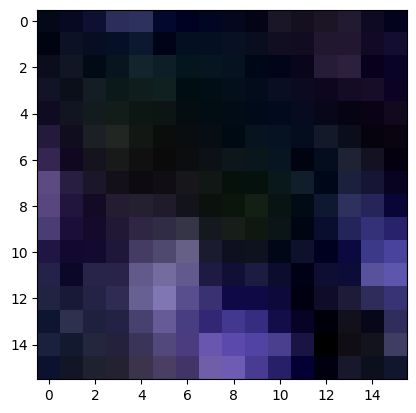

In [22]:
plt.imshow(optical_images1[7994])

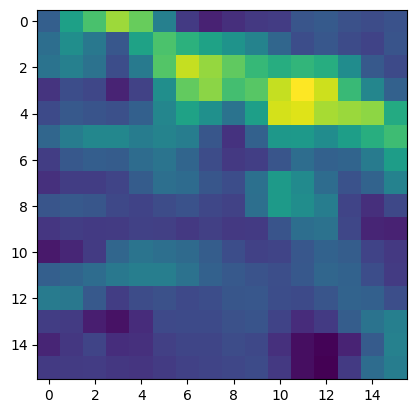

In [23]:
plt.imshow(sar_images1[7994])

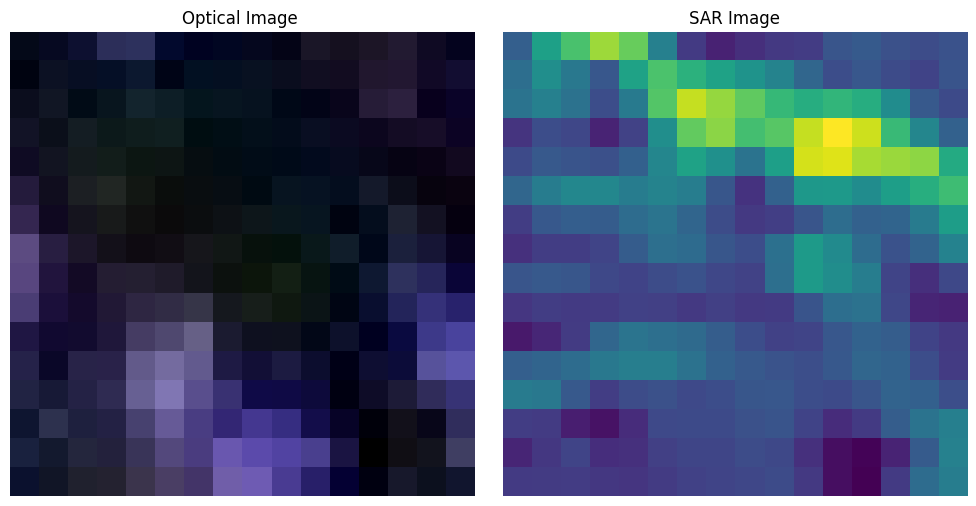

In [24]:
import matplotlib.pyplot as plt

# Assuming optical_images1 and sar_images1 are your image arrays
image_id = 7994

# Create a figure for displaying the images
plt.figure(figsize=(10, 5))

# Display optical image
plt.subplot(1, 2, 1)
plt.imshow(optical_images1[image_id])
plt.title(f'Optical Image ')
plt.axis('off')
plt.xlabel("Optical Image")

# Display corresponding SAR image
plt.subplot(1, 2, 2)
plt.imshow(sar_images1[image_id].squeeze())  # Use squeeze for SAR images if they have a singleton dimension
plt.title(f'SAR Image')
plt.axis('off')
plt.xlabel("SAR Image")

plt.tight_layout()
plt.show()


In [25]:
# Split the data into training and testing sets
train_optical, test_optical, train_sar, test_sar, train_labels, test_labels, train_species, test_species = train_test_split(
    optical_images1, sar_images1, labels, species_labels, test_size=0.35, random_state=42
)

# MultiDense Model for Multimodal Neural Network

## Model Description

The **MultiDense Model** belongs to the multimodal neural network class, specifically designed for tasks that involve processing information from multiple modalities. This model utilizes a series of dense layers to capture and integrate features from diverse input sources.

### Layers

1. **SAR Dense (`dense_sar`):**
   - Type: Dense
   - Output Shape: (None, sar_features)
   - Description: Processes SAR data through a dense layer.

2. **Optical Dense (`dense_optical`):**
   - Type: Dense
   - Output Shape: (None, optical_features)
   - Description: Processes Optical data through a dense layer.

3. **Additional Input Dense (`dense_additional`):**
   - Type: Dense
   - Output Shape: (None, additional_features)
   - Description: Processes any supplementary input through a dense layer.

4. **Concatenation (`concatenate`):**
   - Output Shape: (None, total_features)
   - Description: Concatenates the outputs from the dense layers.

5. **Output Dense (`dense_output`):**
   - Type: Dense
   - Output Shape: (None, 1)
   - Description: Produces the final output.

### Model Parameters

- **Total Parameters:** 453825

### Purpose

The **MultiDense Model** is tailored to handle multimodal tasks by effectively learning and combining information from SAR, Optical, and additional inputs. The architecture leverages dense layers to facilitate feature extraction and integration, making it suitable for various applications, such as height estimation.


## Mean Square Error 

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler

# Assuming train_labels and test_labels are the target variables
#scaler = StandardScaler()
#train_labels_scaled = scaler.fit_transform(train_labels.reshape(-1, 1)).flatten()
#test_labels_scaled = scaler.transform(test_labels.reshape(-1, 1)).flatten()

# Define the processing layers for each input
optical_input = layers.Input(shape=(16, 16, 3))
sar_input = layers.Input(shape=(16, 16, 1))
species_input = layers.Input(shape=(1,))

# Processing layers for optical input
optical_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(optical_input)
optical_output = layers.MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = layers.Conv2D(128, kernel_size=(3, 3), activation="relu")(optical_output)
optical_output = layers.MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = layers.Flatten()(optical_output)

# Processing layers for SAR input
sar_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(sar_input)
sar_output = layers.MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = layers.Conv2D(128, kernel_size=(3, 3), activation="relu")(sar_output)
sar_output = layers.MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = layers.Flatten()(sar_output)

# Processing layers for species input
species_output = layers.Dense(32, activation="relu")(species_input)

# Concatenate the flattened outputs
merged = layers.concatenate([optical_output, sar_output, species_output])

# Additional dense layers
dense_layer1 = layers.Dense(256, activation="relu")(merged)
dense_layer2 = layers.Dense(128, activation="relu")(dense_layer1)

# Define the output layer
output_layer = layers.Dense(1, activation="linear", name="biomass_output")(dense_layer2)

# Create the model
model = keras.Model(inputs=[optical_input, sar_input, species_input], outputs=output_layer, name="custom_model")

from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())



# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='huber_loss', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', r_squared])
# Print the summary of the model
model.summary()
#early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss',  # you can use 'val_mae' if you prefer to monitor mean absolute error
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
# Train the model with early stopping and validation data

history=model.fit([train_optical, train_sar, train_species], train_labels, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping] )

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([test_optical, test_sar, test_species], test_labels)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Model: "custom_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 16, 16, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           640       ['input_2[0][0]']             
                                                                                       

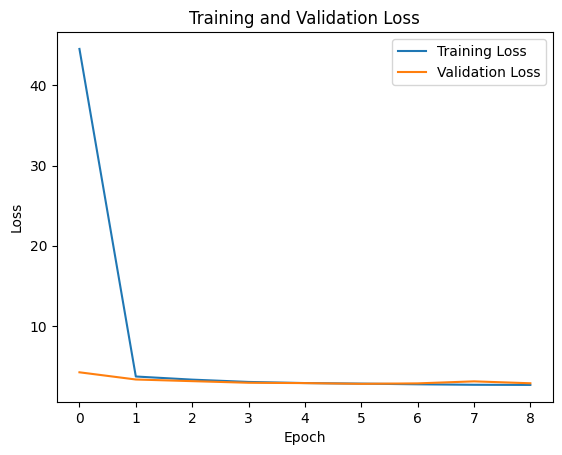

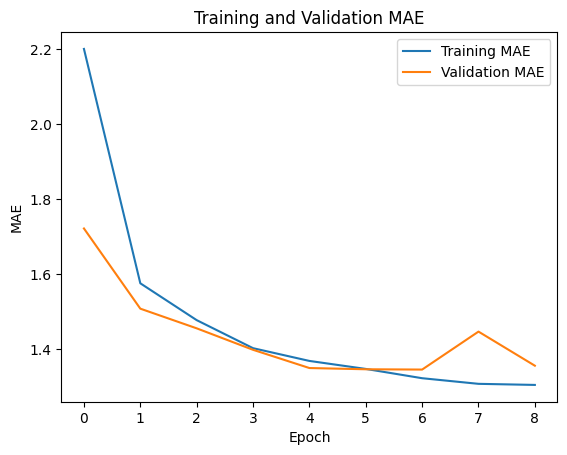

In [27]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

327/327 [==============================] - 3s 7ms/step


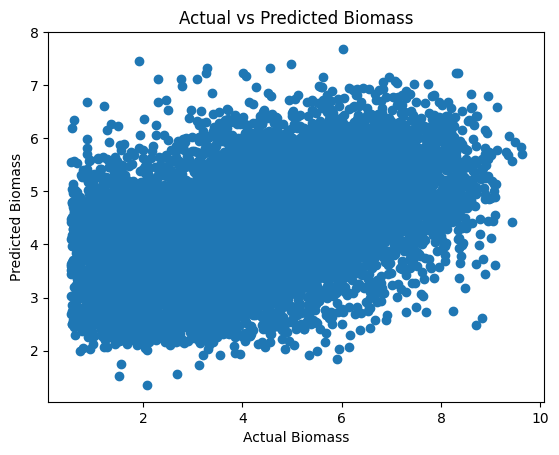

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])
#predictions_original = scaler.inverse_transform(predictions)
# Plot actual vs predicted values
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')

# Print actual and predicted values
#for actual, predicted in zip(test_labels, predictions_original):
#    print(f"Actual: {actual}, Predicted: {predicted}")

plt.show()

In [34]:
import numpy as np

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(test_labels.flatten(), predictions.flatten())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)


Correlation Coefficient: 0.47227511264144917


In [33]:
import numpy as np

# Assuming predictions is the array containing the estimated biomass values
predictions = model.predict([test_optical, test_sar, test_species])

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(test_labels.flatten(), predictions.flatten())[0, 1]

print("Correlation Coefficient:", correlation_coefficient)


327/327 [==============================] - 2s 7ms/step
Correlation Coefficient: 0.47227511264144917


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])


# Plot actual vs predicted values
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')


# Print actual and predicted values
for actual, predicted in zip(test_labels, predictions):
    print(f"Actual: {actual}, Predicted: {predicted}")

plt.show()

In [ ]:
log_predictions = model.predict([test_optical, test_sar, test_species])
predictions = np.expm1(log_predictions)  # Inverse of log1p is expm1


# Assuming that the test set index corresponds to the Tree ID
results = pd.DataFrame({
    'ActualBiomass': np.expm1(test_labels),  # Need to inverse the log transformation of y_test
    'PredictedBiomass': predictions.flatten()
})
print(results)


In [ ]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions using the model
predictions = model.predict([test_optical, test_sar, test_species])

# The number of epochs the model actually trained
epochs_trained = len(history.history['loss'])
# Evaluate regression metrics
mae = mean_absolute_error(test_labels, predictions)
rmse = mean_squared_error(test_labels, predictions, squared=False)


# Print the results
#print(f"Computational Time: {computational_time} seconds")
print(f"Number of Epochs Trained: {epochs_trained}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [32]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared_value = r2_score(test_labels, predictions)
print("R-squared Value:", r_squared_value)


R-squared Value: 0.21755537374293987


In [ ]:
import numpy as np

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(test_labels, test_predictions)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)


## Huber loss


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler

# Assuming train_labels and test_labels are the target variables
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_labels.reshape(-1, 1)).flatten()

# Define the processing layers for each input
optical_input = layers.Input(shape=(16, 16, 3))
sar_input = layers.Input(shape=(16, 16, 1))
species_input = layers.Input(shape=(1,))

# Processing layers for optical input
optical_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(optical_input)
optical_output = layers.MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = layers.Conv2D(128, kernel_size=(3, 3), activation="relu")(optical_output)
optical_output = layers.MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = layers.Flatten()(optical_output)

# Processing layers for SAR input
sar_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(sar_input)
sar_output = layers.MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = layers.Conv2D(128, kernel_size=(3, 3), activation="relu")(sar_output)
sar_output = layers.MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = layers.Flatten()(sar_output)

# Processing layers for species input
species_output = layers.Dense(32, activation="relu")(species_input)

# Concatenate the flattened outputs
merged = layers.concatenate([optical_output, sar_output, species_output])

# Additional dense layers
dense_layer1 = layers.Dense(256, activation="relu")(merged)
dense_layer2 = layers.Dense(128, activation="relu")(dense_layer1)

# Define the output layer
output_layer = layers.Dense(1, activation="linear", name="biomass_output")(dense_layer2)

# Create the model
model = keras.Model(inputs=[optical_input, sar_input, species_input], outputs=output_layer, name="custom_model")

from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())



# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001) 
#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['mae'])
model.compile(optimizer=optimizer, loss='huber_loss', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', r_squared])
# Print the summary of the model
model.summary()
#early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss',  # you can use 'val_mae' if you prefer to monitor mean absolute error
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
# Train the model with early stopping and validation data

history=model.fit([train_optical, train_sar, train_species], train_labels_scaled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping] )

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([test_optical, test_sar, test_species], test_labels_scaled)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])
predictions_original = scaler.inverse_transform(predictions)
# Plot actual vs predicted values
plt.scatter(test_labels, predictions_original)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')

# Print actual and predicted values
#for actual, predicted in zip(test_labels, predictions_original):
    #print(f"Actual: {actual}, Predicted: {predicted}")

plt.show()

## Mean Squared Logarithmic Error


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler

# Assuming train_labels and test_labels are the target variables
#scaler = StandardScaler()
#train_labels_scaled = scaler.fit_transform(train_labels.reshape(-1, 1)).flatten()
#test_labels_scaled = scaler.transform(test_labels.reshape(-1, 1)).flatten()

# Define the processing layers for each input
optical_input = layers.Input(shape=(16, 16, 3))
sar_input = layers.Input(shape=(16, 16, 1))
species_input = layers.Input(shape=(1,))

# Processing layers for optical input
optical_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(optical_input)
optical_output = layers.MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = layers.Conv2D(128, kernel_size=(3, 3), activation="relu")(optical_output)
optical_output = layers.MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = layers.Flatten()(optical_output)

# Processing layers for SAR input
sar_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(sar_input)
sar_output = layers.MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = layers.Conv2D(128, kernel_size=(3, 3), activation="relu")(sar_output)
sar_output = layers.MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = layers.Flatten()(sar_output)

# Processing layers for species input
species_output = layers.Dense(32, activation="relu")(species_input)

# Concatenate the flattened outputs
merged = layers.concatenate([optical_output, sar_output, species_output])

# Additional dense layers
dense_layer1 = layers.Dense(256, activation="relu")(merged)
dense_layer2 = layers.Dense(128, activation="relu")(dense_layer1)

# Define the output layer
output_layer = layers.Dense(1, activation="ELU", name="biomass_output")(dense_layer2)

# Create the model
model = keras.Model(inputs=[optical_input, sar_input, species_input], outputs=output_layer, name="custom_model")

from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())



# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001) 
#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='huber_loss', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', r_squared])
# Print the summary of the model
model.summary()
#early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss',  # you can use 'val_mae' if you prefer to monitor mean absolute error
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
# Train the model with early stopping and validation data

history=model.fit([train_optical, train_sar, train_species], train_labels, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping] )

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([test_optical, test_sar, test_species], test_labels)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])
#predictions_original = scaler.inverse_transform(predictions)
# Plot actual vs predicted values
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')

# Print actual and predicted values
for actual, predicted in zip(test_labels, predictions):
    print(f"Actual: {actual}, Predicted: {predicted}")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])

# Plot actual vs predicted values
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')

# Print actual and predicted values
#for actual, predicted in zip(test_labels, predictions):
#    print(f"Actual: {actual}, Predicted: {predicted}")

plt.show()

In [ ]:


log_predictions = model.predict([test_optical, test_sar, test_species])
predictions = np.expm1(log_predictions)  # Inverse of log1p is expm1


# Assuming that the test set index corresponds to the Tree ID
results = pd.DataFrame({
    'ActualBiomass': np.expm1(test_labels),  # Need to inverse the log transformation of y_test
    'PredictedBiomass': predictions.flatten()
})
print(results)



In [ ]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions using the model
predictions = model.predict([test_optical, test_sar, test_species])

# The number of epochs the model actually trained
epochs_trained = len(history.history['loss'])
# Evaluate regression metrics
mae = mean_absolute_error(test_labels, predictions)
rmse = mean_squared_error(test_labels, predictions, squared=False)


# Print the results
#print(f"Computational Time: {computational_time} seconds")
print(f"Number of Epochs Trained: {epochs_trained}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# RESNET50

## ResNet-Based Biomass Estimation Model

The ResNet-Based Biomass Estimation Model is designed to predict biomass values from optical images, utilizing the ResNet50 architecture as a feature extractor. The model also incorporates categorical information about tree species to enhance its predictive capabilities.

### Model Architecture

The model comprises the following components:

- **Optical Input**: Image data from optical sources, preprocessed to extract specific channels (2, 3, and 5) and resized to (32, 32, 3).

#### ResNet50 Feature Extractor

The core of the model is a ResNet50 feature extractor, pre-trained on ImageNet. The ResNet layers are set to be non-trainable to leverage the learned representations.

#### Additional Dense Layers

Following the ResNet feature extraction, two dense layers with ReLU activation and dropout are added to capture complex relationships in the data.

#### Concatenation and Output Layer

The outputs from the ResNet feature extraction and additional dense layers are concatenated. The final output layer predicts the biomass value using linear activation.

### Model Training

The model is trained using mean squared error as the loss function and mean absolute error as the evaluation metric. The Adam optimizer is employed with a learning rate of 0.001.

### Training History

The model is trained for 10 epochs on the training data, with a batch size of 32. The training progress is stored in the `history` variable.

### Model Evaluation

After training, the model is evaluated on the test set, and the test loss and mean absolute error are printed.


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
# Create lists for image paths, labels, and species labels
optical_image_paths = []
sar_image_paths = []

# Iterate through tree IDs
for tree_id in tree_data['treeID']:
    # Construct paths for optical and SAR images
    optical_path = os.path.join(optical_folder, f"tree_{tree_id}.0.tif")
    sar_path = os.path.join(sar_folder, f"tree_{tree_id}.0.tif")

    try:
        # Load optical image and extract specific channels (2, 3, and 5)
        optical_image = tifffile.imread(optical_path)[:, :, [2, 3, 5]]
        sar_image = tifffile.imread(sar_path)

        # Resize optical image to (32, 32, 3)
        resized_optical_image = array_to_img(optical_image).resize((32, 32))
        resized_optical_image = img_to_array(resized_optical_image)
        
        # Save SAR and resized optical images to lists
        sar_image_paths.append(sar_image)
        optical_image_paths.append(resized_optical_image)
    except Exception as e:
        print(f"Error loading optical image {optical_path}: {e}")

# Convert lists to numpy arrays
optical_images1 = np.array(optical_image_paths)
sar_images1 = np.array(sar_image_paths)
labels = np.array(labels)
species_labels = np.array(species_labels)
height_labels = np.array(height_labels)


In [ ]:
# Reshape SAR images to (16, 16, 1)
sar_images1 = sar_images1[..., np.newaxis]

# Print the shapes of the arrays
print("Optical Image Shape:", optical_images1.shape)
print("SAR Image Shape:", sar_images1.shape)
print("Labels Shape:", labels.shape)
print("Species Labels Shape:", species_labels.shape)
print("Height Labels Shape:", height_labels.shape) 


# Split the data into training and testing sets
train_optical, test_optical, train_sar, test_sar, train_labels, test_labels, train_species, test_species = train_test_split(
    optical_images1, sar_images1, labels, species_labels, test_size=0.35, random_state=42
)

In [ ]:
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import StandardScaler

# Assuming train_labels and test_labels are the target variables
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_labels.reshape(-1, 1)).flatten()

# Define the processing layers for each input
optical_input = layers.Input(shape=(32, 32, 3))
sar_input = layers.Input(shape=(16, 16, 1))
species_input = layers.Input(shape=(1,))

# Load the ResNet50 model pre-trained on ImageNet data
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Set the ResNet layers to be non-trainable
for layer in resnet_model.layers:
    layer.trainable = False

# Get the output of the ResNet50 model
resnet_output = resnet_model.output

# Flatten the output
resnet_flatten = layers.Flatten()(resnet_output)


# Adding layers as needed
dense_layer1 = layers.Dense(256, activation="relu")(resnet_flatten)
dropout1 = layers.Dropout(0.5)(dense_layer1)

dense_layer2 = layers.Dense(128, activation="relu")(dropout1)
dropout2 = layers.Dropout(0.5)(dense_layer2)



# Concatenate the flattened output with the species input
merged = layers.concatenate([resnet_flatten, species_input])

# Define the output layer
output_layer = layers.Dense(1, activation="linear", name="biomass_output")(merged)


# Create the model
model = keras.Model(inputs=[resnet_model.input, species_input], outputs=output_layer)

optimizer = keras.optimizers.Adam(learning_rate=0.001) 
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='huber_loss', metrics=['mae'])
# Print the summary of the model
model.summary()
#early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss',  # you can use 'val_mae' if you prefer to monitor mean absolute error
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping and validation data


# Train the model
history=model.fit([train_optical, train_species], train_labels_scaled, epochs=100, batch_size=32, validation_split=0.2 ,  callbacks=[early_stopping] )

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([test_optical, test_species], test_labels_scaled)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
predictions = model.predict([test_optical, test_species])
predictions_original = scaler.inverse_transform(predictions)
# Assuming you have a test dataset and model.predict() is used to get predictions
#predictions = model.predict([test_optical, test_sar, test_species])

# Plot actual vs predicted values
plt.scatter(test_labels_scaled, predictions)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')
plt.show()

# Transformer-Based Multimodal Biomass Estimation Model

## Model Description: 

The **Transformer-Based Multimodal Biomass Estimation Model** (referred to as "model_1") is an advanced architecture designed for accurate biomass estimation in a biomimicry application. This model integrates species information, SAR (Synthetic Aperture Radar) data, and Optical data using a transformer-like structure, incorporating attention mechanisms for effective feature extraction.

### Input Layers

1. **Species Input (`species_input`):**
   - Shape: (None, 1)
   - Description: Represents categorical species information.

2. **Optical Input (`optical_input`):**
   - Shape: (None, 16, 16, 3)
   - Description: Represents optical data.

3. **SAR Input (`sar_input`):**
   - Shape: (None, 16, 16, 1)
   - Description: Represents SAR data.

### Transformer Blocks

1. **Embedding Layer (`embedding`):**
   - Output Shape: (None, 1, 16)
   - Description: Embeds species information.

2. **Layer Normalization (`layer_normalization`):**
   - Output Shape: (None, 1, 16)
   - Description: Normalizes embedded species information.

3. **Multi-Head Attention (`multi_head_attention`):**
   - Output Shape: (None, 1, 16)
   - Description: Applies multi-head attention to the normalized species information.

4. **Dropout Layer (`dropout`):**
   - Output Shape: (None, 1, 16)
   - Description: Introduces dropout for regularization.

5. **Convolutional Layers (`conv2d_2`, `conv2d_4`):**
   - Output Shape: (None, 14, 14, 64)
   - Description: Applies convolution to optical and SAR data.

6. **Pooling and Dense Layers:**
   - Various pooling and dense layers for feature extraction and dimensionality reduction.

7. **Concatenation (`concatenate_1`):**
   - Output Shape: (None, 144)
   - Description: Concatenates outputs from the transformer and convolutional layers.

8. **Dense Layers (`dense_5`):**
   - Output Shape: (None, 128)
   - Description: Processes the concatenated data.

### Output Layer

- **Biomass Output (`biomass_output`):**
  - Type: Dense
  - Output Shape: (None, 1)
  - Description: Produces the final output for biomass estimation.

### Model Parameters

- **Total Parameters:** 236,257
- **Trainable Parameters:** 236,257
- **Non-trainable Parameters:** 0

### Model Purpose

The **Transformer-Based Multimodal Biomass Estimation Model** leverages a transformer-like structure for effective feature extraction from species information, SAR, and Optical data. The model is tailored for biomimicry applications, providing accurate biomass estimation by capturing both spatial and contextual information.




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, MultiHeadAttention, LayerNormalization, concatenate
from sklearn.preprocessing import StandardScaler

# Assuming train_labels and test_labels are the target variables
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_labels.reshape(-1, 1)).flatten()


def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    attention = Dropout(dropout)(attention)
    res = x + attention

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return res + x

# Define processing layers for each input
optical_input = Input(shape=(16, 16, 3), name="optical_input")
sar_input = Input(shape=(16, 16, 1), name="sar_input")
species_input = Input(shape=(1,), name="species_input")

# Processing layers for optical input
optical_output = Conv2D(64, kernel_size=(3, 3), activation="relu")(optical_input)
optical_output = MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = Conv2D(128, kernel_size=(3, 3), activation="relu")(optical_output)
optical_output = MaxPooling2D(pool_size=(2, 2))(optical_output)
optical_output = Flatten()(optical_output)
optical_output = Dense(64, activation="relu")(optical_output)

# Processing layers for SAR input
sar_output = Conv2D(64, kernel_size=(3, 3), activation="relu")(sar_input)
sar_output = MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = Conv2D(128, kernel_size=(3, 3), activation="relu")(sar_output)
sar_output = MaxPooling2D(pool_size=(2, 2))(sar_output)
sar_output = Flatten()(sar_output)
sar_output = Dense(64, activation="relu")(sar_output)

# Processing layers for species input using transformer
species_output = layers.Embedding(input_dim=4, output_dim=16, input_length=1)(species_input)
species_output = transformer_block(species_output, head_size=8, num_heads=2, ff_dim=16, dropout=0.1)
species_output = Flatten()(species_output)

# Concatenate the processed outputs
merged = concatenate([optical_output, sar_output, species_output])

# Additional dense layers if needed
merged = Dense(128, activation="relu")(merged)

# Output layer
output_layer = Dense(1, activation="linear", name="biomass_output")(merged)

# Create the model
model = models.Model(inputs=[optical_input, sar_input, species_input], outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['mae'])

#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['mae'])
model.compile(optimizer=optimizer, loss='huber_loss', metrics=['mae'])
# Print the summary of the model
model.summary()


In [ ]:
# Assuming you have train_optical, train_sar, train_species, train_labels,
# test_optical, test_sar, test_species, and test_labels available
early_stopping = EarlyStopping(
    monitor='val_loss',  # you can use 'val_mae' if you prefer to monitor mean absolute error
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
history=model.fit(
    [train_optical, train_sar, train_species],
    train_labels_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.3,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([test_optical, test_sar, test_species], test_labels_scaled)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


In [ ]:
import matplotlib.pyplot as plt
predictions = model.predict([test_optical, test_sar, test_species])
predictions_original = scaler.inverse_transform(predictions)
# Assuming you have a test dataset and model.predict() is used to get predictions
#predictions = model.predict([test_optical, test_sar, test_species])

# Plot actual vs predicted values
plt.scatter(test_labels, predictions_original)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')
plt.show()


In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])
predictions_original = scaler.inverse_transform(predictions)
actual_ = []
predicted_ = []
# Print actual and predicted values only if they are close
for actual, predicted in zip(test_labels, predictions_original):
    if abs(actual - predicted[0]) < threshold:
        print(f"Actual: {actual:.2f}, Predicted: {predicted[0]:.2f}")
        actual_.append( actual)
        predicted_.append(predicted[0])
        
# Print actual and predicted values
for actual, predicted in zip(actual_, predicted_):
    print(f"Actual: {actual}, Predicted: {predicted}")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming you have a test dataset and model.predict() is used to get predictions

predictions = model.predict([test_optical, test_sar, test_species])
predictions_original = scaler.inverse_transform(predictions)

# Set a threshold for closeness
threshold = 30.0  # Adjust as needed

# Plot actual vs predicted values
plt.scatter(test_labels, predictions_original)
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.title('Actual vs Predicted Biomass')

# Print actual and predicted values only if they are close
for actual, predicted in zip(test_labels, predictions_original):
    if abs(actual - predicted[0]) < threshold:
        print(f"Actual: {actual:.2f}, Predicted: {predicted[0]:.2f}")

plt.show()


In [ ]:
######################only Optical and SAR


from tensorflow import keras
from tensorflow.keras import layers

# Define the processing layers for each input
optical_input = layers.Input(shape=(16, 16, 3))
sar_input = layers.Input(shape=(16, 16, 1))

# Processing layers for optical input
optical_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(optical_input)
optical_output = layers.Flatten()(optical_output)
optical_output = layers.Dense(32, activation="relu")(optical_output)

# Processing layers for SAR input
sar_output = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(sar_input)
sar_output = layers.Flatten()(sar_output)
sar_output = layers.Dense(32, activation="relu")(sar_output)

# Concatenate the processed outputs
merged = layers.concatenate([optical_output, sar_output])

# Additional layers if needed
merged = layers.Dense(64, activation="relu")(merged)

# Output layer
output_layer = layers.Dense(1, activation="linear", name="biomass_output")(merged)

# Create the model
model = keras.Model(inputs=[optical_input, sar_input], outputs=output_layer)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Print the summary of the model
model.summary()

# Train the model
model.fit([train_optical, train_sar], train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([test_optical, test_sar], test_labels)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


In [ ]:
import matplotlib.pyplot as plt

# Make predictions using the model
log_predictions = model.predict([test_optical, test_sar, test_species])
predictions = np.expm1(log_predictions)  # Apply the inverse transformation

# Create a DataFrame for plotting
results = pd.DataFrame({
    'ActualBiomass': np.expm1(test_labels),  # Inverse the log transformation of test_labels
    'PredictedBiomass': predictions.flatten()
})

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(results['ActualBiomass'], results['PredictedBiomass'], alpha=0.5)
plt.title('Actual vs Predicted Biomass')
plt.xlabel('Actual Biomass')
plt.ylabel('Predicted Biomass')
plt.plot([results['ActualBiomass'].min(), results['ActualBiomass'].max()], 
         [results['ActualBiomass'].min(), results['ActualBiomass'].max()], 'k--') # Ideal 1:1 line
plt.show()